In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# !pip install cloud-tpu-client==0.10 torch==2.0.0  torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/117/torch_xla-2.0-cp39-cp39-linux_x86_64.whl --force-reinstall 

In [3]:
# import torch
# import torch_xla
# import torch_xla.core.xla_model as xm
# # 
# # Initialize TPU
# dev = xm.xla_device()


In [4]:
from torchvision.datasets.utils import download_url


dataset_url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"
download_url(dataset_url, '.')

# with tarfile.open('/content/wiki_crop.tar', 'r:gz') as tar:
#     tar.extractall(path='./data')
tar = tarfile.open("wiki_crop.tar")
tar.extractall()
tar.close()
    
data_dir = '/content/wiki_crop'
print(os.listdir(data_dir))
# classes = os.listdir(data_dir + "/train")
# print(classes)

  0%|          | 0/811315200 [00:00<?, ?it/s]

['00', '56', '46', '99', '90', '52', '04', '43', '22', '69', '25', '24', '80', '45', '65', '19', '75', '41', '84', '47', '85', '67', '92', '82', '08', '73', '97', '57', '64', '15', '51', '11', '76', '83', '81', '29', '30', '95', '42', '20', '93', '07', '87', '89', '79', '21', '98', '91', '61', '12', '01', '13', '63', '96', '18', '53', '44', '72', '55', '37', '28', '31', '27', '06', '35', '68', '05', '32', '02', '78', '14', '71', '49', '50', '59', '62', '38', '34', '33', '86', '40', 'wiki.mat', '77', '09', '66', '39', '48', '10', '26', '03', '36', '94', '88', '54', '60', '23', '74', '17', '70', '16', '58']


In [5]:
import scipy.io
mat = scipy.io.loadmat('/content/wiki_crop/wiki.mat')

In [6]:
# from PIL import Image
# i=Image.open('/content/wiki_crop/14/10193814_1927-03-21_1960.jpg')
# transform = T.Compose([T.PILToTensor()])
# tensor = transform(i)
# type(tensor.shape[0])

In [7]:
from datetime import datetime
def calc_age(taken, dob):
  birth = datetime.fromordinal(max(int(dob) - 366, 1))
  if birth.month < 7:
    return taken - birth.year
  else:
    return taken - birth.year - 1

In [8]:
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016', '__version__': '1.0', '__globals__': [], 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
              dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                array(['Dettmar Cramer'], dtype='<U14'),
                array(['Marc Okrand'], dtype='<U11'), ...,
                array(['Michael

In [9]:
print(type(mat))

<class 'dict'>


In [10]:
meta_data = mat['wiki'][0, 0]
l=meta_data['full_path']

In [11]:
l

array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
        array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
        array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
        array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
        array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
        array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
      dtype=object)

In [12]:
print(type(meta_data))

<class 'numpy.void'>


In [13]:
meta_data['photo_taken'][0]

array([2009, 1964, 2008, ..., 2013, 2011, 2008], dtype=uint16)

In [14]:
from torchvision.transforms import transforms as T

class Resize(object):
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size
    
  def __call__(self, sample):
    image, age = sample['image'], sample['age']
    image = T.Resize(self.output_size)(image)
    return {'image': image, 'age': age}


class ToTensor(object):
  def __call__(self,sample):
    image,age=sample['image'],sample['age']
    image=T.ToTensor()(image)
    if image.size()[0]==1:
      image=image.expand(3,-1,-1)
    return {'image':image,'age':age}



In [15]:
from pathlib import Path
def load_data(dataset='wiki', data_dir='./wiki_crop'):

  meta_path = Path(data_dir) / f'{dataset}.mat'
  meta = scipy.io.loadmat(meta_path)
  meta_data = meta[dataset][0, 0]

  full_path = meta_data['full_path'][0]
  full_path = [y for x in full_path for y in x]

  dob = meta_data['dob'][0]
  photo_taken = meta_data['photo_taken'][0]
  age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]
  age_path_map = {pth:age for (pth, age) in zip(full_path, age) if age > 0}
  full_path = list(age_path_map.keys())
  age = list(age_path_map.values())

  return full_path, age

In [16]:
from PIL import Image

class ImageAgeDataset(Dataset):
  def __init__(self,dataset,data_dir,transform=None):

    self.data_dir = data_dir
    self.full_path, self.age = load_data(dataset, data_dir)
    self.transform = transform
  
  def __len__(self):
    return len(self.age)

  def __getitem__(self, idx):
    image = Image.open(os.path.join(self.data_dir, self.full_path[idx]))
    age = self.age[idx]
    sample = {'image': image, 'age': age}
    if self.transform:
      sample = self.transform(sample)
    return sample


In [17]:
from torchvision.transforms import transforms as T

image_size=64
batch_size=128
train_dataset=ImageAgeDataset('wiki','./wiki_crop',transform=T.Compose([
    Resize((image_size,image_size)),
    ToTensor()]))
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

In [18]:
i,i1=next(iter(train_loader))
i1

'age'

In [19]:
print(train_loader)

In [20]:
# def show_batch(dl):
#   for images, ages in dl:
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.set_xticks([]); ax.set_yticks([])
#     # denorm_images = denormalize(images, *stats)
#     ax.imshow(make_grid(images['image'], nrow=8).permute(1, 2, 0).clamp(0,1))
#     break

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(dataset_loader):
  images, ages = next(iter(dataset_loader))
  images = images.numpy()
  fig = plt.figure(figsize=(10, 10))
  for i in range(len(images)):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(ages[i])


In [22]:
# show_batch(train_loader)

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid


batch=next(iter(train_loader))

images = batch['image']
ages = batch['age']
# grid = make_grid(images, nrow=int(np.sqrt(images.shape[0])), padding=2)

# fig, ax = plt.subplots(figsize=(12, 12))
# ax.imshow(np.transpose(grid, (1, 2, 0)))
# ax.set_title('Batch of Images with Age Labels')
# ax.axis('off')

# for i, image in enumerate(images):
#     x = (i % 8) * (image.shape[2] + 10) + image.shape[2] / 2
#     y = (i // 8) * (image.shape[1] + 10) + image.shape[1] + 5
#     ax.text(x, y, str(ages[i].item()), color='white', fontsize=10, ha='center')

# plt.show()

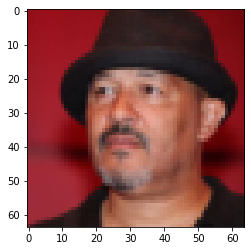

In [24]:
plt.imshow(train_dataset[55]['image'].numpy().transpose(1,2,0))

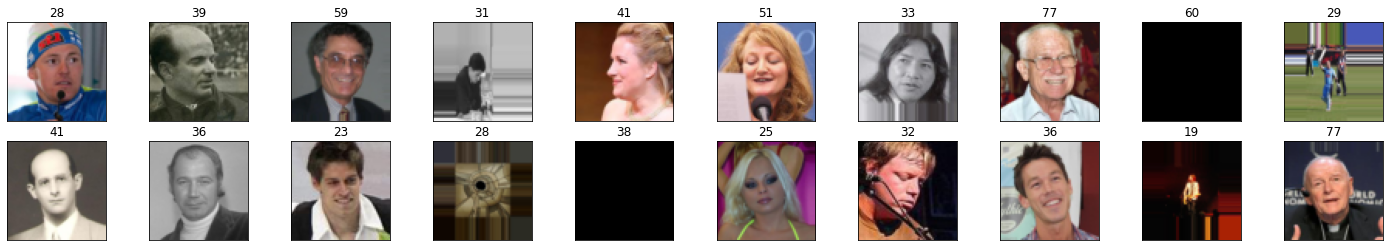

In [25]:
data = next(iter(train_loader))
images, labels = data['image'], data['age']

fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()))

In [26]:
def encoder(in_channels=0,out_channels=0,first=False):
  if first:
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(negative_slope=0.2)
    )
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,stride=2,kernel_size=4,padding=1),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(negative_slope=0.2)
  )

In [27]:
def decoder(in_channels=0,out_channels=0,dropout=False):
  if dropout:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.Dropout2d()
        )
  return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(out_channels)
        )
    

In [28]:
# Helpers
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(conv_layer)
  
  if batch_norm:
      bn = nn.BatchNorm2d(out_channels)
      layers.append(bn)
      
  return nn.Sequential(*layers)


In [29]:
# class Generator(nn.Module):
#   def __init__(self):
#     super(Generator, self).__init__()

#     self.encoder1 = encoder(in_channels=1,   out_channels=64,first = True)
#     self.encoder2 = encoder(in_channels=64,  out_channels=128)
#     self.encoder3 = encoder(in_channels=128, out_channels=256)
#     self.encoder4 = encoder(in_channels=256, out_channels=512)
#     self.encoder5 = encoder(in_channels=512, out_channels=512)
#     self.encoder6 = encoder(in_channels=512, out_channels=512)
#     self.encoder7 = encoder(in_channels=512, out_channels=512)

#     self.conv1 = nn.Sequential(
#         nn.Conv2d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1),
#         nn.ReLU(inplace=True)
#     )

#     self.decoder1 = decoder(in_channels=512, out_channels=512, dropout=True)
#     self.decoder2 = decoder(in_channels=1024, out_channels=512, dropout=True)
#     self.decoder3 = decoder(in_channels=1024, out_channels=512, dropout=True)
#     self.decoder4 = decoder(in_channels=1024, out_channels=512)
#     self.decoder5 = decoder(in_channels=1024, out_channels=256)
#     self.decoder6 = decoder(in_channels=512, out_channels=128)
#     self.decoder7 = decoder(in_channels=256, out_channels=64)

#     self.conv2 = nn.Sequential(
#         nn.ConvTranspose2d(in_channels = 128, out_channels = 2,kernel_size=4,stride=2,padding=1),
#         nn.Tanh()
#     )

#   def encode(self,x):
#     skips = []
#     x = self.encoder1(x)
#     skips.append(x)
#     x = self.encoder2(x)
#     skips.append(x)
#     x = self.encoder3(x)
#     skips.append(x)
#     x = self.encoder4(x)
#     skips.append(x)
#     x = self.encoder5(x)
#     skips.append(x)
#     x = self.encoder6(x)
#     skips.append(x)
#     x = self.encoder7(x)
#     skips.append(x)
#     x = self.conv1(x)
#     return x, skips

#   def decode(self, x, skips):
#     x = self.decoder1(x)
#     x = F.relu(x)
#     x = torch.cat([x,skips[6]],1)
#     x = self.decoder2(x)
#     x = torch.cat([x,skips[5]],1)
#     x = F.relu(x)
#     x = self.decoder3(x)
#     x = torch.cat([x,skips[4]],1)
#     x = F.relu(x)
#     x = self.decoder4(x)
#     x = torch.cat([x,skips[3]],1)
#     x = F.relu(x)
#     x = self.decoder5(x)
#     x = torch.cat([x,skips[2]],1)
#     x = F.relu(x)
#     x = self.decoder6(x)
#     x = torch.cat([x,skips[1]],1)
#     x = F.relu(x)
#     x = self.decoder7(x)
#     x = torch.cat([x,skips[0]],1)
#     x = F.relu(x)
#     return x

#   def forward(self,x):
#     x, skips = self.encode(x)
#     out = self.decode(x,skips)
#     return self.conv2(out)


In [30]:
# class CNNBlock(nn.Module):
#   def __init__(self, in_channels, out_channels, stride=2):
#     super().__init__()
#     self.conv = nn.Sequential(
#         nn.Conv2d(in_channels=in_channels,out_channels=out_channels, kernel_size=4, stride=stride, padding=1),
#         nn.BatchNorm2d(out_channels),
#         nn.LeakyReLU(0.2),
#     )
#   def forward(self, x):

#     return self.conv(x)

In [31]:
# class Discriminator(nn.Module):
#   def __init__(self,in_channels=3,dims=[64,128,256,512]):
#     super().__init__()
#     self.first=nn.Sequential(
#         nn.Conv2d(in_channels=in_channels,out_channels=dims[0],kernel_size=4,stride=2,padding=1),
#         nn.LeakyReLU(negative_slope=0.2,inplace=True)
#     )
#     layers=[]
#     in_channels = dims[0]
#     for dim in dims[1:]:
#       layers.append(
#           CNNBlock(in_channels=in_channels,out_channels=dim,stride=1 if dim==dims[len(dims)-int(1)] else 2)
#       )
#       in_channels=dim

#     layers.append(
#         nn.Conv2d(512,1,kernel_size=4,stride=1,padding=1)
#     )

#     self.model=nn.Sequential(*layers)

#   def forward(self, x, y):
#     x = torch.cat([x,y], dim=1)
#     #print(x.shape)
#     x = self.first(x)
#     return self.model(x)

class Discriminator(nn.Module):
  def __init__(self, y_size, conv_dim=64):
      super(Discriminator, self).__init__()
      self.conv_dim = conv_dim
      self.y_size = y_size
      self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
      self.conv2 = conv(conv_dim+y_size, conv_dim * 2, 4)
      self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
      self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
      self.conv5 = conv(conv_dim*8, 1, 4, 1, 0, batch_norm=False)
          
  def forward(self, x, y):
      x = F.relu(self.conv1(x))
      y = y.view(-1,y.size()[-1],1,1)
      y = y.expand(-1,-1,x.size()[-2], x.size()[-1])
      x = torch.cat([x, y], 1)
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = self.conv5(x)
      return x


In [32]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
  layers = []
  t_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(t_conv)
  
  if batch_norm:
      layers.append(nn.BatchNorm2d(out_channels))
      
  return nn.Sequential(*layers)

In [33]:
class Generator(nn.Module):
  def __init__(self, z_size, y_size, conv_dim=64):
      super(Generator, self).__init__()
      
      self.conv_dim = conv_dim
      self.t_conv1 = deconv(z_size+y_size, conv_dim*8, 4, 1, 0)
      self.t_conv2 = deconv(conv_dim*8, conv_dim*4, 4)
      self.t_conv3 = deconv(conv_dim*4, conv_dim*2, 4)
      self.t_conv4 = deconv(conv_dim*2, conv_dim, 4)
      self.t_conv5 = deconv(conv_dim, 3, 4, batch_norm=False)
      
  def forward(self, z, y):
      x = torch.cat([z, y], dim=1)
      x = x.view(-1, x.size()[-1], 1, 1)
      x = F.relu(self.t_conv1(x))
      x = F.relu(self.t_conv2(x))
      x = F.relu(self.t_conv3(x))
      x = F.relu(self.t_conv4(x))
      x = self.t_conv5(x)
      x = torch.tanh(x)
      
      return x

In [34]:
conv_dim = 64
z_size = 100
y_size = 6 # len(age_labels)

D = Discriminator(y_size, conv_dim)
G = Generator(z_size, y_size, conv_dim)

In [35]:
D.to(device)
D

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(70, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [36]:
G.to(device)
G

Generator(
  (t_conv1): Sequential(
    (0): ConvTranspose2d(106, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv5): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [37]:
def real_loss(D_out, smooth=False):
  batch_size = D_out.size(0)
  if smooth:
    labels = torch.ones(batch_size)*0.9
  else:
    labels = torch.ones(batch_size)    
  labels = labels.to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss

def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size) 
  labels = labels.to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss
def scale(x, feature_range=(-1, 1)):
  min, max = feature_range
  x = x * (max - min) + min
  return x

In [38]:
import torch.optim as optim
lr = 0.0002
beta1=0.5
beta2=0.999 

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [39]:
from tqdm import tqdm
num_epochs = 50
samples=[]
losses=[]
bins = [18, 29, 39, 49, 59]
def one_hot(x, bins):
  x = x.numpy()
  idxs = np.digitize(x, bins, right=True)
  idxs = idxs.reshape(-1,1)
  z = torch.zeros(len(x), len(bins)+1).scatter_(1, torch.tensor(idxs), 1)
  return z

z_size=100
y_size=6
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_y = np.random.randint(len(bins), size=sample_size)
fixed_y = fixed_y.reshape(-1,1)
fixed_y = torch.zeros(sample_size, len(bins)+1).scatter_(1, torch.tensor(fixed_y), 1)

for epoch in range(num_epochs):
  loop = tqdm(train_loader, leave=True)
  for batch_i,batch in enumerate(loop):
    batch_size = batch['image'].size(0)
    real_images = batch['image']
    ages = one_hot(batch['age'], bins)
    
    d_optimizer.zero_grad()
    real_images = real_images.to(device)
    ages = ages.to(device)
    
    D_real = D(real_images, ages)
    d_real_loss = real_loss(D_real)
    d_fake_loss = fake_loss(D_real)

    
    d_loss  = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()
    g_optimizer.zero_grad()
    
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    z = z.to(device)
    fake_images = G(z, ages)

    D_fake = D(fake_images, ages)
    g_loss = real_loss(D_fake) 
    
    g_loss.backward()
    g_optimizer.step()
    if batch_i % 5 == 0:
      losses.append((d_loss.item(), g_loss.item()))
      print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))

  G.eval() 
  fixed_z = fixed_z.to(device)
  fixed_y = fixed_y.to(device)
  samples_z = G(fixed_z, fixed_y)
  samples.append(samples_z)
  G.train()

  0%|          | 1/477 [00:08<1:08:04,  8.58s/it]

Epoch [    1/   50] | d_loss: 1.4359 | g_loss: 0.1054


  1%|▏         | 6/477 [00:10<06:10,  1.27it/s]

Epoch [    1/   50] | d_loss: 1.4697 | g_loss: 0.0383


  2%|▏         | 11/477 [00:11<02:59,  2.59it/s]

Epoch [    1/   50] | d_loss: 1.4074 | g_loss: 0.0163


  3%|▎         | 16/477 [00:13<02:32,  3.02it/s]

Epoch [    1/   50] | d_loss: 1.3935 | g_loss: 0.0074


  4%|▍         | 21/477 [00:14<02:33,  2.97it/s]

Epoch [    1/   50] | d_loss: 1.3952 | g_loss: 0.0076


  5%|▌         | 26/477 [00:16<02:46,  2.70it/s]

Epoch [    1/   50] | d_loss: 1.4298 | g_loss: 0.0035


  6%|▋         | 31/477 [00:18<02:36,  2.85it/s]

Epoch [    1/   50] | d_loss: 1.3957 | g_loss: 0.0073


  8%|▊         | 36/477 [00:20<02:23,  3.07it/s]

Epoch [    1/   50] | d_loss: 1.3922 | g_loss: 0.0059


  9%|▊         | 41/477 [00:21<02:27,  2.96it/s]

Epoch [    1/   50] | d_loss: 1.4222 | g_loss: 0.0032


 10%|▉         | 46/477 [00:23<02:25,  2.96it/s]

Epoch [    1/   50] | d_loss: 1.4192 | g_loss: 0.0049


 11%|█         | 51/477 [00:24<02:20,  3.04it/s]

Epoch [    1/   50] | d_loss: 1.3930 | g_loss: 0.0035


 12%|█▏        | 56/477 [00:26<02:19,  3.01it/s]

Epoch [    1/   50] | d_loss: 1.3892 | g_loss: 0.0030


 13%|█▎        | 61/477 [00:28<02:44,  2.53it/s]

Epoch [    1/   50] | d_loss: 1.3885 | g_loss: 0.0030


 14%|█▍        | 66/477 [00:30<02:42,  2.54it/s]

Epoch [    1/   50] | d_loss: 1.3890 | g_loss: 0.0023


 15%|█▌        | 72/477 [00:32<01:56,  3.48it/s]

Epoch [    1/   50] | d_loss: 1.3890 | g_loss: 0.0024


 16%|█▌        | 76/477 [00:33<02:12,  3.03it/s]

Epoch [    1/   50] | d_loss: 1.3932 | g_loss: 0.0023


 17%|█▋        | 81/477 [00:35<02:05,  3.16it/s]

Epoch [    1/   50] | d_loss: 1.4042 | g_loss: 0.0032


 18%|█▊        | 86/477 [00:36<02:05,  3.12it/s]

Epoch [    1/   50] | d_loss: 1.3920 | g_loss: 0.0025


 19%|█▉        | 91/477 [00:38<02:05,  3.08it/s]

Epoch [    1/   50] | d_loss: 1.3905 | g_loss: 0.0021


 20%|██        | 96/477 [00:39<02:12,  2.87it/s]

Epoch [    1/   50] | d_loss: 1.4209 | g_loss: 0.0038


 21%|██        | 101/477 [00:42<02:44,  2.29it/s]

Epoch [    1/   50] | d_loss: 1.3893 | g_loss: 0.0025


 22%|██▏       | 106/477 [00:43<02:07,  2.90it/s]

Epoch [    1/   50] | d_loss: 1.3913 | g_loss: 0.0021


 23%|██▎       | 111/477 [00:45<02:01,  3.02it/s]

Epoch [    1/   50] | d_loss: 1.3944 | g_loss: 0.0017


 24%|██▍       | 116/477 [00:46<01:59,  3.02it/s]

Epoch [    1/   50] | d_loss: 1.3895 | g_loss: 0.0031


 25%|██▌       | 121/477 [00:48<01:37,  3.64it/s]

Epoch [    1/   50] | d_loss: 1.3888 | g_loss: 0.0024


 26%|██▋       | 126/477 [00:49<01:52,  3.12it/s]

Epoch [    1/   50] | d_loss: 1.3915 | g_loss: 0.0021


 27%|██▋       | 131/477 [00:51<02:04,  2.78it/s]

Epoch [    1/   50] | d_loss: 1.3904 | g_loss: 0.0025


 29%|██▊       | 136/477 [00:53<02:21,  2.40it/s]

Epoch [    1/   50] | d_loss: 1.3890 | g_loss: 0.0020


 30%|██▉       | 141/477 [00:55<02:01,  2.78it/s]

Epoch [    1/   50] | d_loss: 1.3886 | g_loss: 0.0015


 31%|███       | 146/477 [00:56<01:51,  2.97it/s]

Epoch [    1/   50] | d_loss: 1.3903 | g_loss: 0.0024


 32%|███▏      | 151/477 [00:58<01:44,  3.11it/s]

Epoch [    1/   50] | d_loss: 1.3881 | g_loss: 0.0019


 33%|███▎      | 156/477 [00:59<01:40,  3.19it/s]

Epoch [    1/   50] | d_loss: 1.3902 | g_loss: 0.0019


 34%|███▍      | 161/477 [01:01<01:43,  3.04it/s]

Epoch [    1/   50] | d_loss: 1.3958 | g_loss: 0.0017


 35%|███▍      | 166/477 [01:03<01:39,  3.12it/s]

Epoch [    1/   50] | d_loss: 1.3945 | g_loss: 0.0025


 36%|███▌      | 171/477 [01:04<01:57,  2.60it/s]

Epoch [    1/   50] | d_loss: 1.3885 | g_loss: 0.0025


 37%|███▋      | 176/477 [01:07<02:06,  2.39it/s]

Epoch [    1/   50] | d_loss: 1.3907 | g_loss: 0.0015


 38%|███▊      | 181/477 [01:08<01:36,  3.07it/s]

Epoch [    1/   50] | d_loss: 1.3882 | g_loss: 0.0021


 39%|███▉      | 186/477 [01:10<01:30,  3.20it/s]

Epoch [    1/   50] | d_loss: 1.3923 | g_loss: 0.0030


 40%|████      | 191/477 [01:11<01:31,  3.13it/s]

Epoch [    1/   50] | d_loss: 1.3891 | g_loss: 0.0025


 41%|████      | 196/477 [01:13<01:32,  3.03it/s]

Epoch [    1/   50] | d_loss: 1.3953 | g_loss: 0.0022


 42%|████▏     | 201/477 [01:14<01:27,  3.16it/s]

Epoch [    1/   50] | d_loss: 1.3881 | g_loss: 0.0020


 43%|████▎     | 206/477 [01:16<01:26,  3.14it/s]

Epoch [    1/   50] | d_loss: 1.3971 | g_loss: 0.0031


 44%|████▍     | 211/477 [01:18<01:48,  2.46it/s]

Epoch [    1/   50] | d_loss: 1.3932 | g_loss: 0.0025


 45%|████▌     | 216/477 [01:20<01:33,  2.80it/s]

Epoch [    1/   50] | d_loss: 1.3878 | g_loss: 0.0027


 46%|████▋     | 221/477 [01:21<01:29,  2.87it/s]

Epoch [    1/   50] | d_loss: 1.3915 | g_loss: 0.0034


 47%|████▋     | 226/477 [01:23<01:09,  3.59it/s]

Epoch [    1/   50] | d_loss: 1.3897 | g_loss: 0.0027


 48%|████▊     | 231/477 [01:24<01:19,  3.09it/s]

Epoch [    1/   50] | d_loss: 1.3969 | g_loss: 0.0022


 49%|████▉     | 236/477 [01:26<01:15,  3.21it/s]

Epoch [    1/   50] | d_loss: 1.3882 | g_loss: 0.0019


 51%|█████     | 241/477 [01:27<01:18,  2.99it/s]

Epoch [    1/   50] | d_loss: 1.3935 | g_loss: 0.0026


 52%|█████▏    | 246/477 [01:29<01:32,  2.50it/s]

Epoch [    1/   50] | d_loss: 1.3872 | g_loss: 0.0020


 53%|█████▎    | 251/477 [01:31<01:27,  2.57it/s]

Epoch [    1/   50] | d_loss: 1.3881 | g_loss: 0.0023


 54%|█████▎    | 256/477 [01:33<01:14,  2.98it/s]

Epoch [    1/   50] | d_loss: 1.3890 | g_loss: 0.0022


 55%|█████▍    | 261/477 [01:34<01:13,  2.94it/s]

Epoch [    1/   50] | d_loss: 1.3879 | g_loss: 0.0023


 56%|█████▌    | 266/477 [01:36<01:11,  2.95it/s]

Epoch [    1/   50] | d_loss: 1.3905 | g_loss: 0.0026


 57%|█████▋    | 271/477 [01:37<01:05,  3.15it/s]

Epoch [    1/   50] | d_loss: 1.3887 | g_loss: 0.0023


 58%|█████▊    | 276/477 [01:39<01:00,  3.34it/s]

Epoch [    1/   50] | d_loss: 1.4124 | g_loss: 0.0019


 59%|█████▉    | 281/477 [01:41<01:03,  3.07it/s]

Epoch [    1/   50] | d_loss: 1.3874 | g_loss: 0.0023


 60%|█████▉    | 286/477 [01:43<01:22,  2.32it/s]

Epoch [    1/   50] | d_loss: 1.3876 | g_loss: 0.0025


 61%|██████    | 291/477 [01:44<01:04,  2.87it/s]

Epoch [    1/   50] | d_loss: 1.3873 | g_loss: 0.0019


 62%|██████▏   | 296/477 [01:46<00:57,  3.17it/s]

Epoch [    1/   50] | d_loss: 1.3870 | g_loss: 0.0014


 63%|██████▎   | 301/477 [01:47<00:56,  3.10it/s]

Epoch [    1/   50] | d_loss: 1.3871 | g_loss: 0.0020


 64%|██████▍   | 306/477 [01:49<00:55,  3.06it/s]

Epoch [    1/   50] | d_loss: 1.3867 | g_loss: 0.0020


 65%|██████▌   | 311/477 [01:51<00:54,  3.04it/s]

Epoch [    1/   50] | d_loss: 1.3910 | g_loss: 0.0016


 66%|██████▌   | 316/477 [01:52<00:55,  2.91it/s]

Epoch [    1/   50] | d_loss: 1.3892 | g_loss: 0.0013


 67%|██████▋   | 321/477 [01:54<01:07,  2.33it/s]

Epoch [    1/   50] | d_loss: 1.3889 | g_loss: 0.0012


 68%|██████▊   | 326/477 [01:56<00:52,  2.87it/s]

Epoch [    1/   50] | d_loss: 1.3881 | g_loss: 0.0016


 69%|██████▉   | 331/477 [01:58<00:47,  3.06it/s]

Epoch [    1/   50] | d_loss: 1.3874 | g_loss: 0.0016


 70%|███████   | 336/477 [01:59<00:47,  2.97it/s]

Epoch [    1/   50] | d_loss: 1.3871 | g_loss: 0.0021


 71%|███████▏  | 341/477 [02:01<00:45,  3.00it/s]

Epoch [    1/   50] | d_loss: 1.3902 | g_loss: 0.0020


 73%|███████▎  | 346/477 [02:02<00:41,  3.19it/s]

Epoch [    1/   50] | d_loss: 1.3913 | g_loss: 0.0019


 74%|███████▎  | 351/477 [02:04<00:40,  3.14it/s]

Epoch [    1/   50] | d_loss: 1.3876 | g_loss: 0.0030


 75%|███████▍  | 356/477 [02:06<00:43,  2.78it/s]

Epoch [    1/   50] | d_loss: 1.3949 | g_loss: 0.0019


 76%|███████▌  | 361/477 [02:08<00:48,  2.39it/s]

Epoch [    1/   50] | d_loss: 1.3896 | g_loss: 0.0025


 77%|███████▋  | 366/477 [02:09<00:38,  2.86it/s]

Epoch [    1/   50] | d_loss: 1.3884 | g_loss: 0.0022


 78%|███████▊  | 372/477 [02:11<00:28,  3.74it/s]

Epoch [    1/   50] | d_loss: 1.3896 | g_loss: 0.0011


 79%|███████▉  | 376/477 [02:12<00:32,  3.08it/s]

Epoch [    1/   50] | d_loss: 1.4039 | g_loss: 0.0022


 80%|███████▉  | 381/477 [02:14<00:32,  2.94it/s]

Epoch [    1/   50] | d_loss: 1.3881 | g_loss: 0.0032


 81%|████████  | 386/477 [02:16<00:30,  2.98it/s]

Epoch [    1/   50] | d_loss: 1.3870 | g_loss: 0.0027


 82%|████████▏ | 391/477 [02:17<00:27,  3.08it/s]

Epoch [    1/   50] | d_loss: 1.3871 | g_loss: 0.0029


 83%|████████▎ | 396/477 [02:19<00:36,  2.24it/s]

Epoch [    1/   50] | d_loss: 1.3871 | g_loss: 0.0024


 84%|████████▍ | 401/477 [02:21<00:27,  2.80it/s]

Epoch [    1/   50] | d_loss: 1.3870 | g_loss: 0.0019


 85%|████████▌ | 406/477 [02:23<00:24,  2.88it/s]

Epoch [    1/   50] | d_loss: 1.3876 | g_loss: 0.0020


 86%|████████▌ | 411/477 [02:24<00:22,  2.96it/s]

Epoch [    1/   50] | d_loss: 1.3896 | g_loss: 0.0019


 87%|████████▋ | 416/477 [02:26<00:19,  3.12it/s]

Epoch [    1/   50] | d_loss: 1.3885 | g_loss: 0.0014


 88%|████████▊ | 421/477 [02:27<00:18,  3.03it/s]

Epoch [    1/   50] | d_loss: 1.3937 | g_loss: 0.0014


 89%|████████▉ | 426/477 [02:29<00:17,  2.96it/s]

Epoch [    1/   50] | d_loss: 1.3909 | g_loss: 0.0026


 90%|█████████ | 431/477 [02:31<00:20,  2.26it/s]

Epoch [    1/   50] | d_loss: 1.3871 | g_loss: 0.0015


 91%|█████████▏| 436/477 [02:33<00:15,  2.67it/s]

Epoch [    1/   50] | d_loss: 1.3903 | g_loss: 0.0025


 92%|█████████▏| 441/477 [02:35<00:12,  2.94it/s]

Epoch [    1/   50] | d_loss: 1.3869 | g_loss: 0.0021


 94%|█████████▎| 446/477 [02:36<00:09,  3.15it/s]

Epoch [    1/   50] | d_loss: 1.3911 | g_loss: 0.0023


 95%|█████████▍| 451/477 [02:38<00:08,  3.14it/s]

Epoch [    1/   50] | d_loss: 1.3870 | g_loss: 0.0017


 96%|█████████▌| 456/477 [02:39<00:06,  3.08it/s]

Epoch [    1/   50] | d_loss: 1.3868 | g_loss: 0.0020


 97%|█████████▋| 461/477 [02:41<00:05,  3.12it/s]

Epoch [    1/   50] | d_loss: 1.3869 | g_loss: 0.0029


 98%|█████████▊| 466/477 [02:43<00:04,  2.70it/s]

Epoch [    1/   50] | d_loss: 1.3876 | g_loss: 0.0013


 99%|█████████▊| 471/477 [02:45<00:02,  2.60it/s]

Epoch [    1/   50] | d_loss: 1.3866 | g_loss: 0.0014


100%|██████████| 477/477 [02:46<00:00,  2.86it/s]


Epoch [    1/   50] | d_loss: 1.3869 | g_loss: 0.0027


  0%|          | 1/477 [00:00<02:59,  2.65it/s]

Epoch [    2/   50] | d_loss: 1.3895 | g_loss: 0.0029


  1%|▏         | 6/477 [00:01<02:33,  3.06it/s]

Epoch [    2/   50] | d_loss: 1.3873 | g_loss: 0.0017


  2%|▏         | 11/477 [00:03<02:30,  3.10it/s]

Epoch [    2/   50] | d_loss: 1.3873 | g_loss: 0.0029


  3%|▎         | 16/477 [00:05<02:27,  3.13it/s]

Epoch [    2/   50] | d_loss: 1.3869 | g_loss: 0.0014


  4%|▍         | 21/477 [00:06<02:33,  2.96it/s]

Epoch [    2/   50] | d_loss: 1.3873 | g_loss: 0.0021


  5%|▌         | 26/477 [00:08<02:22,  3.15it/s]

Epoch [    2/   50] | d_loss: 1.3897 | g_loss: 0.0005


  6%|▋         | 31/477 [00:10<03:01,  2.46it/s]

Epoch [    2/   50] | d_loss: 1.3889 | g_loss: 0.0029


  8%|▊         | 36/477 [00:12<02:29,  2.95it/s]

Epoch [    2/   50] | d_loss: 1.3885 | g_loss: 0.0022


  9%|▊         | 41/477 [00:13<02:27,  2.96it/s]

Epoch [    2/   50] | d_loss: 1.3875 | g_loss: 0.0019


 10%|▉         | 46/477 [00:15<02:24,  2.99it/s]

Epoch [    2/   50] | d_loss: 1.3910 | g_loss: 0.0014


 11%|█         | 51/477 [00:16<02:18,  3.07it/s]

Epoch [    2/   50] | d_loss: 1.3870 | g_loss: 0.0014


 12%|█▏        | 56/477 [00:18<02:18,  3.04it/s]

Epoch [    2/   50] | d_loss: 1.3867 | g_loss: 0.0015


 13%|█▎        | 61/477 [00:19<02:13,  3.12it/s]

Epoch [    2/   50] | d_loss: 1.3867 | g_loss: 0.0016


 14%|█▍        | 66/477 [00:22<03:06,  2.21it/s]

Epoch [    2/   50] | d_loss: 1.3865 | g_loss: 0.0012


 15%|█▍        | 71/477 [00:23<02:16,  2.97it/s]

Epoch [    2/   50] | d_loss: 1.3864 | g_loss: 0.0014


 16%|█▌        | 76/477 [00:25<02:13,  3.00it/s]

Epoch [    2/   50] | d_loss: 1.3879 | g_loss: 0.0014


 17%|█▋        | 81/477 [00:26<02:08,  3.08it/s]

Epoch [    2/   50] | d_loss: 1.3916 | g_loss: 0.0014


 18%|█▊        | 86/477 [00:28<02:11,  2.97it/s]

Epoch [    2/   50] | d_loss: 1.3881 | g_loss: 0.0018


 19%|█▉        | 91/477 [00:30<02:07,  3.02it/s]

Epoch [    2/   50] | d_loss: 1.3866 | g_loss: 0.0014


 20%|██        | 96/477 [00:31<02:09,  2.95it/s]

Epoch [    2/   50] | d_loss: 1.3870 | g_loss: 0.0015


 21%|██        | 101/477 [00:33<02:37,  2.39it/s]

Epoch [    2/   50] | d_loss: 1.3875 | g_loss: 0.0015


 22%|██▏       | 106/477 [00:35<02:15,  2.75it/s]

Epoch [    2/   50] | d_loss: 1.3866 | g_loss: 0.0013


 23%|██▎       | 111/477 [00:37<02:05,  2.92it/s]

Epoch [    2/   50] | d_loss: 1.3890 | g_loss: 0.0010


 24%|██▍       | 116/477 [00:38<02:01,  2.97it/s]

Epoch [    2/   50] | d_loss: 1.3939 | g_loss: 0.0014


 25%|██▌       | 121/477 [00:40<01:37,  3.64it/s]

Epoch [    2/   50] | d_loss: 1.3945 | g_loss: 0.0017


 26%|██▋       | 126/477 [00:41<01:53,  3.09it/s]

Epoch [    2/   50] | d_loss: 1.3868 | g_loss: 0.0013


 27%|██▋       | 131/477 [00:43<01:55,  2.99it/s]

Epoch [    2/   50] | d_loss: 1.3865 | g_loss: 0.0015


 29%|██▊       | 136/477 [00:45<02:03,  2.77it/s]

Epoch [    2/   50] | d_loss: 1.3868 | g_loss: 0.0010


 30%|██▉       | 141/477 [00:47<02:16,  2.45it/s]

Epoch [    2/   50] | d_loss: 1.3870 | g_loss: 0.0010


 31%|███       | 146/477 [00:48<01:54,  2.89it/s]

Epoch [    2/   50] | d_loss: 1.3864 | g_loss: 0.0011


 32%|███▏      | 151/477 [00:50<01:43,  3.16it/s]

Epoch [    2/   50] | d_loss: 1.3881 | g_loss: 0.0008


 33%|███▎      | 156/477 [00:51<01:40,  3.20it/s]

Epoch [    2/   50] | d_loss: 1.3866 | g_loss: 0.0009


 34%|███▍      | 161/477 [00:53<01:43,  3.04it/s]

Epoch [    2/   50] | d_loss: 1.3868 | g_loss: 0.0010


 35%|███▍      | 166/477 [00:54<01:39,  3.13it/s]

Epoch [    2/   50] | d_loss: 1.3890 | g_loss: 0.0010


 36%|███▌      | 171/477 [00:56<01:42,  2.98it/s]

Epoch [    2/   50] | d_loss: 1.3876 | g_loss: 0.0012


 37%|███▋      | 176/477 [00:58<02:19,  2.16it/s]

Epoch [    2/   50] | d_loss: 1.3869 | g_loss: 0.0006


 38%|███▊      | 181/477 [01:00<01:40,  2.93it/s]

Epoch [    2/   50] | d_loss: 1.3867 | g_loss: 0.0009


 39%|███▉      | 186/477 [01:01<01:31,  3.16it/s]

Epoch [    2/   50] | d_loss: 1.3877 | g_loss: 0.0011


 40%|████      | 191/477 [01:03<01:33,  3.07it/s]

Epoch [    2/   50] | d_loss: 1.3898 | g_loss: 0.0014


 41%|████      | 196/477 [01:05<01:33,  3.00it/s]

Epoch [    2/   50] | d_loss: 1.3871 | g_loss: 0.0011


 42%|████▏     | 201/477 [01:06<01:27,  3.14it/s]

Epoch [    2/   50] | d_loss: 1.3867 | g_loss: 0.0009


 43%|████▎     | 206/477 [01:08<01:28,  3.08it/s]

Epoch [    2/   50] | d_loss: 1.3898 | g_loss: 0.0008


 44%|████▍     | 211/477 [01:09<01:40,  2.65it/s]

Epoch [    2/   50] | d_loss: 1.3904 | g_loss: 0.0012


 45%|████▌     | 216/477 [01:11<01:40,  2.60it/s]

Epoch [    2/   50] | d_loss: 1.3865 | g_loss: 0.0010


 46%|████▋     | 221/477 [01:13<01:29,  2.85it/s]

Epoch [    2/   50] | d_loss: 1.3874 | g_loss: 0.0011


 47%|████▋     | 226/477 [01:14<01:08,  3.65it/s]

Epoch [    2/   50] | d_loss: 1.3914 | g_loss: 0.0006


 48%|████▊     | 231/477 [01:16<01:19,  3.11it/s]

Epoch [    2/   50] | d_loss: 1.3967 | g_loss: 0.0013


 49%|████▉     | 236/477 [01:18<01:15,  3.21it/s]

Epoch [    2/   50] | d_loss: 1.3872 | g_loss: 0.0008


 51%|█████     | 241/477 [01:19<01:17,  3.05it/s]

Epoch [    2/   50] | d_loss: 1.3868 | g_loss: 0.0008


 52%|█████▏    | 246/477 [01:21<01:15,  3.06it/s]

Epoch [    2/   50] | d_loss: 1.3867 | g_loss: 0.0007


 53%|█████▎    | 251/477 [01:23<01:39,  2.26it/s]

Epoch [    2/   50] | d_loss: 1.3869 | g_loss: 0.0007


 54%|█████▎    | 256/477 [01:25<01:17,  2.85it/s]

Epoch [    2/   50] | d_loss: 1.3872 | g_loss: 0.0010


 55%|█████▍    | 261/477 [01:26<01:14,  2.91it/s]

Epoch [    2/   50] | d_loss: 1.3866 | g_loss: 0.0009


 56%|█████▌    | 266/477 [01:28<01:12,  2.92it/s]

Epoch [    2/   50] | d_loss: 1.3872 | g_loss: 0.0008


 57%|█████▋    | 271/477 [01:29<01:04,  3.19it/s]

Epoch [    2/   50] | d_loss: 1.3872 | g_loss: 0.0007


 58%|█████▊    | 276/477 [01:31<01:00,  3.34it/s]

Epoch [    2/   50] | d_loss: 1.3918 | g_loss: 0.0010


 59%|█████▉    | 281/477 [01:32<01:03,  3.11it/s]

Epoch [    2/   50] | d_loss: 1.3903 | g_loss: 0.0006


 60%|█████▉    | 286/477 [01:34<01:14,  2.57it/s]

Epoch [    2/   50] | d_loss: 1.3884 | g_loss: 0.0007


 61%|██████    | 291/477 [01:36<01:11,  2.61it/s]

Epoch [    2/   50] | d_loss: 1.3871 | g_loss: 0.0005


 62%|██████▏   | 296/477 [01:38<01:00,  3.01it/s]

Epoch [    2/   50] | d_loss: 1.3867 | g_loss: 0.0004


 63%|██████▎   | 301/477 [01:39<00:58,  3.02it/s]

Epoch [    2/   50] | d_loss: 1.3890 | g_loss: 0.0005


 64%|██████▍   | 306/477 [01:41<00:55,  3.10it/s]

Epoch [    2/   50] | d_loss: 1.3891 | g_loss: 0.0005


 65%|██████▌   | 311/477 [01:42<00:53,  3.10it/s]

Epoch [    2/   50] | d_loss: 1.3869 | g_loss: 0.0005


 66%|██████▌   | 316/477 [01:44<00:53,  2.98it/s]

Epoch [    2/   50] | d_loss: 1.3868 | g_loss: 0.0003


 67%|██████▋   | 321/477 [01:46<00:55,  2.79it/s]

Epoch [    2/   50] | d_loss: 1.3868 | g_loss: 0.0003


 68%|██████▊   | 326/477 [01:48<01:03,  2.40it/s]

Epoch [    2/   50] | d_loss: 1.3869 | g_loss: 0.0004


 69%|██████▉   | 331/477 [01:49<00:50,  2.91it/s]

Epoch [    2/   50] | d_loss: 1.3867 | g_loss: 0.0005


 70%|███████   | 336/477 [01:51<00:47,  2.96it/s]

Epoch [    2/   50] | d_loss: 1.3868 | g_loss: 0.0005


 71%|███████▏  | 341/477 [01:53<00:45,  2.98it/s]

Epoch [    2/   50] | d_loss: 1.3883 | g_loss: 0.0007


 73%|███████▎  | 346/477 [01:54<00:41,  3.18it/s]

Epoch [    2/   50] | d_loss: 1.3895 | g_loss: 0.0004


 74%|███████▎  | 351/477 [01:56<00:39,  3.17it/s]

Epoch [    2/   50] | d_loss: 1.3879 | g_loss: 0.0008


 75%|███████▍  | 356/477 [01:57<00:39,  3.09it/s]

Epoch [    2/   50] | d_loss: 1.3877 | g_loss: 0.0006


 76%|███████▌  | 361/477 [01:59<00:51,  2.26it/s]

Epoch [    2/   50] | d_loss: 1.3867 | g_loss: 0.0005


 77%|███████▋  | 366/477 [02:01<00:40,  2.75it/s]

Epoch [    2/   50] | d_loss: 1.3884 | g_loss: 0.0006


 78%|███████▊  | 372/477 [02:03<00:28,  3.71it/s]

Epoch [    2/   50] | d_loss: 1.3881 | g_loss: 0.0002


 79%|███████▉  | 376/477 [02:04<00:32,  3.11it/s]

Epoch [    2/   50] | d_loss: 1.3873 | g_loss: 0.0005


 80%|███████▉  | 381/477 [02:06<00:32,  2.96it/s]

Epoch [    2/   50] | d_loss: 1.3901 | g_loss: 0.0005


 81%|████████  | 386/477 [02:07<00:30,  3.01it/s]

Epoch [    2/   50] | d_loss: 1.3872 | g_loss: 0.0005


 82%|████████▏ | 391/477 [02:09<00:28,  3.05it/s]

Epoch [    2/   50] | d_loss: 1.3869 | g_loss: 0.0005


 83%|████████▎ | 396/477 [02:11<00:34,  2.33it/s]

Epoch [    2/   50] | d_loss: 1.3898 | g_loss: 0.0005


 84%|████████▍ | 401/477 [02:13<00:30,  2.52it/s]

Epoch [    2/   50] | d_loss: 1.3868 | g_loss: 0.0004


 85%|████████▌ | 406/477 [02:15<00:24,  2.91it/s]

Epoch [    2/   50] | d_loss: 1.3871 | g_loss: 0.0004


 86%|████████▌ | 411/477 [02:16<00:22,  2.98it/s]

Epoch [    2/   50] | d_loss: 1.3864 | g_loss: 0.0004


 87%|████████▋ | 416/477 [02:18<00:19,  3.11it/s]

Epoch [    2/   50] | d_loss: 1.3926 | g_loss: 0.0002


 88%|████████▊ | 421/477 [02:19<00:18,  3.04it/s]

Epoch [    2/   50] | d_loss: 1.3912 | g_loss: 0.0002


 89%|████████▉ | 426/477 [02:21<00:17,  2.96it/s]

Epoch [    2/   50] | d_loss: 1.3870 | g_loss: 0.0004


 90%|█████████ | 431/477 [02:23<00:17,  2.63it/s]

Epoch [    2/   50] | d_loss: 1.3876 | g_loss: 0.0002


 91%|█████████▏| 436/477 [02:25<00:17,  2.37it/s]

Epoch [    2/   50] | d_loss: 1.3869 | g_loss: 0.0004


 92%|█████████▏| 441/477 [02:27<00:12,  2.85it/s]

Epoch [    2/   50] | d_loss: 1.3870 | g_loss: 0.0003


 94%|█████████▎| 446/477 [02:28<00:10,  3.09it/s]

Epoch [    2/   50] | d_loss: 1.3874 | g_loss: 0.0004


 95%|█████████▍| 451/477 [02:30<00:08,  3.15it/s]

Epoch [    2/   50] | d_loss: 1.3866 | g_loss: 0.0002


 96%|█████████▌| 456/477 [02:31<00:06,  3.11it/s]

Epoch [    2/   50] | d_loss: 1.3866 | g_loss: 0.0003


 97%|█████████▋| 461/477 [02:33<00:05,  3.11it/s]

Epoch [    2/   50] | d_loss: 1.3864 | g_loss: 0.0004


 98%|█████████▊| 466/477 [02:34<00:03,  3.15it/s]

Epoch [    2/   50] | d_loss: 1.3866 | g_loss: 0.0002


 99%|█████████▊| 471/477 [02:37<00:02,  2.30it/s]

Epoch [    2/   50] | d_loss: 1.3864 | g_loss: 0.0002


100%|██████████| 477/477 [02:38<00:00,  3.00it/s]


Epoch [    2/   50] | d_loss: 1.3868 | g_loss: 0.0004


  0%|          | 1/477 [00:00<03:11,  2.48it/s]

Epoch [    3/   50] | d_loss: 1.4321 | g_loss: 0.0002


  1%|▏         | 6/477 [00:01<02:32,  3.08it/s]

Epoch [    3/   50] | d_loss: 1.3894 | g_loss: 0.0004


  2%|▏         | 11/477 [00:03<02:31,  3.09it/s]

Epoch [    3/   50] | d_loss: 1.3916 | g_loss: 0.0006


  3%|▎         | 16/477 [00:05<02:30,  3.07it/s]

Epoch [    3/   50] | d_loss: 1.3891 | g_loss: 0.0003


  4%|▍         | 21/477 [00:06<02:33,  2.97it/s]

Epoch [    3/   50] | d_loss: 1.3874 | g_loss: 0.0008


  5%|▌         | 26/477 [00:08<02:10,  3.44it/s]

Epoch [    3/   50] | d_loss: 1.3867 | g_loss: 0.0002


  6%|▋         | 31/477 [00:10<03:11,  2.32it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0013


  8%|▊         | 36/477 [00:12<02:32,  2.89it/s]

Epoch [    3/   50] | d_loss: 1.3867 | g_loss: 0.0006


  9%|▊         | 41/477 [00:13<02:29,  2.92it/s]

Epoch [    3/   50] | d_loss: 1.3871 | g_loss: 0.0003


 10%|▉         | 46/477 [00:15<02:24,  2.99it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0003


 11%|█         | 51/477 [00:16<02:18,  3.07it/s]

Epoch [    3/   50] | d_loss: 1.3875 | g_loss: 0.0003


 12%|█▏        | 56/477 [00:18<02:18,  3.03it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0004


 13%|█▎        | 61/477 [00:19<02:10,  3.18it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0003


 14%|█▍        | 66/477 [00:21<02:53,  2.37it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0003


 15%|█▌        | 72/477 [00:23<02:07,  3.18it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0003


 16%|█▌        | 76/477 [00:25<02:14,  2.98it/s]

Epoch [    3/   50] | d_loss: 1.3891 | g_loss: 0.0003


 17%|█▋        | 81/477 [00:26<02:06,  3.13it/s]

Epoch [    3/   50] | d_loss: 1.3871 | g_loss: 0.0004


 18%|█▊        | 86/477 [00:28<02:07,  3.07it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0004


 19%|█▉        | 91/477 [00:30<02:05,  3.07it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0003


 20%|██        | 96/477 [00:31<02:11,  2.89it/s]

Epoch [    3/   50] | d_loss: 1.3867 | g_loss: 0.0004


 21%|██        | 101/477 [00:33<02:19,  2.70it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0003


 22%|██▏       | 106/477 [00:35<02:29,  2.48it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0003


 23%|██▎       | 111/477 [00:37<02:05,  2.91it/s]

Epoch [    3/   50] | d_loss: 1.3872 | g_loss: 0.0003


 24%|██▍       | 116/477 [00:38<02:00,  2.99it/s]

Epoch [    3/   50] | d_loss: 1.3876 | g_loss: 0.0006


 25%|██▌       | 121/477 [00:40<01:38,  3.62it/s]

Epoch [    3/   50] | d_loss: 1.3897 | g_loss: 0.0003


 26%|██▋       | 126/477 [00:41<01:49,  3.20it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0003


 27%|██▋       | 131/477 [00:43<01:54,  3.02it/s]

Epoch [    3/   50] | d_loss: 1.3874 | g_loss: 0.0003


 29%|██▊       | 136/477 [00:46<03:36,  1.57it/s]

Epoch [    3/   50] | d_loss: 1.3871 | g_loss: 0.0002


 30%|██▉       | 141/477 [00:49<03:47,  1.47it/s]

Epoch [    3/   50] | d_loss: 1.3872 | g_loss: 0.0002


 31%|███       | 146/477 [00:52<03:22,  1.63it/s]

Epoch [    3/   50] | d_loss: 1.3903 | g_loss: 0.0003


 32%|███▏      | 151/477 [00:55<03:17,  1.65it/s]

Epoch [    3/   50] | d_loss: 1.3869 | g_loss: 0.0002


 33%|███▎      | 156/477 [00:57<01:58,  2.71it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0003


 34%|███▍      | 161/477 [00:59<02:27,  2.14it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0002


 35%|███▍      | 166/477 [01:01<01:53,  2.74it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0003


 36%|███▌      | 171/477 [01:03<01:47,  2.83it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0003


 37%|███▋      | 176/477 [01:04<01:44,  2.89it/s]

Epoch [    3/   50] | d_loss: 1.3874 | g_loss: 0.0002


 38%|███▊      | 181/477 [01:06<01:34,  3.14it/s]

Epoch [    3/   50] | d_loss: 1.3869 | g_loss: 0.0002


 39%|███▉      | 186/477 [01:07<01:31,  3.17it/s]

Epoch [    3/   50] | d_loss: 1.3870 | g_loss: 0.0003


 40%|████      | 191/477 [01:09<01:32,  3.09it/s]

Epoch [    3/   50] | d_loss: 1.3888 | g_loss: 0.0003


 41%|████      | 196/477 [01:11<01:58,  2.37it/s]

Epoch [    3/   50] | d_loss: 1.3876 | g_loss: 0.0003


 42%|████▏     | 201/477 [01:13<01:39,  2.76it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0002


 43%|████▎     | 206/477 [01:14<01:27,  3.09it/s]

Epoch [    3/   50] | d_loss: 1.3867 | g_loss: 0.0003


 44%|████▍     | 211/477 [01:16<01:22,  3.23it/s]

Epoch [    3/   50] | d_loss: 1.3867 | g_loss: 0.0003


 45%|████▌     | 216/477 [01:17<01:24,  3.08it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0003


 46%|████▋     | 221/477 [01:19<01:26,  2.95it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0004


 47%|████▋     | 226/477 [01:20<01:09,  3.63it/s]

Epoch [    3/   50] | d_loss: 1.3869 | g_loss: 0.0002


 48%|████▊     | 231/477 [01:22<01:19,  3.10it/s]

Epoch [    3/   50] | d_loss: 1.3873 | g_loss: 0.0003


 49%|████▉     | 236/477 [01:24<01:40,  2.39it/s]

Epoch [    3/   50] | d_loss: 1.3871 | g_loss: 0.0002


 51%|█████     | 241/477 [01:26<01:21,  2.88it/s]

Epoch [    3/   50] | d_loss: 1.3873 | g_loss: 0.0002


 52%|█████▏    | 246/477 [01:27<01:16,  3.03it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0002


 53%|█████▎    | 251/477 [01:29<01:14,  3.02it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0002


 54%|█████▎    | 256/477 [01:31<01:15,  2.94it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0003


 55%|█████▍    | 261/477 [01:32<01:14,  2.88it/s]

Epoch [    3/   50] | d_loss: 1.3924 | g_loss: 0.0002


 56%|█████▌    | 266/477 [01:34<01:13,  2.88it/s]

Epoch [    3/   50] | d_loss: 1.3875 | g_loss: 0.0002


 57%|█████▋    | 271/477 [01:36<01:28,  2.34it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0002


 58%|█████▊    | 276/477 [01:38<01:06,  3.03it/s]

Epoch [    3/   50] | d_loss: 1.3870 | g_loss: 0.0002


 59%|█████▉    | 281/477 [01:39<01:06,  2.97it/s]

Epoch [    3/   50] | d_loss: 1.3882 | g_loss: 0.0002


 60%|█████▉    | 286/477 [01:41<00:59,  3.21it/s]

Epoch [    3/   50] | d_loss: 1.3868 | g_loss: 0.0002


 61%|██████    | 291/477 [01:42<01:00,  3.07it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0002


 62%|██████▏   | 296/477 [01:44<00:57,  3.13it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0001


 63%|██████▎   | 301/477 [01:45<00:57,  3.08it/s]

Epoch [    3/   50] | d_loss: 1.3902 | g_loss: 0.0002


 64%|██████▍   | 306/477 [01:47<01:04,  2.67it/s]

Epoch [    3/   50] | d_loss: 1.4008 | g_loss: 0.0001


 65%|██████▌   | 311/477 [01:49<01:05,  2.52it/s]

Epoch [    3/   50] | d_loss: 1.3872 | g_loss: 0.0002


 66%|██████▌   | 316/477 [01:51<00:56,  2.86it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0001


 68%|██████▊   | 322/477 [01:53<00:58,  2.66it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0001


 68%|██████▊   | 326/477 [01:55<00:57,  2.65it/s]

Epoch [    3/   50] | d_loss: 1.3870 | g_loss: 0.0001


 69%|██████▉   | 331/477 [01:57<00:50,  2.92it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0002


 70%|███████   | 336/477 [01:58<00:48,  2.90it/s]

Epoch [    3/   50] | d_loss: 1.3868 | g_loss: 0.0002


 71%|███████▏  | 341/477 [02:00<01:01,  2.22it/s]

Epoch [    3/   50] | d_loss: 1.3874 | g_loss: 0.0002


 73%|███████▎  | 346/477 [02:02<00:47,  2.77it/s]

Epoch [    3/   50] | d_loss: 1.3872 | g_loss: 0.0001


 74%|███████▎  | 351/477 [02:04<00:41,  3.03it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0003


 75%|███████▍  | 356/477 [02:05<00:40,  3.00it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0002


 76%|███████▌  | 361/477 [02:07<00:38,  2.99it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0002


 77%|███████▋  | 366/477 [02:09<00:37,  2.99it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0002


 78%|███████▊  | 372/477 [02:10<00:27,  3.75it/s]

Epoch [    3/   50] | d_loss: 1.3865 | g_loss: 0.0001


 79%|███████▉  | 376/477 [02:12<00:37,  2.67it/s]

Epoch [    3/   50] | d_loss: 1.3881 | g_loss: 0.0002


 80%|███████▉  | 381/477 [02:14<00:40,  2.36it/s]

Epoch [    3/   50] | d_loss: 1.3898 | g_loss: 0.0003


 81%|████████  | 386/477 [02:16<00:31,  2.88it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0002


 82%|████████▏ | 391/477 [02:17<00:28,  3.02it/s]

Epoch [    3/   50] | d_loss: 1.3882 | g_loss: 0.0002


 83%|████████▎ | 396/477 [02:19<00:27,  2.97it/s]

Epoch [    3/   50] | d_loss: 1.3936 | g_loss: 0.0001


 84%|████████▍ | 401/477 [02:20<00:25,  2.99it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0001


 85%|████████▌ | 406/477 [02:22<00:24,  2.93it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0002


 86%|████████▌ | 411/477 [02:24<00:21,  3.01it/s]

Epoch [    3/   50] | d_loss: 1.3867 | g_loss: 0.0002


 87%|████████▋ | 416/477 [02:26<00:26,  2.28it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0001


 88%|████████▊ | 421/477 [02:27<00:19,  2.88it/s]

Epoch [    3/   50] | d_loss: 1.3875 | g_loss: 0.0001


 89%|████████▉ | 426/477 [02:29<00:17,  2.91it/s]

Epoch [    3/   50] | d_loss: 1.3896 | g_loss: 0.0001


 90%|█████████ | 431/477 [02:31<00:15,  2.95it/s]

Epoch [    3/   50] | d_loss: 1.3870 | g_loss: 0.0001


 91%|█████████▏| 436/477 [02:32<00:14,  2.88it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0002


 92%|█████████▏| 441/477 [02:34<00:12,  2.93it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0001


 94%|█████████▎| 446/477 [02:36<00:10,  3.09it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0002


 95%|█████████▍| 451/477 [02:38<00:10,  2.40it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0001


 96%|█████████▌| 456/477 [02:39<00:07,  2.87it/s]

Epoch [    3/   50] | d_loss: 1.3868 | g_loss: 0.0002


 97%|█████████▋| 461/477 [02:41<00:05,  3.05it/s]

Epoch [    3/   50] | d_loss: 1.3867 | g_loss: 0.0002


 98%|█████████▊| 466/477 [02:43<00:03,  3.15it/s]

Epoch [    3/   50] | d_loss: 1.3864 | g_loss: 0.0001


 99%|█████████▊| 471/477 [02:44<00:01,  3.15it/s]

Epoch [    3/   50] | d_loss: 1.3866 | g_loss: 0.0001


100%|██████████| 477/477 [02:46<00:00,  2.87it/s]


Epoch [    3/   50] | d_loss: 1.3867 | g_loss: 0.0002


  0%|          | 1/477 [00:00<03:05,  2.57it/s]

Epoch [    4/   50] | d_loss: 1.4604 | g_loss: 0.0016


  1%|▏         | 6/477 [00:01<02:33,  3.07it/s]

Epoch [    4/   50] | d_loss: 1.3972 | g_loss: 0.0009


  2%|▏         | 11/477 [00:04<03:22,  2.31it/s]

Epoch [    4/   50] | d_loss: 1.4091 | g_loss: 0.0026


  3%|▎         | 16/477 [00:05<02:43,  2.82it/s]

Epoch [    4/   50] | d_loss: 1.3902 | g_loss: 0.0003


  4%|▍         | 21/477 [00:07<02:35,  2.93it/s]

Epoch [    4/   50] | d_loss: 1.3874 | g_loss: 0.0005


  5%|▌         | 26/477 [00:08<02:12,  3.41it/s]

Epoch [    4/   50] | d_loss: 1.3871 | g_loss: 0.0002


  6%|▋         | 31/477 [00:10<02:23,  3.10it/s]

Epoch [    4/   50] | d_loss: 1.3873 | g_loss: 0.0013


  8%|▊         | 36/477 [00:12<02:24,  3.05it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0005


  9%|▊         | 41/477 [00:13<02:25,  2.99it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0003


 10%|▉         | 46/477 [00:15<02:58,  2.41it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0003


 11%|█         | 51/477 [00:17<02:49,  2.51it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 12%|█▏        | 56/477 [00:19<02:25,  2.89it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0003


 13%|█▎        | 61/477 [00:20<02:14,  3.08it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0003


 14%|█▍        | 66/477 [00:22<02:17,  3.00it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 15%|█▌        | 72/477 [00:24<01:54,  3.53it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 16%|█▌        | 76/477 [00:25<02:10,  3.08it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0003


 17%|█▋        | 81/477 [00:27<02:06,  3.13it/s]

Epoch [    4/   50] | d_loss: 1.3876 | g_loss: 0.0003


 18%|█▊        | 86/477 [00:29<02:53,  2.25it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0003


 19%|█▉        | 91/477 [00:31<02:13,  2.90it/s]

Epoch [    4/   50] | d_loss: 1.3863 | g_loss: 0.0002


 20%|██        | 96/477 [00:32<02:12,  2.88it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0003


 21%|██        | 101/477 [00:34<02:03,  3.03it/s]

Epoch [    4/   50] | d_loss: 1.3868 | g_loss: 0.0002


 22%|██▏       | 106/477 [00:35<02:00,  3.07it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 23%|██▎       | 111/477 [00:37<02:00,  3.03it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 24%|██▍       | 116/477 [00:38<02:00,  3.00it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0004


 25%|██▌       | 121/477 [00:40<02:05,  2.83it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0002


 26%|██▋       | 126/477 [00:42<02:04,  2.82it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 27%|██▋       | 131/477 [00:44<01:57,  2.96it/s]

Epoch [    4/   50] | d_loss: 1.3863 | g_loss: 0.0002


 29%|██▊       | 136/477 [00:45<01:50,  3.10it/s]

Epoch [    4/   50] | d_loss: 1.3867 | g_loss: 0.0002


 30%|██▉       | 141/477 [00:47<01:49,  3.07it/s]

Epoch [    4/   50] | d_loss: 1.3863 | g_loss: 0.0002


 31%|███       | 146/477 [00:49<01:50,  2.99it/s]

Epoch [    4/   50] | d_loss: 1.3868 | g_loss: 0.0002


 32%|███▏      | 151/477 [00:50<01:44,  3.12it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 33%|███▎      | 156/477 [00:52<01:59,  2.69it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 34%|███▍      | 161/477 [00:54<02:09,  2.45it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 35%|███▍      | 166/477 [00:56<01:44,  2.98it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0002


 36%|███▌      | 171/477 [00:57<01:42,  2.97it/s]

Epoch [    4/   50] | d_loss: 1.3863 | g_loss: 0.0002


 37%|███▋      | 176/477 [00:59<01:42,  2.92it/s]

Epoch [    4/   50] | d_loss: 1.3866 | g_loss: 0.0002


 38%|███▊      | 181/477 [01:00<01:33,  3.17it/s]

Epoch [    4/   50] | d_loss: 1.3866 | g_loss: 0.0002


 39%|███▉      | 186/477 [01:02<01:30,  3.20it/s]

Epoch [    4/   50] | d_loss: 1.3866 | g_loss: 0.0003


 40%|████      | 191/477 [01:03<01:32,  3.09it/s]

Epoch [    4/   50] | d_loss: 1.3874 | g_loss: 0.0003


 41%|████      | 196/477 [01:06<02:07,  2.20it/s]

Epoch [    4/   50] | d_loss: 1.3870 | g_loss: 0.0002


 42%|████▏     | 201/477 [01:07<01:33,  2.94it/s]

Epoch [    4/   50] | d_loss: 1.3866 | g_loss: 0.0002


 43%|████▎     | 206/477 [01:09<01:27,  3.09it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 44%|████▍     | 211/477 [01:10<01:22,  3.23it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 45%|████▌     | 216/477 [01:12<01:24,  3.09it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 46%|████▋     | 221/477 [01:13<01:29,  2.86it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0005


 47%|████▋     | 226/477 [01:15<01:09,  3.59it/s]

Epoch [    4/   50] | d_loss: 1.3873 | g_loss: 0.0001


 48%|████▊     | 231/477 [01:17<01:42,  2.41it/s]

Epoch [    4/   50] | d_loss: 1.3866 | g_loss: 0.0002


 49%|████▉     | 236/477 [01:19<01:28,  2.74it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 51%|█████     | 241/477 [01:20<01:20,  2.94it/s]

Epoch [    4/   50] | d_loss: 1.3863 | g_loss: 0.0002


 52%|█████▏    | 246/477 [01:22<01:16,  3.04it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 53%|█████▎    | 251/477 [01:24<01:14,  3.03it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 54%|█████▎    | 256/477 [01:25<01:13,  3.02it/s]

Epoch [    4/   50] | d_loss: 1.3863 | g_loss: 0.0002


 55%|█████▍    | 261/477 [01:27<01:12,  2.98it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 56%|█████▌    | 266/477 [01:29<01:22,  2.55it/s]

Epoch [    4/   50] | d_loss: 1.3868 | g_loss: 0.0001


 57%|█████▋    | 271/477 [01:31<01:22,  2.50it/s]

Epoch [    4/   50] | d_loss: 1.3866 | g_loss: 0.0002


 58%|█████▊    | 276/477 [01:32<01:02,  3.22it/s]

Epoch [    4/   50] | d_loss: 1.3866 | g_loss: 0.0002


 59%|█████▉    | 281/477 [01:34<01:04,  3.06it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0001


 60%|█████▉    | 286/477 [01:35<00:59,  3.19it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 61%|██████    | 291/477 [01:37<01:00,  3.08it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 62%|██████▏   | 296/477 [01:38<00:56,  3.18it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 63%|██████▎   | 301/477 [01:40<00:56,  3.09it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 64%|██████▍   | 306/477 [01:42<01:12,  2.37it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0001


 65%|██████▌   | 311/477 [01:44<00:59,  2.78it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 66%|██████▌   | 316/477 [01:45<00:54,  2.94it/s]

Epoch [    4/   50] | d_loss: 1.3863 | g_loss: 0.0001


 68%|██████▊   | 322/477 [01:47<00:43,  3.53it/s]

Epoch [    4/   50] | d_loss: 1.3863 | g_loss: 0.0001


 68%|██████▊   | 326/477 [01:48<00:48,  3.11it/s]

Epoch [    4/   50] | d_loss: 1.3868 | g_loss: 0.0001


 69%|██████▉   | 331/477 [01:50<00:48,  3.03it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 70%|███████   | 336/477 [01:52<00:47,  2.95it/s]

Epoch [    4/   50] | d_loss: 1.3871 | g_loss: 0.0001


 71%|███████▏  | 341/477 [01:54<00:58,  2.34it/s]

Epoch [    4/   50] | d_loss: 1.3871 | g_loss: 0.0001


 73%|███████▎  | 346/477 [01:56<00:49,  2.66it/s]

Epoch [    4/   50] | d_loss: 1.3868 | g_loss: 0.0001


 74%|███████▎  | 351/477 [01:57<00:41,  3.04it/s]

Epoch [    4/   50] | d_loss: 1.3863 | g_loss: 0.0002


 75%|███████▍  | 356/477 [01:59<00:40,  3.02it/s]

Epoch [    4/   50] | d_loss: 1.3868 | g_loss: 0.0001


 76%|███████▌  | 361/477 [02:00<00:38,  2.99it/s]

Epoch [    4/   50] | d_loss: 1.3869 | g_loss: 0.0001


 77%|███████▋  | 366/477 [02:02<00:37,  2.98it/s]

Epoch [    4/   50] | d_loss: 1.3867 | g_loss: 0.0001


 78%|███████▊  | 372/477 [02:04<00:28,  3.73it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 79%|███████▉  | 376/477 [02:05<00:33,  3.02it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0001


 80%|███████▉  | 381/477 [02:07<00:42,  2.23it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0002


 81%|████████  | 386/477 [02:09<00:31,  2.85it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0001


 82%|████████▏ | 391/477 [02:10<00:28,  3.05it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 83%|████████▎ | 396/477 [02:12<00:27,  2.99it/s]

Epoch [    4/   50] | d_loss: 1.3887 | g_loss: 0.0001


 84%|████████▍ | 401/477 [02:14<00:25,  3.00it/s]

Epoch [    4/   50] | d_loss: 1.3882 | g_loss: 0.0001


 85%|████████▌ | 406/477 [02:15<00:23,  2.96it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0001


 86%|████████▌ | 411/477 [02:17<00:22,  2.99it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 87%|████████▋ | 416/477 [02:19<00:26,  2.32it/s]

Epoch [    4/   50] | d_loss: 1.3902 | g_loss: 0.0001


 88%|████████▊ | 421/477 [02:21<00:20,  2.79it/s]

Epoch [    4/   50] | d_loss: 1.3925 | g_loss: 0.0001


 89%|████████▉ | 426/477 [02:22<00:17,  2.89it/s]

Epoch [    4/   50] | d_loss: 1.3921 | g_loss: 0.0001


 90%|█████████ | 431/477 [02:24<00:15,  2.94it/s]

Epoch [    4/   50] | d_loss: 1.3871 | g_loss: 0.0001


 91%|█████████▏| 436/477 [02:26<00:13,  2.95it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0001


 92%|█████████▏| 441/477 [02:27<00:12,  2.98it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0001


 94%|█████████▎| 446/477 [02:29<00:09,  3.11it/s]

Epoch [    4/   50] | d_loss: 1.3866 | g_loss: 0.0001


 95%|█████████▍| 451/477 [02:31<00:10,  2.43it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 96%|█████████▌| 456/477 [02:33<00:07,  2.73it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


 97%|█████████▋| 461/477 [02:34<00:05,  2.99it/s]

Epoch [    4/   50] | d_loss: 1.3868 | g_loss: 0.0001


 98%|█████████▊| 466/477 [02:36<00:03,  3.15it/s]

Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0001


 99%|█████████▊| 471/477 [02:38<00:01,  3.10it/s]

Epoch [    4/   50] | d_loss: 1.3864 | g_loss: 0.0001


100%|██████████| 477/477 [02:39<00:00,  2.99it/s]


Epoch [    4/   50] | d_loss: 1.3865 | g_loss: 0.0001


  0%|          | 1/477 [00:00<03:09,  2.51it/s]

Epoch [    5/   50] | d_loss: 1.5437 | g_loss: 0.0013


  1%|▏         | 6/477 [00:01<02:31,  3.11it/s]

Epoch [    5/   50] | d_loss: 1.4025 | g_loss: 0.1267


  2%|▏         | 11/477 [00:03<03:12,  2.42it/s]

Epoch [    5/   50] | d_loss: 1.3948 | g_loss: 0.0188


  3%|▎         | 16/477 [00:05<02:47,  2.75it/s]

Epoch [    5/   50] | d_loss: 1.3928 | g_loss: 0.0033


  4%|▍         | 21/477 [00:07<02:38,  2.88it/s]

Epoch [    5/   50] | d_loss: 1.3870 | g_loss: 0.0042


  5%|▌         | 26/477 [00:08<02:11,  3.42it/s]

Epoch [    5/   50] | d_loss: 1.3868 | g_loss: 0.0018


  6%|▋         | 31/477 [00:10<02:24,  3.09it/s]

Epoch [    5/   50] | d_loss: 1.3876 | g_loss: 0.0095


  8%|▊         | 36/477 [00:12<02:24,  3.05it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0025


  9%|▊         | 41/477 [00:13<02:26,  2.97it/s]

Epoch [    5/   50] | d_loss: 1.3868 | g_loss: 0.0014


 10%|▉         | 46/477 [00:15<02:46,  2.59it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0013


 11%|█         | 51/477 [00:17<02:50,  2.49it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0010


 12%|█▏        | 56/477 [00:19<02:24,  2.91it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0011


 13%|█▎        | 61/477 [00:20<02:14,  3.09it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0010


 14%|█▍        | 66/477 [00:22<02:17,  2.98it/s]

Epoch [    5/   50] | d_loss: 1.3866 | g_loss: 0.0009


 15%|█▌        | 72/477 [00:24<01:54,  3.55it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0008


 16%|█▌        | 76/477 [00:25<02:11,  3.05it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0008


 17%|█▋        | 81/477 [00:26<02:06,  3.13it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0009


 18%|█▊        | 86/477 [00:29<02:55,  2.22it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0008


 19%|█▉        | 91/477 [00:30<02:16,  2.83it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0007


 20%|██        | 96/477 [00:32<02:11,  2.89it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0008


 21%|██        | 101/477 [00:34<02:03,  3.04it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0006


 22%|██▏       | 106/477 [00:35<02:01,  3.06it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0006


 23%|██▎       | 111/477 [00:37<02:02,  3.00it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0005


 24%|██▍       | 116/477 [00:38<01:59,  3.02it/s]

Epoch [    5/   50] | d_loss: 1.3870 | g_loss: 0.0010


 25%|██▌       | 121/477 [00:40<02:02,  2.90it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0007


 26%|██▋       | 126/477 [00:42<02:09,  2.72it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0006


 27%|██▋       | 131/477 [00:44<01:57,  2.93it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0006


 29%|██▊       | 136/477 [00:45<01:49,  3.11it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0004


 30%|██▉       | 141/477 [00:47<01:49,  3.06it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0004


 31%|███       | 146/477 [00:48<01:50,  3.00it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0005


 32%|███▏      | 151/477 [00:50<01:45,  3.09it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0004


 33%|███▎      | 156/477 [00:52<01:52,  2.85it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0004


 34%|███▍      | 161/477 [00:54<02:12,  2.39it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0006


 35%|███▍      | 166/477 [00:55<01:44,  2.98it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0005


 36%|███▌      | 171/477 [00:57<01:44,  2.93it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0005


 37%|███▋      | 176/477 [00:59<01:44,  2.88it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0005


 38%|███▊      | 181/477 [01:00<01:34,  3.13it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0004


 39%|███▉      | 186/477 [01:02<01:30,  3.20it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0007


 40%|████      | 191/477 [01:03<01:33,  3.07it/s]

Epoch [    5/   50] | d_loss: 1.3883 | g_loss: 0.0008


 41%|████      | 196/477 [01:06<02:06,  2.22it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0005


 42%|████▏     | 201/477 [01:07<01:35,  2.89it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0005


 43%|████▎     | 206/477 [01:09<01:28,  3.08it/s]

Epoch [    5/   50] | d_loss: 1.3869 | g_loss: 0.0005


 44%|████▍     | 211/477 [01:10<01:23,  3.20it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0005


 45%|████▌     | 216/477 [01:12<01:27,  2.97it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0005


 46%|████▋     | 221/477 [01:14<01:28,  2.89it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0014


 47%|████▋     | 226/477 [01:15<01:09,  3.63it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0003


 48%|████▊     | 231/477 [01:17<01:38,  2.51it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0005


 49%|████▉     | 236/477 [01:19<01:29,  2.70it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0003


 51%|█████     | 241/477 [01:20<01:20,  2.93it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0004


 52%|█████▏    | 246/477 [01:22<01:17,  2.99it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0003


 53%|█████▎    | 251/477 [01:24<01:15,  3.00it/s]

Epoch [    5/   50] | d_loss: 1.3868 | g_loss: 0.0003


 54%|█████▎    | 256/477 [01:25<01:13,  3.01it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0004


 55%|█████▍    | 261/477 [01:27<01:13,  2.93it/s]

Epoch [    5/   50] | d_loss: 1.3890 | g_loss: 0.0005


 56%|█████▌    | 266/477 [01:29<01:20,  2.62it/s]

Epoch [    5/   50] | d_loss: 1.3918 | g_loss: 0.0004


 57%|█████▋    | 271/477 [01:31<01:24,  2.43it/s]

Epoch [    5/   50] | d_loss: 1.3866 | g_loss: 0.0003


 58%|█████▊    | 276/477 [01:32<01:04,  3.13it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0004


 59%|█████▉    | 281/477 [01:34<01:05,  2.99it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0003


 60%|█████▉    | 286/477 [01:35<01:00,  3.13it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0003


 61%|██████    | 291/477 [01:37<01:02,  2.96it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0003


 62%|██████▏   | 296/477 [01:38<00:58,  3.08it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0002


 63%|██████▎   | 301/477 [01:40<00:57,  3.04it/s]

Epoch [    5/   50] | d_loss: 1.3874 | g_loss: 0.0002


 64%|██████▍   | 306/477 [01:42<01:16,  2.23it/s]

Epoch [    5/   50] | d_loss: 1.3874 | g_loss: 0.0003


 65%|██████▌   | 311/477 [01:44<01:01,  2.72it/s]

Epoch [    5/   50] | d_loss: 1.3867 | g_loss: 0.0003


 66%|██████▌   | 316/477 [01:46<00:55,  2.89it/s]

Epoch [    5/   50] | d_loss: 1.3866 | g_loss: 0.0003


 68%|██████▊   | 322/477 [01:48<00:44,  3.52it/s]

Epoch [    5/   50] | d_loss: 1.3908 | g_loss: 0.0003


 68%|██████▊   | 326/477 [01:49<00:47,  3.20it/s]

Epoch [    5/   50] | d_loss: 1.3871 | g_loss: 0.0002


 69%|██████▉   | 331/477 [01:50<00:48,  3.02it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0002


 70%|███████   | 336/477 [01:52<00:47,  2.95it/s]

Epoch [    5/   50] | d_loss: 1.3872 | g_loss: 0.0002


 71%|███████▏  | 341/477 [01:54<00:59,  2.28it/s]

Epoch [    5/   50] | d_loss: 1.3874 | g_loss: 0.0003


 73%|███████▎  | 346/477 [01:56<00:47,  2.78it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0002


 74%|███████▎  | 351/477 [01:58<00:41,  3.05it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0005


 75%|███████▍  | 356/477 [01:59<00:39,  3.03it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0003


 76%|███████▌  | 361/477 [02:01<00:39,  2.96it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0003


 77%|███████▋  | 366/477 [02:02<00:37,  2.95it/s]

Epoch [    5/   50] | d_loss: 1.3866 | g_loss: 0.0003


 78%|███████▊  | 372/477 [02:04<00:28,  3.72it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0002


 79%|███████▉  | 376/477 [02:06<00:38,  2.64it/s]

Epoch [    5/   50] | d_loss: 1.3889 | g_loss: 0.0003


 80%|███████▉  | 381/477 [02:08<00:41,  2.33it/s]

Epoch [    5/   50] | d_loss: 1.3872 | g_loss: 0.0003


 81%|████████  | 386/477 [02:09<00:31,  2.86it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0003


 82%|████████▏ | 391/477 [02:11<00:28,  2.99it/s]

Epoch [    5/   50] | d_loss: 1.3871 | g_loss: 0.0003


 83%|████████▎ | 396/477 [02:13<00:27,  2.92it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0002


 84%|████████▍ | 401/477 [02:14<00:25,  2.98it/s]

Epoch [    5/   50] | d_loss: 1.3866 | g_loss: 0.0002


 85%|████████▌ | 406/477 [02:16<00:23,  2.97it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0002


 86%|████████▌ | 411/477 [02:17<00:21,  3.02it/s]

Epoch [    5/   50] | d_loss: 1.3871 | g_loss: 0.0002


 87%|████████▋ | 416/477 [02:20<00:26,  2.28it/s]

Epoch [    5/   50] | d_loss: 1.3881 | g_loss: 0.0002


 88%|████████▊ | 421/477 [02:21<00:19,  2.91it/s]

Epoch [    5/   50] | d_loss: 1.3871 | g_loss: 0.0002


 89%|████████▉ | 426/477 [02:23<00:17,  2.92it/s]

Epoch [    5/   50] | d_loss: 1.3882 | g_loss: 0.0002


 90%|█████████ | 431/477 [02:25<00:15,  2.95it/s]

Epoch [    5/   50] | d_loss: 1.3872 | g_loss: 0.0002


 91%|█████████▏| 436/477 [02:26<00:13,  2.93it/s]

Epoch [    5/   50] | d_loss: 1.3865 | g_loss: 0.0003


 92%|█████████▏| 441/477 [02:28<00:12,  2.99it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0002


 94%|█████████▎| 446/477 [02:29<00:09,  3.11it/s]

Epoch [    5/   50] | d_loss: 1.3868 | g_loss: 0.0003


 95%|█████████▍| 451/477 [02:32<00:11,  2.34it/s]

Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0002


 96%|█████████▌| 456/477 [02:33<00:07,  2.83it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0002


 97%|█████████▋| 461/477 [02:35<00:05,  3.04it/s]

Epoch [    5/   50] | d_loss: 1.3866 | g_loss: 0.0003


 98%|█████████▊| 466/477 [02:37<00:03,  3.10it/s]

Epoch [    5/   50] | d_loss: 1.3867 | g_loss: 0.0002


 99%|█████████▊| 471/477 [02:38<00:01,  3.15it/s]

Epoch [    5/   50] | d_loss: 1.3864 | g_loss: 0.0002


100%|██████████| 477/477 [02:40<00:00,  2.98it/s]


Epoch [    5/   50] | d_loss: 1.3863 | g_loss: 0.0003


  0%|          | 1/477 [00:00<03:07,  2.54it/s]

Epoch [    6/   50] | d_loss: 1.4816 | g_loss: 0.2497


  1%|▏         | 6/477 [00:01<02:32,  3.08it/s]

Epoch [    6/   50] | d_loss: 1.3999 | g_loss: 0.0659


  2%|▏         | 11/477 [00:04<03:22,  2.30it/s]

Epoch [    6/   50] | d_loss: 1.3908 | g_loss: 0.0306


  3%|▎         | 16/477 [00:05<02:43,  2.83it/s]

Epoch [    6/   50] | d_loss: 1.3893 | g_loss: 0.0053


  4%|▍         | 21/477 [00:07<02:34,  2.94it/s]

Epoch [    6/   50] | d_loss: 1.3870 | g_loss: 0.0036


  5%|▌         | 26/477 [00:08<02:12,  3.41it/s]

Epoch [    6/   50] | d_loss: 1.3865 | g_loss: 0.0023


  6%|▋         | 31/477 [00:10<02:23,  3.10it/s]

Epoch [    6/   50] | d_loss: 1.3870 | g_loss: 0.0060


  8%|▊         | 36/477 [00:12<02:23,  3.08it/s]

Epoch [    6/   50] | d_loss: 1.3865 | g_loss: 0.0021


  9%|▊         | 41/477 [00:13<02:27,  2.96it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0015


 10%|▉         | 46/477 [00:15<02:57,  2.43it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0014


 11%|█         | 51/477 [00:17<02:44,  2.58it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0013


 12%|█▏        | 56/477 [00:19<02:23,  2.93it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0012


 13%|█▎        | 61/477 [00:20<02:14,  3.09it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0011


 14%|█▍        | 66/477 [00:22<02:19,  2.94it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0011


 15%|█▍        | 71/477 [00:23<02:10,  3.11it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0009


 16%|█▌        | 76/477 [00:25<02:13,  2.99it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0009


 17%|█▋        | 81/477 [00:27<02:15,  2.92it/s]

Epoch [    6/   50] | d_loss: 1.3865 | g_loss: 0.0009


 18%|█▊        | 86/477 [00:29<02:47,  2.33it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0009


 19%|█▉        | 91/477 [00:31<02:18,  2.78it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0008


 20%|██        | 96/477 [00:32<02:13,  2.86it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0008


 21%|██        | 101/477 [00:34<02:04,  3.01it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0007


 22%|██▏       | 106/477 [00:35<02:03,  3.01it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0007


 23%|██▎       | 111/477 [00:37<02:01,  3.01it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0007


 24%|██▍       | 116/477 [00:39<01:59,  3.01it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0009


 25%|██▌       | 121/477 [00:40<02:08,  2.77it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0008


 26%|██▋       | 126/477 [00:42<02:03,  2.85it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0007


 27%|██▋       | 131/477 [00:44<01:56,  2.98it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0007


 29%|██▊       | 136/477 [00:45<01:49,  3.11it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0006


 30%|██▉       | 141/477 [00:47<01:51,  3.02it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0006


 31%|███       | 146/477 [00:49<01:51,  2.97it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0006


 32%|███▏      | 151/477 [00:50<01:44,  3.11it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 33%|███▎      | 156/477 [00:52<02:06,  2.54it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 34%|███▍      | 161/477 [00:54<02:04,  2.53it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0007


 35%|███▍      | 166/477 [00:56<01:45,  2.95it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 36%|███▌      | 171/477 [00:57<01:45,  2.91it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0006


 37%|███▋      | 176/477 [00:59<01:47,  2.80it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0006


 38%|███▊      | 181/477 [01:01<01:35,  3.11it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0005


 39%|███▉      | 186/477 [01:02<01:31,  3.20it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0006


 40%|████      | 191/477 [01:04<01:42,  2.79it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0007


 41%|████      | 196/477 [01:06<01:59,  2.35it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 42%|████▏     | 201/477 [01:08<01:34,  2.93it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0006


 43%|████▎     | 206/477 [01:09<01:27,  3.10it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 44%|████▍     | 211/477 [01:11<01:23,  3.18it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 45%|████▌     | 216/477 [01:12<01:25,  3.06it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 46%|████▋     | 221/477 [01:14<01:27,  2.92it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0013


 47%|████▋     | 226/477 [01:15<01:09,  3.62it/s]

Epoch [    6/   50] | d_loss: 1.3865 | g_loss: 0.0005


 48%|████▊     | 231/477 [01:18<01:47,  2.29it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0007


 49%|████▉     | 236/477 [01:19<01:24,  2.86it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0004


 51%|█████     | 241/477 [01:21<01:19,  2.95it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0004


 52%|█████▏    | 246/477 [01:22<01:16,  3.01it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0004


 53%|█████▎    | 251/477 [01:24<01:16,  2.97it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0004


 54%|█████▎    | 256/477 [01:26<01:14,  2.98it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0004


 55%|█████▍    | 261/477 [01:27<01:13,  2.93it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 56%|█████▌    | 266/477 [01:30<01:43,  2.05it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0004


 57%|█████▋    | 271/477 [01:31<01:14,  2.78it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0004


 58%|█████▊    | 276/477 [01:33<01:01,  3.26it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 59%|█████▉    | 281/477 [01:34<01:05,  2.99it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 60%|█████▉    | 286/477 [01:36<01:01,  3.12it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0004


 61%|██████    | 291/477 [01:38<01:01,  3.04it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0004


 62%|██████▏   | 296/477 [01:39<00:57,  3.15it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0003


 63%|██████▎   | 301/477 [01:41<01:04,  2.74it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0003


 64%|██████▍   | 306/477 [01:43<01:10,  2.41it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 65%|██████▌   | 311/477 [01:45<00:57,  2.90it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 66%|██████▌   | 316/477 [01:46<00:55,  2.91it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 68%|██████▊   | 322/477 [01:48<00:43,  3.53it/s]

Epoch [    6/   50] | d_loss: 1.3865 | g_loss: 0.0003


 68%|██████▊   | 326/477 [01:49<00:47,  3.16it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0003


 69%|██████▉   | 331/477 [01:51<00:49,  2.97it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 70%|███████   | 336/477 [01:53<00:48,  2.90it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0003


 71%|███████▏  | 341/477 [01:55<01:03,  2.13it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0004


 73%|███████▎  | 346/477 [01:57<00:44,  2.92it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 74%|███████▎  | 351/477 [01:58<00:41,  3.05it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0005


 75%|███████▍  | 356/477 [02:00<00:40,  2.99it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 76%|███████▌  | 361/477 [02:01<00:40,  2.90it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 77%|███████▋  | 366/477 [02:03<00:38,  2.90it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 78%|███████▊  | 371/477 [02:05<00:32,  3.29it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 79%|███████▉  | 376/477 [02:07<00:43,  2.30it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0003


 80%|███████▉  | 381/477 [02:08<00:36,  2.63it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 81%|████████  | 386/477 [02:10<00:31,  2.90it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 82%|████████▏ | 391/477 [02:12<00:29,  2.95it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 83%|████████▎ | 396/477 [02:13<00:27,  2.95it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 84%|████████▍ | 401/477 [02:15<00:25,  2.95it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 85%|████████▌ | 406/477 [02:17<00:24,  2.96it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 86%|████████▌ | 411/477 [02:19<00:27,  2.38it/s]

Epoch [    6/   50] | d_loss: 1.3866 | g_loss: 0.0002


 87%|████████▋ | 416/477 [02:21<00:22,  2.69it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 88%|████████▊ | 421/477 [02:22<00:19,  2.95it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0002


 89%|████████▉ | 426/477 [02:24<00:17,  2.91it/s]

Epoch [    6/   50] | d_loss: 1.3868 | g_loss: 0.0002


 90%|█████████ | 431/477 [02:25<00:15,  2.88it/s]

Epoch [    6/   50] | d_loss: 1.3865 | g_loss: 0.0003


 91%|█████████▏| 436/477 [02:27<00:14,  2.91it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0003


 92%|█████████▏| 441/477 [02:29<00:12,  2.94it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0002


 94%|█████████▎| 446/477 [02:31<00:12,  2.54it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 95%|█████████▍| 451/477 [02:33<00:09,  2.62it/s]

Epoch [    6/   50] | d_loss: 1.3864 | g_loss: 0.0002


 96%|█████████▌| 456/477 [02:34<00:07,  2.91it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0002


 97%|█████████▋| 461/477 [02:36<00:05,  3.02it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 98%|█████████▊| 466/477 [02:37<00:03,  3.11it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0003


 99%|█████████▊| 471/477 [02:39<00:01,  3.12it/s]

Epoch [    6/   50] | d_loss: 1.3863 | g_loss: 0.0002


100%|██████████| 477/477 [02:41<00:00,  2.96it/s]


Epoch [    6/   50] | d_loss: 1.3876 | g_loss: 0.0003


  0%|          | 1/477 [00:00<03:05,  2.56it/s]

Epoch [    7/   50] | d_loss: 1.3941 | g_loss: 0.0003


  1%|▏         | 6/477 [00:02<03:07,  2.52it/s]

Epoch [    7/   50] | d_loss: 1.3945 | g_loss: 0.0007


  2%|▏         | 11/477 [00:04<02:59,  2.60it/s]

Epoch [    7/   50] | d_loss: 1.3955 | g_loss: 0.0003


  3%|▎         | 16/477 [00:05<02:33,  3.00it/s]

Epoch [    7/   50] | d_loss: 1.3900 | g_loss: 0.0003


  4%|▍         | 21/477 [00:07<02:35,  2.93it/s]

Epoch [    7/   50] | d_loss: 1.3870 | g_loss: 0.0005


  5%|▌         | 26/477 [00:08<02:12,  3.41it/s]

Epoch [    7/   50] | d_loss: 1.3867 | g_loss: 0.0002


  6%|▋         | 31/477 [00:10<02:27,  3.03it/s]

Epoch [    7/   50] | d_loss: 1.3868 | g_loss: 0.0021


  8%|▊         | 36/477 [00:12<02:23,  3.08it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0004


  9%|▊         | 41/477 [00:13<02:26,  2.98it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0002


 10%|▉         | 46/477 [00:16<03:17,  2.18it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 11%|█         | 51/477 [00:17<02:28,  2.86it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 12%|█▏        | 56/477 [00:19<02:23,  2.94it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 13%|█▎        | 61/477 [00:20<02:16,  3.05it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 14%|█▍        | 66/477 [00:22<02:19,  2.94it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 15%|█▍        | 71/477 [00:24<02:13,  3.04it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 16%|█▌        | 76/477 [00:25<02:15,  2.96it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 17%|█▋        | 81/477 [00:27<02:48,  2.35it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0002


 18%|█▊        | 86/477 [00:29<02:19,  2.80it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 19%|█▉        | 91/477 [00:31<02:14,  2.88it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 20%|██        | 96/477 [00:32<02:09,  2.93it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 21%|██        | 101/477 [00:34<02:02,  3.07it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0002


 22%|██▏       | 106/477 [00:35<02:00,  3.07it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0002


 23%|██▎       | 111/477 [00:37<02:02,  2.99it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 24%|██▍       | 116/477 [00:39<02:32,  2.36it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0003


 25%|██▌       | 121/477 [00:41<01:55,  3.07it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 26%|██▋       | 126/477 [00:42<01:55,  3.05it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 27%|██▋       | 131/477 [00:44<01:55,  2.98it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 29%|██▊       | 136/477 [00:46<01:51,  3.07it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 30%|██▉       | 141/477 [00:47<01:49,  3.06it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 31%|███       | 146/477 [00:49<01:50,  2.98it/s]

Epoch [    7/   50] | d_loss: 1.3868 | g_loss: 0.0002


 32%|███▏      | 151/477 [00:50<01:51,  2.93it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 33%|███▎      | 156/477 [00:53<02:16,  2.36it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 34%|███▍      | 161/477 [00:54<01:54,  2.76it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 35%|███▍      | 166/477 [00:56<01:42,  3.02it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 36%|███▌      | 171/477 [00:58<01:44,  2.94it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 37%|███▋      | 176/477 [00:59<01:43,  2.90it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0002


 38%|███▊      | 181/477 [01:01<01:34,  3.12it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 39%|███▉      | 186/477 [01:02<01:31,  3.18it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0002


 40%|████      | 191/477 [01:04<02:03,  2.31it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 41%|████      | 196/477 [01:06<01:41,  2.76it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 42%|████▏     | 201/477 [01:08<01:29,  3.08it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 43%|████▎     | 206/477 [01:09<01:26,  3.12it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 44%|████▍     | 211/477 [01:11<01:24,  3.16it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 45%|████▌     | 216/477 [01:12<01:25,  3.06it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0002


 46%|████▋     | 221/477 [01:14<01:28,  2.91it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0005


 47%|████▋     | 226/477 [01:15<01:22,  3.05it/s]

Epoch [    7/   50] | d_loss: 1.3865 | g_loss: 0.0001


 48%|████▊     | 231/477 [01:18<01:37,  2.52it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 49%|████▉     | 236/477 [01:19<01:20,  3.01it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 51%|█████     | 241/477 [01:21<01:20,  2.93it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 52%|█████▏    | 246/477 [01:22<01:17,  2.99it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 53%|█████▎    | 251/477 [01:24<01:16,  2.94it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 54%|█████▎    | 256/477 [01:26<01:14,  2.98it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 55%|█████▍    | 261/477 [01:27<01:20,  2.69it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 56%|█████▌    | 266/477 [01:30<01:35,  2.21it/s]

Epoch [    7/   50] | d_loss: 1.3865 | g_loss: 0.0001


 57%|█████▋    | 271/477 [01:31<01:09,  2.97it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 58%|█████▊    | 276/477 [01:33<01:00,  3.31it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 59%|█████▉    | 281/477 [01:34<01:04,  3.04it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 60%|█████▉    | 286/477 [01:36<01:01,  3.10it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0002


 61%|██████    | 291/477 [01:38<01:01,  3.01it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 62%|██████▏   | 296/477 [01:39<00:57,  3.16it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 63%|██████▎   | 301/477 [01:41<01:14,  2.36it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 64%|██████▍   | 306/477 [01:43<01:01,  2.77it/s]

Epoch [    7/   50] | d_loss: 1.3865 | g_loss: 0.0001


 65%|██████▌   | 311/477 [01:45<00:56,  2.93it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 66%|██████▌   | 316/477 [01:46<00:54,  2.94it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 68%|██████▊   | 322/477 [01:48<00:43,  3.53it/s]

Epoch [    7/   50] | d_loss: 1.3866 | g_loss: 0.0001


 68%|██████▊   | 326/477 [01:49<00:46,  3.21it/s]

Epoch [    7/   50] | d_loss: 1.3867 | g_loss: 0.0001


 69%|██████▉   | 331/477 [01:51<00:48,  3.03it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 70%|███████   | 336/477 [01:53<01:00,  2.33it/s]

Epoch [    7/   50] | d_loss: 1.3890 | g_loss: 0.0002


 71%|███████▏  | 341/477 [01:55<00:54,  2.49it/s]

Epoch [    7/   50] | d_loss: 1.3867 | g_loss: 0.0001


 73%|███████▎  | 346/477 [01:56<00:43,  3.03it/s]

Epoch [    7/   50] | d_loss: 1.3867 | g_loss: 0.0001


 74%|███████▎  | 351/477 [01:58<00:40,  3.10it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0002


 75%|███████▍  | 356/477 [02:00<00:39,  3.05it/s]

Epoch [    7/   50] | d_loss: 1.3867 | g_loss: 0.0001


 76%|███████▌  | 361/477 [02:01<00:39,  2.97it/s]

Epoch [    7/   50] | d_loss: 1.3865 | g_loss: 0.0001


 77%|███████▋  | 366/477 [02:03<00:37,  2.97it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 78%|███████▊  | 371/477 [02:04<00:32,  3.24it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 79%|███████▉  | 376/477 [02:07<00:44,  2.25it/s]

Epoch [    7/   50] | d_loss: 1.3866 | g_loss: 0.0001


 80%|███████▉  | 381/477 [02:08<00:34,  2.79it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 81%|████████  | 386/477 [02:10<00:30,  2.97it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 82%|████████▏ | 391/477 [02:11<00:28,  3.01it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 83%|████████▎ | 396/477 [02:13<00:27,  2.95it/s]

Epoch [    7/   50] | d_loss: 1.3867 | g_loss: 0.0001


 84%|████████▍ | 401/477 [02:15<00:25,  2.95it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 85%|████████▌ | 406/477 [02:16<00:24,  2.95it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 86%|████████▌ | 411/477 [02:18<00:29,  2.25it/s]

Epoch [    7/   50] | d_loss: 1.3866 | g_loss: 0.0001


 87%|████████▋ | 416/477 [02:20<00:21,  2.85it/s]

Epoch [    7/   50] | d_loss: 1.3885 | g_loss: 0.0001


 88%|████████▊ | 421/477 [02:22<00:18,  2.97it/s]

Epoch [    7/   50] | d_loss: 1.3867 | g_loss: 0.0001


 89%|████████▉ | 426/477 [02:23<00:17,  2.96it/s]

Epoch [    7/   50] | d_loss: 1.3884 | g_loss: 0.0001


 90%|█████████ | 431/477 [02:25<00:16,  2.87it/s]

Epoch [    7/   50] | d_loss: 1.3867 | g_loss: 0.0001


 91%|█████████▏| 436/477 [02:27<00:14,  2.89it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 92%|█████████▏| 441/477 [02:28<00:12,  2.95it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 94%|█████████▎| 446/477 [02:30<00:13,  2.36it/s]

Epoch [    7/   50] | d_loss: 1.3871 | g_loss: 0.0002


 95%|█████████▍| 451/477 [02:32<00:09,  2.81it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


 96%|█████████▌| 456/477 [02:34<00:06,  3.01it/s]

Epoch [    7/   50] | d_loss: 1.3863 | g_loss: 0.0001


 97%|█████████▋| 461/477 [02:35<00:05,  3.07it/s]

Epoch [    7/   50] | d_loss: 1.3866 | g_loss: 0.0001


 98%|█████████▊| 466/477 [02:37<00:03,  3.10it/s]

Epoch [    7/   50] | d_loss: 1.3872 | g_loss: 0.0001


 99%|█████████▊| 471/477 [02:39<00:01,  3.07it/s]

Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


100%|██████████| 477/477 [02:40<00:00,  2.97it/s]


Epoch [    7/   50] | d_loss: 1.3864 | g_loss: 0.0001


  0%|          | 1/477 [00:00<03:07,  2.54it/s]

Epoch [    8/   50] | d_loss: 1.3912 | g_loss: 0.0008


  1%|▏         | 6/477 [00:02<03:25,  2.29it/s]

Epoch [    8/   50] | d_loss: 1.3869 | g_loss: 0.0001


  2%|▏         | 11/477 [00:04<02:46,  2.80it/s]

Epoch [    8/   50] | d_loss: 1.3896 | g_loss: 0.0002


  3%|▎         | 16/477 [00:05<02:33,  3.00it/s]

Epoch [    8/   50] | d_loss: 1.3885 | g_loss: 0.0001


  4%|▍         | 21/477 [00:07<02:35,  2.93it/s]

Epoch [    8/   50] | d_loss: 1.3875 | g_loss: 0.0003


  5%|▌         | 26/477 [00:08<02:12,  3.39it/s]

Epoch [    8/   50] | d_loss: 1.3865 | g_loss: 0.0001


  6%|▋         | 31/477 [00:10<02:26,  3.05it/s]

Epoch [    8/   50] | d_loss: 1.3865 | g_loss: 0.0021


  8%|▊         | 36/477 [00:12<02:23,  3.07it/s]

Epoch [    8/   50] | d_loss: 1.3866 | g_loss: 0.0004


  9%|▊         | 41/477 [00:14<03:04,  2.37it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0002


 10%|▉         | 46/477 [00:16<02:53,  2.48it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 11%|█         | 51/477 [00:17<02:26,  2.90it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 12%|█▏        | 56/477 [00:19<02:21,  2.97it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 13%|█▎        | 61/477 [00:20<02:14,  3.10it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 14%|█▍        | 66/477 [00:22<02:19,  2.96it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 15%|█▍        | 71/477 [00:24<02:10,  3.12it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 16%|█▌        | 76/477 [00:25<02:21,  2.83it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 17%|█▋        | 81/477 [00:28<02:44,  2.41it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 18%|█▊        | 86/477 [00:29<02:16,  2.86it/s]

Epoch [    8/   50] | d_loss: 1.3865 | g_loss: 0.0001


 19%|█▉        | 91/477 [00:31<02:09,  2.97it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 20%|██        | 96/477 [00:33<02:12,  2.88it/s]

Epoch [    8/   50] | d_loss: 1.3895 | g_loss: 0.0001


 21%|██        | 101/477 [00:34<02:04,  3.01it/s]

Epoch [    8/   50] | d_loss: 1.4110 | g_loss: 0.0005


 22%|██▏       | 106/477 [00:36<02:02,  3.03it/s]

Epoch [    8/   50] | d_loss: 1.3890 | g_loss: 0.0001


 23%|██▎       | 111/477 [00:37<02:03,  2.96it/s]

Epoch [    8/   50] | d_loss: 1.3866 | g_loss: 0.0001


 24%|██▍       | 116/477 [00:40<02:47,  2.16it/s]

Epoch [    8/   50] | d_loss: 1.3865 | g_loss: 0.0002


 25%|██▌       | 121/477 [00:41<01:48,  3.27it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 26%|██▋       | 126/477 [00:43<01:56,  3.02it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 27%|██▋       | 131/477 [00:44<01:57,  2.95it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 29%|██▊       | 136/477 [00:46<01:49,  3.10it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 30%|██▉       | 141/477 [00:48<01:51,  3.01it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 31%|███       | 146/477 [00:49<01:53,  2.92it/s]

Epoch [    8/   50] | d_loss: 1.3870 | g_loss: 0.0001


 32%|███▏      | 151/477 [00:51<02:17,  2.38it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 33%|███▎      | 156/477 [00:53<01:54,  2.81it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 34%|███▍      | 161/477 [00:55<01:48,  2.90it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 35%|███▍      | 166/477 [00:56<01:43,  3.01it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 36%|███▌      | 171/477 [00:58<01:45,  2.90it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 37%|███▋      | 176/477 [01:00<01:45,  2.84it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 38%|███▊      | 181/477 [01:01<01:35,  3.11it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 39%|███▉      | 186/477 [01:03<01:51,  2.61it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 40%|████      | 191/477 [01:05<01:52,  2.54it/s]

Epoch [    8/   50] | d_loss: 1.3871 | g_loss: 0.0001


 41%|████      | 196/477 [01:07<01:36,  2.90it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 42%|████▏     | 201/477 [01:08<01:29,  3.08it/s]

Epoch [    8/   50] | d_loss: 1.3865 | g_loss: 0.0001


 43%|████▎     | 206/477 [01:10<01:27,  3.11it/s]

Epoch [    8/   50] | d_loss: 1.3866 | g_loss: 0.0001


 44%|████▍     | 211/477 [01:11<01:24,  3.14it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 45%|████▌     | 216/477 [01:13<01:26,  3.00it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 46%|████▋     | 221/477 [01:15<01:29,  2.87it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0005


 47%|████▋     | 226/477 [01:16<01:31,  2.74it/s]

Epoch [    8/   50] | d_loss: 1.3867 | g_loss: 0.0001


 48%|████▊     | 231/477 [01:18<01:27,  2.80it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 49%|████▉     | 236/477 [01:20<01:16,  3.13it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 51%|█████     | 241/477 [01:21<01:19,  2.99it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 52%|█████▏    | 246/477 [01:23<01:17,  2.99it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 53%|█████▎    | 251/477 [01:25<01:16,  2.97it/s]

Epoch [    8/   50] | d_loss: 1.3865 | g_loss: 0.0001


 54%|█████▎    | 256/477 [01:26<01:14,  2.95it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 55%|█████▍    | 261/477 [01:29<01:39,  2.18it/s]

Epoch [    8/   50] | d_loss: 1.3876 | g_loss: 0.0001


 56%|█████▌    | 266/477 [01:30<01:22,  2.57it/s]

Epoch [    8/   50] | d_loss: 1.3888 | g_loss: 0.0001


 57%|█████▋    | 271/477 [01:32<01:07,  3.05it/s]

Epoch [    8/   50] | d_loss: 1.3880 | g_loss: 0.0001


 58%|█████▊    | 276/477 [01:33<01:01,  3.25it/s]

Epoch [    8/   50] | d_loss: 1.3871 | g_loss: 0.0001


 59%|█████▉    | 281/477 [01:35<01:05,  3.01it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 60%|█████▉    | 286/477 [01:37<01:01,  3.11it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 61%|██████    | 291/477 [01:38<01:02,  2.99it/s]

Epoch [    8/   50] | d_loss: 1.3877 | g_loss: 0.0001


 62%|██████▏   | 296/477 [01:40<01:10,  2.56it/s]

Epoch [    8/   50] | d_loss: 1.3870 | g_loss: 0.0001


 63%|██████▎   | 301/477 [01:42<01:09,  2.55it/s]

Epoch [    8/   50] | d_loss: 1.3874 | g_loss: 0.0001


 64%|██████▍   | 306/477 [01:44<00:58,  2.93it/s]

Epoch [    8/   50] | d_loss: 1.3880 | g_loss: 0.0001


 65%|██████▌   | 311/477 [01:45<00:55,  3.02it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 66%|██████▌   | 316/477 [01:47<00:54,  2.97it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 68%|██████▊   | 322/477 [01:49<00:45,  3.43it/s]

Epoch [    8/   50] | d_loss: 1.3865 | g_loss: 0.0001


 68%|██████▊   | 326/477 [01:50<00:47,  3.20it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 69%|██████▉   | 331/477 [01:52<00:48,  2.99it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 70%|███████   | 336/477 [01:54<01:04,  2.20it/s]

Epoch [    8/   50] | d_loss: 1.3871 | g_loss: 0.0001


 71%|███████▏  | 341/477 [01:56<00:49,  2.77it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 73%|███████▎  | 346/477 [01:57<00:42,  3.08it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 74%|███████▎  | 351/477 [01:59<00:40,  3.08it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 75%|███████▍  | 356/477 [02:01<00:39,  3.04it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 76%|███████▌  | 361/477 [02:02<00:39,  2.95it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 77%|███████▋  | 366/477 [02:04<00:38,  2.89it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 78%|███████▊  | 371/477 [02:06<00:41,  2.56it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 79%|███████▉  | 376/477 [02:08<00:35,  2.81it/s]

Epoch [    8/   50] | d_loss: 1.3866 | g_loss: 0.0001


 80%|███████▉  | 381/477 [02:09<00:33,  2.89it/s]

Epoch [    8/   50] | d_loss: 1.3914 | g_loss: 0.0001


 81%|████████  | 386/477 [02:11<00:30,  2.98it/s]

Epoch [    8/   50] | d_loss: 1.3873 | g_loss: 0.0001


 82%|████████▏ | 391/477 [02:12<00:28,  3.02it/s]

Epoch [    8/   50] | d_loss: 1.3867 | g_loss: 0.0001


 83%|████████▎ | 396/477 [02:14<00:27,  2.98it/s]

Epoch [    8/   50] | d_loss: 1.3891 | g_loss: 0.0001


 84%|████████▍ | 401/477 [02:16<00:25,  3.01it/s]

Epoch [    8/   50] | d_loss: 1.3867 | g_loss: 0.0001


 85%|████████▌ | 406/477 [02:18<00:30,  2.31it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 86%|████████▌ | 411/477 [02:20<00:25,  2.60it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 87%|████████▋ | 416/477 [02:21<00:20,  3.02it/s]

Epoch [    8/   50] | d_loss: 1.3874 | g_loss: 0.0001


 88%|████████▊ | 421/477 [02:23<00:18,  3.02it/s]

Epoch [    8/   50] | d_loss: 1.3865 | g_loss: 0.0001


 89%|████████▉ | 426/477 [02:24<00:17,  2.94it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 90%|█████████ | 431/477 [02:26<00:15,  2.94it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 91%|█████████▏| 436/477 [02:28<00:14,  2.89it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 92%|█████████▏| 441/477 [02:30<00:15,  2.37it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 94%|█████████▎| 446/477 [02:32<00:11,  2.58it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 95%|█████████▍| 451/477 [02:33<00:08,  3.03it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0000


 96%|█████████▌| 456/477 [02:35<00:06,  3.04it/s]

Epoch [    8/   50] | d_loss: 1.3863 | g_loss: 0.0001


 97%|█████████▋| 461/477 [02:37<00:05,  2.99it/s]

Epoch [    8/   50] | d_loss: 1.3864 | g_loss: 0.0001


 98%|█████████▊| 466/477 [02:38<00:03,  3.09it/s]

Epoch [    8/   50] | d_loss: 1.3866 | g_loss: 0.0001


 99%|█████████▊| 471/477 [02:40<00:01,  3.10it/s]

Epoch [    8/   50] | d_loss: 1.3865 | g_loss: 0.0001


100%|██████████| 477/477 [02:41<00:00,  2.95it/s]


Epoch [    8/   50] | d_loss: 1.3879 | g_loss: 0.0001


  0%|          | 1/477 [00:00<04:18,  1.84it/s]

Epoch [    9/   50] | d_loss: 1.5409 | g_loss: 0.0002


  1%|▏         | 6/477 [00:02<03:04,  2.55it/s]

Epoch [    9/   50] | d_loss: 1.4097 | g_loss: 0.1265


  2%|▏         | 11/477 [00:04<02:34,  3.01it/s]

Epoch [    9/   50] | d_loss: 1.4023 | g_loss: 0.0682


  3%|▎         | 16/477 [00:05<02:29,  3.08it/s]

Epoch [    9/   50] | d_loss: 1.3872 | g_loss: 0.0448


  4%|▍         | 21/477 [00:07<02:34,  2.95it/s]

Epoch [    9/   50] | d_loss: 1.3866 | g_loss: 0.0225


  5%|▌         | 26/477 [00:08<02:14,  3.36it/s]

Epoch [    9/   50] | d_loss: 1.3865 | g_loss: 0.0067


  6%|▋         | 31/477 [00:10<02:24,  3.08it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0444


  8%|▊         | 36/477 [00:12<02:23,  3.07it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0140


  9%|▊         | 41/477 [00:14<03:20,  2.17it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0067


 10%|▉         | 46/477 [00:15<02:35,  2.76it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0049


 11%|█         | 51/477 [00:17<02:22,  2.98it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0041


 12%|█▏        | 56/477 [00:19<02:20,  2.99it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0038


 13%|█▎        | 61/477 [00:20<02:15,  3.06it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0033


 14%|█▍        | 66/477 [00:22<02:22,  2.89it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0028


 15%|█▌        | 72/477 [00:24<01:55,  3.50it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0028


 16%|█▌        | 76/477 [00:26<03:00,  2.22it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0030


 17%|█▋        | 81/477 [00:27<02:20,  2.82it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0030


 18%|█▊        | 86/477 [00:29<02:10,  3.01it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0025


 19%|█▉        | 91/477 [00:31<02:10,  2.97it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0021


 20%|██        | 96/477 [00:32<02:12,  2.87it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0024


 21%|██        | 101/477 [00:34<02:03,  3.03it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0020


 22%|██▏       | 106/477 [00:35<02:01,  3.06it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0018


 23%|██▎       | 111/477 [00:37<02:36,  2.33it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0019


 24%|██▍       | 116/477 [00:39<02:17,  2.63it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0024


 25%|██▌       | 121/477 [00:41<01:42,  3.49it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0022


 26%|██▋       | 126/477 [00:42<01:53,  3.10it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0017


 27%|██▋       | 131/477 [00:44<01:55,  2.99it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0017


 29%|██▊       | 136/477 [00:46<01:50,  3.10it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0014


 30%|██▉       | 141/477 [00:47<01:50,  3.03it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0014


 31%|███       | 146/477 [00:49<02:01,  2.73it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0014


 32%|███▏      | 151/477 [00:51<02:15,  2.41it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0012


 33%|███▎      | 156/477 [00:53<01:47,  2.98it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0012


 34%|███▍      | 161/477 [00:54<01:45,  2.99it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0021


 35%|███▍      | 166/477 [00:56<01:39,  3.11it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0014


 36%|███▌      | 171/477 [00:57<01:43,  2.95it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0014


 37%|███▋      | 176/477 [00:59<01:44,  2.89it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0012


 38%|███▊      | 181/477 [01:01<01:36,  3.08it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0013


 39%|███▉      | 186/477 [01:03<02:03,  2.35it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0014


 40%|████      | 191/477 [01:04<01:40,  2.85it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0018


 41%|████      | 196/477 [01:06<01:34,  2.99it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0012


 42%|████▏     | 201/477 [01:08<01:29,  3.09it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0012


 43%|████▎     | 206/477 [01:09<01:28,  3.06it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0012


 44%|████▍     | 211/477 [01:11<01:23,  3.20it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0013


 45%|████▌     | 216/477 [01:12<01:25,  3.07it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0011


 46%|████▋     | 221/477 [01:14<01:51,  2.30it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0050


 47%|████▋     | 226/477 [01:16<01:21,  3.08it/s]

Epoch [    9/   50] | d_loss: 1.3868 | g_loss: 0.0014


 48%|████▊     | 231/477 [01:18<01:21,  3.01it/s]

Epoch [    9/   50] | d_loss: 1.3874 | g_loss: 0.0012


 49%|████▉     | 236/477 [01:19<01:15,  3.19it/s]

Epoch [    9/   50] | d_loss: 1.3866 | g_loss: 0.0010


 51%|█████     | 241/477 [01:21<01:19,  2.96it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0011


 52%|█████▏    | 246/477 [01:22<01:17,  2.99it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0009


 53%|█████▎    | 251/477 [01:24<01:15,  2.98it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0009


 54%|█████▎    | 256/477 [01:26<01:18,  2.83it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0011


 55%|█████▍    | 261/477 [01:28<01:36,  2.25it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0011


 56%|█████▌    | 266/477 [01:30<01:17,  2.74it/s]

Epoch [    9/   50] | d_loss: 1.3865 | g_loss: 0.0009


 57%|█████▋    | 271/477 [01:31<01:06,  3.09it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0010


 58%|█████▊    | 276/477 [01:33<01:00,  3.34it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0010


 59%|█████▉    | 281/477 [01:34<01:03,  3.08it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0008


 60%|█████▉    | 286/477 [01:36<00:59,  3.19it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0009


 61%|██████    | 291/477 [01:37<01:01,  3.03it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 62%|██████▏   | 296/477 [01:40<01:16,  2.36it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 63%|██████▎   | 301/477 [01:41<01:04,  2.74it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0008


 64%|██████▍   | 306/477 [01:43<00:55,  3.05it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 65%|██████▌   | 311/477 [01:45<00:55,  3.01it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 66%|██████▌   | 316/477 [01:46<00:54,  2.97it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 68%|██████▊   | 322/477 [01:48<00:44,  3.52it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0005


 68%|██████▊   | 326/477 [01:49<00:46,  3.22it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 69%|██████▉   | 331/477 [01:51<00:58,  2.51it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 70%|███████   | 336/477 [01:53<00:56,  2.49it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 71%|███████▏  | 341/477 [01:55<00:47,  2.86it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0008


 73%|███████▎  | 346/477 [01:56<00:42,  3.08it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 74%|███████▎  | 351/477 [01:58<00:40,  3.12it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0009


 75%|███████▍  | 356/477 [02:00<00:39,  3.05it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 76%|███████▌  | 361/477 [02:01<00:39,  2.96it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 77%|███████▋  | 366/477 [02:03<00:40,  2.76it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 78%|███████▊  | 372/477 [02:05<00:35,  2.98it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 79%|███████▉  | 376/477 [02:07<00:34,  2.94it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 80%|███████▉  | 381/477 [02:08<00:32,  2.94it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0007


 81%|████████  | 386/477 [02:10<00:30,  2.98it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 82%|████████▏ | 391/477 [02:11<00:28,  3.03it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 83%|████████▎ | 396/477 [02:13<00:28,  2.88it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0006


 84%|████████▍ | 401/477 [02:15<00:25,  2.99it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 85%|████████▌ | 406/477 [02:17<00:31,  2.23it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 86%|████████▌ | 411/477 [02:19<00:23,  2.81it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 87%|████████▋ | 416/477 [02:20<00:19,  3.06it/s]

Epoch [    9/   50] | d_loss: 1.3866 | g_loss: 0.0005


 88%|████████▊ | 421/477 [02:22<00:18,  2.98it/s]

Epoch [    9/   50] | d_loss: 1.3864 | g_loss: 0.0006


 89%|████████▉ | 426/477 [02:23<00:17,  2.94it/s]

Epoch [    9/   50] | d_loss: 1.3872 | g_loss: 0.0005


 90%|█████████ | 431/477 [02:25<00:15,  2.91it/s]

Epoch [    9/   50] | d_loss: 1.3874 | g_loss: 0.0005


 91%|█████████▏| 436/477 [02:27<00:14,  2.92it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 92%|█████████▏| 441/477 [02:29<00:16,  2.23it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0005


 94%|█████████▎| 446/477 [02:31<00:11,  2.78it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


 95%|█████████▍| 451/477 [02:32<00:08,  3.03it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0004


 96%|█████████▌| 456/477 [02:34<00:06,  3.09it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0005


 97%|█████████▋| 461/477 [02:35<00:05,  3.08it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0005


 98%|█████████▊| 466/477 [02:37<00:03,  3.13it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0005


 99%|█████████▊| 471/477 [02:39<00:01,  3.14it/s]

Epoch [    9/   50] | d_loss: 1.3863 | g_loss: 0.0006


100%|██████████| 477/477 [02:41<00:00,  2.96it/s]


Epoch [    9/   50] | d_loss: 1.3901 | g_loss: 0.0005


  0%|          | 1/477 [00:00<04:16,  1.85it/s]

Epoch [   10/   50] | d_loss: 1.5131 | g_loss: 0.0773


  1%|▏         | 6/477 [00:02<02:47,  2.81it/s]

Epoch [   10/   50] | d_loss: 1.3878 | g_loss: 0.0380


  2%|▏         | 11/477 [00:03<02:32,  3.05it/s]

Epoch [   10/   50] | d_loss: 1.3872 | g_loss: 0.0342


  3%|▎         | 16/477 [00:05<02:29,  3.07it/s]

Epoch [   10/   50] | d_loss: 1.3866 | g_loss: 0.0075


  4%|▍         | 21/477 [00:07<02:33,  2.96it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0076


  5%|▌         | 26/477 [00:08<02:11,  3.44it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0034


  6%|▋         | 31/477 [00:10<02:28,  3.01it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0159


  8%|▊         | 36/477 [00:12<02:48,  2.62it/s]

Epoch [   10/   50] | d_loss: 1.3866 | g_loss: 0.0058


  9%|▊         | 41/477 [00:14<02:59,  2.43it/s]

Epoch [   10/   50] | d_loss: 1.3865 | g_loss: 0.0039


 10%|▉         | 46/477 [00:15<02:31,  2.85it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0036


 11%|█         | 51/477 [00:17<02:23,  2.97it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0029


 12%|█▏        | 56/477 [00:18<02:20,  3.00it/s]

Epoch [   10/   50] | d_loss: 1.3865 | g_loss: 0.0031


 13%|█▎        | 61/477 [00:20<02:14,  3.09it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0029


 14%|█▍        | 66/477 [00:22<02:21,  2.90it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0027


 15%|█▍        | 71/477 [00:23<02:15,  3.01it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0026


 16%|█▌        | 76/477 [00:26<03:01,  2.21it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0032


 17%|█▋        | 81/477 [00:27<02:15,  2.92it/s]

Epoch [   10/   50] | d_loss: 1.3869 | g_loss: 0.0029


 18%|█▊        | 86/477 [00:29<02:11,  2.97it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0027


 19%|█▉        | 91/477 [00:30<02:08,  3.01it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0022


 20%|██        | 96/477 [00:32<02:17,  2.77it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0026


 21%|██        | 101/477 [00:34<02:05,  3.00it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0021


 22%|██▏       | 106/477 [00:35<02:02,  3.02it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0020


 23%|██▎       | 111/477 [00:38<02:46,  2.19it/s]

Epoch [   10/   50] | d_loss: 1.3865 | g_loss: 0.0021


 24%|██▍       | 116/477 [00:39<02:10,  2.76it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0034


 25%|██▌       | 121/477 [00:41<01:40,  3.53it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0022


 26%|██▋       | 126/477 [00:42<01:52,  3.13it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0019


 27%|██▋       | 131/477 [00:44<01:54,  3.02it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0020


 29%|██▊       | 136/477 [00:45<01:49,  3.11it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0016


 30%|██▉       | 141/477 [00:47<01:49,  3.06it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0016


 31%|███       | 146/477 [00:49<02:18,  2.38it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0018


 32%|███▏      | 151/477 [00:51<02:01,  2.68it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0013


 33%|███▎      | 156/477 [00:52<01:47,  2.97it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0014


 34%|███▍      | 161/477 [00:54<01:46,  2.97it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0024


 35%|███▍      | 166/477 [00:56<01:41,  3.08it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0016


 36%|███▌      | 171/477 [00:57<01:43,  2.95it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0016


 37%|███▋      | 176/477 [00:59<01:43,  2.90it/s]

Epoch [   10/   50] | d_loss: 1.3865 | g_loss: 0.0014


 38%|███▊      | 181/477 [01:01<01:43,  2.87it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0014


 39%|███▉      | 186/477 [01:03<01:57,  2.47it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0018


 40%|████      | 191/477 [01:04<01:36,  2.96it/s]

Epoch [   10/   50] | d_loss: 1.3868 | g_loss: 0.0024


 41%|████      | 196/477 [01:06<01:34,  2.98it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0014


 42%|████▏     | 201/477 [01:07<01:30,  3.05it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0013


 43%|████▎     | 206/477 [01:09<01:28,  3.08it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0014


 44%|████▍     | 211/477 [01:10<01:23,  3.19it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0016


 45%|████▌     | 216/477 [01:12<01:25,  3.04it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0014


 46%|████▋     | 221/477 [01:14<02:00,  2.13it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0065


 47%|████▋     | 226/477 [01:16<01:17,  3.24it/s]

Epoch [   10/   50] | d_loss: 1.3865 | g_loss: 0.0031


 48%|████▊     | 231/477 [01:18<01:22,  2.99it/s]

Epoch [   10/   50] | d_loss: 1.3865 | g_loss: 0.0017


 49%|████▉     | 236/477 [01:19<01:15,  3.18it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0012


 51%|█████     | 241/477 [01:21<01:18,  3.02it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0012


 52%|█████▏    | 246/477 [01:22<01:18,  2.93it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0010


 53%|█████▎    | 251/477 [01:24<01:15,  3.00it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0010


 54%|█████▎    | 256/477 [01:26<01:31,  2.42it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0013


 55%|█████▍    | 261/477 [01:28<01:26,  2.50it/s]

Epoch [   10/   50] | d_loss: 1.3886 | g_loss: 0.0018


 56%|█████▌    | 266/477 [01:30<01:16,  2.75it/s]

Epoch [   10/   50] | d_loss: 1.3954 | g_loss: 0.0016


 57%|█████▋    | 271/477 [01:31<01:07,  3.06it/s]

Epoch [   10/   50] | d_loss: 1.3865 | g_loss: 0.0010


 58%|█████▊    | 276/477 [01:33<01:01,  3.29it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0010


 59%|█████▉    | 281/477 [01:34<01:04,  3.05it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0009


 60%|█████▉    | 286/477 [01:36<01:00,  3.15it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0010


 61%|██████    | 291/477 [01:37<01:02,  2.97it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0008


 62%|██████▏   | 296/477 [01:40<01:18,  2.32it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 63%|██████▎   | 301/477 [01:41<01:01,  2.87it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0008


 64%|██████▍   | 306/477 [01:43<00:56,  3.05it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 65%|██████▌   | 311/477 [01:44<00:55,  3.01it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 66%|██████▌   | 316/477 [01:46<00:55,  2.92it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 68%|██████▊   | 322/477 [01:48<00:44,  3.46it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 68%|██████▊   | 326/477 [01:49<00:47,  3.18it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 69%|██████▉   | 331/477 [01:51<01:03,  2.29it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 70%|███████   | 336/477 [01:53<00:54,  2.59it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 71%|███████▏  | 341/477 [01:55<00:46,  2.90it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0008


 73%|███████▎  | 346/477 [01:56<00:42,  3.08it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 74%|███████▎  | 351/477 [01:58<00:40,  3.08it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0009


 75%|███████▍  | 356/477 [02:00<00:40,  3.02it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 76%|███████▌  | 361/477 [02:01<00:39,  2.93it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 77%|███████▋  | 366/477 [02:03<00:48,  2.28it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0008


 78%|███████▊  | 371/477 [02:05<00:35,  2.94it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0005


 79%|███████▉  | 376/477 [02:07<00:33,  3.00it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0008


 80%|███████▉  | 381/477 [02:08<00:33,  2.90it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0009


 81%|████████  | 386/477 [02:10<00:30,  2.96it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 82%|████████▏ | 391/477 [02:12<00:28,  2.99it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 83%|████████▎ | 396/477 [02:13<00:27,  2.90it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0006


 84%|████████▍ | 401/477 [02:15<00:31,  2.43it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 85%|████████▌ | 406/477 [02:17<00:28,  2.47it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 86%|████████▌ | 411/477 [02:19<00:22,  2.88it/s]

Epoch [   10/   50] | d_loss: 1.3865 | g_loss: 0.0007


 87%|████████▋ | 416/477 [02:20<00:20,  3.04it/s]

Epoch [   10/   50] | d_loss: 1.3869 | g_loss: 0.0005


 88%|████████▊ | 421/477 [02:22<00:18,  3.01it/s]

Epoch [   10/   50] | d_loss: 1.3864 | g_loss: 0.0006


 89%|████████▉ | 426/477 [02:24<00:17,  2.87it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 90%|█████████ | 431/477 [02:25<00:15,  2.93it/s]

Epoch [   10/   50] | d_loss: 1.3867 | g_loss: 0.0005


 91%|█████████▏| 436/477 [02:27<00:15,  2.57it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 92%|█████████▏| 441/477 [02:29<00:15,  2.38it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0005


 94%|█████████▎| 446/477 [02:31<00:10,  2.91it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 95%|█████████▍| 451/477 [02:33<00:08,  3.07it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0005


 96%|█████████▌| 456/477 [02:34<00:06,  3.04it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0006


 97%|█████████▋| 461/477 [02:36<00:05,  3.05it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


 98%|█████████▊| 466/477 [02:37<00:03,  3.15it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0005


 99%|█████████▊| 471/477 [02:39<00:01,  3.12it/s]

Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0007


100%|██████████| 477/477 [02:41<00:00,  2.95it/s]


Epoch [   10/   50] | d_loss: 1.3863 | g_loss: 0.0008


  0%|          | 1/477 [00:00<03:12,  2.47it/s]

Epoch [   11/   50] | d_loss: 2.0978 | g_loss: 2.2445


  1%|▏         | 6/477 [00:01<02:33,  3.07it/s]

Epoch [   11/   50] | d_loss: 1.4553 | g_loss: 0.6121


  2%|▏         | 11/477 [00:03<02:31,  3.08it/s]

Epoch [   11/   50] | d_loss: 1.3965 | g_loss: 0.2940


  3%|▎         | 16/477 [00:05<02:30,  3.06it/s]

Epoch [   11/   50] | d_loss: 1.3866 | g_loss: 0.2289


  4%|▍         | 21/477 [00:06<02:34,  2.94it/s]

Epoch [   11/   50] | d_loss: 1.3866 | g_loss: 0.2543


  5%|▌         | 26/477 [00:08<02:12,  3.41it/s]

Epoch [   11/   50] | d_loss: 1.3867 | g_loss: 0.1405


  6%|▋         | 31/477 [00:09<02:24,  3.08it/s]

Epoch [   11/   50] | d_loss: 1.3865 | g_loss: 0.2110


  8%|▊         | 36/477 [00:12<03:16,  2.24it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.1365


  9%|▊         | 41/477 [00:13<02:36,  2.79it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.1040


 10%|▉         | 46/477 [00:15<02:27,  2.92it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0661


 11%|█         | 51/477 [00:16<02:21,  3.01it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0379


 12%|█▏        | 56/477 [00:18<02:19,  3.01it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0302


 13%|█▎        | 61/477 [00:20<02:17,  3.02it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0249


 14%|█▍        | 66/477 [00:21<02:18,  2.97it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0186


 15%|█▍        | 71/477 [00:23<02:46,  2.43it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0175


 16%|█▌        | 76/477 [00:25<02:26,  2.74it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0249


 17%|█▋        | 81/477 [00:27<02:11,  3.02it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0443


 18%|█▊        | 86/477 [00:28<02:11,  2.98it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0150


 19%|█▉        | 91/477 [00:30<02:08,  3.01it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0103


 20%|██        | 96/477 [00:32<02:16,  2.79it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0113


 21%|██        | 101/477 [00:33<02:05,  3.00it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0089


 22%|██▏       | 106/477 [00:35<02:36,  2.37it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0082


 23%|██▎       | 111/477 [00:37<02:22,  2.58it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0133


 24%|██▍       | 116/477 [00:39<02:04,  2.91it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0140


 25%|██▌       | 121/477 [00:40<01:39,  3.58it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0322


 26%|██▋       | 126/477 [00:42<01:53,  3.09it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0097


 27%|██▋       | 131/477 [00:43<01:56,  2.98it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0081


 29%|██▊       | 136/477 [00:45<01:50,  3.08it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0055


 30%|██▉       | 141/477 [00:47<01:54,  2.94it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0072


 31%|███       | 146/477 [00:49<02:28,  2.23it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0053


 32%|███▏      | 151/477 [00:51<01:52,  2.89it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0049


 33%|███▎      | 156/477 [00:52<01:47,  3.00it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0048


 34%|███▍      | 161/477 [00:54<01:46,  2.98it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0076


 35%|███▍      | 166/477 [00:55<01:41,  3.05it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0048


 36%|███▌      | 171/477 [00:57<01:44,  2.91it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0057


 37%|███▋      | 176/477 [00:59<01:45,  2.84it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0054


 38%|███▊      | 181/477 [01:01<02:08,  2.29it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0054


 39%|███▉      | 186/477 [01:03<01:39,  2.93it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0124


 40%|████      | 191/477 [01:04<01:34,  3.04it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0069


 41%|████      | 196/477 [01:06<01:35,  2.94it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0047


 42%|████▏     | 201/477 [01:07<01:29,  3.08it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0040


 43%|████▎     | 206/477 [01:09<01:27,  3.11it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0041


 44%|████▍     | 211/477 [01:10<01:22,  3.22it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0046


 45%|████▌     | 216/477 [01:12<01:47,  2.44it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0036


 46%|████▋     | 221/477 [01:14<01:41,  2.52it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0190


 47%|████▋     | 226/477 [01:16<01:12,  3.48it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0151


 48%|████▊     | 231/477 [01:17<01:20,  3.05it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0063


 49%|████▉     | 236/477 [01:19<01:16,  3.15it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0044


 51%|█████     | 241/477 [01:21<01:21,  2.91it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0039


 52%|█████▏    | 246/477 [01:22<01:18,  2.96it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0033


 53%|█████▎    | 251/477 [01:24<01:23,  2.71it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0031


 54%|█████▎    | 256/477 [01:26<01:34,  2.34it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0043


 55%|█████▍    | 261/477 [01:28<01:18,  2.76it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0041


 56%|█████▌    | 266/477 [01:30<01:14,  2.84it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0032


 57%|█████▋    | 271/477 [01:31<01:07,  3.06it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0032


 58%|█████▊    | 276/477 [01:33<01:01,  3.28it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0046


 59%|█████▉    | 281/477 [01:34<01:05,  3.00it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0028


 60%|█████▉    | 286/477 [01:36<01:01,  3.13it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0032


 61%|██████    | 291/477 [01:38<01:22,  2.25it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0021


 62%|██████▏   | 296/477 [01:40<01:02,  2.89it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0020


 63%|██████▎   | 301/477 [01:41<00:58,  3.00it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0025


 64%|██████▍   | 306/477 [01:43<00:56,  3.03it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0023


 65%|██████▌   | 311/477 [01:44<00:54,  3.03it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0021


 66%|██████▌   | 316/477 [01:46<00:53,  3.00it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0019


 68%|██████▊   | 322/477 [01:48<00:44,  3.52it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0022


 68%|██████▊   | 326/477 [01:50<01:00,  2.49it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0021


 69%|██████▉   | 331/477 [01:52<00:55,  2.64it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0022


 70%|███████   | 336/477 [01:53<00:50,  2.81it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0025


 71%|███████▏  | 341/477 [01:55<00:46,  2.94it/s]

Epoch [   11/   50] | d_loss: 1.3866 | g_loss: 0.0026


 73%|███████▎  | 346/477 [01:56<00:41,  3.12it/s]

Epoch [   11/   50] | d_loss: 1.3865 | g_loss: 0.0026


 74%|███████▎  | 351/477 [01:58<00:40,  3.10it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0033


 75%|███████▍  | 356/477 [02:00<00:39,  3.03it/s]

Epoch [   11/   50] | d_loss: 1.3865 | g_loss: 0.0021


 76%|███████▌  | 361/477 [02:01<00:46,  2.51it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0020


 77%|███████▋  | 366/477 [02:04<00:45,  2.43it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0025


 78%|███████▊  | 372/477 [02:05<00:29,  3.60it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0025


 79%|███████▉  | 376/477 [02:07<00:33,  3.04it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0026


 80%|███████▉  | 381/477 [02:08<00:32,  2.91it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0026


 81%|████████  | 386/477 [02:10<00:30,  3.00it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0019


 82%|████████▏ | 391/477 [02:11<00:28,  3.02it/s]

Epoch [   11/   50] | d_loss: 1.3865 | g_loss: 0.0019


 83%|████████▎ | 396/477 [02:13<00:27,  2.90it/s]

Epoch [   11/   50] | d_loss: 1.3867 | g_loss: 0.0019


 84%|████████▍ | 401/477 [02:15<00:34,  2.21it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0024


 85%|████████▌ | 406/477 [02:17<00:25,  2.82it/s]

Epoch [   11/   50] | d_loss: 1.3865 | g_loss: 0.0018


 86%|████████▌ | 411/477 [02:19<00:22,  3.00it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0021


 87%|████████▋ | 416/477 [02:20<00:19,  3.09it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0016


 88%|████████▊ | 421/477 [02:22<00:18,  3.03it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0024


 89%|████████▉ | 426/477 [02:24<00:18,  2.76it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0019


 90%|█████████ | 431/477 [02:25<00:15,  2.92it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0018


 91%|█████████▏| 436/477 [02:28<00:18,  2.18it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0021


 92%|█████████▏| 441/477 [02:29<00:13,  2.65it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0015


 94%|█████████▎| 446/477 [02:31<00:10,  3.01it/s]

Epoch [   11/   50] | d_loss: 1.3868 | g_loss: 0.0020


 95%|█████████▍| 451/477 [02:32<00:08,  3.14it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0014


 96%|█████████▌| 456/477 [02:34<00:06,  3.05it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0014


 97%|█████████▋| 461/477 [02:36<00:05,  3.03it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0020


 98%|█████████▊| 466/477 [02:37<00:03,  3.10it/s]

Epoch [   11/   50] | d_loss: 1.3863 | g_loss: 0.0012


 99%|█████████▊| 471/477 [02:39<00:02,  2.46it/s]

Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0015


100%|██████████| 477/477 [02:41<00:00,  2.95it/s]


Epoch [   11/   50] | d_loss: 1.3864 | g_loss: 0.0021


  0%|          | 1/477 [00:00<03:13,  2.45it/s]

Epoch [   12/   50] | d_loss: 1.3883 | g_loss: 0.0099


  1%|▏         | 6/477 [00:01<02:35,  3.04it/s]

Epoch [   12/   50] | d_loss: 1.3868 | g_loss: 0.0026


  2%|▏         | 11/477 [00:03<02:32,  3.06it/s]

Epoch [   12/   50] | d_loss: 1.3882 | g_loss: 0.0043


  3%|▎         | 16/477 [00:05<02:29,  3.09it/s]

Epoch [   12/   50] | d_loss: 1.3871 | g_loss: 0.0037


  4%|▍         | 21/477 [00:06<02:34,  2.96it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0023


  5%|▌         | 26/477 [00:08<02:15,  3.33it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0013


  6%|▋         | 31/477 [00:10<03:06,  2.39it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0139


  8%|▊         | 36/477 [00:12<02:42,  2.71it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0066


  9%|▊         | 41/477 [00:13<02:36,  2.78it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0037


 10%|▉         | 46/477 [00:15<02:28,  2.90it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0032


 11%|█         | 51/477 [00:17<02:22,  3.00it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0030


 12%|█▏        | 56/477 [00:18<02:21,  2.98it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0022


 13%|█▎        | 61/477 [00:20<02:17,  3.03it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0022


 14%|█▍        | 66/477 [00:22<02:49,  2.43it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0018


 15%|█▍        | 71/477 [00:24<02:34,  2.62it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0020


 16%|█▌        | 76/477 [00:25<02:18,  2.90it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0020


 17%|█▋        | 81/477 [00:27<02:08,  3.07it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0025


 18%|█▊        | 86/477 [00:29<02:07,  3.06it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0020


 19%|█▉        | 91/477 [00:30<02:08,  3.00it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0017


 20%|██        | 96/477 [00:32<02:17,  2.77it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0019


 21%|██        | 101/477 [00:34<02:18,  2.71it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0019


 22%|██▏       | 106/477 [00:36<02:38,  2.34it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0015


 23%|██▎       | 111/477 [00:37<02:07,  2.86it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0015


 24%|██▍       | 116/477 [00:39<02:01,  2.97it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0027


 25%|██▌       | 121/477 [00:40<01:39,  3.58it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0019


 26%|██▋       | 126/477 [00:42<01:53,  3.09it/s]

Epoch [   12/   50] | d_loss: 1.3866 | g_loss: 0.0016


 27%|██▋       | 131/477 [00:44<01:56,  2.98it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0017


 29%|██▊       | 136/477 [00:45<01:50,  3.08it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0014


 30%|██▉       | 141/477 [00:47<02:28,  2.27it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0017


 31%|███       | 146/477 [00:49<02:05,  2.63it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0016


 32%|███▏      | 151/477 [00:51<01:48,  2.99it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0013


 33%|███▎      | 156/477 [00:52<01:45,  3.05it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0013


 34%|███▍      | 161/477 [00:54<01:46,  2.96it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0024


 35%|███▍      | 166/477 [00:56<01:41,  3.07it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0017


 36%|███▌      | 171/477 [00:57<01:45,  2.91it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0021


 37%|███▋      | 176/477 [00:59<02:14,  2.23it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0012


 38%|███▊      | 181/477 [01:01<01:49,  2.69it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0015


 39%|███▉      | 186/477 [01:03<01:36,  3.00it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0025


 40%|████      | 191/477 [01:04<01:34,  3.04it/s]

Epoch [   12/   50] | d_loss: 1.3868 | g_loss: 0.0020


 41%|████      | 196/477 [01:06<01:36,  2.91it/s]

Epoch [   12/   50] | d_loss: 1.3866 | g_loss: 0.0016


 42%|████▏     | 201/477 [01:08<01:30,  3.04it/s]

Epoch [   12/   50] | d_loss: 1.3871 | g_loss: 0.0013


 43%|████▎     | 206/477 [01:09<01:28,  3.05it/s]

Epoch [   12/   50] | d_loss: 1.3868 | g_loss: 0.0016


 44%|████▍     | 211/477 [01:11<01:34,  2.82it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0019


 45%|████▌     | 216/477 [01:13<01:50,  2.35it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0014


 46%|████▋     | 221/477 [01:15<01:34,  2.70it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0074


 47%|████▋     | 226/477 [01:16<01:11,  3.51it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0022


 48%|████▊     | 231/477 [01:18<01:21,  3.01it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0019


 49%|████▉     | 236/477 [01:20<01:17,  3.12it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0014


 51%|█████     | 241/477 [01:21<01:19,  2.96it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0014


 52%|█████▏    | 246/477 [01:23<01:16,  3.01it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0011


 53%|█████▎    | 251/477 [01:25<01:43,  2.19it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0012


 54%|█████▎    | 256/477 [01:27<01:18,  2.81it/s]

Epoch [   12/   50] | d_loss: 1.3870 | g_loss: 0.0018


 55%|█████▍    | 261/477 [01:28<01:14,  2.89it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0018


 56%|█████▌    | 266/477 [01:30<01:12,  2.91it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0013


 57%|█████▋    | 271/477 [01:32<01:05,  3.14it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0014


 58%|█████▊    | 276/477 [01:33<01:01,  3.29it/s]

Epoch [   12/   50] | d_loss: 1.3867 | g_loss: 0.0017


 59%|█████▉    | 281/477 [01:35<01:04,  3.05it/s]

Epoch [   12/   50] | d_loss: 1.3866 | g_loss: 0.0012


 60%|█████▉    | 286/477 [01:37<01:17,  2.47it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0014


 61%|██████    | 291/477 [01:39<01:08,  2.70it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0009


 62%|██████▏   | 296/477 [01:40<00:58,  3.07it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0009


 63%|██████▎   | 301/477 [01:42<00:57,  3.04it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0012


 64%|██████▍   | 306/477 [01:43<00:55,  3.09it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0011


 65%|██████▌   | 311/477 [01:45<00:55,  3.01it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0010


 66%|██████▌   | 316/477 [01:47<00:54,  2.97it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0009


 67%|██████▋   | 321/477 [01:48<01:03,  2.46it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0009


 68%|██████▊   | 326/477 [01:50<00:57,  2.65it/s]

Epoch [   12/   50] | d_loss: 1.3868 | g_loss: 0.0009


 69%|██████▉   | 331/477 [01:52<00:49,  2.96it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0010


 70%|███████   | 336/477 [01:54<00:49,  2.87it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0012


 71%|███████▏  | 341/477 [01:55<00:46,  2.95it/s]

Epoch [   12/   50] | d_loss: 1.3866 | g_loss: 0.0013


 73%|███████▎  | 346/477 [01:57<00:42,  3.12it/s]

Epoch [   12/   50] | d_loss: 1.3868 | g_loss: 0.0012


 74%|███████▎  | 351/477 [01:58<00:40,  3.14it/s]

Epoch [   12/   50] | d_loss: 1.3870 | g_loss: 0.0015


 75%|███████▍  | 356/477 [02:00<00:39,  3.05it/s]

Epoch [   12/   50] | d_loss: 1.3868 | g_loss: 0.0010


 76%|███████▌  | 361/477 [02:02<00:52,  2.20it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0010


 77%|███████▋  | 366/477 [02:04<00:39,  2.79it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0013


 78%|███████▊  | 372/477 [02:06<00:28,  3.66it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0014


 79%|███████▉  | 376/477 [02:07<00:33,  3.06it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0013


 80%|███████▉  | 381/477 [02:09<00:32,  2.91it/s]

Epoch [   12/   50] | d_loss: 1.3865 | g_loss: 0.0014


 81%|████████  | 386/477 [02:10<00:31,  2.91it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0010


 82%|████████▏ | 391/477 [02:12<00:28,  3.02it/s]

Epoch [   12/   50] | d_loss: 1.3866 | g_loss: 0.0010


 83%|████████▎ | 396/477 [02:14<00:37,  2.15it/s]

Epoch [   12/   50] | d_loss: 1.3868 | g_loss: 0.0010


 84%|████████▍ | 401/477 [02:16<00:27,  2.74it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0012


 85%|████████▌ | 406/477 [02:17<00:24,  2.90it/s]

Epoch [   12/   50] | d_loss: 1.3869 | g_loss: 0.0010


 86%|████████▌ | 411/477 [02:19<00:21,  3.03it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0010


 87%|████████▋ | 416/477 [02:21<00:19,  3.06it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0008


 88%|████████▊ | 421/477 [02:22<00:18,  3.02it/s]

Epoch [   12/   50] | d_loss: 1.3867 | g_loss: 0.0012


 89%|████████▉ | 426/477 [02:24<00:17,  2.92it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0011


 90%|█████████ | 431/477 [02:26<00:20,  2.26it/s]

Epoch [   12/   50] | d_loss: 1.3866 | g_loss: 0.0008


 91%|█████████▏| 436/477 [02:28<00:15,  2.62it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0011


 92%|█████████▏| 441/477 [02:30<00:12,  2.89it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0008


 94%|█████████▎| 446/477 [02:31<00:10,  3.08it/s]

Epoch [   12/   50] | d_loss: 1.3866 | g_loss: 0.0010


 95%|█████████▍| 451/477 [02:33<00:08,  3.09it/s]

Epoch [   12/   50] | d_loss: 1.3864 | g_loss: 0.0008


 96%|█████████▌| 456/477 [02:34<00:06,  3.07it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0008


 97%|█████████▋| 461/477 [02:36<00:05,  3.05it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0012


 98%|█████████▊| 466/477 [02:38<00:04,  2.57it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0007


 99%|█████████▊| 471/477 [02:40<00:02,  2.56it/s]

Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0008


100%|██████████| 477/477 [02:42<00:00,  2.94it/s]


Epoch [   12/   50] | d_loss: 1.3863 | g_loss: 0.0013


  0%|          | 1/477 [00:00<03:20,  2.37it/s]

Epoch [   13/   50] | d_loss: 1.3882 | g_loss: 0.0019


  1%|▏         | 6/477 [00:02<02:35,  3.04it/s]

Epoch [   13/   50] | d_loss: 1.3866 | g_loss: 0.0007


  2%|▏         | 11/477 [00:03<02:35,  3.00it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0015


  3%|▎         | 16/477 [00:05<02:33,  3.01it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0014


  4%|▍         | 21/477 [00:06<02:37,  2.89it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0009


  5%|▌         | 26/477 [00:08<02:39,  2.83it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0005


  6%|▋         | 31/477 [00:10<02:54,  2.55it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0048


  8%|▊         | 36/477 [00:12<02:30,  2.94it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0216


  9%|▊         | 41/477 [00:14<02:30,  2.89it/s]

Epoch [   13/   50] | d_loss: 1.3866 | g_loss: 0.0039


 10%|▉         | 46/477 [00:15<02:29,  2.89it/s]

Epoch [   13/   50] | d_loss: 1.3866 | g_loss: 0.0019


 11%|█         | 51/477 [00:17<02:24,  2.95it/s]

Epoch [   13/   50] | d_loss: 1.3866 | g_loss: 0.0018


 12%|█▏        | 56/477 [00:18<02:22,  2.96it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0011


 13%|█▎        | 61/477 [00:20<02:32,  2.73it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0012


 14%|█▍        | 66/477 [00:22<02:55,  2.34it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0010


 15%|█▍        | 71/477 [00:24<02:16,  2.98it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0011


 16%|█▌        | 76/477 [00:26<02:14,  2.99it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0011


 17%|█▋        | 81/477 [00:27<02:08,  3.07it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0013


 18%|█▊        | 86/477 [00:29<02:09,  3.01it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0011


 19%|█▉        | 91/477 [00:30<02:09,  2.98it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0009


 20%|██        | 96/477 [00:32<02:20,  2.71it/s]

Epoch [   13/   50] | d_loss: 1.3868 | g_loss: 0.0010


 21%|██        | 101/477 [00:35<02:48,  2.23it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0010


 22%|██▏       | 106/477 [00:36<02:09,  2.87it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0009


 23%|██▎       | 111/477 [00:38<02:03,  2.97it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0008


 24%|██▍       | 116/477 [00:39<02:02,  2.94it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0016


 25%|██▌       | 121/477 [00:41<01:40,  3.53it/s]

Epoch [   13/   50] | d_loss: 1.3870 | g_loss: 0.0012


 26%|██▋       | 126/477 [00:42<01:53,  3.10it/s]

Epoch [   13/   50] | d_loss: 1.3873 | g_loss: 0.0009


 27%|██▋       | 131/477 [00:44<01:56,  2.97it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0009


 29%|██▊       | 136/477 [00:46<02:25,  2.34it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0008


 30%|██▉       | 141/477 [00:48<02:02,  2.75it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0009


 31%|███       | 146/477 [00:49<01:53,  2.93it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0008


 32%|███▏      | 151/477 [00:51<01:46,  3.05it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0007


 33%|███▎      | 156/477 [00:53<01:44,  3.06it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0007


 34%|███▍      | 161/477 [00:54<01:47,  2.94it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0013


 35%|███▍      | 166/477 [00:56<01:42,  3.03it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0009


 36%|███▌      | 171/477 [00:58<02:10,  2.34it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0010


 37%|███▋      | 176/477 [01:00<01:59,  2.51it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0007


 38%|███▊      | 181/477 [01:01<01:36,  3.07it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0008


 39%|███▉      | 186/477 [01:03<01:33,  3.12it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0013


 40%|████      | 191/477 [01:05<01:33,  3.07it/s]

Epoch [   13/   50] | d_loss: 1.3874 | g_loss: 0.0010


 41%|████      | 196/477 [01:06<01:34,  2.98it/s]

Epoch [   13/   50] | d_loss: 1.3868 | g_loss: 0.0008


 42%|████▏     | 201/477 [01:08<01:30,  3.04it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0008


 43%|████▎     | 206/477 [01:09<01:30,  2.98it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0008


 44%|████▍     | 211/477 [01:11<01:49,  2.44it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0010


 45%|████▌     | 216/477 [01:13<01:31,  2.86it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0008


 46%|████▋     | 221/477 [01:15<01:30,  2.84it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0049


 47%|████▋     | 226/477 [01:16<01:10,  3.58it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0016


 48%|████▊     | 231/477 [01:18<01:21,  3.01it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0011


 49%|████▉     | 236/477 [01:19<01:16,  3.15it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0008


 51%|█████     | 241/477 [01:21<01:18,  3.01it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0008


 52%|█████▏    | 246/477 [01:23<01:38,  2.35it/s]

Epoch [   13/   50] | d_loss: 1.3866 | g_loss: 0.0006


 53%|█████▎    | 251/477 [01:25<01:24,  2.67it/s]

Epoch [   13/   50] | d_loss: 1.3867 | g_loss: 0.0007


 54%|█████▎    | 256/477 [01:27<01:15,  2.93it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0011


 55%|█████▍    | 261/477 [01:28<01:14,  2.90it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0012


 56%|█████▌    | 266/477 [01:30<01:12,  2.91it/s]

Epoch [   13/   50] | d_loss: 1.3883 | g_loss: 0.0008


 57%|█████▋    | 271/477 [01:31<01:05,  3.17it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0008


 58%|█████▊    | 276/477 [01:33<01:00,  3.32it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0009


 59%|█████▉    | 281/477 [01:35<01:14,  2.63it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0007


 60%|█████▉    | 286/477 [01:37<01:15,  2.54it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0009


 61%|██████    | 291/477 [01:38<01:04,  2.89it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0006


 62%|██████▏   | 296/477 [01:40<00:58,  3.11it/s]

Epoch [   13/   50] | d_loss: 1.3867 | g_loss: 0.0006


 63%|██████▎   | 301/477 [01:41<00:58,  3.03it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0008


 64%|██████▍   | 306/477 [01:43<00:56,  3.03it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0007


 65%|██████▌   | 311/477 [01:45<00:54,  3.05it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0007


 66%|██████▌   | 316/477 [01:46<00:53,  3.00it/s]

Epoch [   13/   50] | d_loss: 1.3867 | g_loss: 0.0006


 68%|██████▊   | 322/477 [01:49<00:57,  2.71it/s]

Epoch [   13/   50] | d_loss: 1.3872 | g_loss: 0.0005


 68%|██████▊   | 326/477 [01:50<00:49,  3.04it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0006


 69%|██████▉   | 331/477 [01:52<00:49,  2.97it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0006


 70%|███████   | 336/477 [01:53<00:50,  2.81it/s]

Epoch [   13/   50] | d_loss: 1.3869 | g_loss: 0.0009


 71%|███████▏  | 341/477 [01:55<00:46,  2.93it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0008


 73%|███████▎  | 346/477 [01:57<00:41,  3.15it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0007


 74%|███████▎  | 351/477 [01:58<00:40,  3.09it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0010


 75%|███████▍  | 356/477 [02:00<00:50,  2.39it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0007


 76%|███████▌  | 361/477 [02:02<00:43,  2.68it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0006


 77%|███████▋  | 366/477 [02:04<00:39,  2.84it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0008


 78%|███████▊  | 372/477 [02:05<00:28,  3.66it/s]

Epoch [   13/   50] | d_loss: 1.3889 | g_loss: 0.0008


 79%|███████▉  | 376/477 [02:07<00:33,  3.04it/s]

Epoch [   13/   50] | d_loss: 1.3873 | g_loss: 0.0008


 80%|███████▉  | 381/477 [02:08<00:32,  2.91it/s]

Epoch [   13/   50] | d_loss: 1.3867 | g_loss: 0.0010


 81%|████████  | 386/477 [02:10<00:30,  2.96it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0006


 82%|████████▏ | 391/477 [02:12<00:34,  2.51it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0006


 83%|████████▎ | 396/477 [02:14<00:32,  2.46it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0006


 84%|████████▍ | 401/477 [02:16<00:26,  2.89it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0007


 85%|████████▌ | 406/477 [02:17<00:24,  2.93it/s]

Epoch [   13/   50] | d_loss: 1.3867 | g_loss: 0.0006


 86%|████████▌ | 411/477 [02:19<00:22,  2.99it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0007


 87%|████████▋ | 416/477 [02:20<00:19,  3.07it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0005


 88%|████████▊ | 421/477 [02:22<00:18,  3.04it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0008


 89%|████████▉ | 426/477 [02:24<00:18,  2.71it/s]

Epoch [   13/   50] | d_loss: 1.3866 | g_loss: 0.0007


 90%|█████████ | 431/477 [02:26<00:20,  2.29it/s]

Epoch [   13/   50] | d_loss: 1.3877 | g_loss: 0.0005


 91%|█████████▏| 436/477 [02:28<00:14,  2.74it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0008


 92%|█████████▏| 441/477 [02:29<00:12,  2.92it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0006


 94%|█████████▎| 446/477 [02:31<00:10,  3.08it/s]

Epoch [   13/   50] | d_loss: 1.3868 | g_loss: 0.0007


 95%|█████████▍| 451/477 [02:33<00:08,  3.12it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0005


 96%|█████████▌| 456/477 [02:34<00:07,  2.96it/s]

Epoch [   13/   50] | d_loss: 1.3864 | g_loss: 0.0006


 97%|█████████▋| 461/477 [02:36<00:05,  3.02it/s]

Epoch [   13/   50] | d_loss: 1.3865 | g_loss: 0.0008


 98%|█████████▊| 466/477 [02:38<00:04,  2.30it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0005


 99%|█████████▊| 471/477 [02:40<00:02,  2.94it/s]

Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0005


100%|██████████| 477/477 [02:41<00:00,  2.95it/s]


Epoch [   13/   50] | d_loss: 1.3863 | g_loss: 0.0009


  0%|          | 1/477 [00:00<03:13,  2.45it/s]

Epoch [   14/   50] | d_loss: 1.3869 | g_loss: 0.0007


  1%|▏         | 6/477 [00:02<02:35,  3.03it/s]

Epoch [   14/   50] | d_loss: 1.3866 | g_loss: 0.0006


  2%|▏         | 11/477 [00:03<02:31,  3.07it/s]

Epoch [   14/   50] | d_loss: 1.3867 | g_loss: 0.0013


  3%|▎         | 16/477 [00:05<02:30,  3.06it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0014


  4%|▍         | 21/477 [00:06<02:36,  2.91it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0008


  5%|▌         | 26/477 [00:08<02:52,  2.61it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0005


  6%|▋         | 31/477 [00:10<02:33,  2.90it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0035


  8%|▊         | 36/477 [00:12<02:24,  3.06it/s]

Epoch [   14/   50] | d_loss: 1.3866 | g_loss: 0.0219


  9%|▊         | 41/477 [00:13<02:29,  2.92it/s]

Epoch [   14/   50] | d_loss: 1.3866 | g_loss: 0.0159


 10%|▉         | 46/477 [00:15<02:26,  2.93it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0026


 11%|█         | 51/477 [00:16<02:21,  3.01it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0035


 12%|█▏        | 56/477 [00:18<02:20,  2.99it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0018


 13%|█▎        | 61/477 [00:20<02:54,  2.38it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0015


 14%|█▍        | 66/477 [00:22<02:36,  2.62it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0014


 15%|█▍        | 71/477 [00:24<02:14,  3.01it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0012


 16%|█▌        | 76/477 [00:25<02:13,  3.01it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0013


 17%|█▋        | 81/477 [00:27<02:08,  3.09it/s]

Epoch [   14/   50] | d_loss: 1.3868 | g_loss: 0.0016


 18%|█▊        | 86/477 [00:28<02:08,  3.05it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0012


 19%|█▉        | 91/477 [00:30<02:08,  3.01it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0009


 20%|██        | 96/477 [00:32<02:48,  2.26it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0011


 21%|██        | 101/477 [00:34<02:21,  2.65it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0010


 22%|██▏       | 106/477 [00:36<02:05,  2.96it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0008


 23%|██▎       | 111/477 [00:37<02:03,  2.96it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0008


 24%|██▍       | 116/477 [00:39<02:01,  2.98it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0015


 25%|██▌       | 121/477 [00:40<01:39,  3.59it/s]

Epoch [   14/   50] | d_loss: 1.3873 | g_loss: 0.0014


 26%|██▋       | 126/477 [00:42<01:52,  3.12it/s]

Epoch [   14/   50] | d_loss: 1.3872 | g_loss: 0.0009


 27%|██▋       | 131/477 [00:44<02:07,  2.70it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0009


 29%|██▊       | 136/477 [00:46<02:27,  2.31it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0008


 30%|██▉       | 141/477 [00:47<01:57,  2.86it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0009


 31%|███       | 146/477 [00:49<01:53,  2.93it/s]

Epoch [   14/   50] | d_loss: 1.3868 | g_loss: 0.0008


 32%|███▏      | 151/477 [00:51<01:45,  3.09it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0006


 33%|███▎      | 156/477 [00:52<01:43,  3.12it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0007


 34%|███▍      | 161/477 [00:54<01:48,  2.91it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0013


 35%|███▍      | 166/477 [00:56<01:42,  3.02it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0008


 36%|███▌      | 171/477 [00:58<02:21,  2.16it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0009


 37%|███▋      | 176/477 [01:00<01:51,  2.70it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0006


 38%|███▊      | 181/477 [01:01<01:37,  3.05it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0008


 39%|███▉      | 186/477 [01:03<01:32,  3.13it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0014


 40%|████      | 191/477 [01:04<01:33,  3.07it/s]

Epoch [   14/   50] | d_loss: 1.3928 | g_loss: 0.0029


 41%|████      | 196/477 [01:06<01:34,  2.97it/s]

Epoch [   14/   50] | d_loss: 1.3916 | g_loss: 0.0153


 42%|████▏     | 201/477 [01:07<01:29,  3.10it/s]

Epoch [   14/   50] | d_loss: 1.3882 | g_loss: 0.1081


 43%|████▎     | 206/477 [01:09<01:51,  2.43it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0966


 44%|████▍     | 211/477 [01:11<01:36,  2.77it/s]

Epoch [   14/   50] | d_loss: 1.3866 | g_loss: 0.0152


 45%|████▌     | 216/477 [01:13<01:28,  2.95it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0059


 46%|████▋     | 221/477 [01:15<01:29,  2.86it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0428


 47%|████▋     | 226/477 [01:16<01:10,  3.55it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0202


 48%|████▊     | 231/477 [01:18<01:20,  3.04it/s]

Epoch [   14/   50] | d_loss: 1.3868 | g_loss: 0.0069


 49%|████▉     | 236/477 [01:19<01:15,  3.19it/s]

Epoch [   14/   50] | d_loss: 1.3867 | g_loss: 0.0028


 51%|█████     | 241/477 [01:21<01:29,  2.65it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0028


 52%|█████▏    | 246/477 [01:23<01:35,  2.41it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0019


 53%|█████▎    | 251/477 [01:25<01:19,  2.84it/s]

Epoch [   14/   50] | d_loss: 1.3867 | g_loss: 0.0020


 54%|█████▎    | 256/477 [01:26<01:15,  2.94it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0030


 55%|█████▍    | 261/477 [01:28<01:13,  2.93it/s]

Epoch [   14/   50] | d_loss: 1.3889 | g_loss: 0.0042


 56%|█████▌    | 266/477 [01:30<01:13,  2.88it/s]

Epoch [   14/   50] | d_loss: 1.3967 | g_loss: 0.0050


 57%|█████▋    | 271/477 [01:31<01:06,  3.12it/s]

Epoch [   14/   50] | d_loss: 1.3901 | g_loss: 0.0022


 58%|█████▊    | 276/477 [01:33<01:01,  3.29it/s]

Epoch [   14/   50] | d_loss: 1.3878 | g_loss: 0.0033


 59%|█████▉    | 281/477 [01:35<01:26,  2.28it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0021


 60%|█████▉    | 286/477 [01:36<01:05,  2.90it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0025


 61%|██████    | 291/477 [01:38<01:02,  2.98it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0014


 62%|██████▏   | 296/477 [01:40<00:57,  3.13it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0012


 63%|██████▎   | 301/477 [01:41<00:57,  3.06it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0015


 64%|██████▍   | 306/477 [01:43<00:56,  3.03it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0016


 65%|██████▌   | 311/477 [01:44<00:55,  3.00it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0013


 66%|██████▌   | 316/477 [01:47<01:10,  2.29it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0010


 68%|██████▊   | 322/477 [01:49<00:48,  3.19it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0011


 68%|██████▊   | 326/477 [01:50<00:48,  3.13it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0011


 69%|██████▉   | 331/477 [01:52<00:48,  3.04it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0012


 70%|███████   | 336/477 [01:53<00:48,  2.91it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0017


 71%|███████▏  | 341/477 [01:55<00:46,  2.91it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0016


 73%|███████▎  | 346/477 [01:56<00:42,  3.08it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0015


 74%|███████▎  | 351/477 [01:58<00:47,  2.63it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0022


 75%|███████▍  | 356/477 [02:00<00:49,  2.46it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0013


 76%|███████▌  | 361/477 [02:02<00:40,  2.85it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0013


 77%|███████▋  | 366/477 [02:04<00:37,  2.93it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0019


 78%|███████▊  | 372/477 [02:05<00:28,  3.68it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0017


 79%|███████▉  | 376/477 [02:07<00:33,  3.05it/s]

Epoch [   14/   50] | d_loss: 1.3867 | g_loss: 0.0020


 80%|███████▉  | 381/477 [02:08<00:33,  2.87it/s]

Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0019


 81%|████████  | 386/477 [02:10<00:30,  2.97it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0011


 82%|████████▏ | 391/477 [02:12<00:38,  2.25it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0011


 83%|████████▎ | 396/477 [02:14<00:28,  2.80it/s]

Epoch [   14/   50] | d_loss: 1.3866 | g_loss: 0.0011


 84%|████████▍ | 401/477 [02:15<00:25,  2.97it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0010


 85%|████████▌ | 406/477 [02:17<00:24,  2.94it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0009


 86%|████████▌ | 411/477 [02:19<00:21,  3.01it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0012


 87%|████████▋ | 416/477 [02:20<00:19,  3.11it/s]

Epoch [   14/   50] | d_loss: 1.3868 | g_loss: 0.0008


 88%|████████▊ | 421/477 [02:22<00:18,  3.02it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0012


 89%|████████▉ | 426/477 [02:24<00:23,  2.16it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0012


 90%|█████████ | 431/477 [02:26<00:17,  2.64it/s]

Epoch [   14/   50] | d_loss: 1.3867 | g_loss: 0.0009


 91%|█████████▏| 436/477 [02:28<00:14,  2.82it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0013


 92%|█████████▏| 441/477 [02:29<00:12,  2.91it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0010


 94%|█████████▎| 446/477 [02:31<00:10,  3.05it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0011


 95%|█████████▍| 451/477 [02:33<00:08,  3.10it/s]

Epoch [   14/   50] | d_loss: 1.3863 | g_loss: 0.0009


 96%|█████████▌| 456/477 [02:34<00:06,  3.04it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0009


 97%|█████████▋| 461/477 [02:36<00:06,  2.39it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0014


 98%|█████████▊| 466/477 [02:38<00:03,  2.78it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0007


 99%|█████████▊| 471/477 [02:40<00:01,  3.00it/s]

Epoch [   14/   50] | d_loss: 1.3864 | g_loss: 0.0007


100%|██████████| 477/477 [02:41<00:00,  2.95it/s]


Epoch [   14/   50] | d_loss: 1.3865 | g_loss: 0.0016


  0%|          | 1/477 [00:00<03:15,  2.43it/s]

Epoch [   15/   50] | d_loss: 1.4348 | g_loss: 0.0236


  1%|▏         | 6/477 [00:01<02:33,  3.06it/s]

Epoch [   15/   50] | d_loss: 1.3879 | g_loss: 0.0078


  2%|▏         | 11/477 [00:03<02:33,  3.03it/s]

Epoch [   15/   50] | d_loss: 1.3881 | g_loss: 0.0135


  3%|▎         | 16/477 [00:05<02:30,  3.06it/s]

Epoch [   15/   50] | d_loss: 1.3874 | g_loss: 0.0055


  4%|▍         | 21/477 [00:07<03:24,  2.23it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0037


  5%|▌         | 26/477 [00:09<02:27,  3.06it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0015


  6%|▋         | 31/477 [00:10<02:26,  3.05it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0182


  8%|▊         | 36/477 [00:12<02:25,  3.04it/s]

Epoch [   15/   50] | d_loss: 1.3869 | g_loss: 0.0041


  9%|▊         | 41/477 [00:13<02:32,  2.87it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0021


 10%|▉         | 46/477 [00:15<02:27,  2.92it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0020


 11%|█         | 51/477 [00:17<02:22,  2.99it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0021


 12%|█▏        | 56/477 [00:19<02:54,  2.42it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0016


 13%|█▎        | 61/477 [00:21<02:37,  2.63it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0016


 14%|█▍        | 66/477 [00:22<02:22,  2.89it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0016


 15%|█▍        | 71/477 [00:24<02:11,  3.08it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0014


 16%|█▌        | 76/477 [00:25<02:13,  3.00it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0016


 17%|█▋        | 81/477 [00:27<02:08,  3.08it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0021


 18%|█▊        | 86/477 [00:29<02:10,  3.00it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0015


 19%|█▉        | 91/477 [00:30<02:24,  2.68it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0013


 20%|██        | 96/477 [00:33<02:48,  2.25it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0015


 21%|██        | 101/477 [00:34<02:10,  2.87it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0015


 22%|██▏       | 106/477 [00:36<02:04,  2.97it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0012


 23%|██▎       | 111/477 [00:37<02:02,  2.99it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0012


 24%|██▍       | 116/477 [00:39<02:02,  2.94it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0026


 25%|██▌       | 121/477 [00:40<01:42,  3.46it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0015


 26%|██▋       | 126/477 [00:42<01:54,  3.07it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0012


 27%|██▋       | 131/477 [00:44<02:35,  2.22it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0013


 29%|██▊       | 136/477 [00:46<02:00,  2.83it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0011


 30%|██▉       | 141/477 [00:48<01:52,  2.98it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0013


 31%|███       | 146/477 [00:49<01:53,  2.91it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0012


 32%|███▏      | 151/477 [00:51<01:46,  3.07it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0009


 33%|███▎      | 156/477 [00:52<01:42,  3.12it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0010


 34%|███▍      | 161/477 [00:54<01:46,  2.97it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0022


 35%|███▍      | 166/477 [00:56<02:07,  2.44it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0012


 36%|███▌      | 171/477 [00:58<01:59,  2.56it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0014


 37%|███▋      | 176/477 [01:00<01:46,  2.83it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0009


 38%|███▊      | 181/477 [01:01<01:35,  3.10it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0013


 39%|███▉      | 186/477 [01:03<01:32,  3.14it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0017


 40%|████      | 191/477 [01:04<01:34,  3.01it/s]

Epoch [   15/   50] | d_loss: 1.3890 | g_loss: 0.0011


 41%|████      | 196/477 [01:06<01:34,  2.98it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0014


 42%|████▏     | 201/477 [01:08<01:41,  2.72it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0012


 43%|████▎     | 206/477 [01:10<01:51,  2.44it/s]

Epoch [   15/   50] | d_loss: 1.3869 | g_loss: 0.0012


 44%|████▍     | 211/477 [01:11<01:29,  2.97it/s]

Epoch [   15/   50] | d_loss: 1.3870 | g_loss: 0.0015


 45%|████▌     | 216/477 [01:13<01:26,  3.01it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0012


 46%|████▋     | 221/477 [01:15<01:29,  2.86it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0083


 47%|████▋     | 226/477 [01:16<01:11,  3.52it/s]

Epoch [   15/   50] | d_loss: 1.3875 | g_loss: 0.0015


 48%|████▊     | 231/477 [01:18<01:21,  3.00it/s]

Epoch [   15/   50] | d_loss: 1.3870 | g_loss: 0.0018


 49%|████▉     | 236/477 [01:19<01:18,  3.08it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0011


 51%|█████     | 241/477 [01:22<01:49,  2.15it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0013


 52%|█████▏    | 246/477 [01:23<01:23,  2.77it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0009


 53%|█████▎    | 251/477 [01:25<01:17,  2.93it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0009


 54%|█████▎    | 256/477 [01:27<01:15,  2.92it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0015


 55%|█████▍    | 261/477 [01:28<01:15,  2.87it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0016


 56%|█████▌    | 266/477 [01:30<01:13,  2.89it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0010


 57%|█████▋    | 271/477 [01:31<01:05,  3.13it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0012


 58%|█████▊    | 276/477 [01:33<01:16,  2.61it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0014


 59%|█████▉    | 281/477 [01:35<01:12,  2.69it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0010


 60%|█████▉    | 286/477 [01:37<01:01,  3.10it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0012


 61%|██████    | 291/477 [01:38<01:02,  2.99it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0008


 62%|██████▏   | 296/477 [01:40<00:58,  3.09it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0007


 63%|██████▎   | 301/477 [01:42<00:58,  3.01it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0009


 64%|██████▍   | 306/477 [01:43<00:55,  3.06it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0009


 65%|██████▌   | 311/477 [01:45<01:03,  2.61it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0008


 66%|██████▌   | 316/477 [01:47<01:08,  2.35it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0007


 68%|██████▊   | 322/477 [01:49<00:46,  3.35it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0007


 68%|██████▊   | 326/477 [01:50<00:47,  3.17it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0007


 69%|██████▉   | 331/477 [01:52<00:47,  3.05it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0007


 70%|███████   | 336/477 [01:54<00:48,  2.89it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0012


 71%|███████▏  | 341/477 [01:55<00:46,  2.94it/s]

Epoch [   15/   50] | d_loss: 1.3867 | g_loss: 0.0010


 73%|███████▎  | 346/477 [01:57<00:42,  3.09it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0012


 74%|███████▎  | 351/477 [01:59<00:55,  2.27it/s]

Epoch [   15/   50] | d_loss: 1.3867 | g_loss: 0.0016


 75%|███████▍  | 356/477 [02:01<00:42,  2.85it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0009


 76%|███████▌  | 361/477 [02:02<00:39,  2.92it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0009


 77%|███████▋  | 366/477 [02:04<00:38,  2.90it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0012


 78%|███████▊  | 371/477 [02:06<00:31,  3.33it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0014


 79%|███████▉  | 376/477 [02:07<00:32,  3.07it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0010


 80%|███████▉  | 381/477 [02:09<00:32,  2.92it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0010


 81%|████████  | 386/477 [02:11<00:40,  2.24it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0008


 82%|████████▏ | 391/477 [02:13<00:31,  2.73it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0008


 83%|████████▎ | 396/477 [02:14<00:27,  2.94it/s]

Epoch [   15/   50] | d_loss: 1.3868 | g_loss: 0.0008


 84%|████████▍ | 401/477 [02:16<00:25,  2.98it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0007


 85%|████████▌ | 406/477 [02:18<00:24,  2.86it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0007


 86%|████████▌ | 411/477 [02:19<00:22,  2.98it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0008


 87%|████████▋ | 416/477 [02:21<00:19,  3.08it/s]

Epoch [   15/   50] | d_loss: 1.3877 | g_loss: 0.0006


 88%|████████▊ | 421/477 [02:23<00:23,  2.38it/s]

Epoch [   15/   50] | d_loss: 1.3867 | g_loss: 0.0009


 89%|████████▉ | 426/477 [02:25<00:19,  2.59it/s]

Epoch [   15/   50] | d_loss: 1.3866 | g_loss: 0.0008


 90%|█████████ | 431/477 [02:26<00:16,  2.84it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0006


 91%|█████████▏| 436/477 [02:28<00:14,  2.88it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0009


 92%|█████████▏| 441/477 [02:30<00:12,  2.91it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0006


 94%|█████████▎| 446/477 [02:31<00:10,  3.06it/s]

Epoch [   15/   50] | d_loss: 1.3869 | g_loss: 0.0007


 95%|█████████▍| 451/477 [02:33<00:08,  3.11it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0006


 96%|█████████▌| 456/477 [02:35<00:08,  2.53it/s]

Epoch [   15/   50] | d_loss: 1.3865 | g_loss: 0.0006


 97%|█████████▋| 461/477 [02:37<00:06,  2.61it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0009


 98%|█████████▊| 466/477 [02:38<00:03,  3.03it/s]

Epoch [   15/   50] | d_loss: 1.3864 | g_loss: 0.0005


 99%|█████████▊| 471/477 [02:40<00:01,  3.09it/s]

Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0005


100%|██████████| 477/477 [02:42<00:00,  2.94it/s]


Epoch [   15/   50] | d_loss: 1.3863 | g_loss: 0.0009


  0%|          | 1/477 [00:00<03:13,  2.47it/s]

Epoch [   16/   50] | d_loss: 1.5563 | g_loss: 0.1236


  1%|▏         | 6/477 [00:01<02:35,  3.03it/s]

Epoch [   16/   50] | d_loss: 1.4024 | g_loss: 0.6996


  2%|▏         | 11/477 [00:03<02:32,  3.06it/s]

Epoch [   16/   50] | d_loss: 1.4055 | g_loss: 0.5819


  3%|▎         | 16/477 [00:05<03:06,  2.48it/s]

Epoch [   16/   50] | d_loss: 1.3873 | g_loss: 0.1823


  4%|▍         | 21/477 [00:07<03:03,  2.48it/s]

Epoch [   16/   50] | d_loss: 1.3865 | g_loss: 0.1440


  5%|▌         | 26/477 [00:09<02:16,  3.29it/s]

Epoch [   16/   50] | d_loss: 1.3864 | g_loss: 0.0999


  6%|▋         | 31/477 [00:10<02:25,  3.06it/s]

Epoch [   16/   50] | d_loss: 1.3864 | g_loss: 0.1854


  8%|▊         | 36/477 [00:12<02:24,  3.05it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.1000


  9%|▊         | 41/477 [00:13<02:27,  2.95it/s]

Epoch [   16/   50] | d_loss: 1.3865 | g_loss: 0.0739


 10%|▉         | 46/477 [00:15<02:26,  2.94it/s]

Epoch [   16/   50] | d_loss: 1.3864 | g_loss: 0.0541


 11%|█         | 51/477 [00:17<02:34,  2.76it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0616


 12%|█▏        | 56/477 [00:19<03:00,  2.33it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0439


 13%|█▎        | 61/477 [00:21<02:21,  2.94it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0456


 14%|█▍        | 66/477 [00:22<02:22,  2.88it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0348


 15%|█▌        | 72/477 [00:24<01:56,  3.48it/s]

Epoch [   16/   50] | d_loss: 1.3864 | g_loss: 0.0300


 16%|█▌        | 76/477 [00:25<02:13,  3.00it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0461


 17%|█▋        | 81/477 [00:27<02:09,  3.06it/s]

Epoch [   16/   50] | d_loss: 1.3864 | g_loss: 0.0600


 18%|█▊        | 86/477 [00:29<02:08,  3.04it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0301


 19%|█▉        | 91/477 [00:31<02:56,  2.19it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0271


 20%|██        | 96/477 [00:33<02:22,  2.68it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0439


 21%|██        | 101/477 [00:34<02:06,  2.96it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0258


 22%|██▏       | 106/477 [00:36<02:07,  2.91it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0191


 23%|██▎       | 111/477 [00:37<02:04,  2.95it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0429


 24%|██▍       | 116/477 [00:39<02:01,  2.97it/s]

Epoch [   16/   50] | d_loss: 1.3864 | g_loss: 0.0472


 25%|██▌       | 121/477 [00:40<01:40,  3.54it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0455


 26%|██▋       | 126/477 [00:43<02:29,  2.35it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0181


 27%|██▋       | 131/477 [00:45<02:09,  2.67it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0184


 29%|██▊       | 136/477 [00:46<01:52,  3.03it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0135


 30%|██▉       | 141/477 [00:48<01:51,  3.01it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0177


 31%|███       | 146/477 [00:49<01:52,  2.93it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0147


 32%|███▏      | 151/477 [00:51<01:48,  3.00it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0116


 33%|███▎      | 156/477 [00:53<01:44,  3.07it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0110


 34%|███▍      | 161/477 [00:55<02:10,  2.42it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0334


 35%|███▍      | 166/477 [00:56<01:58,  2.62it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0268


 36%|███▌      | 171/477 [00:58<01:48,  2.83it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0183


 37%|███▋      | 176/477 [01:00<01:46,  2.84it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0152


 38%|███▊      | 181/477 [01:01<01:34,  3.13it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0156


 39%|███▉      | 186/477 [01:03<01:32,  3.14it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0202


 40%|████      | 191/477 [01:04<01:34,  3.04it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0227


 41%|████      | 196/477 [01:06<01:46,  2.64it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0134


 42%|████▏     | 201/477 [01:08<01:57,  2.35it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0122


 43%|████▎     | 206/477 [01:10<01:32,  2.93it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0139


 44%|████▍     | 211/477 [01:12<01:24,  3.16it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0140


 45%|████▌     | 216/477 [01:13<01:26,  3.02it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0107


 46%|████▋     | 221/477 [01:15<01:28,  2.88it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.1084


 47%|████▋     | 226/477 [01:16<01:10,  3.55it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0325


 48%|████▊     | 231/477 [01:18<01:21,  3.03it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0153


 49%|████▉     | 236/477 [01:20<01:42,  2.36it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0115


 51%|█████     | 241/477 [01:22<01:27,  2.68it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0150


 52%|█████▏    | 246/477 [01:23<01:17,  2.97it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0099


 53%|█████▎    | 251/477 [01:25<01:15,  3.00it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0087


 54%|█████▎    | 256/477 [01:27<01:14,  2.98it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0141


 55%|█████▍    | 261/477 [01:28<01:15,  2.86it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0313


 56%|█████▌    | 266/477 [01:30<01:12,  2.91it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0127


 57%|█████▋    | 271/477 [01:32<01:22,  2.48it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0121


 58%|█████▊    | 276/477 [01:34<01:11,  2.81it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0121


 59%|█████▉    | 281/477 [01:35<01:06,  2.96it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0090


 60%|█████▉    | 286/477 [01:37<01:03,  3.02it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0114


 61%|██████    | 291/477 [01:39<01:02,  2.97it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0071


 62%|██████▏   | 296/477 [01:40<00:57,  3.12it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0075


 63%|██████▎   | 301/477 [01:42<00:57,  3.06it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0154


 64%|██████▍   | 306/477 [01:43<01:00,  2.82it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0094


 65%|██████▌   | 311/477 [01:46<01:09,  2.38it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0071


 66%|██████▌   | 316/477 [01:47<00:56,  2.83it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0066


 68%|██████▊   | 322/477 [01:49<00:44,  3.47it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0073


 68%|██████▊   | 326/477 [01:50<00:47,  3.19it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0075


 69%|██████▉   | 331/477 [01:52<00:49,  2.96it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0062


 70%|███████   | 336/477 [01:54<00:48,  2.89it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0091


 71%|███████▏  | 341/477 [01:55<00:46,  2.94it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0085


 73%|███████▎  | 346/477 [01:57<00:55,  2.35it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0087


 74%|███████▎  | 351/477 [01:59<00:44,  2.85it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0110


 75%|███████▍  | 356/477 [02:01<00:40,  3.01it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0097


 76%|███████▌  | 361/477 [02:02<00:39,  2.94it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0062


 77%|███████▋  | 366/477 [02:04<00:37,  2.93it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0085


 78%|███████▊  | 371/477 [02:06<00:32,  3.29it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0090


 79%|███████▉  | 376/477 [02:07<00:33,  3.00it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0116


 80%|███████▉  | 381/477 [02:09<00:42,  2.26it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0081


 81%|████████  | 386/477 [02:11<00:34,  2.64it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0057


 82%|████████▏ | 391/477 [02:13<00:29,  2.94it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0059


 83%|████████▎ | 396/477 [02:14<00:27,  2.93it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0089


 84%|████████▍ | 401/477 [02:16<00:25,  2.98it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0053


 85%|████████▌ | 406/477 [02:18<00:24,  2.94it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0046


 86%|████████▌ | 411/477 [02:19<00:21,  3.00it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0094


 87%|████████▋ | 416/477 [02:21<00:23,  2.55it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0075


 88%|████████▊ | 421/477 [02:23<00:21,  2.55it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0104


 89%|████████▉ | 426/477 [02:25<00:17,  2.84it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0061


 90%|█████████ | 431/477 [02:26<00:15,  2.91it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0103


 91%|█████████▏| 436/477 [02:28<00:14,  2.91it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0080


 92%|█████████▏| 441/477 [02:30<00:12,  2.93it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0049


 94%|█████████▎| 446/477 [02:31<00:10,  3.07it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0063


 95%|█████████▍| 451/477 [02:33<00:09,  2.72it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0049


 96%|█████████▌| 456/477 [02:35<00:08,  2.44it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0045


 97%|█████████▋| 461/477 [02:37<00:05,  2.94it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0073


 98%|█████████▊| 466/477 [02:38<00:03,  3.02it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0044


 99%|█████████▊| 471/477 [02:40<00:01,  3.06it/s]

Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0146


100%|██████████| 477/477 [02:42<00:00,  2.94it/s]


Epoch [   16/   50] | d_loss: 1.3863 | g_loss: 0.0111


  0%|          | 1/477 [00:00<03:17,  2.41it/s]

Epoch [   17/   50] | d_loss: 1.3889 | g_loss: 0.0336


  1%|▏         | 6/477 [00:01<02:32,  3.09it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0071


  2%|▏         | 11/477 [00:03<02:54,  2.67it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0183


  3%|▎         | 16/477 [00:05<03:07,  2.46it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0068


  4%|▍         | 21/477 [00:07<02:42,  2.81it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0061


  5%|▌         | 26/477 [00:09<02:15,  3.34it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0035


  6%|▋         | 31/477 [00:10<02:26,  3.04it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0445


  8%|▊         | 36/477 [00:12<02:24,  3.05it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0162


  9%|▊         | 41/477 [00:13<02:29,  2.92it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0080


 10%|▉         | 46/477 [00:15<02:29,  2.88it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0062


 11%|█         | 51/477 [00:17<03:11,  2.22it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0056


 12%|█▏        | 56/477 [00:19<02:28,  2.83it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0054


 13%|█▎        | 61/477 [00:21<02:18,  3.00it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0054


 14%|█▍        | 66/477 [00:22<02:21,  2.91it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0049


 15%|█▍        | 71/477 [00:24<02:12,  3.07it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0050


 16%|█▌        | 76/477 [00:25<02:14,  2.99it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0050


 17%|█▋        | 81/477 [00:27<02:09,  3.06it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0144


 18%|█▊        | 86/477 [00:29<02:54,  2.23it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0073


 19%|█▉        | 91/477 [00:31<02:21,  2.73it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0049


 20%|██        | 96/477 [00:33<02:14,  2.83it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0063


 21%|██        | 101/477 [00:34<02:04,  3.01it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0056


 22%|██▏       | 106/477 [00:36<02:03,  3.01it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0045


 23%|██▎       | 111/477 [00:38<02:10,  2.81it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0041


 24%|██▍       | 116/477 [00:39<02:04,  2.90it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0115


 25%|██▌       | 121/477 [00:41<02:03,  2.87it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0125


 26%|██▋       | 126/477 [00:43<02:10,  2.69it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0044


 27%|██▋       | 131/477 [00:45<01:58,  2.93it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0054


 29%|██▊       | 136/477 [00:46<01:51,  3.07it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0039


 30%|██▉       | 141/477 [00:48<01:52,  2.99it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0057


 31%|███       | 146/477 [00:49<01:52,  2.94it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0048


 32%|███▏      | 151/477 [00:51<01:46,  3.05it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0035


 33%|███▎      | 156/477 [00:53<02:05,  2.56it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0036


 34%|███▍      | 161/477 [00:55<02:09,  2.44it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0104


 35%|███▍      | 166/477 [00:57<01:48,  2.87it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0050


 36%|███▌      | 171/477 [00:58<01:47,  2.85it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0047


 37%|███▋      | 176/477 [01:00<01:46,  2.84it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0045


 38%|███▊      | 181/477 [01:02<01:35,  3.08it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0046


 39%|███▉      | 186/477 [01:03<01:32,  3.14it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0057


 40%|████      | 191/477 [01:05<01:38,  2.90it/s]

Epoch [   17/   50] | d_loss: 1.3865 | g_loss: 0.0068


 41%|████      | 196/477 [01:07<02:03,  2.28it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0051


 42%|████▏     | 201/477 [01:09<01:35,  2.90it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0039


 43%|████▎     | 206/477 [01:10<01:28,  3.07it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0048


 44%|████▍     | 211/477 [01:12<01:24,  3.16it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0052


 45%|████▌     | 216/477 [01:13<01:26,  3.01it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0043


 46%|████▋     | 221/477 [01:15<01:30,  2.84it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0404


 47%|████▋     | 226/477 [01:16<01:11,  3.53it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0184


 48%|████▊     | 231/477 [01:19<01:48,  2.27it/s]

Epoch [   17/   50] | d_loss: 1.3866 | g_loss: 0.0077


 49%|████▉     | 236/477 [01:20<01:23,  2.90it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0060


 51%|█████     | 241/477 [01:22<01:19,  2.96it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0077


 52%|█████▏    | 246/477 [01:24<01:17,  2.97it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0045


 53%|█████▎    | 251/477 [01:25<01:16,  2.97it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0040


 54%|█████▎    | 256/477 [01:27<01:15,  2.94it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0063


 55%|█████▍    | 261/477 [01:29<01:15,  2.87it/s]

Epoch [   17/   50] | d_loss: 1.3865 | g_loss: 0.0107


 56%|█████▌    | 266/477 [01:31<01:34,  2.22it/s]

Epoch [   17/   50] | d_loss: 1.3868 | g_loss: 0.0041


 57%|█████▋    | 271/477 [01:32<01:14,  2.78it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0054


 58%|█████▊    | 276/477 [01:34<01:02,  3.21it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0046


 59%|█████▉    | 281/477 [01:36<01:04,  3.03it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0042


 60%|█████▉    | 286/477 [01:37<01:00,  3.14it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0054


 61%|██████    | 291/477 [01:39<01:01,  3.04it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0032


 62%|██████▏   | 296/477 [01:40<00:57,  3.13it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0030


 63%|██████▎   | 301/477 [01:42<01:02,  2.81it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0049


 64%|██████▍   | 306/477 [01:44<01:14,  2.31it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0040


 65%|██████▌   | 311/477 [01:46<00:57,  2.87it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0033


 66%|██████▌   | 316/477 [01:47<00:54,  2.93it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0029


 68%|██████▊   | 322/477 [01:49<00:43,  3.53it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0030


 68%|██████▊   | 326/477 [01:50<00:47,  3.19it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0033


 69%|██████▉   | 331/477 [01:52<00:48,  3.04it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0031


 70%|███████   | 336/477 [01:54<00:48,  2.92it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0046


 71%|███████▏  | 341/477 [01:56<01:01,  2.19it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0045


 73%|███████▎  | 346/477 [01:58<00:46,  2.83it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0038


 74%|███████▎  | 351/477 [01:59<00:41,  3.02it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0047


 75%|███████▍  | 356/477 [02:01<00:40,  3.00it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0040


 76%|███████▌  | 361/477 [02:03<00:39,  2.94it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0032


 77%|███████▋  | 366/477 [02:04<00:37,  2.98it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0045


 78%|███████▊  | 371/477 [02:06<00:32,  3.27it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0039


 79%|███████▉  | 376/477 [02:08<00:42,  2.40it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0046


 80%|███████▉  | 381/477 [02:10<00:39,  2.46it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0041


 81%|████████  | 386/477 [02:11<00:31,  2.85it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0031


 82%|████████▏ | 391/477 [02:13<00:29,  2.96it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0034


 83%|████████▎ | 396/477 [02:15<00:27,  2.91it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0031


 84%|████████▍ | 401/477 [02:16<00:26,  2.91it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0027


 85%|████████▌ | 406/477 [02:18<00:24,  2.92it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0027


 86%|████████▌ | 411/477 [02:20<00:26,  2.45it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0040


 87%|████████▋ | 416/477 [02:22<00:23,  2.58it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0027


 88%|████████▊ | 421/477 [02:23<00:19,  2.92it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0039


 89%|████████▉ | 426/477 [02:25<00:17,  2.91it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0032


 90%|█████████ | 431/477 [02:27<00:15,  2.89it/s]

Epoch [   17/   50] | d_loss: 1.3866 | g_loss: 0.0056


 91%|█████████▏| 436/477 [02:29<00:14,  2.88it/s]

Epoch [   17/   50] | d_loss: 1.3865 | g_loss: 0.0038


 92%|█████████▏| 441/477 [02:30<00:12,  2.91it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0026


 94%|█████████▎| 446/477 [02:32<00:11,  2.61it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0029


 95%|█████████▍| 451/477 [02:34<00:10,  2.45it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0026


 96%|█████████▌| 456/477 [02:36<00:07,  2.92it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0024


 97%|█████████▋| 461/477 [02:37<00:05,  3.02it/s]

Epoch [   17/   50] | d_loss: 1.3863 | g_loss: 0.0042


 98%|█████████▊| 466/477 [02:39<00:03,  3.04it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0023


 99%|█████████▊| 471/477 [02:41<00:01,  3.04it/s]

Epoch [   17/   50] | d_loss: 1.3864 | g_loss: 0.0029


100%|██████████| 477/477 [02:42<00:00,  2.93it/s]


Epoch [   17/   50] | d_loss: 1.3865 | g_loss: 0.0042


  0%|          | 1/477 [00:00<03:22,  2.35it/s]

Epoch [   18/   50] | d_loss: 1.3968 | g_loss: 0.0085


  1%|▏         | 6/477 [00:02<03:10,  2.48it/s]

Epoch [   18/   50] | d_loss: 1.3873 | g_loss: 0.0130


  2%|▏         | 11/477 [00:04<03:06,  2.50it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0161


  3%|▎         | 16/477 [00:05<02:35,  2.96it/s]

Epoch [   18/   50] | d_loss: 1.3866 | g_loss: 0.0097


  4%|▍         | 21/477 [00:07<02:37,  2.90it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0069


  5%|▌         | 26/477 [00:09<02:14,  3.36it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0036


  6%|▋         | 31/477 [00:10<02:24,  3.08it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0384


  8%|▊         | 36/477 [00:12<02:24,  3.06it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0196


  9%|▊         | 41/477 [00:13<02:29,  2.93it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0109


 10%|▉         | 46/477 [00:16<03:29,  2.05it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0063


 11%|█         | 51/477 [00:18<02:43,  2.61it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0064


 12%|█▏        | 56/477 [00:19<02:33,  2.75it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0061


 13%|█▎        | 61/477 [00:21<02:20,  2.95it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0055


 14%|█▍        | 66/477 [00:23<02:20,  2.92it/s]

Epoch [   18/   50] | d_loss: 1.3867 | g_loss: 0.0045


 15%|█▍        | 71/477 [00:24<02:15,  3.01it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0050


 16%|█▌        | 76/477 [00:26<02:14,  2.98it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0055


 17%|█▋        | 81/477 [00:28<02:54,  2.27it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0277


 18%|█▊        | 86/477 [00:30<02:18,  2.83it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0084


 19%|█▉        | 91/477 [00:32<02:14,  2.87it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0050


 20%|██        | 96/477 [00:33<02:14,  2.83it/s]

Epoch [   18/   50] | d_loss: 1.3941 | g_loss: 0.0150


 21%|██        | 101/477 [00:35<02:06,  2.97it/s]

Epoch [   18/   50] | d_loss: 1.3869 | g_loss: 0.0059


 22%|██▏       | 106/477 [00:37<02:04,  2.98it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0044


 23%|██▎       | 111/477 [00:38<02:03,  2.97it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0044


 24%|██▍       | 116/477 [00:40<02:45,  2.18it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0093


 25%|██▌       | 121/477 [00:42<01:51,  3.19it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0114


 26%|██▋       | 126/477 [00:44<01:56,  3.02it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0047


 27%|██▋       | 131/477 [00:45<01:57,  2.94it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0052


 29%|██▊       | 136/477 [00:47<01:52,  3.04it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0038


 30%|██▉       | 141/477 [00:48<01:52,  2.99it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0049


 31%|███       | 146/477 [00:50<01:52,  2.93it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0043


 32%|███▏      | 151/477 [00:52<02:14,  2.43it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0035


 33%|███▎      | 156/477 [00:54<01:59,  2.70it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0035


 34%|███▍      | 161/477 [00:56<01:49,  2.88it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0072


 35%|███▍      | 166/477 [00:57<01:42,  3.03it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0051


 36%|███▌      | 171/477 [00:59<01:45,  2.90it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0048


 37%|███▋      | 176/477 [01:01<01:44,  2.87it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0042


 38%|███▊      | 181/477 [01:02<01:36,  3.06it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0051


 39%|███▉      | 186/477 [01:04<01:47,  2.70it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0054


 40%|████      | 191/477 [01:06<01:57,  2.43it/s]

Epoch [   18/   50] | d_loss: 1.3882 | g_loss: 0.0043


 41%|████      | 196/477 [01:08<01:39,  2.82it/s]

Epoch [   18/   50] | d_loss: 1.3872 | g_loss: 0.0047


 42%|████▏     | 201/477 [01:09<01:31,  3.01it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0036


 43%|████▎     | 206/477 [01:11<01:29,  3.04it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0044


 44%|████▍     | 211/477 [01:12<01:24,  3.16it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0055


 45%|████▌     | 216/477 [01:14<01:25,  3.04it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0041


 46%|████▋     | 221/477 [01:16<01:30,  2.84it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0220


 47%|████▋     | 226/477 [01:18<01:32,  2.72it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0634


 48%|████▊     | 231/477 [01:19<01:26,  2.83it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0108


 49%|████▉     | 236/477 [01:21<01:17,  3.11it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0056


 51%|█████     | 241/477 [01:23<01:19,  2.95it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0088


 52%|█████▏    | 246/477 [01:24<01:16,  3.01it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0043


 53%|█████▎    | 251/477 [01:26<01:16,  2.96it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0038


 54%|█████▎    | 256/477 [01:27<01:14,  2.98it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0060


 55%|█████▍    | 261/477 [01:30<01:35,  2.27it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0098


 56%|█████▌    | 266/477 [01:31<01:20,  2.62it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0046


 57%|█████▋    | 271/477 [01:33<01:09,  2.97it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0041


 58%|█████▊    | 276/477 [01:35<01:02,  3.24it/s]

Epoch [   18/   50] | d_loss: 1.3866 | g_loss: 0.0048


 59%|█████▉    | 281/477 [01:36<01:05,  3.01it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0038


 60%|█████▉    | 286/477 [01:38<01:01,  3.10it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0049


 61%|██████    | 291/477 [01:39<01:02,  2.99it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0028


 62%|██████▏   | 296/477 [01:41<01:06,  2.70it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0027


 63%|██████▎   | 301/477 [01:43<01:11,  2.46it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0040


 64%|██████▍   | 306/477 [01:45<00:57,  2.97it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0036


 65%|██████▌   | 311/477 [01:46<00:56,  2.91it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0029


 66%|██████▌   | 316/477 [01:48<00:55,  2.90it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0026


 68%|██████▊   | 322/477 [01:50<00:46,  3.37it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0030


 68%|██████▊   | 326/477 [01:51<00:48,  3.13it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0029


 69%|██████▉   | 331/477 [01:53<00:48,  3.02it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0027


 70%|███████   | 336/477 [01:55<01:04,  2.18it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0042


 71%|███████▏  | 341/477 [01:57<00:48,  2.79it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0037


 73%|███████▎  | 346/477 [01:59<00:42,  3.08it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0036


 74%|███████▎  | 351/477 [02:00<00:40,  3.09it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0039


 75%|███████▍  | 356/477 [02:02<00:40,  3.01it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0032


 76%|███████▌  | 361/477 [02:03<00:40,  2.88it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0028


 77%|███████▋  | 366/477 [02:05<00:37,  2.93it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0038


 78%|███████▊  | 371/477 [02:07<00:42,  2.51it/s]

Epoch [   18/   50] | d_loss: 1.3866 | g_loss: 0.0032


 79%|███████▉  | 376/477 [02:09<00:35,  2.81it/s]

Epoch [   18/   50] | d_loss: 1.3871 | g_loss: 0.0046


 80%|███████▉  | 381/477 [02:11<00:33,  2.86it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0040


 81%|████████  | 386/477 [02:12<00:30,  2.97it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0028


 82%|████████▏ | 391/477 [02:14<00:28,  2.99it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0031


 83%|████████▎ | 396/477 [02:15<00:27,  2.96it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0028


 84%|████████▍ | 401/477 [02:17<00:26,  2.92it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0025


 85%|████████▌ | 406/477 [02:19<00:31,  2.25it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0025


 86%|████████▌ | 411/477 [02:21<00:25,  2.64it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0034


 87%|████████▋ | 416/477 [02:23<00:20,  2.98it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0024


 88%|████████▊ | 421/477 [02:24<00:18,  2.99it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0033


 89%|████████▉ | 426/477 [02:26<00:17,  2.92it/s]

Epoch [   18/   50] | d_loss: 1.3902 | g_loss: 0.0027


 90%|█████████ | 431/477 [02:28<00:15,  2.93it/s]

Epoch [   18/   50] | d_loss: 1.3949 | g_loss: 0.0470


 91%|█████████▏| 436/477 [02:29<00:14,  2.90it/s]

Epoch [   18/   50] | d_loss: 1.3901 | g_loss: 0.0362


 92%|█████████▏| 441/477 [02:31<00:15,  2.31it/s]

Epoch [   18/   50] | d_loss: 1.3882 | g_loss: 0.0092


 94%|█████████▎| 446/477 [02:33<00:11,  2.64it/s]

Epoch [   18/   50] | d_loss: 1.3871 | g_loss: 0.0095


 95%|█████████▍| 451/477 [02:35<00:08,  3.04it/s]

Epoch [   18/   50] | d_loss: 1.3865 | g_loss: 0.0047


 96%|█████████▌| 456/477 [02:36<00:07,  2.98it/s]

Epoch [   18/   50] | d_loss: 1.3867 | g_loss: 0.0043


 97%|█████████▋| 461/477 [02:38<00:05,  3.03it/s]

Epoch [   18/   50] | d_loss: 1.3863 | g_loss: 0.0063


 98%|█████████▊| 466/477 [02:40<00:03,  3.11it/s]

Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0042


 99%|█████████▊| 471/477 [02:41<00:01,  3.04it/s]

Epoch [   18/   50] | d_loss: 1.3871 | g_loss: 0.0156


100%|██████████| 477/477 [02:43<00:00,  2.91it/s]


Epoch [   18/   50] | d_loss: 1.3864 | g_loss: 0.0090


  0%|          | 1/477 [00:00<04:13,  1.88it/s]

Epoch [   19/   50] | d_loss: 1.4654 | g_loss: 0.8308


  1%|▏         | 6/477 [00:02<02:57,  2.65it/s]

Epoch [   19/   50] | d_loss: 1.3906 | g_loss: 0.1859


  2%|▏         | 11/477 [00:04<02:38,  2.94it/s]

Epoch [   19/   50] | d_loss: 1.3876 | g_loss: 0.1151


  3%|▎         | 16/477 [00:05<02:32,  3.02it/s]

Epoch [   19/   50] | d_loss: 1.3881 | g_loss: 0.0617


  4%|▍         | 21/477 [00:07<02:36,  2.91it/s]

Epoch [   19/   50] | d_loss: 1.3865 | g_loss: 0.0346


  5%|▌         | 26/477 [00:08<02:14,  3.36it/s]

Epoch [   19/   50] | d_loss: 1.3868 | g_loss: 0.0127


  6%|▋         | 31/477 [00:10<02:27,  3.02it/s]

Epoch [   19/   50] | d_loss: 1.3865 | g_loss: 0.1505


  8%|▊         | 36/477 [00:12<02:40,  2.75it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0565


  9%|▊         | 41/477 [00:14<03:08,  2.31it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0188


 10%|▉         | 46/477 [00:15<02:33,  2.80it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0145


 11%|█         | 51/477 [00:17<02:22,  2.98it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0110


 12%|█▏        | 56/477 [00:19<02:20,  3.01it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0158


 13%|█▎        | 61/477 [00:20<02:17,  3.02it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0105


 14%|█▍        | 66/477 [00:22<02:20,  2.93it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0083


 15%|█▍        | 71/477 [00:24<02:11,  3.08it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0095


 16%|█▌        | 76/477 [00:26<03:02,  2.20it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0119


 17%|█▋        | 81/477 [00:28<02:19,  2.83it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0369


 18%|█▊        | 86/477 [00:29<02:11,  2.97it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0141


 19%|█▉        | 91/477 [00:31<02:09,  2.99it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0090


 20%|██        | 96/477 [00:32<02:12,  2.88it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0161


 21%|██        | 101/477 [00:34<02:06,  2.97it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0088


 22%|██▏       | 106/477 [00:36<02:05,  2.97it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0081


 23%|██▎       | 111/477 [00:38<02:44,  2.23it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0106


 24%|██▍       | 116/477 [00:40<02:13,  2.70it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0253


 25%|██▌       | 121/477 [00:41<01:44,  3.42it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0408


 26%|██▋       | 126/477 [00:43<01:53,  3.08it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0083


 27%|██▋       | 131/477 [00:44<01:55,  2.99it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0100


 29%|██▊       | 136/477 [00:46<01:50,  3.08it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0064


 30%|██▉       | 141/477 [00:48<01:50,  3.05it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0077


 31%|███       | 146/477 [00:50<02:22,  2.32it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0103


 32%|███▏      | 151/477 [00:52<02:05,  2.60it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0068


 33%|███▎      | 156/477 [00:53<01:46,  3.01it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0052


 34%|███▍      | 161/477 [00:55<01:46,  2.96it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0095


 35%|███▍      | 166/477 [00:56<01:41,  3.06it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0111


 36%|███▌      | 171/477 [00:58<01:44,  2.92it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0113


 37%|███▋      | 176/477 [01:00<01:44,  2.88it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0082


 38%|███▊      | 181/477 [01:01<01:42,  2.89it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0185


 39%|███▉      | 186/477 [01:03<02:01,  2.39it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0145


 40%|████      | 191/477 [01:05<01:38,  2.90it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0093


 41%|████      | 196/477 [01:07<01:37,  2.89it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0065


 42%|████▏     | 201/477 [01:08<01:31,  3.02it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0075


 43%|████▎     | 206/477 [01:10<01:28,  3.08it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0077


 44%|████▍     | 211/477 [01:11<01:26,  3.08it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0072


 45%|████▌     | 216/477 [01:13<01:26,  3.02it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0060


 46%|████▋     | 221/477 [01:15<01:59,  2.14it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0567


 47%|████▋     | 226/477 [01:17<01:16,  3.28it/s]

Epoch [   19/   50] | d_loss: 1.3927 | g_loss: 0.1354


 48%|████▊     | 231/477 [01:18<01:21,  3.02it/s]

Epoch [   19/   50] | d_loss: 1.3866 | g_loss: 0.1595


 49%|████▉     | 236/477 [01:20<01:16,  3.14it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0631


 51%|█████     | 241/477 [01:22<01:19,  2.97it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0377


 52%|█████▏    | 246/477 [01:23<01:16,  3.01it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0395


 53%|█████▎    | 251/477 [01:25<01:15,  2.99it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0192


 54%|█████▎    | 256/477 [01:27<01:34,  2.35it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0258


 55%|█████▍    | 261/477 [01:29<01:25,  2.54it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0429


 56%|█████▌    | 266/477 [01:31<01:14,  2.83it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0236


 57%|█████▋    | 271/477 [01:32<01:06,  3.12it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0168


 58%|█████▊    | 276/477 [01:34<01:01,  3.29it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0199


 59%|█████▉    | 281/477 [01:35<01:04,  3.03it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0160


 60%|█████▉    | 286/477 [01:37<01:02,  3.07it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0183


 61%|██████    | 291/477 [01:39<01:09,  2.68it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0096


 62%|██████▏   | 296/477 [01:41<01:14,  2.44it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0096


 63%|██████▎   | 301/477 [01:42<01:00,  2.90it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0144


 64%|██████▍   | 306/477 [01:44<00:56,  3.05it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0133


 65%|██████▌   | 311/477 [01:45<00:55,  3.01it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0093


 66%|██████▌   | 316/477 [01:47<00:55,  2.92it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0090


 68%|██████▊   | 322/477 [01:49<00:45,  3.44it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0110


 68%|██████▊   | 326/477 [01:50<00:47,  3.17it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0089


 69%|██████▉   | 331/477 [01:53<01:04,  2.28it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0084


 70%|███████   | 336/477 [01:54<00:52,  2.67it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0126


 71%|███████▏  | 341/477 [01:56<00:47,  2.88it/s]

Epoch [   19/   50] | d_loss: 1.3865 | g_loss: 0.0137


 73%|███████▎  | 346/477 [01:58<00:41,  3.12it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0178


 74%|███████▎  | 351/477 [01:59<00:40,  3.08it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0168


 75%|███████▍  | 356/477 [02:01<00:40,  2.99it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0111


 76%|███████▌  | 361/477 [02:02<00:39,  2.91it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0083


 77%|███████▋  | 366/477 [02:05<00:49,  2.23it/s]

Epoch [   19/   50] | d_loss: 1.3865 | g_loss: 0.0117


 78%|███████▊  | 371/477 [02:06<00:35,  2.95it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0094


 79%|███████▉  | 376/477 [02:08<00:34,  2.94it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0151


 80%|███████▉  | 381/477 [02:10<00:33,  2.89it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0158


 81%|████████  | 386/477 [02:11<00:30,  2.99it/s]

Epoch [   19/   50] | d_loss: 1.3864 | g_loss: 0.0086


 82%|████████▏ | 391/477 [02:13<00:28,  3.01it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0083


 83%|████████▎ | 396/477 [02:14<00:27,  2.92it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0095


 84%|████████▍ | 401/477 [02:16<00:31,  2.39it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0084


 85%|████████▌ | 406/477 [02:18<00:27,  2.55it/s]

Epoch [   19/   50] | d_loss: 1.3865 | g_loss: 0.0063


 86%|████████▌ | 411/477 [02:20<00:22,  2.90it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0131


 87%|████████▋ | 416/477 [02:22<00:20,  3.02it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0060


 88%|████████▊ | 421/477 [02:23<00:19,  2.93it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0094


 89%|████████▉ | 426/477 [02:25<00:17,  2.87it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0077


 90%|█████████ | 431/477 [02:27<00:15,  2.88it/s]

Epoch [   19/   50] | d_loss: 1.3865 | g_loss: 0.0087


 91%|█████████▏| 436/477 [02:29<00:17,  2.39it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0102


 92%|█████████▏| 441/477 [02:31<00:14,  2.47it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0062


 94%|█████████▎| 446/477 [02:32<00:10,  2.93it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0068


 95%|█████████▍| 451/477 [02:34<00:08,  3.05it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0061


 96%|█████████▌| 456/477 [02:35<00:06,  3.00it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0057


 97%|█████████▋| 461/477 [02:37<00:05,  3.04it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0099


 98%|█████████▊| 466/477 [02:39<00:03,  3.03it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0046


 99%|█████████▊| 471/477 [02:40<00:02,  2.83it/s]

Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0148


100%|██████████| 477/477 [02:43<00:00,  2.92it/s]


Epoch [   19/   50] | d_loss: 1.3863 | g_loss: 0.0108


  0%|          | 1/477 [00:00<03:24,  2.32it/s]

Epoch [   20/   50] | d_loss: 1.3875 | g_loss: 0.0338


  1%|▏         | 6/477 [00:02<02:35,  3.02it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0353


  2%|▏         | 11/477 [00:03<02:33,  3.03it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0395


  3%|▎         | 16/477 [00:05<02:32,  3.03it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0266


  4%|▍         | 21/477 [00:06<02:38,  2.87it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0159


  5%|▌         | 26/477 [00:08<02:14,  3.35it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0076


  6%|▋         | 31/477 [00:10<02:46,  2.68it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0830


  8%|▊         | 36/477 [00:12<03:09,  2.33it/s]

Epoch [   20/   50] | d_loss: 1.3865 | g_loss: 0.0211


  9%|▊         | 41/477 [00:14<02:36,  2.78it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0111


 10%|▉         | 46/477 [00:15<02:29,  2.89it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0105


 11%|█         | 51/477 [00:17<02:22,  2.99it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0080


 12%|█▏        | 56/477 [00:19<02:22,  2.96it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0088


 13%|█▎        | 61/477 [00:20<02:15,  3.08it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0085


 14%|█▍        | 66/477 [00:22<02:19,  2.94it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0071


 15%|█▍        | 71/477 [00:24<02:55,  2.32it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0075


 16%|█▌        | 76/477 [00:26<02:32,  2.64it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0069


 17%|█▋        | 81/477 [00:27<02:13,  2.96it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0353


 18%|█▊        | 86/477 [00:29<02:11,  2.96it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0105


 19%|█▉        | 91/477 [00:31<02:11,  2.94it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0075


 20%|██        | 96/477 [00:32<02:13,  2.86it/s]

Epoch [   20/   50] | d_loss: 1.3887 | g_loss: 0.0156


 21%|██        | 101/477 [00:34<02:04,  3.01it/s]

Epoch [   20/   50] | d_loss: 1.3866 | g_loss: 0.0094


 22%|██▏       | 106/477 [00:36<02:45,  2.24it/s]

Epoch [   20/   50] | d_loss: 1.3865 | g_loss: 0.0065


 23%|██▎       | 111/477 [00:38<02:15,  2.71it/s]

Epoch [   20/   50] | d_loss: 1.3867 | g_loss: 0.0064


 24%|██▍       | 116/477 [00:40<02:04,  2.90it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0156


 25%|██▌       | 121/477 [00:41<01:42,  3.48it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0232


 26%|██▋       | 126/477 [00:43<01:53,  3.08it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0076


 27%|██▋       | 131/477 [00:44<01:56,  2.96it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0081


 29%|██▊       | 136/477 [00:46<01:51,  3.05it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0060


 30%|██▉       | 141/477 [00:48<02:19,  2.42it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0095


 31%|███       | 146/477 [00:50<02:08,  2.59it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0070


 32%|███▏      | 151/477 [00:51<01:49,  2.97it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0054


 33%|███▎      | 156/477 [00:53<01:45,  3.03it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0052


 34%|███▍      | 161/477 [00:55<01:48,  2.92it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0119


 35%|███▍      | 166/477 [00:56<01:44,  2.98it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0071


 36%|███▌      | 171/477 [00:58<01:45,  2.89it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0091


 37%|███▋      | 176/477 [01:00<02:10,  2.31it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0060


 38%|███▊      | 181/477 [01:02<01:53,  2.62it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0073


 39%|███▉      | 186/477 [01:04<01:36,  3.01it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0104


 40%|████      | 191/477 [01:05<01:34,  3.03it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0099


 41%|████      | 196/477 [01:07<01:36,  2.92it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0072


 42%|████▏     | 201/477 [01:08<01:30,  3.04it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0053


 43%|████▎     | 206/477 [01:10<01:30,  3.00it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0066


 44%|████▍     | 211/477 [01:12<01:24,  3.16it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0080


 45%|████▌     | 216/477 [01:14<01:57,  2.22it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0067


 46%|████▋     | 221/477 [01:16<01:34,  2.72it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0338


 47%|████▋     | 226/477 [01:17<01:12,  3.48it/s]

Epoch [   20/   50] | d_loss: 1.3874 | g_loss: 0.0226


 48%|████▊     | 231/477 [01:19<01:21,  3.02it/s]

Epoch [   20/   50] | d_loss: 1.3876 | g_loss: 0.0123


 49%|████▉     | 236/477 [01:20<01:17,  3.10it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0080


 51%|█████     | 241/477 [01:22<01:20,  2.93it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0062


 52%|█████▏    | 246/477 [01:24<01:18,  2.96it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0051


 53%|█████▎    | 251/477 [01:26<01:40,  2.25it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0051


 54%|█████▎    | 256/477 [01:28<01:23,  2.64it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0092


 55%|█████▍    | 261/477 [01:29<01:16,  2.82it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0115


 56%|█████▌    | 266/477 [01:31<01:14,  2.84it/s]

Epoch [   20/   50] | d_loss: 1.3866 | g_loss: 0.0066


 57%|█████▋    | 271/477 [01:32<01:07,  3.07it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0063


 58%|█████▊    | 276/477 [01:34<01:01,  3.28it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0075


 59%|█████▉    | 281/477 [01:36<01:05,  2.98it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0053


 60%|█████▉    | 286/477 [01:37<01:16,  2.49it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0070


 61%|██████    | 291/477 [01:40<01:11,  2.59it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0038


 62%|██████▏   | 296/477 [01:41<00:59,  3.02it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0037


 63%|██████▎   | 301/477 [01:43<00:59,  2.96it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0059


 64%|██████▍   | 306/477 [01:44<00:56,  3.02it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0060


 65%|██████▌   | 311/477 [01:46<00:55,  3.01it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0041


 66%|██████▌   | 316/477 [01:48<00:54,  2.93it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0037


 67%|██████▋   | 321/477 [01:50<01:01,  2.55it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0039


 68%|██████▊   | 326/477 [01:51<00:58,  2.57it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0041


 69%|██████▉   | 331/477 [01:53<00:50,  2.87it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0040


 70%|███████   | 336/477 [01:55<00:49,  2.83it/s]

Epoch [   20/   50] | d_loss: 1.3867 | g_loss: 0.0049


 71%|███████▏  | 341/477 [01:56<00:46,  2.90it/s]

Epoch [   20/   50] | d_loss: 1.3870 | g_loss: 0.0070


 73%|███████▎  | 346/477 [01:58<00:43,  3.03it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0058


 74%|███████▎  | 351/477 [02:00<00:41,  3.02it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0070


 75%|███████▍  | 356/477 [02:01<00:41,  2.89it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0052


 76%|███████▌  | 361/477 [02:04<00:52,  2.22it/s]

Epoch [   20/   50] | d_loss: 1.3866 | g_loss: 0.0039


 77%|███████▋  | 366/477 [02:05<00:39,  2.78it/s]

Epoch [   20/   50] | d_loss: 1.3872 | g_loss: 0.0064


 78%|███████▊  | 371/477 [02:07<00:32,  3.23it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0050


 79%|███████▉  | 376/477 [02:08<00:33,  3.03it/s]

Epoch [   20/   50] | d_loss: 1.3879 | g_loss: 0.0326


 80%|███████▉  | 381/477 [02:10<00:33,  2.83it/s]

Epoch [   20/   50] | d_loss: 1.3866 | g_loss: 0.0529


 81%|████████  | 386/477 [02:12<00:31,  2.93it/s]

Epoch [   20/   50] | d_loss: 1.3868 | g_loss: 0.0098


 82%|████████▏ | 391/477 [02:13<00:28,  2.97it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0080


 83%|████████▎ | 396/477 [02:16<00:36,  2.21it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0079


 84%|████████▍ | 401/477 [02:17<00:27,  2.72it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0064


 85%|████████▌ | 406/477 [02:19<00:24,  2.87it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0051


 86%|████████▌ | 411/477 [02:21<00:22,  2.94it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0075


 87%|████████▋ | 416/477 [02:22<00:20,  2.98it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0047


 88%|████████▊ | 421/477 [02:24<00:19,  2.93it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0067


 89%|████████▉ | 426/477 [02:26<00:17,  2.86it/s]

Epoch [   20/   50] | d_loss: 1.3866 | g_loss: 0.0058


 90%|█████████ | 431/477 [02:28<00:21,  2.13it/s]

Epoch [   20/   50] | d_loss: 1.3865 | g_loss: 0.0075


 91%|█████████▏| 436/477 [02:30<00:15,  2.63it/s]

Epoch [   20/   50] | d_loss: 1.3864 | g_loss: 0.0079


 92%|█████████▏| 441/477 [02:32<00:12,  2.85it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0049


 94%|█████████▎| 446/477 [02:33<00:10,  3.04it/s]

Epoch [   20/   50] | d_loss: 1.3865 | g_loss: 0.0055


 95%|█████████▍| 451/477 [02:35<00:08,  3.09it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0051


 96%|█████████▌| 456/477 [02:36<00:06,  3.04it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0044


 97%|█████████▋| 461/477 [02:38<00:05,  3.01it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0069


 98%|█████████▊| 466/477 [02:40<00:04,  2.37it/s]

Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0035


 99%|█████████▊| 471/477 [02:42<00:02,  2.74it/s]

Epoch [   20/   50] | d_loss: 1.3865 | g_loss: 0.0045


100%|██████████| 477/477 [02:44<00:00,  2.91it/s]


Epoch [   20/   50] | d_loss: 1.3863 | g_loss: 0.0087


  0%|          | 1/477 [00:00<03:22,  2.35it/s]

Epoch [   21/   50] | d_loss: 1.3921 | g_loss: 0.3251


  1%|▏         | 6/477 [00:02<02:36,  3.01it/s]

Epoch [   21/   50] | d_loss: 1.3869 | g_loss: 0.1400


  2%|▏         | 11/477 [00:03<02:34,  3.01it/s]

Epoch [   21/   50] | d_loss: 1.3866 | g_loss: 0.0288


  3%|▎         | 16/477 [00:05<02:32,  3.02it/s]

Epoch [   21/   50] | d_loss: 1.3866 | g_loss: 0.0158


  4%|▍         | 21/477 [00:06<02:36,  2.92it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0085


  5%|▌         | 26/477 [00:08<02:52,  2.62it/s]

Epoch [   21/   50] | d_loss: 1.3866 | g_loss: 0.0062


  6%|▋         | 31/477 [00:10<02:44,  2.71it/s]

Epoch [   21/   50] | d_loss: 1.3875 | g_loss: 0.0728


  8%|▊         | 36/477 [00:12<02:28,  2.97it/s]

Epoch [   21/   50] | d_loss: 1.3868 | g_loss: 0.0374


  9%|▊         | 41/477 [00:14<02:32,  2.85it/s]

Epoch [   21/   50] | d_loss: 1.3866 | g_loss: 0.0105


 10%|▉         | 46/477 [00:15<02:27,  2.91it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0089


 11%|█         | 51/477 [00:17<02:22,  2.98it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0070


 12%|█▏        | 56/477 [00:18<02:22,  2.96it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0096


 13%|█▎        | 61/477 [00:20<02:51,  2.42it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0071


 14%|█▍        | 66/477 [00:22<02:43,  2.51it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0065


 15%|█▍        | 71/477 [00:24<02:16,  2.98it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0065


 16%|█▌        | 76/477 [00:26<02:16,  2.94it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0073


 17%|█▋        | 81/477 [00:27<02:10,  3.04it/s]

Epoch [   21/   50] | d_loss: 1.3867 | g_loss: 0.0163


 18%|█▊        | 86/477 [00:29<02:11,  2.98it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0080


 19%|█▉        | 91/477 [00:31<02:09,  2.98it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0057


 20%|██        | 96/477 [00:33<02:44,  2.32it/s]

Epoch [   21/   50] | d_loss: 1.3910 | g_loss: 0.0275


 21%|██        | 101/477 [00:35<02:28,  2.54it/s]

Epoch [   21/   50] | d_loss: 1.3897 | g_loss: 0.0258


 22%|██▏       | 106/477 [00:36<02:08,  2.89it/s]

Epoch [   21/   50] | d_loss: 1.3867 | g_loss: 0.0376


 23%|██▎       | 111/477 [00:38<02:05,  2.92it/s]

Epoch [   21/   50] | d_loss: 1.3867 | g_loss: 0.0330


 24%|██▍       | 116/477 [00:40<02:04,  2.91it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0174


 25%|██▌       | 121/477 [00:41<01:42,  3.47it/s]

Epoch [   21/   50] | d_loss: 1.3865 | g_loss: 0.0217


 26%|██▋       | 126/477 [00:43<01:55,  3.04it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0090


 27%|██▋       | 131/477 [00:44<02:12,  2.60it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0093


 29%|██▊       | 136/477 [00:47<02:23,  2.37it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0061


 30%|██▉       | 141/477 [00:48<01:56,  2.87it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0083


 31%|███       | 146/477 [00:50<01:54,  2.89it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0075


 32%|███▏      | 151/477 [00:51<01:46,  3.07it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0059


 33%|███▎      | 156/477 [00:53<01:44,  3.06it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0052


 34%|███▍      | 161/477 [00:55<01:47,  2.95it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0093


 35%|███▍      | 166/477 [00:56<01:44,  2.98it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0083


 36%|███▌      | 171/477 [00:59<02:21,  2.16it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0093


 37%|███▋      | 176/477 [01:00<01:51,  2.70it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0087


 38%|███▊      | 181/477 [01:02<01:36,  3.05it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0303


 39%|███▉      | 186/477 [01:03<01:32,  3.14it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0173


 40%|████      | 191/477 [01:05<01:34,  3.03it/s]

Epoch [   21/   50] | d_loss: 1.3871 | g_loss: 0.0074


 41%|████      | 196/477 [01:07<01:35,  2.95it/s]

Epoch [   21/   50] | d_loss: 1.3865 | g_loss: 0.0072


 42%|████▏     | 201/477 [01:08<01:31,  3.01it/s]

Epoch [   21/   50] | d_loss: 1.3865 | g_loss: 0.0062


 43%|████▎     | 206/477 [01:10<01:55,  2.35it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0063


 44%|████▍     | 211/477 [01:12<01:35,  2.79it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0073


 45%|████▌     | 216/477 [01:14<01:28,  2.95it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0057


 46%|████▋     | 221/477 [01:16<01:31,  2.78it/s]

Epoch [   21/   50] | d_loss: 1.3865 | g_loss: 0.0345


 47%|████▋     | 226/477 [01:17<01:11,  3.51it/s]

Epoch [   21/   50] | d_loss: 1.3876 | g_loss: 0.3632


 48%|████▊     | 231/477 [01:19<01:21,  3.03it/s]

Epoch [   21/   50] | d_loss: 1.3867 | g_loss: 0.0853


 49%|████▉     | 236/477 [01:20<01:16,  3.14it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0561


 51%|█████     | 241/477 [01:22<01:31,  2.57it/s]

Epoch [   21/   50] | d_loss: 1.3866 | g_loss: 0.0327


 52%|█████▏    | 246/477 [01:24<01:37,  2.38it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0211


 53%|█████▎    | 251/477 [01:26<01:19,  2.84it/s]

Epoch [   21/   50] | d_loss: 1.3865 | g_loss: 0.0109


 54%|█████▎    | 256/477 [01:27<01:14,  2.95it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0330


 55%|█████▍    | 261/477 [01:29<01:14,  2.88it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0538


 56%|█████▌    | 266/477 [01:31<01:13,  2.88it/s]

Epoch [   21/   50] | d_loss: 1.3866 | g_loss: 0.0179


 57%|█████▋    | 271/477 [01:32<01:06,  3.10it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0102


 58%|█████▊    | 276/477 [01:34<01:01,  3.28it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0174


 59%|█████▉    | 281/477 [01:36<01:28,  2.22it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0105


 60%|█████▉    | 286/477 [01:38<01:05,  2.91it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0114


 61%|██████    | 291/477 [01:39<01:03,  2.93it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0074


 62%|██████▏   | 296/477 [01:41<00:58,  3.07it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0063


 63%|██████▎   | 301/477 [01:43<00:58,  3.02it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0082


 64%|██████▍   | 306/477 [01:44<00:57,  2.97it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0101


 65%|██████▌   | 311/477 [01:46<00:56,  2.93it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0070


 66%|██████▌   | 316/477 [01:48<01:15,  2.15it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0067


 68%|██████▊   | 322/477 [01:50<00:47,  3.24it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0060


 68%|██████▊   | 326/477 [01:51<00:48,  3.10it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0064


 69%|██████▉   | 331/477 [01:53<00:48,  2.99it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0088


 70%|███████   | 336/477 [01:55<00:49,  2.84it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0093


 71%|███████▏  | 341/477 [01:56<00:47,  2.85it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0089


 73%|███████▎  | 346/477 [01:58<00:43,  3.01it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0147


 74%|███████▎  | 351/477 [02:00<00:52,  2.39it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0145


 75%|███████▍  | 356/477 [02:02<00:45,  2.66it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0128


 76%|███████▌  | 361/477 [02:04<00:41,  2.83it/s]

Epoch [   21/   50] | d_loss: 1.3865 | g_loss: 0.0059


 77%|███████▋  | 366/477 [02:05<00:37,  2.93it/s]

Epoch [   21/   50] | d_loss: 1.3878 | g_loss: 0.0096


 78%|███████▊  | 371/477 [02:07<00:32,  3.27it/s]

Epoch [   21/   50] | d_loss: 1.3868 | g_loss: 0.0081


 79%|███████▉  | 376/477 [02:08<00:33,  2.99it/s]

Epoch [   21/   50] | d_loss: 1.3891 | g_loss: 0.5346


 80%|███████▉  | 381/477 [02:10<00:33,  2.90it/s]

Epoch [   21/   50] | d_loss: 1.3870 | g_loss: 0.0722


 81%|████████  | 386/477 [02:12<00:37,  2.41it/s]

Epoch [   21/   50] | d_loss: 1.3872 | g_loss: 0.0247


 82%|████████▏ | 391/477 [02:14<00:34,  2.52it/s]

Epoch [   21/   50] | d_loss: 1.3866 | g_loss: 0.0152


 83%|████████▎ | 396/477 [02:16<00:28,  2.79it/s]

Epoch [   21/   50] | d_loss: 1.3875 | g_loss: 0.0170


 84%|████████▍ | 401/477 [02:17<00:26,  2.91it/s]

Epoch [   21/   50] | d_loss: 1.3865 | g_loss: 0.0232


 85%|████████▌ | 406/477 [02:19<00:24,  2.89it/s]

Epoch [   21/   50] | d_loss: 1.3866 | g_loss: 0.0148


 86%|████████▌ | 411/477 [02:21<00:22,  2.97it/s]

Epoch [   21/   50] | d_loss: 1.3867 | g_loss: 0.0273


 87%|████████▋ | 416/477 [02:22<00:20,  2.98it/s]

Epoch [   21/   50] | d_loss: 1.3887 | g_loss: 0.0187


 88%|████████▊ | 421/477 [02:24<00:21,  2.59it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0141


 89%|████████▉ | 426/477 [02:26<00:21,  2.33it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0113


 90%|█████████ | 431/477 [02:28<00:16,  2.75it/s]

Epoch [   21/   50] | d_loss: 1.3865 | g_loss: 0.0147


 91%|█████████▏| 436/477 [02:30<00:14,  2.84it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0161


 92%|█████████▏| 441/477 [02:31<00:12,  2.88it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0086


 94%|█████████▎| 446/477 [02:33<00:10,  3.01it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0100


 95%|█████████▍| 451/477 [02:35<00:08,  3.02it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0072


 96%|█████████▌| 456/477 [02:37<00:08,  2.57it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0065


 97%|█████████▋| 461/477 [02:39<00:06,  2.41it/s]

Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0123


 98%|█████████▊| 466/477 [02:40<00:03,  2.93it/s]

Epoch [   21/   50] | d_loss: 1.3864 | g_loss: 0.0052


 99%|█████████▊| 471/477 [02:42<00:01,  3.03it/s]

Epoch [   21/   50] | d_loss: 1.3867 | g_loss: 0.0242


100%|██████████| 477/477 [02:44<00:00,  2.90it/s]


Epoch [   21/   50] | d_loss: 1.3863 | g_loss: 0.0189


  0%|          | 1/477 [00:00<03:22,  2.36it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0239


  1%|▏         | 6/477 [00:02<02:39,  2.96it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0112


  2%|▏         | 11/477 [00:03<02:34,  3.01it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0282


  3%|▎         | 16/477 [00:05<03:02,  2.53it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0338


  4%|▍         | 21/477 [00:07<03:05,  2.46it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0113


  5%|▌         | 26/477 [00:09<02:20,  3.21it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0056


  6%|▋         | 31/477 [00:10<02:27,  3.01it/s]

Epoch [   22/   50] | d_loss: 1.3865 | g_loss: 0.0893


  8%|▊         | 36/477 [00:12<02:27,  2.99it/s]

Epoch [   22/   50] | d_loss: 1.3869 | g_loss: 0.0726


  9%|▊         | 41/477 [00:14<02:30,  2.91it/s]

Epoch [   22/   50] | d_loss: 1.3867 | g_loss: 0.0156


 10%|▉         | 46/477 [00:15<02:27,  2.91it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0137


 11%|█         | 51/477 [00:17<02:37,  2.71it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0094


 12%|█▏        | 56/477 [00:19<03:01,  2.32it/s]

Epoch [   22/   50] | d_loss: 1.3866 | g_loss: 0.0101


 13%|█▎        | 61/477 [00:21<02:26,  2.85it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0102


 14%|█▍        | 66/477 [00:23<02:22,  2.89it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0087


 15%|█▍        | 71/477 [00:24<02:13,  3.05it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0095


 16%|█▌        | 76/477 [00:26<02:16,  2.94it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0163


 17%|█▋        | 81/477 [00:27<02:10,  3.03it/s]

Epoch [   22/   50] | d_loss: 1.3903 | g_loss: 0.0282


 18%|█▊        | 86/477 [00:29<02:11,  2.98it/s]

Epoch [   22/   50] | d_loss: 1.3866 | g_loss: 0.0140


 19%|█▉        | 91/477 [00:31<02:56,  2.19it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0085


 20%|██        | 96/477 [00:33<02:23,  2.65it/s]

Epoch [   22/   50] | d_loss: 1.3867 | g_loss: 0.0117


 21%|██        | 101/477 [00:35<02:09,  2.90it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0107


 22%|██▏       | 106/477 [00:36<02:05,  2.95it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0076


 23%|██▎       | 111/477 [00:38<02:05,  2.91it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0084


 24%|██▍       | 116/477 [00:40<02:03,  2.91it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0149


 25%|██▌       | 121/477 [00:41<01:41,  3.52it/s]

Epoch [   22/   50] | d_loss: 1.3866 | g_loss: 0.0146


 26%|██▋       | 126/477 [00:43<02:26,  2.39it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0075


 27%|██▋       | 131/477 [00:45<02:08,  2.69it/s]

Epoch [   22/   50] | d_loss: 1.3865 | g_loss: 0.0102


 29%|██▊       | 136/477 [00:47<01:53,  3.00it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0064


 30%|██▉       | 141/477 [00:48<01:51,  3.02it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0091


 31%|███       | 146/477 [00:50<01:52,  2.95it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0085


 32%|███▏      | 151/477 [00:52<01:46,  3.06it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0079


 33%|███▎      | 156/477 [00:53<01:43,  3.10it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0067


 34%|███▍      | 161/477 [00:55<02:15,  2.34it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0153


 35%|███▍      | 166/477 [00:57<02:00,  2.57it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0077


 36%|███▌      | 171/477 [00:59<01:48,  2.81it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0115


 37%|███▋      | 176/477 [01:00<01:46,  2.83it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0089


 38%|███▊      | 181/477 [01:02<01:38,  3.00it/s]

Epoch [   22/   50] | d_loss: 1.3866 | g_loss: 0.0218


 39%|███▉      | 186/477 [01:04<01:32,  3.14it/s]

Epoch [   22/   50] | d_loss: 1.3866 | g_loss: 0.0206


 40%|████      | 191/477 [01:05<01:33,  3.05it/s]

Epoch [   22/   50] | d_loss: 1.3870 | g_loss: 0.0192


 41%|████      | 196/477 [01:07<01:50,  2.55it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0085


 42%|████▏     | 201/477 [01:09<01:52,  2.45it/s]

Epoch [   22/   50] | d_loss: 1.3865 | g_loss: 0.0065


 43%|████▎     | 206/477 [01:11<01:32,  2.92it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0082


 44%|████▍     | 211/477 [01:12<01:25,  3.10it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0091


 45%|████▌     | 216/477 [01:14<01:26,  3.01it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0072


 46%|████▋     | 221/477 [01:16<01:30,  2.84it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0290


 47%|████▋     | 226/477 [01:17<01:11,  3.50it/s]

Epoch [   22/   50] | d_loss: 1.3899 | g_loss: 0.3564


 48%|████▊     | 231/477 [01:19<01:22,  2.99it/s]

Epoch [   22/   50] | d_loss: 1.4119 | g_loss: 0.0819


 49%|████▉     | 236/477 [01:21<01:41,  2.38it/s]

Epoch [   22/   50] | d_loss: 1.4894 | g_loss: 0.3022


 51%|█████     | 241/477 [01:23<01:33,  2.54it/s]

Epoch [   22/   50] | d_loss: 1.4620 | g_loss: 0.2737


 52%|█████▏    | 246/477 [01:24<01:20,  2.88it/s]

Epoch [   22/   50] | d_loss: 1.3881 | g_loss: 0.1985


 53%|█████▎    | 251/477 [01:26<01:16,  2.94it/s]

Epoch [   22/   50] | d_loss: 1.3866 | g_loss: 0.1116


 54%|█████▎    | 256/477 [01:28<01:16,  2.89it/s]

Epoch [   22/   50] | d_loss: 1.3867 | g_loss: 0.1660


 55%|█████▍    | 261/477 [01:29<01:15,  2.84it/s]

Epoch [   22/   50] | d_loss: 1.3869 | g_loss: 0.1418


 56%|█████▌    | 266/477 [01:31<01:13,  2.87it/s]

Epoch [   22/   50] | d_loss: 1.3865 | g_loss: 0.0720


 57%|█████▋    | 271/477 [01:33<01:29,  2.31it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0775


 58%|█████▊    | 276/477 [01:35<01:08,  2.94it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0548


 59%|█████▉    | 281/477 [01:36<01:06,  2.96it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0592


 60%|█████▉    | 286/477 [01:38<01:03,  3.01it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0903


 61%|██████    | 291/477 [01:40<01:03,  2.91it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0499


 62%|██████▏   | 296/477 [01:41<01:00,  3.00it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0392


 63%|██████▎   | 301/477 [01:43<00:58,  3.01it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0487


 64%|██████▍   | 306/477 [01:45<01:07,  2.52it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0488


 65%|██████▌   | 311/477 [01:47<01:05,  2.54it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0319


 66%|██████▌   | 316/477 [01:49<00:56,  2.87it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0351


 68%|██████▊   | 322/477 [01:50<00:44,  3.47it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0385


 68%|██████▊   | 326/477 [01:52<00:47,  3.17it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0331


 69%|██████▉   | 331/477 [01:53<00:48,  3.00it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0289


 70%|███████   | 336/477 [01:55<00:49,  2.85it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0500


 71%|███████▏  | 341/477 [01:57<00:53,  2.54it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0583


 73%|███████▎  | 346/477 [01:59<00:52,  2.47it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0515


 74%|███████▎  | 351/477 [02:00<00:42,  2.93it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0676


 75%|███████▍  | 356/477 [02:02<00:41,  2.94it/s]

Epoch [   22/   50] | d_loss: 1.3864 | g_loss: 0.0556


 76%|███████▌  | 361/477 [02:04<00:39,  2.90it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0301


 77%|███████▋  | 366/477 [02:05<00:37,  2.95it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0506


 78%|███████▊  | 372/477 [02:07<00:28,  3.66it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0386


 79%|███████▉  | 376/477 [02:09<00:33,  3.03it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0513


 80%|███████▉  | 381/477 [02:11<00:44,  2.16it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0513


 81%|████████  | 386/477 [02:13<00:32,  2.80it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0264


 82%|████████▏ | 391/477 [02:14<00:28,  3.00it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0296


 83%|████████▎ | 396/477 [02:16<00:27,  2.92it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0282


 84%|████████▍ | 401/477 [02:17<00:26,  2.91it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0345


 85%|████████▌ | 406/477 [02:19<00:24,  2.92it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0247


 86%|████████▌ | 411/477 [02:21<00:22,  2.96it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0419


 87%|████████▋ | 416/477 [02:23<00:26,  2.33it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0267


 88%|████████▊ | 421/477 [02:25<00:20,  2.70it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0779


 89%|████████▉ | 426/477 [02:26<00:18,  2.80it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0317


 90%|█████████ | 431/477 [02:28<00:16,  2.86it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0344


 91%|█████████▏| 436/477 [02:30<00:14,  2.87it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0341


 92%|█████████▏| 441/477 [02:31<00:12,  2.91it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0209


 94%|█████████▎| 446/477 [02:33<00:10,  3.04it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0302


 95%|█████████▍| 451/477 [02:35<00:11,  2.36it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0223


 96%|█████████▌| 456/477 [02:37<00:07,  2.67it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0232


 97%|█████████▋| 461/477 [02:39<00:05,  2.91it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0416


 98%|█████████▊| 466/477 [02:40<00:03,  3.00it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0185


 99%|█████████▊| 471/477 [02:42<00:01,  3.07it/s]

Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0304


100%|██████████| 477/477 [02:44<00:00,  2.91it/s]


Epoch [   22/   50] | d_loss: 1.3863 | g_loss: 0.0510


  0%|          | 1/477 [00:00<03:25,  2.32it/s]

Epoch [   23/   50] | d_loss: 1.4134 | g_loss: 0.2811


  1%|▏         | 6/477 [00:02<02:34,  3.05it/s]

Epoch [   23/   50] | d_loss: 1.3871 | g_loss: 0.1219


  2%|▏         | 11/477 [00:04<03:20,  2.33it/s]

Epoch [   23/   50] | d_loss: 1.3864 | g_loss: 0.2451


  3%|▎         | 16/477 [00:05<02:43,  2.82it/s]

Epoch [   23/   50] | d_loss: 1.3864 | g_loss: 0.1127


  4%|▍         | 21/477 [00:07<02:38,  2.88it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0911


  5%|▌         | 26/477 [00:09<02:14,  3.36it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0545


  6%|▋         | 31/477 [00:10<02:28,  3.01it/s]

Epoch [   23/   50] | d_loss: 1.3864 | g_loss: 0.2192


  8%|▊         | 36/477 [00:12<02:26,  3.00it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.1006


  9%|▊         | 41/477 [00:13<02:30,  2.90it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0991


 10%|▉         | 46/477 [00:15<03:10,  2.26it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0758


 11%|█         | 51/477 [00:17<02:49,  2.51it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0576


 12%|█▏        | 56/477 [00:19<02:25,  2.89it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0553


 13%|█▎        | 61/477 [00:21<02:16,  3.04it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0541


 14%|█▍        | 66/477 [00:22<02:24,  2.84it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0415


 15%|█▍        | 71/477 [00:24<02:14,  3.01it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0554


 16%|█▌        | 76/477 [00:26<02:16,  2.94it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0552


 17%|█▋        | 81/477 [00:28<02:34,  2.56it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0893


 18%|█▊        | 86/477 [00:30<02:35,  2.51it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0504


 19%|█▉        | 91/477 [00:31<02:14,  2.87it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0432


 20%|██        | 96/477 [00:33<02:14,  2.83it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0733


 21%|██        | 101/477 [00:35<02:08,  2.93it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0598


 22%|██▏       | 106/477 [00:36<02:03,  2.99it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0354


 23%|██▎       | 111/477 [00:38<02:05,  2.93it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0674


 24%|██▍       | 116/477 [00:40<02:19,  2.58it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0907


 25%|██▌       | 121/477 [00:41<02:10,  2.72it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0798


 26%|██▋       | 126/477 [00:43<02:00,  2.92it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0401


 27%|██▋       | 131/477 [00:45<01:58,  2.91it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0470


 29%|██▊       | 136/477 [00:46<01:51,  3.07it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0331


 30%|██▉       | 141/477 [00:48<01:50,  3.03it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0508


 31%|███       | 146/477 [00:50<01:52,  2.94it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0439


 32%|███▏      | 151/477 [00:51<01:46,  3.07it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0294


 33%|███▎      | 156/477 [00:53<02:16,  2.34it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0285


 34%|███▍      | 161/477 [00:55<02:00,  2.62it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0654


 35%|███▍      | 166/477 [00:57<01:44,  2.97it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0434


 36%|███▌      | 171/477 [00:59<01:46,  2.87it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0518


 37%|███▋      | 176/477 [01:00<01:45,  2.85it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0381


 38%|███▊      | 181/477 [01:02<01:35,  3.10it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0830


 39%|███▉      | 186/477 [01:03<01:32,  3.14it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0737


 40%|████      | 191/477 [01:05<01:56,  2.46it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0860


 41%|████      | 196/477 [01:07<01:49,  2.55it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0410


 42%|████▏     | 201/477 [01:09<01:33,  2.96it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0291


 43%|████▎     | 206/477 [01:10<01:29,  3.02it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0433


 44%|████▍     | 211/477 [01:12<01:24,  3.14it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0602


 45%|████▌     | 216/477 [01:14<01:26,  3.02it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0398


 46%|████▋     | 221/477 [01:15<01:29,  2.87it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.2208


 47%|████▋     | 226/477 [01:17<01:12,  3.44it/s]

Epoch [   23/   50] | d_loss: 1.4079 | g_loss: 0.2526


 48%|████▊     | 231/477 [01:19<01:49,  2.25it/s]

Epoch [   23/   50] | d_loss: 1.3880 | g_loss: 0.1003


 49%|████▉     | 236/477 [01:21<01:21,  2.95it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0580


 51%|█████     | 241/477 [01:22<01:19,  2.96it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0643


 52%|█████▏    | 246/477 [01:24<01:19,  2.91it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0269


 53%|█████▎    | 251/477 [01:26<01:16,  2.95it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0208


 54%|█████▎    | 256/477 [01:27<01:14,  2.96it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0549


 55%|█████▍    | 261/477 [01:29<01:15,  2.87it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0717


 56%|█████▌    | 266/477 [01:31<01:39,  2.12it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0295


 57%|█████▋    | 271/477 [01:33<01:10,  2.91it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0298


 58%|█████▊    | 276/477 [01:34<01:03,  3.16it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0372


 59%|█████▉    | 281/477 [01:36<01:06,  2.94it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0256


 60%|█████▉    | 286/477 [01:37<01:01,  3.09it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0410


 61%|██████    | 291/477 [01:39<01:03,  2.91it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0168


 62%|██████▏   | 296/477 [01:41<00:58,  3.07it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0160


 63%|██████▎   | 301/477 [01:43<01:16,  2.30it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0338


 64%|██████▍   | 306/477 [01:45<01:03,  2.69it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0398


 65%|██████▌   | 311/477 [01:46<00:57,  2.91it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0193


 66%|██████▌   | 316/477 [01:48<00:55,  2.90it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0214


 68%|██████▊   | 322/477 [01:50<00:45,  3.44it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0187


 68%|██████▊   | 326/477 [01:51<00:48,  3.10it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0216


 69%|██████▉   | 331/477 [01:53<00:48,  3.00it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0178


 70%|███████   | 336/477 [01:55<01:02,  2.27it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0318


 71%|███████▏  | 341/477 [01:57<00:54,  2.51it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0335


 73%|███████▎  | 346/477 [01:59<00:43,  2.99it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0296


 74%|███████▎  | 351/477 [02:00<00:41,  3.06it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0447


 75%|███████▍  | 356/477 [02:02<00:40,  2.99it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0319


 76%|███████▌  | 361/477 [02:04<00:39,  2.94it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0187


 77%|███████▋  | 366/477 [02:05<00:37,  2.96it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0318


 78%|███████▊  | 371/477 [02:07<00:36,  2.90it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0289


 79%|███████▉  | 376/477 [02:09<00:43,  2.35it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0381


 80%|███████▉  | 381/477 [02:11<00:34,  2.76it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0280


 81%|████████  | 386/477 [02:12<00:31,  2.89it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0174


 82%|████████▏ | 391/477 [02:14<00:29,  2.93it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0194


 83%|████████▎ | 396/477 [02:16<00:28,  2.83it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0182


 84%|████████▍ | 401/477 [02:17<00:26,  2.88it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0168


 85%|████████▌ | 406/477 [02:19<00:26,  2.64it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0134


 86%|████████▌ | 411/477 [02:21<00:28,  2.29it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0274


 87%|████████▋ | 416/477 [02:23<00:20,  2.91it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0160


 88%|████████▊ | 421/477 [02:25<00:19,  2.88it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0403


 89%|████████▉ | 426/477 [02:26<00:17,  2.86it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0223


 90%|█████████ | 431/477 [02:28<00:16,  2.87it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0204


 91%|█████████▏| 436/477 [02:30<00:14,  2.88it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0232


 92%|█████████▏| 441/477 [02:31<00:13,  2.73it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0146


 94%|█████████▎| 446/477 [02:34<00:13,  2.28it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0183


 95%|█████████▍| 451/477 [02:35<00:08,  2.91it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0141


 96%|█████████▌| 456/477 [02:37<00:07,  2.99it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0142


 97%|█████████▋| 461/477 [02:39<00:05,  3.00it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0290


 98%|█████████▊| 466/477 [02:40<00:03,  3.03it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0116


 99%|█████████▊| 471/477 [02:42<00:01,  3.07it/s]

Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0185


100%|██████████| 477/477 [02:43<00:00,  2.91it/s]


Epoch [   23/   50] | d_loss: 1.3863 | g_loss: 0.0328


  0%|          | 1/477 [00:00<04:20,  1.82it/s]

Epoch [   24/   50] | d_loss: 1.3998 | g_loss: 0.4987


  1%|▏         | 6/477 [00:02<03:27,  2.27it/s]

Epoch [   24/   50] | d_loss: 1.3868 | g_loss: 0.4541


  2%|▏         | 11/477 [00:04<02:40,  2.90it/s]

Epoch [   24/   50] | d_loss: 1.3865 | g_loss: 0.2803


  3%|▎         | 16/477 [00:05<02:32,  3.03it/s]

Epoch [   24/   50] | d_loss: 1.3864 | g_loss: 0.1162


  4%|▍         | 21/477 [00:07<02:38,  2.87it/s]

Epoch [   24/   50] | d_loss: 1.3864 | g_loss: 0.1372


  5%|▌         | 26/477 [00:09<02:14,  3.36it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0816


  6%|▋         | 31/477 [00:10<02:30,  2.96it/s]

Epoch [   24/   50] | d_loss: 1.3864 | g_loss: 0.2071


  8%|▊         | 36/477 [00:12<02:28,  2.98it/s]

Epoch [   24/   50] | d_loss: 1.3864 | g_loss: 0.0627


  9%|▊         | 41/477 [00:14<03:20,  2.18it/s]

Epoch [   24/   50] | d_loss: 1.3864 | g_loss: 0.0698


 10%|▉         | 46/477 [00:16<02:41,  2.67it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0554


 11%|█         | 51/477 [00:18<02:25,  2.92it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0370


 12%|█▏        | 56/477 [00:19<02:22,  2.96it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0380


 13%|█▎        | 61/477 [00:21<02:16,  3.05it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0318


 14%|█▍        | 66/477 [00:23<02:19,  2.94it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0254


 15%|█▍        | 71/477 [00:24<02:13,  3.05it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0343


 16%|█▌        | 76/477 [00:26<03:00,  2.23it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0328


 17%|█▋        | 81/477 [00:28<02:23,  2.76it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0742


 18%|█▊        | 86/477 [00:30<02:12,  2.95it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0341


 19%|█▉        | 91/477 [00:31<02:11,  2.95it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0233


 20%|██        | 96/477 [00:33<02:12,  2.87it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0365


 21%|██        | 101/477 [00:35<02:06,  2.98it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0387


 22%|██▏       | 106/477 [00:36<02:07,  2.91it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0211


 23%|██▎       | 111/477 [00:38<02:37,  2.33it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0323


 24%|██▍       | 116/477 [00:40<02:18,  2.62it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0591


 25%|██▌       | 121/477 [00:42<01:45,  3.39it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.1056


 26%|██▋       | 126/477 [00:43<01:53,  3.09it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0255


 27%|██▋       | 131/477 [00:45<01:56,  2.96it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0312


 29%|██▊       | 136/477 [00:47<01:50,  3.09it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0190


 30%|██▉       | 141/477 [00:48<01:51,  3.03it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0324


 31%|███       | 146/477 [00:50<02:06,  2.62it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0288


 32%|███▏      | 151/477 [00:52<02:13,  2.44it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0211


 33%|███▎      | 156/477 [00:54<01:48,  2.95it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0205


 34%|███▍      | 161/477 [00:55<01:48,  2.92it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0443


 35%|███▍      | 166/477 [00:57<01:44,  2.97it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0399


 36%|███▌      | 171/477 [00:59<01:46,  2.88it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0364


 37%|███▋      | 176/477 [01:00<01:46,  2.82it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0422


 38%|███▊      | 181/477 [01:02<01:36,  3.08it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0268


 39%|███▉      | 186/477 [01:04<02:04,  2.33it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0410


 40%|████      | 191/477 [01:06<01:40,  2.85it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0687


 41%|████      | 196/477 [01:07<01:35,  2.93it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0314


 42%|████▏     | 201/477 [01:09<01:30,  3.04it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0227


 43%|████▎     | 206/477 [01:11<01:32,  2.95it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0315


 44%|████▍     | 211/477 [01:12<01:26,  3.09it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0479


 45%|████▌     | 216/477 [01:14<01:26,  3.00it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0294


 46%|████▋     | 221/477 [01:16<01:58,  2.17it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.1297


 47%|████▋     | 226/477 [01:18<01:18,  3.20it/s]

Epoch [   24/   50] | d_loss: 1.4131 | g_loss: 0.3412


 48%|████▊     | 231/477 [01:19<01:22,  2.98it/s]

Epoch [   24/   50] | d_loss: 1.3884 | g_loss: 0.2717


 49%|████▉     | 236/477 [01:21<01:17,  3.12it/s]

Epoch [   24/   50] | d_loss: 1.3867 | g_loss: 0.1454


 51%|█████     | 241/477 [01:22<01:19,  2.97it/s]

Epoch [   24/   50] | d_loss: 1.3864 | g_loss: 0.1387


 52%|█████▏    | 246/477 [01:24<01:17,  2.99it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.1137


 53%|█████▎    | 251/477 [01:26<01:17,  2.91it/s]

Epoch [   24/   50] | d_loss: 1.3865 | g_loss: 0.0635


 54%|█████▎    | 256/477 [01:28<01:32,  2.39it/s]

Epoch [   24/   50] | d_loss: 1.3864 | g_loss: 0.1111


 55%|█████▍    | 261/477 [01:30<01:27,  2.46it/s]

Epoch [   24/   50] | d_loss: 1.3864 | g_loss: 0.1787


 56%|█████▌    | 266/477 [01:31<01:16,  2.77it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0593


 57%|█████▋    | 271/477 [01:33<01:07,  3.06it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0689


 58%|█████▊    | 276/477 [01:34<01:01,  3.28it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0607


 59%|█████▉    | 281/477 [01:36<01:06,  2.94it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0547


 60%|█████▉    | 286/477 [01:38<01:02,  3.05it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0826


 61%|██████    | 291/477 [01:40<01:08,  2.70it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0368


 62%|██████▏   | 296/477 [01:42<01:15,  2.41it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0399


 63%|██████▎   | 301/477 [01:43<01:01,  2.87it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0554


 64%|██████▍   | 306/477 [01:45<00:57,  3.00it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0448


 65%|██████▌   | 311/477 [01:47<00:55,  3.00it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0319


 66%|██████▌   | 316/477 [01:48<00:55,  2.92it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0340


 68%|██████▊   | 322/477 [01:50<00:44,  3.44it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0553


 68%|██████▊   | 326/477 [01:51<00:48,  3.14it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0380


 69%|██████▉   | 331/477 [01:54<01:04,  2.26it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0343


 70%|███████   | 336/477 [01:55<00:52,  2.69it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0627


 71%|███████▏  | 341/477 [01:57<00:47,  2.84it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0520


 73%|███████▎  | 346/477 [01:59<00:42,  3.06it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0628


 74%|███████▎  | 351/477 [02:00<00:41,  3.04it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0854


 75%|███████▍  | 356/477 [02:02<00:40,  3.00it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0453


 76%|███████▌  | 361/477 [02:04<00:39,  2.93it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0319


 77%|███████▋  | 366/477 [02:06<00:49,  2.24it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0440


 78%|███████▊  | 372/477 [02:08<00:30,  3.41it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0385


 79%|███████▉  | 376/477 [02:09<00:34,  2.90it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0537


 80%|███████▉  | 381/477 [02:11<00:34,  2.80it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0449


 81%|████████  | 386/477 [02:12<00:31,  2.90it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0303


 82%|████████▏ | 391/477 [02:14<00:28,  2.98it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0339


 83%|████████▎ | 396/477 [02:16<00:27,  2.92it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0292


 84%|████████▍ | 401/477 [02:18<00:32,  2.32it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0394


 85%|████████▌ | 406/477 [02:20<00:27,  2.60it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0247


 86%|████████▌ | 411/477 [02:21<00:22,  2.92it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0576


 87%|████████▋ | 416/477 [02:23<00:20,  3.01it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0265


 88%|████████▊ | 421/477 [02:24<00:18,  3.02it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0586


 89%|████████▉ | 426/477 [02:26<00:17,  2.89it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0374


 90%|█████████ | 431/477 [02:28<00:15,  2.91it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0495


 91%|█████████▏| 436/477 [02:30<00:17,  2.31it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0373


 92%|█████████▏| 441/477 [02:32<00:14,  2.53it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0271


 94%|█████████▎| 446/477 [02:34<00:10,  2.94it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0325


 95%|█████████▍| 451/477 [02:35<00:08,  3.08it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0292


 96%|█████████▌| 456/477 [02:37<00:06,  3.02it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0268


 97%|█████████▋| 461/477 [02:38<00:05,  3.03it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0549


 98%|█████████▊| 466/477 [02:40<00:03,  3.07it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0177


 99%|█████████▊| 471/477 [02:42<00:02,  2.75it/s]

Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0327


100%|██████████| 477/477 [02:44<00:00,  2.90it/s]


Epoch [   24/   50] | d_loss: 1.3863 | g_loss: 0.0486


  0%|          | 1/477 [00:00<03:28,  2.28it/s]

Epoch [   25/   50] | d_loss: 1.3879 | g_loss: 0.1386


  1%|▏         | 6/477 [00:02<02:35,  3.02it/s]

Epoch [   25/   50] | d_loss: 1.3864 | g_loss: 0.0440


  2%|▏         | 11/477 [00:03<02:32,  3.05it/s]

Epoch [   25/   50] | d_loss: 1.3864 | g_loss: 0.0952


  3%|▎         | 16/477 [00:05<02:31,  3.05it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0423


  4%|▍         | 21/477 [00:06<02:34,  2.95it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0435


  5%|▌         | 26/477 [00:08<02:14,  3.36it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0282


  6%|▋         | 31/477 [00:10<02:55,  2.55it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.1606


  8%|▊         | 36/477 [00:12<03:00,  2.44it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0573


  9%|▊         | 41/477 [00:14<02:37,  2.76it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0494


 10%|▉         | 46/477 [00:15<02:29,  2.88it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0404


 11%|█         | 51/477 [00:17<02:23,  2.96it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0312


 12%|█▏        | 56/477 [00:19<02:23,  2.94it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0287


 13%|█▎        | 61/477 [00:20<02:18,  3.01it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0311


 14%|█▍        | 66/477 [00:22<02:37,  2.62it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0257


 15%|█▍        | 71/477 [00:24<02:46,  2.43it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0309


 16%|█▌        | 76/477 [00:26<02:23,  2.80it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0435


 17%|█▋        | 81/477 [00:27<02:13,  2.97it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0728


 18%|█▊        | 86/477 [00:29<02:13,  2.94it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0336


 19%|█▉        | 91/477 [00:31<02:11,  2.93it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0272


 20%|██        | 96/477 [00:32<02:13,  2.84it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0409


 21%|██        | 101/477 [00:34<02:16,  2.76it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0371


 22%|██▏       | 106/477 [00:36<02:43,  2.27it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0246


 23%|██▎       | 111/477 [00:38<02:11,  2.79it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0255


 24%|██▍       | 116/477 [00:40<02:04,  2.91it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0604


 25%|██▌       | 121/477 [00:41<01:43,  3.46it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0762


 26%|██▋       | 126/477 [00:43<01:54,  3.06it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0260


 27%|██▋       | 131/477 [00:44<01:56,  2.96it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0335


 29%|██▊       | 136/477 [00:46<01:51,  3.05it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0240


 30%|██▉       | 141/477 [00:48<02:27,  2.27it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0441


 31%|███       | 146/477 [00:50<02:03,  2.67it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0275


 32%|███▏      | 151/477 [00:52<01:47,  3.03it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0238


 33%|███▎      | 156/477 [00:53<01:43,  3.09it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0237


 34%|███▍      | 161/477 [00:55<01:47,  2.95it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0565


 35%|███▍      | 166/477 [00:56<01:44,  2.98it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0434


 36%|███▌      | 171/477 [00:58<01:46,  2.87it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0409


 37%|███▋      | 176/477 [01:00<02:19,  2.17it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0442


 38%|███▊      | 181/477 [01:02<01:47,  2.76it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0681


 39%|███▉      | 186/477 [01:04<01:34,  3.07it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0509


 40%|████      | 191/477 [01:05<01:35,  3.00it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0476


 41%|████      | 196/477 [01:07<01:35,  2.93it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0330


 42%|████▏     | 201/477 [01:08<01:31,  3.03it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0234


 43%|████▎     | 206/477 [01:10<01:29,  3.04it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0308


 44%|████▍     | 211/477 [01:12<01:37,  2.74it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0423


 45%|████▌     | 216/477 [01:14<01:47,  2.44it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0328


 46%|████▋     | 221/477 [01:16<01:33,  2.75it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.1503


 47%|████▋     | 226/477 [01:17<01:11,  3.52it/s]

Epoch [   25/   50] | d_loss: 1.3925 | g_loss: 0.1591


 48%|████▊     | 231/477 [01:19<01:22,  3.00it/s]

Epoch [   25/   50] | d_loss: 1.3865 | g_loss: 0.0490


 49%|████▉     | 236/477 [01:20<01:16,  3.14it/s]

Epoch [   25/   50] | d_loss: 1.3864 | g_loss: 0.0347


 51%|█████     | 241/477 [01:22<01:19,  2.96it/s]

Epoch [   25/   50] | d_loss: 1.3865 | g_loss: 0.0282


 52%|█████▏    | 246/477 [01:24<01:17,  3.00it/s]

Epoch [   25/   50] | d_loss: 1.3864 | g_loss: 0.0279


 53%|█████▎    | 251/477 [01:26<01:43,  2.19it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0241


 54%|█████▎    | 256/477 [01:28<01:19,  2.78it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0476


 55%|█████▍    | 261/477 [01:29<01:17,  2.80it/s]

Epoch [   25/   50] | d_loss: 1.3864 | g_loss: 0.0497


 56%|█████▌    | 266/477 [01:31<01:13,  2.86it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0409


 57%|█████▋    | 271/477 [01:32<01:06,  3.11it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0326


 58%|█████▊    | 276/477 [01:34<01:03,  3.18it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0332


 59%|█████▉    | 281/477 [01:36<01:06,  2.97it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0270


 60%|█████▉    | 286/477 [01:38<01:17,  2.47it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0433


 61%|██████    | 291/477 [01:40<01:09,  2.69it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0192


 62%|██████▏   | 296/477 [01:41<00:59,  3.03it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0194


 63%|██████▎   | 301/477 [01:43<00:59,  2.97it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0333


 64%|██████▍   | 306/477 [01:44<00:57,  3.00it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0329


 65%|██████▌   | 311/477 [01:46<00:55,  2.98it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0201


 66%|██████▌   | 316/477 [01:48<00:55,  2.91it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0175


 67%|██████▋   | 321/477 [01:50<01:05,  2.37it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0356


 68%|██████▊   | 326/477 [01:52<00:56,  2.65it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0207


 69%|██████▉   | 331/477 [01:53<00:50,  2.89it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0219


 70%|███████   | 336/477 [01:55<00:49,  2.83it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0385


 71%|███████▏  | 341/477 [01:57<00:47,  2.84it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0313


 73%|███████▎  | 346/477 [01:58<00:42,  3.07it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0312


 74%|███████▎  | 351/477 [02:00<00:43,  2.92it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0407


 75%|███████▍  | 356/477 [02:02<00:48,  2.51it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0329


 76%|███████▌  | 361/477 [02:04<00:48,  2.38it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0239


 77%|███████▋  | 366/477 [02:06<00:39,  2.79it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0331


 78%|███████▊  | 371/477 [02:07<00:32,  3.25it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0278


 79%|███████▉  | 376/477 [02:09<00:33,  3.01it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0373


 80%|███████▉  | 381/477 [02:10<00:33,  2.90it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0339


 81%|████████  | 386/477 [02:12<00:31,  2.92it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0212


 82%|████████▏ | 391/477 [02:14<00:31,  2.72it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0240


 83%|████████▎ | 396/477 [02:16<00:35,  2.27it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0235


 84%|████████▍ | 401/477 [02:18<00:27,  2.81it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0229


 85%|████████▌ | 406/477 [02:19<00:24,  2.87it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0166


 86%|████████▌ | 411/477 [02:21<00:22,  2.92it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0368


 87%|████████▋ | 416/477 [02:23<00:20,  3.03it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0180


 88%|████████▊ | 421/477 [02:24<00:18,  2.98it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.1109


 89%|████████▉ | 426/477 [02:26<00:17,  2.89it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0509


 90%|█████████ | 431/477 [02:28<00:21,  2.16it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0319


 91%|█████████▏| 436/477 [02:30<00:15,  2.68it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0276


 92%|█████████▏| 441/477 [02:32<00:12,  2.86it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0172


 94%|█████████▎| 446/477 [02:33<00:10,  3.00it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0215


 95%|█████████▍| 451/477 [02:35<00:08,  3.09it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0159


 96%|█████████▌| 456/477 [02:36<00:07,  2.99it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0169


 97%|█████████▋| 461/477 [02:38<00:05,  3.03it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0409


 98%|█████████▊| 466/477 [02:40<00:04,  2.31it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0138


 99%|█████████▊| 471/477 [02:42<00:02,  2.84it/s]

Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0145


100%|██████████| 477/477 [02:44<00:00,  2.90it/s]


Epoch [   25/   50] | d_loss: 1.3863 | g_loss: 0.0379


  0%|          | 1/477 [00:00<03:23,  2.34it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0849


  1%|▏         | 6/477 [00:02<02:36,  3.00it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0224


  2%|▏         | 11/477 [00:03<02:33,  3.04it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0824


  3%|▎         | 16/477 [00:05<02:33,  3.01it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0221


  4%|▍         | 21/477 [00:06<02:38,  2.88it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0264


  5%|▌         | 26/477 [00:08<02:52,  2.61it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0125


  6%|▋         | 31/477 [00:10<02:36,  2.85it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.1199


  8%|▊         | 36/477 [00:12<02:30,  2.93it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0448


  9%|▊         | 41/477 [00:14<02:31,  2.88it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0279


 10%|▉         | 46/477 [00:15<02:28,  2.90it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0281


 11%|█         | 51/477 [00:17<02:25,  2.92it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0172


 12%|█▏        | 56/477 [00:19<02:23,  2.93it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0183


 13%|█▎        | 61/477 [00:21<02:56,  2.35it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0216


 14%|█▍        | 66/477 [00:22<02:35,  2.65it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0170


 15%|█▍        | 71/477 [00:24<02:15,  2.99it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0211


 16%|█▌        | 76/477 [00:26<02:18,  2.89it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0283


 17%|█▋        | 81/477 [00:27<02:12,  2.99it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.1509


 18%|█▊        | 86/477 [00:29<02:11,  2.97it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0263


 19%|█▉        | 91/477 [00:31<02:12,  2.90it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0190


 20%|██        | 96/477 [00:33<02:53,  2.20it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0304


 21%|██        | 101/477 [00:35<02:21,  2.67it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0258


 22%|██▏       | 106/477 [00:36<02:06,  2.93it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0176


 23%|██▎       | 111/477 [00:38<02:04,  2.95it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0246


 24%|██▍       | 116/477 [00:40<02:01,  2.97it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0484


 25%|██▌       | 121/477 [00:41<01:40,  3.55it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0332


 26%|██▋       | 126/477 [00:43<01:55,  3.05it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0182


 27%|██▋       | 131/477 [00:44<02:16,  2.54it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0238


 29%|██▊       | 136/477 [00:47<02:20,  2.43it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0164


 30%|██▉       | 141/477 [00:48<01:56,  2.90it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0258


 31%|███       | 146/477 [00:50<01:53,  2.92it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0205


 32%|███▏      | 151/477 [00:51<01:47,  3.03it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0173


 33%|███▎      | 156/477 [00:53<01:44,  3.07it/s]

Epoch [   26/   50] | d_loss: 1.3865 | g_loss: 0.0173


 34%|███▍      | 161/477 [00:55<01:47,  2.94it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0442


 35%|███▍      | 166/477 [00:56<01:43,  3.02it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0438


 36%|███▌      | 171/477 [00:59<02:24,  2.12it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0296


 37%|███▋      | 176/477 [01:00<01:53,  2.64it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0233


 38%|███▊      | 181/477 [01:02<01:37,  3.04it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0300


 39%|███▉      | 186/477 [01:04<01:33,  3.12it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0368


 40%|████      | 191/477 [01:05<01:35,  3.01it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0500


 41%|████      | 196/477 [01:07<01:36,  2.91it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0261


 42%|████▏     | 201/477 [01:08<01:31,  3.01it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0172


 43%|████▎     | 206/477 [01:11<01:57,  2.31it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0226


 44%|████▍     | 211/477 [01:12<01:34,  2.81it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0367


 45%|████▌     | 216/477 [01:14<01:28,  2.94it/s]

Epoch [   26/   50] | d_loss: 1.3865 | g_loss: 0.0249


 46%|████▋     | 221/477 [01:16<01:30,  2.84it/s]

Epoch [   26/   50] | d_loss: 1.3865 | g_loss: 0.1006


 47%|████▋     | 226/477 [01:17<01:11,  3.51it/s]

Epoch [   26/   50] | d_loss: 1.3915 | g_loss: 0.1089


 48%|████▊     | 231/477 [01:19<01:22,  2.99it/s]

Epoch [   26/   50] | d_loss: 1.3882 | g_loss: 0.1033


 49%|████▉     | 236/477 [01:20<01:17,  3.12it/s]

Epoch [   26/   50] | d_loss: 1.3872 | g_loss: 0.0855


 51%|█████     | 241/477 [01:22<01:40,  2.36it/s]

Epoch [   26/   50] | d_loss: 1.3871 | g_loss: 0.0520


 52%|█████▏    | 246/477 [01:24<01:29,  2.57it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0381


 53%|█████▎    | 251/477 [01:26<01:18,  2.89it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0307


 54%|█████▎    | 256/477 [01:28<01:15,  2.93it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0613


 55%|█████▍    | 261/477 [01:29<01:15,  2.85it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.1362


 56%|█████▌    | 266/477 [01:31<01:15,  2.78it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0576


 57%|█████▋    | 271/477 [01:33<01:07,  3.04it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0347


 58%|█████▊    | 276/477 [01:34<01:13,  2.74it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0321


 59%|█████▉    | 281/477 [01:36<01:21,  2.41it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0294


 60%|█████▉    | 286/477 [01:38<01:04,  2.97it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0653


 61%|██████    | 291/477 [01:40<01:03,  2.91it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0212


 62%|██████▏   | 296/477 [01:41<00:59,  3.06it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0214


 63%|██████▎   | 301/477 [01:43<00:59,  2.96it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0353


 64%|██████▍   | 306/477 [01:45<00:57,  2.99it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0297


 65%|██████▌   | 311/477 [01:46<01:02,  2.67it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0195


 66%|██████▌   | 316/477 [01:49<01:10,  2.27it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0181


 68%|██████▊   | 322/477 [01:51<00:47,  3.28it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0389


 68%|██████▊   | 326/477 [01:52<00:49,  3.06it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0228


 69%|██████▉   | 331/477 [01:53<00:48,  3.02it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0242


 70%|███████   | 336/477 [01:55<00:49,  2.88it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0320


 71%|███████▏  | 341/477 [01:57<00:47,  2.89it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0372


 73%|███████▎  | 346/477 [01:58<00:42,  3.07it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0329


 74%|███████▎  | 351/477 [02:01<00:55,  2.27it/s]

Epoch [   26/   50] | d_loss: 1.3864 | g_loss: 0.0476


 75%|███████▍  | 356/477 [02:02<00:42,  2.82it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0311


 76%|███████▌  | 361/477 [02:04<00:40,  2.90it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0227


 77%|███████▋  | 366/477 [02:06<00:37,  2.94it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0309


 78%|███████▊  | 371/477 [02:07<00:32,  3.29it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0285


 79%|███████▉  | 376/477 [02:09<00:33,  3.03it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0374


 80%|███████▉  | 381/477 [02:10<00:33,  2.89it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0326


 81%|████████  | 386/477 [02:13<00:40,  2.27it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0209


 82%|████████▏ | 391/477 [02:14<00:32,  2.67it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0221


 83%|████████▎ | 396/477 [02:16<00:28,  2.89it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0220


 84%|████████▍ | 401/477 [02:18<00:25,  2.93it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0204


 85%|████████▌ | 406/477 [02:19<00:24,  2.89it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0161


 86%|████████▌ | 411/477 [02:21<00:22,  2.94it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0316


 87%|████████▋ | 416/477 [02:23<00:20,  3.03it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0182


 88%|████████▊ | 421/477 [02:25<00:24,  2.33it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0971


 89%|████████▉ | 426/477 [02:27<00:19,  2.55it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0276


 90%|█████████ | 431/477 [02:28<00:16,  2.78it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0285


 91%|█████████▏| 436/477 [02:30<00:14,  2.84it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0287


 92%|█████████▏| 441/477 [02:32<00:12,  2.87it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0177


 94%|█████████▎| 446/477 [02:33<00:10,  3.03it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0191


 95%|█████████▍| 451/477 [02:35<00:08,  3.04it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0165


 96%|█████████▌| 456/477 [02:37<00:08,  2.42it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0171


 97%|█████████▋| 461/477 [02:39<00:06,  2.62it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0389


 98%|█████████▊| 466/477 [02:41<00:03,  2.98it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0135


 99%|█████████▊| 471/477 [02:42<00:02,  2.95it/s]

Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0141


100%|██████████| 477/477 [02:44<00:00,  2.90it/s]


Epoch [   26/   50] | d_loss: 1.3863 | g_loss: 0.0399


  0%|          | 1/477 [00:00<03:25,  2.32it/s]

Epoch [   27/   50] | d_loss: 1.3885 | g_loss: 0.0786


  1%|▏         | 6/477 [00:02<02:35,  3.02it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0215


  2%|▏         | 11/477 [00:03<02:32,  3.05it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0673


  3%|▎         | 16/477 [00:05<03:13,  2.38it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0294


  4%|▍         | 21/477 [00:07<03:00,  2.52it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0264


  5%|▌         | 26/477 [00:09<02:18,  3.27it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0178


  6%|▋         | 31/477 [00:10<02:26,  3.04it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.1247


  8%|▊         | 36/477 [00:12<02:26,  3.00it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0477


  9%|▊         | 41/477 [00:14<02:29,  2.92it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0279


 10%|▉         | 46/477 [00:15<02:28,  2.90it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0282


 11%|█         | 51/477 [00:17<02:49,  2.51it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0194


 12%|█▏        | 56/477 [00:19<02:53,  2.43it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0195


 13%|█▎        | 61/477 [00:21<02:22,  2.93it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0226


 14%|█▍        | 66/477 [00:23<02:21,  2.89it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0176


 15%|█▍        | 71/477 [00:24<02:14,  3.03it/s]

Epoch [   27/   50] | d_loss: 1.3865 | g_loss: 0.0223


 16%|█▌        | 76/477 [00:26<02:16,  2.93it/s]

Epoch [   27/   50] | d_loss: 1.3865 | g_loss: 0.0558


 17%|█▋        | 81/477 [00:27<02:12,  2.98it/s]

Epoch [   27/   50] | d_loss: 1.3865 | g_loss: 0.2300


 18%|█▊        | 86/477 [00:29<02:28,  2.64it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0317


 19%|█▉        | 91/477 [00:31<02:44,  2.35it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0221


 20%|██        | 96/477 [00:33<02:18,  2.76it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0336


 21%|██        | 101/477 [00:35<02:06,  2.98it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0271


 22%|██▏       | 106/477 [00:36<02:09,  2.87it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0199


 23%|██▎       | 111/477 [00:38<02:05,  2.91it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0339


 24%|██▍       | 116/477 [00:40<02:03,  2.93it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0498


 25%|██▌       | 121/477 [00:41<01:42,  3.48it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0337


 26%|██▋       | 126/477 [00:43<02:33,  2.28it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0191


 27%|██▋       | 131/477 [00:45<02:04,  2.78it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0259


 29%|██▊       | 136/477 [00:47<01:52,  3.02it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0178


 30%|██▉       | 141/477 [00:48<01:54,  2.93it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0316


 31%|███       | 146/477 [00:50<01:53,  2.90it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0245


 32%|███▏      | 151/477 [00:52<01:48,  3.01it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0184


 33%|███▎      | 156/477 [00:53<01:45,  3.05it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0188


 34%|███▍      | 161/477 [00:55<02:23,  2.21it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0399


 35%|███▍      | 166/477 [00:57<01:53,  2.74it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0464


 36%|███▌      | 171/477 [00:59<01:48,  2.81it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0293


 37%|███▋      | 176/477 [01:01<01:45,  2.84it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0243


 38%|███▊      | 181/477 [01:02<01:35,  3.09it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0407


 39%|███▉      | 186/477 [01:04<01:33,  3.12it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0395


 40%|████      | 191/477 [01:05<01:34,  3.01it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0642


 41%|████      | 196/477 [01:07<02:05,  2.23it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0326


 42%|████▏     | 201/477 [01:09<01:44,  2.64it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0192


 43%|████▎     | 206/477 [01:11<01:31,  2.96it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0254


 44%|████▍     | 211/477 [01:13<01:26,  3.08it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0456


 45%|████▌     | 216/477 [01:14<01:28,  2.96it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0271


 46%|████▋     | 221/477 [01:16<01:30,  2.84it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.1013


 47%|████▋     | 226/477 [01:17<01:11,  3.51it/s]

Epoch [   27/   50] | d_loss: 1.3874 | g_loss: 0.1385


 48%|████▊     | 231/477 [01:19<01:36,  2.56it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0753


 49%|████▉     | 236/477 [01:21<01:36,  2.51it/s]

Epoch [   27/   50] | d_loss: 1.3868 | g_loss: 0.0278


 51%|█████     | 241/477 [01:23<01:23,  2.84it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0282


 52%|█████▏    | 246/477 [01:25<01:18,  2.94it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0184


 53%|█████▎    | 251/477 [01:26<01:16,  2.94it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0207


 54%|█████▎    | 256/477 [01:28<01:16,  2.91it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0333


 55%|█████▍    | 261/477 [01:30<01:15,  2.86it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0734


 56%|█████▌    | 266/477 [01:31<01:19,  2.66it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0360


 57%|█████▋    | 271/477 [01:33<01:28,  2.32it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0311


 58%|█████▊    | 276/477 [01:35<01:05,  3.08it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0270


 59%|█████▉    | 281/477 [01:37<01:05,  2.98it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0251


 60%|█████▉    | 286/477 [01:38<01:03,  3.01it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0410


 61%|██████    | 291/477 [01:40<01:03,  2.93it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0173


 62%|██████▏   | 296/477 [01:42<01:00,  2.99it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0172


 63%|██████▎   | 301/477 [01:43<00:59,  2.95it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0293


 64%|██████▍   | 306/477 [01:45<01:14,  2.28it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0275


 65%|██████▌   | 311/477 [01:47<01:01,  2.69it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0164


 66%|██████▌   | 316/477 [01:49<00:57,  2.81it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0198


 68%|██████▊   | 322/477 [01:51<00:44,  3.46it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0209


 68%|██████▊   | 326/477 [01:52<00:48,  3.11it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0217


 69%|██████▉   | 331/477 [01:54<00:48,  2.99it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0222


 70%|███████   | 336/477 [01:55<00:49,  2.87it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0311


 71%|███████▏  | 341/477 [01:58<01:02,  2.16it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0356


 73%|███████▎  | 346/477 [01:59<00:47,  2.78it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0248


 74%|███████▎  | 351/477 [02:01<00:41,  3.01it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0329


 75%|███████▍  | 356/477 [02:03<00:40,  2.97it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0239


 76%|███████▌  | 361/477 [02:04<00:39,  2.93it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0208


 77%|███████▋  | 366/477 [02:06<00:37,  2.98it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0325


 78%|███████▊  | 371/477 [02:07<00:32,  3.22it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0339


 79%|███████▉  | 376/477 [02:09<00:40,  2.51it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0327


 80%|███████▉  | 381/477 [02:11<00:38,  2.47it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0328


 81%|████████  | 386/477 [02:13<00:31,  2.86it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0208


 82%|████████▏ | 391/477 [02:15<00:29,  2.90it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0237


 83%|████████▎ | 396/477 [02:16<00:27,  2.91it/s]

Epoch [   27/   50] | d_loss: 1.3865 | g_loss: 0.0176


 84%|████████▍ | 401/477 [02:18<00:26,  2.90it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0170


 85%|████████▌ | 406/477 [02:20<00:24,  2.87it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0154


 86%|████████▌ | 411/477 [02:22<00:26,  2.49it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0282


 87%|████████▋ | 416/477 [02:24<00:24,  2.50it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0155


 88%|████████▊ | 421/477 [02:25<00:19,  2.88it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0918


 89%|████████▉ | 426/477 [02:27<00:17,  2.84it/s]

Epoch [   27/   50] | d_loss: 1.3865 | g_loss: 0.0612


 90%|█████████ | 431/477 [02:29<00:15,  2.88it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0488


 91%|█████████▏| 436/477 [02:30<00:14,  2.88it/s]

Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0344


 92%|█████████▏| 441/477 [02:32<00:12,  2.93it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0207


 94%|█████████▎| 446/477 [02:34<00:11,  2.70it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0258


 95%|█████████▍| 451/477 [02:36<00:10,  2.47it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0186


 96%|█████████▌| 456/477 [02:38<00:07,  2.84it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0214


 97%|█████████▋| 461/477 [02:39<00:05,  2.96it/s]

Epoch [   27/   50] | d_loss: 1.3865 | g_loss: 0.0555


 98%|█████████▊| 466/477 [02:41<00:03,  3.05it/s]

Epoch [   27/   50] | d_loss: 1.3865 | g_loss: 0.0235


 99%|█████████▊| 471/477 [02:42<00:01,  3.06it/s]

Epoch [   27/   50] | d_loss: 1.3864 | g_loss: 0.0157


100%|██████████| 477/477 [02:44<00:00,  2.90it/s]


Epoch [   27/   50] | d_loss: 1.3863 | g_loss: 0.0608


  0%|          | 1/477 [00:00<03:21,  2.36it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1195


  1%|▏         | 6/477 [00:02<03:10,  2.47it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0280


  2%|▏         | 11/477 [00:04<03:02,  2.55it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0855


  3%|▎         | 16/477 [00:05<02:39,  2.89it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0548


  4%|▍         | 21/477 [00:07<02:38,  2.87it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0327


  5%|▌         | 26/477 [00:09<02:15,  3.34it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0271


  6%|▋         | 31/477 [00:10<02:25,  3.05it/s]

Epoch [   28/   50] | d_loss: 1.3865 | g_loss: 0.1169


  8%|▊         | 36/477 [00:12<02:26,  3.00it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1364


  9%|▊         | 41/477 [00:14<02:52,  2.53it/s]

Epoch [   28/   50] | d_loss: 1.3871 | g_loss: 0.1045


 10%|▉         | 46/477 [00:16<03:11,  2.26it/s]

Epoch [   28/   50] | d_loss: 1.3872 | g_loss: 0.0863


 11%|█         | 51/477 [00:18<02:32,  2.80it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0422


 12%|█▏        | 56/477 [00:19<02:25,  2.90it/s]

Epoch [   28/   50] | d_loss: 1.3865 | g_loss: 0.0366


 13%|█▎        | 61/477 [00:21<02:19,  2.99it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0364


 14%|█▍        | 66/477 [00:23<02:22,  2.88it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0398


 15%|█▍        | 71/477 [00:24<02:14,  3.03it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0339


 16%|█▌        | 76/477 [00:26<02:20,  2.86it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0754


 17%|█▋        | 81/477 [00:28<02:53,  2.29it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1584


 18%|█▊        | 86/477 [00:30<02:18,  2.82it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0362


 19%|█▉        | 91/477 [00:32<02:11,  2.93it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0269


 20%|██        | 96/477 [00:33<02:15,  2.82it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0835


 21%|██        | 101/477 [00:35<02:07,  2.95it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0403


 22%|██▏       | 106/477 [00:37<02:06,  2.94it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0252


 23%|██▎       | 111/477 [00:38<02:04,  2.93it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0709


 24%|██▍       | 116/477 [00:41<02:46,  2.16it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0998


 25%|██▌       | 121/477 [00:42<01:52,  3.17it/s]

Epoch [   28/   50] | d_loss: 1.3866 | g_loss: 0.1516


 26%|██▋       | 126/477 [00:44<01:58,  2.97it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0360


 27%|██▋       | 131/477 [00:45<01:58,  2.91it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0615


 29%|██▊       | 136/477 [00:47<01:52,  3.02it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0302


 30%|██▉       | 141/477 [00:49<01:52,  3.00it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0482


 31%|███       | 146/477 [00:50<01:53,  2.92it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0409


 32%|███▏      | 151/477 [00:52<02:17,  2.38it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0272


 33%|███▎      | 156/477 [00:54<01:58,  2.70it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0223


 34%|███▍      | 161/477 [00:56<01:51,  2.84it/s]

Epoch [   28/   50] | d_loss: 1.3867 | g_loss: 0.0567


 35%|███▍      | 166/477 [00:58<01:44,  2.97it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0640


 36%|███▌      | 171/477 [00:59<01:48,  2.82it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0448


 37%|███▋      | 176/477 [01:01<01:46,  2.82it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0435


 38%|███▊      | 181/477 [01:02<01:35,  3.09it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0813


 39%|███▉      | 186/477 [01:04<01:58,  2.46it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0638


 40%|████      | 191/477 [01:06<01:49,  2.62it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0645


 41%|████      | 196/477 [01:08<01:37,  2.89it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0347


 42%|████▏     | 201/477 [01:10<01:31,  3.01it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0255


 43%|████▎     | 206/477 [01:11<01:31,  2.97it/s]

Epoch [   28/   50] | d_loss: 1.3865 | g_loss: 0.0355


 44%|████▍     | 211/477 [01:13<01:26,  3.08it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0487


 45%|████▌     | 216/477 [01:14<01:28,  2.96it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0338


 46%|████▋     | 221/477 [01:16<01:49,  2.34it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1369


 47%|████▋     | 226/477 [01:18<01:26,  2.89it/s]

Epoch [   28/   50] | d_loss: 2.6755 | g_loss: 0.2338


 48%|████▊     | 231/477 [01:20<01:24,  2.92it/s]

Epoch [   28/   50] | d_loss: 1.6363 | g_loss: 0.1757


 49%|████▉     | 236/477 [01:22<01:17,  3.10it/s]

Epoch [   28/   50] | d_loss: 1.4046 | g_loss: 0.1073


 51%|█████     | 241/477 [01:23<01:19,  2.97it/s]

Epoch [   28/   50] | d_loss: 1.3959 | g_loss: 0.1261


 52%|█████▏    | 246/477 [01:25<01:19,  2.91it/s]

Epoch [   28/   50] | d_loss: 1.3888 | g_loss: 0.0954


 53%|█████▎    | 251/477 [01:27<01:19,  2.85it/s]

Epoch [   28/   50] | d_loss: 1.3872 | g_loss: 0.0917


 54%|█████▎    | 256/477 [01:28<01:22,  2.69it/s]

Epoch [   28/   50] | d_loss: 1.3874 | g_loss: 0.1060


 55%|█████▍    | 261/477 [01:31<01:37,  2.21it/s]

Epoch [   28/   50] | d_loss: 1.3870 | g_loss: 0.1162


 56%|█████▌    | 266/477 [01:32<01:16,  2.74it/s]

Epoch [   28/   50] | d_loss: 1.3866 | g_loss: 0.1031


 57%|█████▋    | 271/477 [01:34<01:07,  3.05it/s]

Epoch [   28/   50] | d_loss: 1.3867 | g_loss: 0.1004


 58%|█████▊    | 276/477 [01:35<01:02,  3.24it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0903


 59%|█████▉    | 281/477 [01:37<01:06,  2.95it/s]

Epoch [   28/   50] | d_loss: 1.3866 | g_loss: 0.0978


 60%|█████▉    | 286/477 [01:39<01:02,  3.03it/s]

Epoch [   28/   50] | d_loss: 1.3867 | g_loss: 0.1080


 61%|██████    | 291/477 [01:40<01:03,  2.93it/s]

Epoch [   28/   50] | d_loss: 1.3867 | g_loss: 0.0988


 62%|██████▏   | 296/477 [01:43<01:17,  2.32it/s]

Epoch [   28/   50] | d_loss: 1.3865 | g_loss: 0.0973


 63%|██████▎   | 301/477 [01:44<01:03,  2.75it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0938


 64%|██████▍   | 306/477 [01:46<00:59,  2.89it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1051


 65%|██████▌   | 311/477 [01:48<00:55,  2.97it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0927


 66%|██████▌   | 316/477 [01:49<00:54,  2.93it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0899


 68%|██████▊   | 322/477 [01:51<00:45,  3.42it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0976


 68%|██████▊   | 326/477 [01:52<00:48,  3.14it/s]

Epoch [   28/   50] | d_loss: 1.3866 | g_loss: 0.0996


 69%|██████▉   | 331/477 [01:55<01:02,  2.34it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0932


 70%|███████   | 336/477 [01:57<00:55,  2.53it/s]

Epoch [   28/   50] | d_loss: 1.3866 | g_loss: 0.1071


 71%|███████▏  | 341/477 [01:58<00:49,  2.75it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1075


 73%|███████▎  | 346/477 [02:00<00:43,  2.99it/s]

Epoch [   28/   50] | d_loss: 1.3865 | g_loss: 0.0960


 74%|███████▎  | 351/477 [02:02<00:41,  3.03it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1047


 75%|███████▍  | 356/477 [02:03<00:40,  2.96it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1041


 76%|███████▌  | 361/477 [02:05<00:39,  2.91it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1001


 77%|███████▋  | 366/477 [02:07<00:48,  2.31it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1042


 78%|███████▊  | 371/477 [02:09<00:37,  2.85it/s]

Epoch [   28/   50] | d_loss: 1.3873 | g_loss: 0.1185


 79%|███████▉  | 376/477 [02:10<00:34,  2.96it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1156


 80%|███████▉  | 381/477 [02:12<00:33,  2.90it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1061


 81%|████████  | 386/477 [02:14<00:31,  2.89it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0987


 82%|████████▏ | 391/477 [02:15<00:29,  2.95it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0986


 83%|████████▎ | 396/477 [02:17<00:27,  2.91it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0991


 84%|████████▍ | 401/477 [02:19<00:30,  2.51it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0988


 85%|████████▌ | 406/477 [02:21<00:29,  2.39it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.0938


 86%|████████▌ | 411/477 [02:23<00:23,  2.85it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1271


 87%|████████▋ | 416/477 [02:24<00:20,  3.01it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.0967


 88%|████████▊ | 421/477 [02:26<00:18,  2.95it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1294


 89%|████████▉ | 426/477 [02:28<00:17,  2.88it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1117


 90%|█████████ | 431/477 [02:29<00:15,  2.88it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1105


 91%|█████████▏| 436/477 [02:31<00:16,  2.52it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1270


 92%|█████████▏| 441/477 [02:33<00:15,  2.36it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1074


 94%|█████████▎| 446/477 [02:35<00:10,  2.91it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1214


 95%|█████████▍| 451/477 [02:36<00:08,  3.04it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1141


 96%|█████████▌| 456/477 [02:38<00:07,  2.99it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1111


 97%|█████████▋| 461/477 [02:40<00:05,  3.01it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1214


 98%|█████████▊| 466/477 [02:41<00:03,  3.07it/s]

Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1150


 99%|█████████▊| 471/477 [02:43<00:01,  3.02it/s]

Epoch [   28/   50] | d_loss: 1.3863 | g_loss: 0.1207


100%|██████████| 477/477 [02:45<00:00,  2.88it/s]


Epoch [   28/   50] | d_loss: 1.3864 | g_loss: 0.1310


  0%|          | 1/477 [00:00<03:25,  2.31it/s]

Epoch [   29/   50] | d_loss: 1.4486 | g_loss: 2.3319


  1%|▏         | 6/477 [00:02<02:38,  2.98it/s]

Epoch [   29/   50] | d_loss: 1.3925 | g_loss: 0.2870


  2%|▏         | 11/477 [00:03<02:34,  3.01it/s]

Epoch [   29/   50] | d_loss: 1.3886 | g_loss: 0.2848


  3%|▎         | 16/477 [00:05<02:33,  3.00it/s]

Epoch [   29/   50] | d_loss: 1.3876 | g_loss: 0.1781


  4%|▍         | 21/477 [00:06<02:37,  2.89it/s]

Epoch [   29/   50] | d_loss: 1.3867 | g_loss: 0.2282


  5%|▌         | 26/477 [00:08<02:14,  3.35it/s]

Epoch [   29/   50] | d_loss: 1.3867 | g_loss: 0.1571


  6%|▋         | 31/477 [00:10<02:38,  2.81it/s]

Epoch [   29/   50] | d_loss: 1.3871 | g_loss: 0.2108


  8%|▊         | 36/477 [00:12<03:22,  2.18it/s]

Epoch [   29/   50] | d_loss: 1.3872 | g_loss: 0.1477


  9%|▊         | 41/477 [00:14<02:44,  2.66it/s]

Epoch [   29/   50] | d_loss: 1.3867 | g_loss: 0.1388


 10%|▉         | 46/477 [00:15<02:34,  2.80it/s]

Epoch [   29/   50] | d_loss: 1.3865 | g_loss: 0.1371


 11%|█         | 51/477 [00:17<02:27,  2.89it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1293


 12%|█▏        | 56/477 [00:19<02:26,  2.87it/s]

Epoch [   29/   50] | d_loss: 1.3866 | g_loss: 0.1254


 13%|█▎        | 61/477 [00:20<02:19,  2.99it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1383


 14%|█▍        | 66/477 [00:22<02:38,  2.59it/s]

Epoch [   29/   50] | d_loss: 1.3865 | g_loss: 0.1351


 15%|█▍        | 71/477 [00:25<02:52,  2.35it/s]

Epoch [   29/   50] | d_loss: 1.3868 | g_loss: 0.1305


 16%|█▌        | 76/477 [00:26<02:24,  2.78it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1237


 17%|█▋        | 81/477 [00:28<02:14,  2.95it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1422


 18%|█▊        | 86/477 [00:30<02:14,  2.92it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1365


 19%|█▉        | 91/477 [00:31<02:13,  2.89it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1353


 20%|██        | 96/477 [00:33<02:15,  2.81it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1284


 21%|██        | 101/477 [00:35<02:14,  2.79it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1367


 22%|██▏       | 106/477 [00:37<02:47,  2.22it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1289


 23%|██▎       | 111/477 [00:39<02:12,  2.77it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1242


 24%|██▍       | 116/477 [00:40<02:09,  2.79it/s]

Epoch [   29/   50] | d_loss: 1.3872 | g_loss: 0.1399


 25%|██▌       | 121/477 [00:42<01:43,  3.45it/s]

Epoch [   29/   50] | d_loss: 1.3868 | g_loss: 0.1258


 26%|██▋       | 126/477 [00:43<01:56,  3.02it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1234


 27%|██▋       | 131/477 [00:45<01:59,  2.89it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1294


 29%|██▊       | 136/477 [00:47<01:54,  2.98it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1210


 30%|██▉       | 141/477 [00:49<02:31,  2.21it/s]

Epoch [   29/   50] | d_loss: 1.3865 | g_loss: 0.1320


 31%|███       | 146/477 [00:51<02:03,  2.67it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1272


 32%|███▏      | 151/477 [00:52<01:50,  2.96it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1213


 33%|███▎      | 156/477 [00:54<01:45,  3.04it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1235


 34%|███▍      | 161/477 [00:56<01:50,  2.86it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1481


 35%|███▍      | 166/477 [00:57<01:43,  3.00it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1287


 36%|███▌      | 171/477 [00:59<01:45,  2.89it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1283


 37%|███▋      | 176/477 [01:01<02:27,  2.03it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1218


 38%|███▊      | 181/477 [01:03<01:49,  2.69it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1305


 39%|███▉      | 186/477 [01:05<01:39,  2.94it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1512


 40%|████      | 191/477 [01:06<01:38,  2.90it/s]

Epoch [   29/   50] | d_loss: 1.3865 | g_loss: 0.1425


 41%|████      | 196/477 [01:08<01:37,  2.89it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1301


 42%|████▏     | 201/477 [01:10<01:34,  2.94it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1217


 43%|████▎     | 206/477 [01:11<01:31,  2.97it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1290


 44%|████▍     | 211/477 [01:13<01:49,  2.44it/s]

Epoch [   29/   50] | d_loss: 1.3866 | g_loss: 0.1323


 45%|████▌     | 216/477 [01:15<01:40,  2.59it/s]

Epoch [   29/   50] | d_loss: 1.3865 | g_loss: 0.1279


 46%|████▋     | 221/477 [01:17<01:33,  2.75it/s]

Epoch [   29/   50] | d_loss: 1.3869 | g_loss: 0.1581


 47%|████▋     | 226/477 [01:19<01:12,  3.46it/s]

Epoch [   29/   50] | d_loss: 1.3871 | g_loss: 0.1318


 48%|████▊     | 231/477 [01:20<01:23,  2.94it/s]

Epoch [   29/   50] | d_loss: 1.3865 | g_loss: 0.1334


 49%|████▉     | 236/477 [01:22<01:20,  3.00it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1183


 51%|█████     | 241/477 [01:24<01:21,  2.89it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1156


 52%|█████▏    | 246/477 [01:26<01:36,  2.39it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1167


 53%|█████▎    | 251/477 [01:28<01:32,  2.43it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1200


 54%|█████▎    | 256/477 [01:29<01:18,  2.81it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1282


 55%|█████▍    | 261/477 [01:31<01:17,  2.79it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1375


 56%|█████▌    | 266/477 [01:33<01:15,  2.78it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1219


 57%|█████▋    | 271/477 [01:34<01:08,  3.02it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1254


 58%|█████▊    | 276/477 [01:36<01:02,  3.23it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1198


 59%|█████▉    | 281/477 [01:38<01:18,  2.51it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1235


 60%|█████▉    | 286/477 [01:40<01:16,  2.48it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1311


 61%|██████    | 291/477 [01:42<01:09,  2.66it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1113


 62%|██████▏   | 296/477 [01:43<01:00,  2.97it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1231


 63%|██████▎   | 301/477 [01:45<00:59,  2.94it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1233


 64%|██████▍   | 306/477 [01:47<00:57,  2.98it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1228


 65%|██████▌   | 311/477 [01:48<00:55,  2.97it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1170


 66%|██████▌   | 316/477 [01:50<01:01,  2.60it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1116


 68%|██████▊   | 322/477 [01:52<00:54,  2.84it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1330


 68%|██████▊   | 326/477 [01:54<00:50,  2.99it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1172


 69%|██████▉   | 331/477 [01:55<00:48,  2.98it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1140


 70%|███████   | 336/477 [01:58<01:21,  1.74it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1246


 71%|███████▏  | 341/477 [02:01<01:27,  1.55it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1321


 73%|███████▎  | 346/477 [02:04<01:07,  1.94it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1209


 74%|███████▎  | 351/477 [02:06<00:47,  2.65it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1226


 75%|███████▍  | 356/477 [02:07<00:41,  2.90it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1203


 76%|███████▌  | 361/477 [02:09<00:39,  2.92it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1144


 77%|███████▋  | 366/477 [02:11<00:37,  2.93it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1249


 78%|███████▊  | 371/477 [02:12<00:32,  3.24it/s]

Epoch [   29/   50] | d_loss: 1.3866 | g_loss: 0.1153


 79%|███████▉  | 376/477 [02:14<00:33,  2.99it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1564


 80%|███████▉  | 381/477 [02:16<00:42,  2.25it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1255


 81%|████████  | 386/477 [02:18<00:35,  2.56it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1136


 82%|████████▏ | 391/477 [02:19<00:29,  2.92it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1172


 83%|████████▎ | 396/477 [02:21<00:27,  2.90it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1123


 84%|████████▍ | 401/477 [02:23<00:26,  2.92it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1144


 85%|████████▌ | 406/477 [02:24<00:24,  2.92it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1106


 86%|████████▌ | 411/477 [02:26<00:23,  2.87it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1176


 87%|████████▋ | 416/477 [02:28<00:25,  2.39it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1114


 88%|████████▊ | 421/477 [02:30<00:22,  2.52it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1221


 89%|████████▉ | 426/477 [02:32<00:18,  2.80it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1212


 90%|█████████ | 431/477 [02:33<00:16,  2.84it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1129


 91%|█████████▏| 436/477 [02:35<00:14,  2.84it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1220


 92%|█████████▏| 441/477 [02:37<00:12,  2.88it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1125


 94%|█████████▎| 446/477 [02:38<00:10,  3.00it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1136


 95%|█████████▍| 451/477 [02:40<00:10,  2.52it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1153


 96%|█████████▌| 456/477 [02:42<00:08,  2.44it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1159


 97%|█████████▋| 461/477 [02:44<00:05,  2.88it/s]

Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1266


 98%|█████████▊| 466/477 [02:46<00:03,  3.02it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1110


 99%|█████████▊| 471/477 [02:47<00:01,  3.04it/s]

Epoch [   29/   50] | d_loss: 1.3863 | g_loss: 0.1104


100%|██████████| 477/477 [02:49<00:00,  2.81it/s]


Epoch [   29/   50] | d_loss: 1.3864 | g_loss: 0.1271


  0%|          | 1/477 [00:00<03:38,  2.18it/s]

Epoch [   30/   50] | d_loss: 1.5261 | g_loss: 0.0173


  1%|▏         | 6/477 [00:02<02:36,  3.00it/s]

Epoch [   30/   50] | d_loss: 1.4095 | g_loss: 0.0411


  2%|▏         | 11/477 [00:04<03:14,  2.40it/s]

Epoch [   30/   50] | d_loss: 1.3886 | g_loss: 0.0312


  3%|▎         | 16/477 [00:06<02:58,  2.59it/s]

Epoch [   30/   50] | d_loss: 1.3877 | g_loss: 0.0143


  4%|▍         | 21/477 [00:07<02:43,  2.78it/s]

Epoch [   30/   50] | d_loss: 1.3890 | g_loss: 0.0134


  5%|▌         | 26/477 [00:09<02:17,  3.29it/s]

Epoch [   30/   50] | d_loss: 1.3868 | g_loss: 0.0123


  6%|▋         | 31/477 [00:10<02:31,  2.95it/s]

Epoch [   30/   50] | d_loss: 1.3887 | g_loss: 0.0237


  8%|▊         | 36/477 [00:12<02:29,  2.95it/s]

Epoch [   30/   50] | d_loss: 1.3878 | g_loss: 0.0242


  9%|▊         | 41/477 [00:14<02:32,  2.86it/s]

Epoch [   30/   50] | d_loss: 1.3876 | g_loss: 0.0186


 10%|▉         | 46/477 [00:16<03:00,  2.39it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0170


 11%|█         | 51/477 [00:18<02:49,  2.51it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0158


 12%|█▏        | 56/477 [00:19<02:26,  2.88it/s]

Epoch [   30/   50] | d_loss: 1.3867 | g_loss: 0.0165


 13%|█▎        | 61/477 [00:21<02:16,  3.04it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0167


 14%|█▍        | 66/477 [00:23<02:22,  2.89it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0156


 15%|█▍        | 71/477 [00:24<02:14,  3.02it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0155


 16%|█▌        | 76/477 [00:26<02:15,  2.97it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0156


 17%|█▋        | 81/477 [00:28<02:24,  2.75it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0173


 18%|█▊        | 86/477 [00:30<02:51,  2.28it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0157


 19%|█▉        | 91/477 [00:32<02:16,  2.84it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0153


 20%|██        | 96/477 [00:33<02:13,  2.85it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0166


 21%|██        | 101/477 [00:35<02:08,  2.93it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0174


 22%|██▏       | 106/477 [00:37<02:07,  2.90it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0161


 23%|██▎       | 111/477 [00:38<02:07,  2.88it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0166


 24%|██▍       | 116/477 [00:40<02:14,  2.68it/s]

Epoch [   30/   50] | d_loss: 1.3872 | g_loss: 0.0230


 25%|██▌       | 121/477 [00:42<02:13,  2.66it/s]

Epoch [   30/   50] | d_loss: 1.3892 | g_loss: 0.0357


 26%|██▋       | 126/477 [00:44<02:02,  2.87it/s]

Epoch [   30/   50] | d_loss: 1.3868 | g_loss: 0.0277


 27%|██▋       | 131/477 [00:45<01:58,  2.93it/s]

Epoch [   30/   50] | d_loss: 1.3866 | g_loss: 0.0256


 29%|██▊       | 136/477 [00:47<01:51,  3.05it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0231


 30%|██▉       | 141/477 [00:49<01:50,  3.03it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0239


 31%|███       | 146/477 [00:50<01:53,  2.92it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0243


 32%|███▏      | 151/477 [00:52<01:47,  3.03it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0232


 33%|███▎      | 156/477 [00:54<02:15,  2.36it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0231


 34%|███▍      | 161/477 [00:56<02:00,  2.61it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0281


 35%|███▍      | 166/477 [00:58<01:48,  2.86it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0238


 36%|███▌      | 171/477 [00:59<01:49,  2.80it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0234


 37%|███▋      | 176/477 [01:01<01:52,  2.68it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0242


 38%|███▊      | 181/477 [01:03<01:39,  2.97it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0241


 39%|███▉      | 186/477 [01:04<01:36,  3.03it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0250


 40%|████      | 191/477 [01:06<02:06,  2.26it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0265


 41%|████      | 196/477 [01:08<01:47,  2.61it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0244


 42%|████▏     | 201/477 [01:10<01:33,  2.95it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0229


 43%|████▎     | 206/477 [01:12<01:30,  2.99it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0240


 44%|████▍     | 211/477 [01:13<01:25,  3.12it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0250


 45%|████▌     | 216/477 [01:15<01:27,  2.98it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0237


 46%|████▋     | 221/477 [01:17<01:30,  2.83it/s]

Epoch [   30/   50] | d_loss: 1.3872 | g_loss: 0.0384


 47%|████▋     | 226/477 [01:18<01:29,  2.79it/s]

Epoch [   30/   50] | d_loss: 1.3871 | g_loss: 0.0373


 48%|████▊     | 231/477 [01:20<01:37,  2.53it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0302


 49%|████▉     | 236/477 [01:22<01:20,  3.00it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0269


 51%|█████     | 241/477 [01:24<01:20,  2.92it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0276


 52%|█████▏    | 246/477 [01:25<01:18,  2.94it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0263


 53%|█████▎    | 251/477 [01:27<01:18,  2.90it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0261


 54%|█████▎    | 256/477 [01:29<01:16,  2.90it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0281


 55%|█████▍    | 261/477 [01:31<01:33,  2.30it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0299


 56%|█████▌    | 266/477 [01:33<01:28,  2.40it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0258


 57%|█████▋    | 271/477 [01:34<01:10,  2.94it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0266


 58%|█████▊    | 276/477 [01:36<01:02,  3.24it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0248


 59%|█████▉    | 281/477 [01:38<01:06,  2.95it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0245


 60%|█████▉    | 286/477 [01:39<01:02,  3.06it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0262


 61%|██████    | 291/477 [01:41<01:03,  2.95it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0239


 62%|██████▏   | 296/477 [01:43<01:03,  2.86it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0237


 63%|██████▎   | 301/477 [01:45<01:15,  2.32it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0245


 64%|██████▍   | 306/477 [01:46<01:00,  2.83it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0248


 65%|██████▌   | 311/477 [01:48<00:56,  2.94it/s]

Epoch [   30/   50] | d_loss: 1.3865 | g_loss: 0.0236


 66%|██████▌   | 316/477 [01:50<00:55,  2.88it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0241


 68%|██████▊   | 322/477 [01:52<00:45,  3.41it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0240


 68%|██████▊   | 326/477 [01:53<00:48,  3.12it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0243


 69%|██████▉   | 331/477 [01:55<00:49,  2.97it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0244


 70%|███████   | 336/477 [01:57<01:06,  2.14it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0255


 71%|███████▏  | 341/477 [01:59<00:50,  2.70it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0259


 73%|███████▎  | 346/477 [02:00<00:43,  2.99it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0242


 74%|███████▎  | 351/477 [02:02<00:41,  3.02it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0252


 75%|███████▍  | 356/477 [02:04<00:41,  2.93it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0239


 76%|███████▌  | 361/477 [02:05<00:40,  2.87it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0238


 77%|███████▋  | 366/477 [02:07<00:38,  2.87it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0260


 78%|███████▊  | 371/477 [02:09<00:42,  2.49it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0254


 79%|███████▉  | 376/477 [02:11<00:37,  2.68it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0270


 80%|███████▉  | 381/477 [02:13<00:33,  2.83it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0254


 81%|████████  | 386/477 [02:14<00:30,  2.94it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0233


 82%|████████▏ | 391/477 [02:16<00:29,  2.97it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0241


 83%|████████▎ | 396/477 [02:17<00:28,  2.87it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0235


 84%|████████▍ | 401/477 [02:19<00:26,  2.91it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0235


 85%|████████▌ | 406/477 [02:21<00:31,  2.24it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0227


 86%|████████▌ | 411/477 [02:23<00:25,  2.59it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0241


 87%|████████▋ | 416/477 [02:25<00:20,  2.93it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0231


 88%|████████▊ | 421/477 [02:26<00:19,  2.94it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0251


 89%|████████▉ | 426/477 [02:28<00:17,  2.85it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0259


 90%|█████████ | 431/477 [02:30<00:16,  2.86it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0244


 91%|█████████▏| 436/477 [02:32<00:14,  2.86it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0261


 92%|█████████▏| 441/477 [02:34<00:16,  2.24it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0244


 94%|█████████▎| 446/477 [02:36<00:11,  2.62it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0245


 95%|█████████▍| 451/477 [02:37<00:08,  2.97it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0246


 96%|█████████▌| 456/477 [02:39<00:07,  2.83it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0240


 97%|█████████▋| 461/477 [02:41<00:05,  2.96it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0266


 98%|█████████▊| 466/477 [02:42<00:03,  3.07it/s]

Epoch [   30/   50] | d_loss: 1.3864 | g_loss: 0.0230


 99%|█████████▊| 471/477 [02:44<00:01,  3.07it/s]

Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0246


100%|██████████| 477/477 [02:46<00:00,  2.87it/s]


Epoch [   30/   50] | d_loss: 1.3863 | g_loss: 0.0279


  0%|          | 1/477 [00:00<04:14,  1.87it/s]

Epoch [   31/   50] | d_loss: 1.4149 | g_loss: 0.4630


  1%|▏         | 6/477 [00:02<02:50,  2.77it/s]

Epoch [   31/   50] | d_loss: 1.3898 | g_loss: 0.1377


  2%|▏         | 11/477 [00:04<02:37,  2.97it/s]

Epoch [   31/   50] | d_loss: 1.3869 | g_loss: 0.1029


  3%|▎         | 16/477 [00:05<02:33,  3.01it/s]

Epoch [   31/   50] | d_loss: 1.3875 | g_loss: 0.0884


  4%|▍         | 21/477 [00:07<02:37,  2.90it/s]

Epoch [   31/   50] | d_loss: 1.3921 | g_loss: 0.0793


  5%|▌         | 26/477 [00:08<02:18,  3.25it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0742


  6%|▋         | 31/477 [00:10<02:27,  3.03it/s]

Epoch [   31/   50] | d_loss: 1.3867 | g_loss: 0.0874


  8%|▊         | 36/477 [00:12<03:06,  2.37it/s]

Epoch [   31/   50] | d_loss: 1.3866 | g_loss: 0.0663


  9%|▊         | 41/477 [00:14<02:59,  2.42it/s]

Epoch [   31/   50] | d_loss: 1.3866 | g_loss: 0.0641


 10%|▉         | 46/477 [00:16<02:33,  2.82it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0649


 11%|█         | 51/477 [00:17<02:28,  2.87it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0627


 12%|█▏        | 56/477 [00:19<02:24,  2.92it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0619


 13%|█▎        | 61/477 [00:21<02:18,  3.00it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0617


 14%|█▍        | 66/477 [00:22<02:20,  2.93it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0600


 15%|█▍        | 71/477 [00:24<02:30,  2.70it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0605


 16%|█▌        | 76/477 [00:26<02:51,  2.34it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0564


 17%|█▋        | 81/477 [00:28<02:15,  2.92it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0609


 18%|█▊        | 86/477 [00:30<02:11,  2.98it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0573


 19%|█▉        | 91/477 [00:31<02:13,  2.90it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0575


 20%|██        | 96/477 [00:33<02:18,  2.75it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0564


 21%|██        | 101/477 [00:35<02:09,  2.90it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0550


 22%|██▏       | 106/477 [00:37<02:23,  2.58it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0532


 23%|██▎       | 111/477 [00:39<02:48,  2.18it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0581


 24%|██▍       | 116/477 [00:40<02:11,  2.75it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0576


 25%|██▌       | 121/477 [00:42<01:45,  3.38it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0506


 26%|██▋       | 126/477 [00:44<01:55,  3.03it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0486


 27%|██▋       | 131/477 [00:45<01:58,  2.91it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0512


 29%|██▊       | 136/477 [00:47<01:51,  3.05it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0500


 30%|██▉       | 141/477 [00:48<01:52,  2.98it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0520


 31%|███       | 146/477 [00:51<02:34,  2.14it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0511


 32%|███▏      | 151/477 [00:53<01:57,  2.78it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0489


 33%|███▎      | 156/477 [00:54<01:47,  2.99it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0497


 34%|███▍      | 161/477 [00:56<01:49,  2.88it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0554


 35%|███▍      | 166/477 [00:58<01:45,  2.95it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0500


 36%|███▌      | 171/477 [00:59<01:46,  2.87it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0498


 37%|███▋      | 176/477 [01:01<01:46,  2.82it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0474


 38%|███▊      | 181/477 [01:03<02:08,  2.31it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0511


 39%|███▉      | 186/477 [01:05<01:41,  2.87it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0524


 40%|████      | 191/477 [01:06<01:36,  2.96it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0533


 41%|████      | 196/477 [01:08<01:38,  2.85it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0485


 42%|████▏     | 201/477 [01:10<01:31,  3.02it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0471


 43%|████▎     | 206/477 [01:11<01:30,  3.00it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0484


 44%|████▍     | 211/477 [01:13<01:25,  3.11it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0502


 45%|████▌     | 216/477 [01:15<01:50,  2.36it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0494


 46%|████▋     | 221/477 [01:17<01:41,  2.53it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0660


 47%|████▋     | 226/477 [01:18<01:14,  3.38it/s]

Epoch [   31/   50] | d_loss: 1.3865 | g_loss: 0.0570


 48%|████▊     | 231/477 [01:20<01:23,  2.94it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0502


 49%|████▉     | 236/477 [01:22<01:18,  3.06it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0460


 51%|█████     | 241/477 [01:23<01:21,  2.91it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0490


 52%|█████▏    | 246/477 [01:25<01:18,  2.94it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0449


 53%|█████▎    | 251/477 [01:27<01:34,  2.40it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0458


 54%|█████▎    | 256/477 [01:29<01:30,  2.45it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0496


 55%|█████▍    | 261/477 [01:31<01:18,  2.75it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0507


 56%|█████▌    | 266/477 [01:32<01:15,  2.78it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0456


 57%|█████▋    | 271/477 [01:34<01:08,  3.03it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0490


 58%|█████▊    | 276/477 [01:36<01:03,  3.15it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0472


 59%|█████▉    | 281/477 [01:37<01:07,  2.91it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0458


 60%|█████▉    | 286/477 [01:39<01:09,  2.74it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0496


 61%|██████    | 291/477 [01:41<01:17,  2.38it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0438


 62%|██████▏   | 296/477 [01:43<01:02,  2.91it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0488


 63%|██████▎   | 301/477 [01:45<00:59,  2.95it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0461


 64%|██████▍   | 306/477 [01:46<00:56,  3.01it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0453


 65%|██████▌   | 311/477 [01:48<00:56,  2.96it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0443


 66%|██████▌   | 316/477 [01:50<00:55,  2.91it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0439


 67%|██████▋   | 321/477 [01:51<00:58,  2.68it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0502


 68%|██████▊   | 326/477 [01:53<01:05,  2.30it/s]

Epoch [   31/   50] | d_loss: 1.3864 | g_loss: 0.0441


 69%|██████▉   | 331/477 [01:55<00:51,  2.83it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0450


 70%|███████   | 336/477 [01:57<00:49,  2.85it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0468


 71%|███████▏  | 341/477 [01:58<00:47,  2.89it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0485


 73%|███████▎  | 346/477 [02:00<00:42,  3.08it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0454


 74%|███████▎  | 351/477 [02:02<00:40,  3.09it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0498


 75%|███████▍  | 356/477 [02:03<00:40,  2.99it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0467


 76%|███████▌  | 361/477 [02:05<00:52,  2.21it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0435


 77%|███████▋  | 366/477 [02:07<00:41,  2.67it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0476


 78%|███████▊  | 372/477 [02:09<00:28,  3.63it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0458


 79%|███████▉  | 376/477 [02:10<00:33,  3.02it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0519


 80%|███████▉  | 381/477 [02:12<00:33,  2.88it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0462


 81%|████████  | 386/477 [02:14<00:31,  2.91it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0435


 82%|████████▏ | 391/477 [02:15<00:28,  3.00it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0450


 83%|████████▎ | 396/477 [02:17<00:35,  2.30it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0435


 84%|████████▍ | 401/477 [02:19<00:27,  2.79it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0449


 85%|████████▌ | 406/477 [02:21<00:24,  2.84it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0426


 86%|████████▌ | 411/477 [02:22<00:22,  2.91it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0468


 87%|████████▋ | 416/477 [02:24<00:20,  2.97it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0420


 88%|████████▊ | 421/477 [02:26<00:18,  2.95it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0473


 89%|████████▉ | 426/477 [02:27<00:17,  2.88it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0462


 90%|█████████ | 431/477 [02:30<00:20,  2.28it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0449


 91%|█████████▏| 436/477 [02:31<00:15,  2.72it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0447


 92%|█████████▏| 441/477 [02:33<00:12,  2.86it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0421


 94%|█████████▎| 446/477 [02:35<00:10,  3.00it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0439


 95%|█████████▍| 451/477 [02:36<00:08,  3.03it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0433


 96%|█████████▌| 456/477 [02:38<00:07,  2.98it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0418


 97%|█████████▋| 461/477 [02:40<00:05,  2.80it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0459


 98%|█████████▊| 466/477 [02:42<00:04,  2.64it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0406


 99%|█████████▊| 471/477 [02:43<00:02,  2.92it/s]

Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0410


100%|██████████| 477/477 [02:45<00:00,  2.88it/s]


Epoch [   31/   50] | d_loss: 1.3863 | g_loss: 0.0479


  0%|          | 1/477 [00:00<03:30,  2.26it/s]

Epoch [   32/   50] | d_loss: 1.3872 | g_loss: 0.0460


  1%|▏         | 6/477 [00:02<02:38,  2.97it/s]

Epoch [   32/   50] | d_loss: 1.3864 | g_loss: 0.0375


  2%|▏         | 11/477 [00:03<02:34,  3.01it/s]

Epoch [   32/   50] | d_loss: 1.3864 | g_loss: 0.0470


  3%|▎         | 16/477 [00:05<02:33,  3.00it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0365


  4%|▍         | 21/477 [00:07<03:21,  2.27it/s]

Epoch [   32/   50] | d_loss: 1.3865 | g_loss: 0.0377


  5%|▌         | 26/477 [00:09<02:25,  3.10it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0348


  6%|▋         | 31/477 [00:10<02:29,  2.99it/s]

Epoch [   32/   50] | d_loss: 1.3864 | g_loss: 0.0587


  8%|▊         | 36/477 [00:12<02:27,  2.98it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0449


  9%|▊         | 41/477 [00:13<02:29,  2.92it/s]

Epoch [   32/   50] | d_loss: 1.3864 | g_loss: 0.0408


 10%|▉         | 46/477 [00:15<02:29,  2.89it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0410


 11%|█         | 51/477 [00:17<02:26,  2.90it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0375


 12%|█▏        | 56/477 [00:19<03:04,  2.28it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0378


 13%|█▎        | 61/477 [00:21<02:24,  2.89it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0398


 14%|█▍        | 66/477 [00:22<02:22,  2.89it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0380


 15%|█▍        | 71/477 [00:24<02:13,  3.05it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0390


 16%|█▌        | 76/477 [00:25<02:15,  2.95it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0384


 17%|█▋        | 81/477 [00:27<02:11,  3.02it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0447


 18%|█▊        | 86/477 [00:29<02:11,  2.96it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0394


 19%|█▉        | 91/477 [00:31<02:41,  2.39it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0389


 20%|██        | 96/477 [00:33<02:19,  2.74it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0419


 21%|██        | 101/477 [00:34<02:08,  2.93it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0413


 22%|██▏       | 106/477 [00:36<02:05,  2.96it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0385


 23%|██▎       | 111/477 [00:37<02:04,  2.95it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0408


 24%|██▍       | 116/477 [00:39<02:02,  2.95it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0499


 25%|██▌       | 121/477 [00:40<01:41,  3.51it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0475


 26%|██▋       | 126/477 [00:43<02:20,  2.50it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0395


 27%|██▋       | 131/477 [00:44<02:00,  2.87it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0417


 29%|██▊       | 136/477 [00:46<01:52,  3.03it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0392


 30%|██▉       | 141/477 [00:47<01:52,  3.00it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0426


 31%|███       | 146/477 [00:49<01:53,  2.91it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0402


 32%|███▏      | 151/477 [00:51<01:48,  3.02it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0386


 33%|███▎      | 156/477 [00:52<01:46,  3.01it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0394


 34%|███▍      | 161/477 [00:55<02:10,  2.42it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0467


 35%|███▍      | 166/477 [00:56<01:47,  2.89it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0414


 36%|███▌      | 171/477 [00:58<01:50,  2.78it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0410


 37%|███▋      | 176/477 [01:00<01:46,  2.82it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0417


 38%|███▊      | 181/477 [01:01<01:36,  3.06it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0415


 39%|███▉      | 186/477 [01:03<01:34,  3.07it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0452


 40%|████      | 191/477 [01:05<01:49,  2.61it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0481


 41%|████      | 196/477 [01:07<01:51,  2.52it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0420


 42%|████▏     | 201/477 [01:08<01:34,  2.91it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0401


 43%|████▎     | 206/477 [01:10<01:29,  3.02it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0412


 44%|████▍     | 211/477 [01:11<01:24,  3.13it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0428


 45%|████▌     | 216/477 [01:13<01:28,  2.94it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0424


 46%|████▋     | 221/477 [01:15<01:31,  2.81it/s]

Epoch [   32/   50] | d_loss: 1.3864 | g_loss: 0.0656


 47%|████▋     | 226/477 [01:16<01:18,  3.18it/s]

Epoch [   32/   50] | d_loss: 1.3864 | g_loss: 0.0609


 48%|████▊     | 231/477 [01:18<01:34,  2.61it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0485


 49%|████▉     | 236/477 [01:20<01:20,  3.00it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0416


 51%|█████     | 241/477 [01:22<01:21,  2.90it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0438


 52%|█████▏    | 246/477 [01:23<01:18,  2.93it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0412


 53%|█████▎    | 251/477 [01:25<01:16,  2.94it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0420


 54%|█████▎    | 256/477 [01:27<01:14,  2.95it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0465


 55%|█████▍    | 261/477 [01:29<01:33,  2.32it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0509


 56%|█████▌    | 266/477 [01:31<01:22,  2.57it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0414


 57%|█████▋    | 271/477 [01:32<01:07,  3.04it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0461


 58%|█████▊    | 276/477 [01:34<01:02,  3.22it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0430


 59%|█████▉    | 281/477 [01:35<01:05,  2.98it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0423


 60%|█████▉    | 286/477 [01:37<01:03,  3.01it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0465


 61%|██████    | 291/477 [01:39<01:04,  2.88it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0405


 62%|██████▏   | 296/477 [01:40<01:11,  2.53it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0495


 63%|██████▎   | 301/477 [01:42<01:03,  2.79it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0450


 64%|██████▍   | 306/477 [01:44<00:57,  2.99it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0428


 65%|██████▌   | 311/477 [01:45<00:55,  3.00it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0401


 66%|██████▌   | 316/477 [01:47<00:54,  2.95it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0406


 68%|██████▊   | 322/477 [01:49<00:44,  3.46it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0607


 68%|██████▊   | 326/477 [01:50<00:48,  3.11it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0424


 69%|██████▉   | 331/477 [01:52<01:00,  2.41it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0420


 70%|███████   | 336/477 [01:54<00:53,  2.64it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0439


 71%|███████▏  | 341/477 [01:56<00:47,  2.86it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0455


 73%|███████▎  | 346/477 [01:57<00:42,  3.06it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0423


 74%|███████▎  | 351/477 [01:59<00:41,  3.05it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0453


 75%|███████▍  | 356/477 [02:01<00:40,  3.00it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0425


 76%|███████▌  | 361/477 [02:02<00:39,  2.92it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0412


 77%|███████▋  | 366/477 [02:04<00:49,  2.25it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0457


 78%|███████▊  | 371/477 [02:06<00:34,  3.11it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0436


 79%|███████▉  | 376/477 [02:08<00:34,  2.91it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0572


 80%|███████▉  | 381/477 [02:09<00:33,  2.87it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0458


 81%|████████  | 386/477 [02:11<00:30,  2.96it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0416


 82%|████████▏ | 391/477 [02:13<00:28,  2.98it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0415


 83%|████████▎ | 396/477 [02:14<00:27,  2.93it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0407


 84%|████████▍ | 401/477 [02:16<00:31,  2.39it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0410


 85%|████████▌ | 406/477 [02:18<00:25,  2.80it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0394


 86%|████████▌ | 411/477 [02:20<00:22,  2.94it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0459


 87%|████████▋ | 416/477 [02:21<00:20,  3.04it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0393


 88%|████████▊ | 421/477 [02:23<00:18,  2.98it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0432


 89%|████████▉ | 426/477 [02:25<00:18,  2.83it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0431


 90%|█████████ | 431/477 [02:26<00:16,  2.73it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0408


 91%|█████████▏| 436/477 [02:28<00:16,  2.52it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0427


 92%|█████████▏| 441/477 [02:30<00:12,  2.77it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0396


 94%|█████████▎| 446/477 [02:32<00:10,  2.99it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0411


 95%|█████████▍| 451/477 [02:33<00:08,  3.06it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0411


 96%|█████████▌| 456/477 [02:35<00:07,  2.98it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0413


 97%|█████████▋| 461/477 [02:37<00:05,  2.98it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0445


 98%|█████████▊| 466/477 [02:39<00:04,  2.53it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0391


 99%|█████████▊| 471/477 [02:40<00:02,  2.78it/s]

Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0395


100%|██████████| 477/477 [02:42<00:00,  2.93it/s]


Epoch [   32/   50] | d_loss: 1.3863 | g_loss: 0.0457


  0%|          | 1/477 [00:00<03:26,  2.30it/s]

Epoch [   33/   50] | d_loss: 1.3882 | g_loss: 0.1308


  1%|▏         | 6/477 [00:02<02:38,  2.97it/s]

Epoch [   33/   50] | d_loss: 1.3865 | g_loss: 0.0676


  2%|▏         | 11/477 [00:03<02:36,  2.98it/s]

Epoch [   33/   50] | d_loss: 1.3864 | g_loss: 0.0814


  3%|▎         | 16/477 [00:05<02:33,  3.01it/s]

Epoch [   33/   50] | d_loss: 1.3864 | g_loss: 0.0604


  4%|▍         | 21/477 [00:07<02:39,  2.86it/s]

Epoch [   33/   50] | d_loss: 1.3870 | g_loss: 0.0563


  5%|▌         | 26/477 [00:08<02:47,  2.69it/s]

Epoch [   33/   50] | d_loss: 1.3866 | g_loss: 0.0557


  6%|▋         | 31/477 [00:10<02:35,  2.86it/s]

Epoch [   33/   50] | d_loss: 1.3864 | g_loss: 0.0790


  8%|▊         | 36/477 [00:12<02:29,  2.95it/s]

Epoch [   33/   50] | d_loss: 1.3864 | g_loss: 0.0588


  9%|▊         | 41/477 [00:13<02:30,  2.90it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0542


 10%|▉         | 46/477 [00:15<02:29,  2.88it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0537


 11%|█         | 51/477 [00:17<02:26,  2.91it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0499


 12%|█▏        | 56/477 [00:18<02:23,  2.93it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0499


 13%|█▎        | 61/477 [00:21<02:51,  2.43it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0522


 14%|█▍        | 66/477 [00:22<02:28,  2.76it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0524


 15%|█▍        | 71/477 [00:24<02:15,  3.00it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0513


 16%|█▌        | 76/477 [00:26<02:20,  2.85it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0493


 17%|█▋        | 81/477 [00:27<02:13,  2.97it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0663


 18%|█▊        | 86/477 [00:29<02:12,  2.94it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0516


 19%|█▉        | 91/477 [00:31<02:18,  2.78it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0507


 20%|██        | 96/477 [00:33<02:33,  2.48it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0528


 21%|██        | 101/477 [00:34<02:10,  2.87it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0511


 22%|██▏       | 106/477 [00:36<02:05,  2.95it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0481


 23%|██▎       | 111/477 [00:38<02:08,  2.84it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0576


 24%|██▍       | 116/477 [00:39<02:05,  2.88it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0610


 25%|██▌       | 121/477 [00:41<01:48,  3.27it/s]

Epoch [   33/   50] | d_loss: 1.3864 | g_loss: 0.0570


 26%|██▋       | 126/477 [00:43<02:09,  2.71it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0462


 27%|██▋       | 131/477 [00:45<02:13,  2.60it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0494


 29%|██▊       | 136/477 [00:46<01:54,  2.98it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0455


 30%|██▉       | 141/477 [00:48<01:54,  2.94it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0492


 31%|███       | 146/477 [00:50<01:54,  2.89it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0468


 32%|███▏      | 151/477 [00:51<01:47,  3.03it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0451


 33%|███▎      | 156/477 [00:53<01:45,  3.03it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0458


 34%|███▍      | 161/477 [00:55<02:12,  2.38it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0550


 35%|███▍      | 166/477 [00:57<01:53,  2.74it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0476


 36%|███▌      | 171/477 [00:58<01:48,  2.83it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0486


 37%|███▋      | 176/477 [01:00<01:46,  2.82it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0483


 38%|███▊      | 181/477 [01:02<01:35,  3.09it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0502


 39%|███▉      | 186/477 [01:03<01:36,  3.02it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0556


 40%|████      | 191/477 [01:05<01:34,  3.03it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0686


 41%|████      | 196/477 [01:07<01:55,  2.43it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0513


 42%|████▏     | 201/477 [01:08<01:40,  2.75it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0452


 43%|████▎     | 206/477 [01:10<01:30,  2.99it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0485


 44%|████▍     | 211/477 [01:12<01:26,  3.08it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0505


 45%|████▌     | 216/477 [01:13<01:27,  2.97it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0488


 46%|████▋     | 221/477 [01:15<01:31,  2.81it/s]

Epoch [   33/   50] | d_loss: 1.3864 | g_loss: 0.0818


 47%|████▋     | 226/477 [01:16<01:12,  3.46it/s]

Epoch [   33/   50] | d_loss: 1.3867 | g_loss: 0.0608


 48%|████▊     | 231/477 [01:19<01:42,  2.40it/s]

Epoch [   33/   50] | d_loss: 1.3864 | g_loss: 0.0488


 49%|████▉     | 236/477 [01:20<01:24,  2.86it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0437


 51%|█████     | 241/477 [01:22<01:21,  2.88it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0479


 52%|█████▏    | 246/477 [01:24<01:19,  2.91it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0439


 53%|█████▎    | 251/477 [01:25<01:17,  2.90it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0438


 54%|█████▎    | 256/477 [01:27<01:15,  2.93it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0478


 55%|█████▍    | 261/477 [01:29<01:15,  2.88it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0553


 56%|█████▌    | 266/477 [01:31<01:35,  2.22it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0464


 57%|█████▋    | 271/477 [01:32<01:10,  2.94it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0475


 58%|█████▊    | 276/477 [01:34<01:02,  3.23it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0455


 59%|█████▉    | 281/477 [01:36<01:05,  2.99it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0440


 60%|█████▉    | 286/477 [01:37<01:02,  3.07it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0492


 61%|██████    | 291/477 [01:39<01:02,  2.97it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0418


 62%|██████▏   | 296/477 [01:40<00:59,  3.04it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0544


 63%|██████▎   | 301/477 [01:43<01:15,  2.33it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0480


 64%|██████▍   | 306/477 [01:44<00:59,  2.89it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0447


 65%|██████▌   | 311/477 [01:46<00:56,  2.93it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0425


 66%|██████▌   | 316/477 [01:47<00:55,  2.91it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0450


 68%|██████▊   | 322/477 [01:49<00:45,  3.42it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0596


 68%|██████▊   | 326/477 [01:51<00:48,  3.12it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0438


 69%|██████▉   | 331/477 [01:52<00:49,  2.94it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0457


 70%|███████   | 336/477 [01:55<01:00,  2.33it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0489


 71%|███████▏  | 341/477 [01:56<00:50,  2.68it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0485


 73%|███████▎  | 346/477 [01:58<00:43,  3.03it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0447


 74%|███████▎  | 351/477 [01:59<00:41,  3.05it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0474


 75%|███████▍  | 356/477 [02:01<00:40,  3.01it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0477


 76%|███████▌  | 361/477 [02:03<00:39,  2.94it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0438


 77%|███████▋  | 366/477 [02:04<00:39,  2.82it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0485


 78%|███████▊  | 371/477 [02:06<00:38,  2.78it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0473


 79%|███████▉  | 376/477 [02:08<00:34,  2.91it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0737


 80%|███████▉  | 381/477 [02:10<00:33,  2.88it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0495


 81%|████████  | 386/477 [02:11<00:30,  2.94it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0435


 82%|████████▏ | 391/477 [02:13<00:28,  2.97it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0441


 83%|████████▎ | 396/477 [02:15<00:27,  2.90it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0434


 84%|████████▍ | 401/477 [02:16<00:28,  2.62it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0458


 85%|████████▌ | 406/477 [02:18<00:27,  2.55it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0419


 86%|████████▌ | 411/477 [02:20<00:23,  2.85it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0449


 87%|████████▋ | 416/477 [02:22<00:20,  2.92it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0415


 88%|████████▊ | 421/477 [02:23<00:19,  2.85it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0498


 89%|████████▉ | 426/477 [02:25<00:17,  2.84it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0499


 90%|█████████ | 431/477 [02:27<00:16,  2.82it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0467


 91%|█████████▏| 436/477 [02:29<00:18,  2.26it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0461


 92%|█████████▏| 441/477 [02:31<00:13,  2.71it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0425


 94%|█████████▎| 446/477 [02:32<00:10,  2.98it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0429


 95%|█████████▍| 451/477 [02:34<00:08,  3.00it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0418


 96%|█████████▌| 456/477 [02:36<00:07,  2.96it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0424


 97%|█████████▋| 461/477 [02:37<00:05,  2.95it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0481


 98%|█████████▊| 466/477 [02:39<00:03,  2.99it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0406


 99%|█████████▊| 471/477 [02:41<00:02,  2.36it/s]

Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0419


100%|██████████| 477/477 [02:43<00:00,  2.92it/s]


Epoch [   33/   50] | d_loss: 1.3863 | g_loss: 0.0492


  0%|          | 1/477 [00:00<03:45,  2.11it/s]

Epoch [   34/   50] | d_loss: 1.3869 | g_loss: 0.0413


  1%|▏         | 6/477 [00:02<02:38,  2.96it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0403


  2%|▏         | 11/477 [00:03<02:35,  2.99it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0519


  3%|▎         | 16/477 [00:05<02:34,  2.98it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0379


  4%|▍         | 21/477 [00:07<02:39,  2.87it/s]

Epoch [   34/   50] | d_loss: 1.3864 | g_loss: 0.0400


  5%|▌         | 26/477 [00:08<02:31,  2.98it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0365


  6%|▋         | 31/477 [00:10<02:49,  2.63it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0667


  8%|▊         | 36/477 [00:12<02:30,  2.93it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0606


  9%|▊         | 41/477 [00:14<02:34,  2.82it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0461


 10%|▉         | 46/477 [00:15<02:31,  2.84it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0455


 11%|█         | 51/477 [00:17<02:26,  2.91it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0402


 12%|█▏        | 56/477 [00:19<02:24,  2.92it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0413


 13%|█▎        | 61/477 [00:20<02:48,  2.47it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0423


 14%|█▍        | 66/477 [00:22<02:36,  2.62it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0397


 15%|█▍        | 71/477 [00:24<02:17,  2.95it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0421


 16%|█▌        | 76/477 [00:26<02:19,  2.88it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0440


 17%|█▋        | 81/477 [00:27<02:11,  3.02it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.1004


 18%|█▊        | 86/477 [00:29<02:11,  2.97it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0500


 19%|█▉        | 91/477 [00:31<02:12,  2.90it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0437


 20%|██        | 96/477 [00:33<02:52,  2.21it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0468


 21%|██        | 101/477 [00:34<02:13,  2.82it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0463


 22%|██▏       | 106/477 [00:36<02:06,  2.94it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0416


 23%|██▎       | 111/477 [00:38<02:07,  2.88it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0455


 24%|██▍       | 116/477 [00:39<02:07,  2.84it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0558


 25%|██▌       | 121/477 [00:41<01:47,  3.33it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0671


 26%|██▋       | 126/477 [00:43<01:55,  3.05it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0437


 27%|██▋       | 131/477 [00:45<02:29,  2.31it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0470


 29%|██▊       | 136/477 [00:46<01:56,  2.92it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0423


 30%|██▉       | 141/477 [00:48<01:52,  2.98it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0457


 31%|███       | 146/477 [00:50<01:51,  2.96it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0431


 32%|███▏      | 151/477 [00:51<01:46,  3.06it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0412


 33%|███▎      | 156/477 [00:53<01:44,  3.08it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0424


 34%|███▍      | 161/477 [00:55<01:48,  2.90it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0537


 35%|███▍      | 166/477 [00:57<02:07,  2.43it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0443


 36%|███▌      | 171/477 [00:58<01:53,  2.69it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0438


 37%|███▋      | 176/477 [01:00<01:46,  2.82it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0432


 38%|███▊      | 181/477 [01:02<01:37,  3.05it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0484


 39%|███▉      | 186/477 [01:03<01:34,  3.08it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0506


 40%|████      | 191/477 [01:05<01:35,  2.98it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0529


 41%|████      | 196/477 [01:07<01:36,  2.91it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0454


 42%|████▏     | 201/477 [01:09<01:50,  2.50it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0414


 43%|████▎     | 206/477 [01:10<01:32,  2.92it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0445


 44%|████▍     | 211/477 [01:12<01:26,  3.08it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0473


 45%|████▌     | 216/477 [01:13<01:28,  2.95it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0450


 46%|████▋     | 221/477 [01:15<01:30,  2.82it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0827


 47%|████▋     | 226/477 [01:17<01:12,  3.47it/s]

Epoch [   34/   50] | d_loss: 1.3869 | g_loss: 0.1241


 48%|████▊     | 231/477 [01:18<01:26,  2.86it/s]

Epoch [   34/   50] | d_loss: 1.3864 | g_loss: 0.0667


 49%|████▉     | 236/477 [01:20<01:32,  2.60it/s]

Epoch [   34/   50] | d_loss: 1.3865 | g_loss: 0.0521


 51%|█████     | 241/477 [01:22<01:22,  2.85it/s]

Epoch [   34/   50] | d_loss: 1.3864 | g_loss: 0.0512


 52%|█████▏    | 246/477 [01:24<01:19,  2.91it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0504


 53%|█████▎    | 251/477 [01:25<01:17,  2.91it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0506


 54%|█████▎    | 256/477 [01:27<01:15,  2.93it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0566


 55%|█████▍    | 261/477 [01:29<01:16,  2.84it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0585


 56%|█████▌    | 266/477 [01:31<01:29,  2.37it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0493


 57%|█████▋    | 271/477 [01:33<01:15,  2.74it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0581


 58%|█████▊    | 276/477 [01:34<01:03,  3.15it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0508


 59%|█████▉    | 281/477 [01:36<01:06,  2.97it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0491


 60%|█████▉    | 286/477 [01:37<01:02,  3.08it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0566


 61%|██████    | 291/477 [01:39<01:03,  2.91it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0466


 62%|██████▏   | 296/477 [01:41<00:59,  3.06it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0621


 63%|██████▎   | 301/477 [01:42<01:09,  2.53it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0555


 64%|██████▍   | 306/477 [01:44<01:02,  2.71it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0512


 65%|██████▌   | 311/477 [01:46<00:56,  2.94it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0476


 66%|██████▌   | 316/477 [01:48<00:55,  2.92it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0477


 68%|██████▊   | 322/477 [01:50<00:44,  3.46it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0754


 68%|██████▊   | 326/477 [01:51<00:47,  3.15it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0481


 69%|██████▉   | 331/477 [01:52<00:48,  3.02it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0480


 70%|███████   | 336/477 [01:54<00:59,  2.39it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0518


 71%|███████▏  | 341/477 [01:56<00:50,  2.69it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0541


 73%|███████▎  | 346/477 [01:58<00:43,  3.03it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0478


 74%|███████▎  | 351/477 [01:59<00:41,  3.05it/s]

Epoch [   34/   50] | d_loss: 1.3864 | g_loss: 0.0526


 75%|███████▍  | 356/477 [02:01<00:40,  2.97it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0503


 76%|███████▌  | 361/477 [02:03<00:39,  2.93it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0469


 77%|███████▋  | 366/477 [02:04<00:37,  2.94it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0536


 78%|███████▊  | 371/477 [02:06<00:39,  2.71it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0523


 79%|███████▉  | 376/477 [02:08<00:36,  2.80it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0753


 80%|███████▉  | 381/477 [02:10<00:35,  2.71it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0560


 81%|████████  | 386/477 [02:11<00:31,  2.88it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0455


 82%|████████▏ | 391/477 [02:13<00:29,  2.94it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0482


 83%|████████▎ | 396/477 [02:15<00:28,  2.82it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0473


 84%|████████▍ | 401/477 [02:16<00:26,  2.92it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0482


 85%|████████▌ | 406/477 [02:18<00:31,  2.25it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0448


 86%|████████▌ | 411/477 [02:20<00:23,  2.78it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0480


 87%|████████▋ | 416/477 [02:22<00:21,  2.81it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0450


 88%|████████▊ | 421/477 [02:23<00:19,  2.94it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0503


 89%|████████▉ | 426/477 [02:25<00:18,  2.83it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0512


 90%|█████████ | 431/477 [02:27<00:16,  2.82it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0455


 91%|█████████▏| 436/477 [02:29<00:15,  2.67it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0502


 92%|█████████▏| 441/477 [02:31<00:14,  2.51it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0435


 94%|█████████▎| 446/477 [02:33<00:10,  2.87it/s]

Epoch [   34/   50] | d_loss: 1.3864 | g_loss: 0.0456


 95%|█████████▍| 451/477 [02:34<00:08,  2.98it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0451


 96%|█████████▌| 456/477 [02:36<00:07,  2.93it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0452


 97%|█████████▋| 461/477 [02:38<00:05,  2.97it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0525


 98%|█████████▊| 466/477 [02:39<00:03,  3.00it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0446


 99%|█████████▊| 471/477 [02:41<00:02,  2.52it/s]

Epoch [   34/   50] | d_loss: 1.3863 | g_loss: 0.0479


100%|██████████| 477/477 [02:43<00:00,  2.92it/s]


Epoch [   34/   50] | d_loss: 1.3864 | g_loss: 0.0556


  0%|          | 1/477 [00:00<03:32,  2.24it/s]

Epoch [   35/   50] | d_loss: 1.3876 | g_loss: 0.1248


  1%|▏         | 6/477 [00:02<02:38,  2.96it/s]

Epoch [   35/   50] | d_loss: 1.3864 | g_loss: 0.0669


  2%|▏         | 11/477 [00:03<02:34,  3.02it/s]

Epoch [   35/   50] | d_loss: 1.3865 | g_loss: 0.0925


  3%|▎         | 16/477 [00:05<02:32,  3.02it/s]

Epoch [   35/   50] | d_loss: 1.3864 | g_loss: 0.0664


  4%|▍         | 21/477 [00:07<02:37,  2.89it/s]

Epoch [   35/   50] | d_loss: 1.3867 | g_loss: 0.0597


  5%|▌         | 26/477 [00:08<02:16,  3.29it/s]

Epoch [   35/   50] | d_loss: 1.3865 | g_loss: 0.0623


  6%|▋         | 31/477 [00:10<03:13,  2.31it/s]

Epoch [   35/   50] | d_loss: 1.3864 | g_loss: 0.0970


  8%|▊         | 36/477 [00:12<02:36,  2.82it/s]

Epoch [   35/   50] | d_loss: 1.3865 | g_loss: 0.0705


  9%|▊         | 41/477 [00:14<02:33,  2.83it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0620


 10%|▉         | 46/477 [00:15<02:31,  2.85it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0584


 11%|█         | 51/477 [00:17<02:24,  2.95it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0520


 12%|█▏        | 56/477 [00:19<02:24,  2.91it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0535


 13%|█▎        | 61/477 [00:20<02:18,  3.00it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0559


 14%|█▍        | 66/477 [00:22<02:50,  2.42it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0553


 15%|█▍        | 71/477 [00:24<02:18,  2.94it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0563


 16%|█▌        | 76/477 [00:26<02:18,  2.89it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0548


 17%|█▋        | 81/477 [00:27<02:13,  2.97it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0830


 18%|█▊        | 86/477 [00:29<02:11,  2.97it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0555


 19%|█▉        | 91/477 [00:31<02:09,  2.98it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0537


 20%|██        | 96/477 [00:33<02:33,  2.49it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0585


 21%|██        | 101/477 [00:34<02:19,  2.69it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0577


 22%|██▏       | 106/477 [00:36<02:06,  2.93it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0516


 23%|██▎       | 111/477 [00:38<02:04,  2.95it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0711


 24%|██▍       | 116/477 [00:39<02:03,  2.93it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0789


 25%|██▌       | 121/477 [00:41<01:43,  3.45it/s]

Epoch [   35/   50] | d_loss: 1.3864 | g_loss: 0.0639


 26%|██▋       | 126/477 [00:42<01:55,  3.04it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0504


 27%|██▋       | 131/477 [00:44<02:12,  2.61it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0556


 29%|██▊       | 136/477 [00:46<02:07,  2.67it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0486


 30%|██▉       | 141/477 [00:48<01:55,  2.91it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0556


 31%|███       | 146/477 [00:49<01:54,  2.90it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0511


 32%|███▏      | 151/477 [00:51<01:47,  3.04it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0492


 33%|███▎      | 156/477 [00:53<01:44,  3.07it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0519


 34%|███▍      | 161/477 [00:54<01:50,  2.87it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0651


 35%|███▍      | 166/477 [00:56<02:02,  2.55it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0565


 36%|███▌      | 171/477 [00:58<02:00,  2.53it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0543


 37%|███▋      | 176/477 [01:00<01:49,  2.75it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0544


 38%|███▊      | 181/477 [01:02<01:36,  3.05it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0555


 39%|███▉      | 186/477 [01:03<01:35,  3.06it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0608


 40%|████      | 191/477 [01:05<01:34,  3.02it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0671


 41%|████      | 196/477 [01:06<01:36,  2.91it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0550


 42%|████▏     | 201/477 [01:08<01:49,  2.52it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0502


 43%|████▎     | 206/477 [01:10<01:37,  2.77it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0544


 44%|████▍     | 211/477 [01:12<01:27,  3.03it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0578


 45%|████▌     | 216/477 [01:13<01:28,  2.94it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0556


 46%|████▋     | 221/477 [01:15<01:30,  2.81it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.1055


 47%|████▋     | 226/477 [01:16<01:12,  3.44it/s]

Epoch [   35/   50] | d_loss: 1.3867 | g_loss: 0.0701


 48%|████▊     | 231/477 [01:18<01:22,  2.98it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0569


 49%|████▉     | 236/477 [01:20<01:34,  2.56it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0477


 51%|█████     | 241/477 [01:22<01:27,  2.71it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0486


 52%|█████▏    | 246/477 [01:24<01:19,  2.91it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0500


 53%|█████▎    | 251/477 [01:25<01:17,  2.91it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0493


 54%|█████▎    | 256/477 [01:27<01:15,  2.93it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0560


 55%|█████▍    | 261/477 [01:29<01:16,  2.81it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0593


 56%|█████▌    | 266/477 [01:30<01:14,  2.84it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0602


 57%|█████▋    | 271/477 [01:32<01:25,  2.40it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0547


 58%|█████▊    | 276/477 [01:34<01:06,  3.03it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0541


 59%|█████▉    | 281/477 [01:35<01:06,  2.94it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0491


 60%|█████▉    | 286/477 [01:37<01:02,  3.07it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0564


 61%|██████    | 291/477 [01:39<01:02,  2.97it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0465


 62%|██████▏   | 296/477 [01:40<00:59,  3.06it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0682


 63%|██████▎   | 301/477 [01:42<00:59,  2.96it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0568


 64%|██████▍   | 306/477 [01:44<01:13,  2.34it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0519


 65%|██████▌   | 311/477 [01:46<00:59,  2.81it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0478


 66%|██████▌   | 316/477 [01:47<00:56,  2.87it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0472


 68%|██████▊   | 322/477 [01:49<00:45,  3.39it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0693


 68%|██████▊   | 326/477 [01:51<00:48,  3.10it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0487


 69%|██████▉   | 331/477 [01:52<00:49,  2.98it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0505


 70%|███████   | 336/477 [01:54<00:49,  2.83it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0595


 71%|███████▏  | 341/477 [01:56<00:59,  2.28it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0547


 73%|███████▎  | 346/477 [01:58<00:46,  2.83it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0496


 74%|███████▎  | 351/477 [02:00<00:42,  2.97it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0548


 75%|███████▍  | 356/477 [02:01<00:40,  2.95it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0501


 76%|███████▌  | 361/477 [02:03<00:40,  2.89it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0471


 77%|███████▋  | 366/477 [02:05<00:38,  2.89it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0575


 78%|███████▊  | 371/477 [02:06<00:32,  3.25it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0531


 79%|███████▉  | 376/477 [02:08<00:40,  2.49it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0821


 80%|███████▉  | 381/477 [02:10<00:34,  2.79it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0576


 81%|████████  | 386/477 [02:11<00:31,  2.89it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0488


 82%|████████▏ | 391/477 [02:13<00:29,  2.96it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0501


 83%|████████▎ | 396/477 [02:15<00:27,  2.91it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0478


 84%|████████▍ | 401/477 [02:16<00:26,  2.92it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0494


 85%|████████▌ | 406/477 [02:18<00:26,  2.66it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0464


 86%|████████▌ | 411/477 [02:20<00:26,  2.53it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0491


 87%|████████▋ | 416/477 [02:22<00:21,  2.89it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0467


 88%|████████▊ | 421/477 [02:24<00:19,  2.90it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0534


 89%|████████▉ | 426/477 [02:25<00:18,  2.80it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0564


 90%|█████████ | 431/477 [02:27<00:16,  2.85it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0592


 91%|█████████▏| 436/477 [02:29<00:14,  2.82it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0564


 92%|█████████▏| 441/477 [02:31<00:15,  2.33it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0470


 94%|█████████▎| 446/477 [02:32<00:11,  2.79it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0487


 95%|█████████▍| 451/477 [02:34<00:08,  2.98it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0468


 96%|█████████▌| 456/477 [02:36<00:07,  2.96it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0493


 97%|█████████▋| 461/477 [02:37<00:05,  2.99it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0557


 98%|█████████▊| 466/477 [02:39<00:03,  3.03it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0451


 99%|█████████▊| 471/477 [02:41<00:02,  2.99it/s]

Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0458


100%|██████████| 477/477 [02:43<00:00,  2.92it/s]


Epoch [   35/   50] | d_loss: 1.3863 | g_loss: 0.0590


  0%|          | 1/477 [00:00<03:32,  2.24it/s]

Epoch [   36/   50] | d_loss: 1.3866 | g_loss: 0.0595


  1%|▏         | 6/477 [00:02<02:38,  2.97it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0520


  2%|▏         | 11/477 [00:03<02:34,  3.01it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0678


  3%|▎         | 16/477 [00:05<02:32,  3.02it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0474


  4%|▍         | 21/477 [00:07<02:37,  2.89it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0499


  5%|▌         | 26/477 [00:08<02:15,  3.33it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0458


  6%|▋         | 31/477 [00:10<02:35,  2.88it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.1064


  8%|▊         | 36/477 [00:12<02:51,  2.58it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0738


  9%|▊         | 41/477 [00:13<02:36,  2.79it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0584


 10%|▉         | 46/477 [00:15<02:35,  2.77it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0577


 11%|█         | 51/477 [00:17<02:26,  2.90it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0483


 12%|█▏        | 56/477 [00:19<02:24,  2.92it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0489


 13%|█▎        | 61/477 [00:20<02:17,  3.02it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0512


 14%|█▍        | 66/477 [00:22<02:51,  2.40it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0483


 15%|█▍        | 71/477 [00:24<02:26,  2.77it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0502


 16%|█▌        | 76/477 [00:26<02:18,  2.90it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0497


 17%|█▋        | 81/477 [00:27<02:11,  3.02it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0711


 18%|█▊        | 86/477 [00:29<02:11,  2.98it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0538


 19%|█▉        | 91/477 [00:31<02:11,  2.94it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0493


 20%|██        | 96/477 [00:32<02:13,  2.85it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0533


 21%|██        | 101/477 [00:34<02:39,  2.36it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0538


 22%|██▏       | 106/477 [00:36<02:12,  2.79it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0471


 23%|██▎       | 111/477 [00:38<02:05,  2.91it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0521


 24%|██▍       | 116/477 [00:39<02:02,  2.94it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0747


 25%|██▌       | 121/477 [00:41<01:43,  3.43it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0618


 26%|██▋       | 126/477 [00:42<01:55,  3.04it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0505


 27%|██▋       | 131/477 [00:44<01:57,  2.94it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0554


 29%|██▊       | 136/477 [00:46<02:24,  2.36it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0479


 30%|██▉       | 141/477 [00:48<02:01,  2.77it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0533


 31%|███       | 146/477 [00:49<01:54,  2.89it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0505


 32%|███▏      | 151/477 [00:51<01:46,  3.06it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0474


 33%|███▎      | 156/477 [00:53<01:44,  3.06it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0498


 34%|███▍      | 161/477 [00:54<01:48,  2.91it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0632


 35%|███▍      | 166/477 [00:56<01:43,  3.00it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0522


 36%|███▌      | 171/477 [00:58<02:21,  2.16it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0530


 37%|███▋      | 176/477 [01:00<01:52,  2.67it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0507


 38%|███▊      | 181/477 [01:02<01:38,  3.01it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0544


 39%|███▉      | 186/477 [01:03<01:34,  3.09it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0634


 40%|████      | 191/477 [01:05<01:34,  3.01it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0647


 41%|████      | 196/477 [01:06<01:36,  2.92it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0532


 42%|████▏     | 201/477 [01:08<01:31,  3.01it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0477


 43%|████▎     | 206/477 [01:10<01:54,  2.37it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0518


 44%|████▍     | 211/477 [01:12<01:30,  2.93it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0580


 45%|████▌     | 216/477 [01:13<01:28,  2.94it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0531


 46%|████▋     | 221/477 [01:15<01:31,  2.79it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0993


 47%|████▋     | 226/477 [01:16<01:13,  3.43it/s]

Epoch [   36/   50] | d_loss: 1.3876 | g_loss: 0.1207


 48%|████▊     | 231/477 [01:18<01:23,  2.96it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0949


 49%|████▉     | 236/477 [01:20<01:17,  3.09it/s]

Epoch [   36/   50] | d_loss: 1.3864 | g_loss: 0.0669


 51%|█████     | 241/477 [01:22<01:41,  2.32it/s]

Epoch [   36/   50] | d_loss: 1.3865 | g_loss: 0.0533


 52%|█████▏    | 246/477 [01:24<01:22,  2.80it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0660


 53%|█████▎    | 251/477 [01:25<01:17,  2.92it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0567


 54%|█████▎    | 256/477 [01:27<01:15,  2.91it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0661


 55%|█████▍    | 261/477 [01:29<01:16,  2.81it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0693


 56%|█████▌    | 266/477 [01:30<01:14,  2.84it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0580


 57%|█████▋    | 271/477 [01:32<01:09,  2.98it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0655


 58%|█████▊    | 276/477 [01:34<01:13,  2.72it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0574


 59%|█████▉    | 281/477 [01:36<01:07,  2.90it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0561


 60%|█████▉    | 286/477 [01:37<01:02,  3.04it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0651


 61%|██████    | 291/477 [01:39<01:03,  2.93it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0509


 62%|██████▏   | 296/477 [01:40<00:59,  3.05it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0745


 63%|██████▎   | 301/477 [01:42<00:59,  2.96it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0623


 64%|██████▍   | 306/477 [01:44<01:03,  2.71it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0574


 65%|██████▌   | 311/477 [01:46<01:05,  2.55it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0524


 66%|██████▌   | 316/477 [01:48<00:57,  2.81it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0533


 68%|██████▊   | 322/477 [01:49<00:45,  3.40it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0762


 68%|██████▊   | 326/477 [01:51<00:48,  3.12it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0527


 69%|██████▉   | 331/477 [01:52<00:48,  2.98it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0558


 70%|███████   | 336/477 [01:54<00:50,  2.82it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0635


 71%|███████▏  | 341/477 [01:56<00:55,  2.47it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0618


 73%|███████▎  | 346/477 [01:58<00:48,  2.72it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0533


 74%|███████▎  | 351/477 [02:00<00:42,  2.94it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0640


 75%|███████▍  | 356/477 [02:01<00:41,  2.95it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0565


 76%|███████▌  | 361/477 [02:03<00:40,  2.90it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0517


 77%|███████▋  | 366/477 [02:05<00:38,  2.90it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0637


 78%|███████▊  | 371/477 [02:06<00:32,  3.27it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0598


 79%|███████▉  | 376/477 [02:08<00:40,  2.52it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0901


 80%|███████▉  | 381/477 [02:10<00:36,  2.64it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0629


 81%|████████  | 386/477 [02:12<00:31,  2.87it/s]

Epoch [   36/   50] | d_loss: 1.3864 | g_loss: 0.0522


 82%|████████▏ | 391/477 [02:13<00:29,  2.95it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0550


 83%|████████▎ | 396/477 [02:15<00:28,  2.89it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0524


 84%|████████▍ | 401/477 [02:17<00:26,  2.83it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0548


 85%|████████▌ | 406/477 [02:18<00:25,  2.77it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0501


 86%|████████▌ | 411/477 [02:20<00:29,  2.25it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0532


 87%|████████▋ | 416/477 [02:22<00:21,  2.87it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0501


 88%|████████▊ | 421/477 [02:24<00:19,  2.91it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0576


 89%|████████▉ | 426/477 [02:25<00:17,  2.87it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0574


 90%|█████████ | 431/477 [02:27<00:15,  2.89it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0600


 91%|█████████▏| 436/477 [02:29<00:14,  2.84it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0575


 92%|█████████▏| 441/477 [02:30<00:12,  2.84it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0487


 94%|█████████▎| 446/477 [02:33<00:12,  2.50it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0534


 95%|█████████▍| 451/477 [02:34<00:08,  2.93it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0509


 96%|█████████▌| 456/477 [02:36<00:07,  2.97it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0484


 97%|█████████▋| 461/477 [02:38<00:05,  2.97it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0584


 98%|█████████▊| 466/477 [02:39<00:03,  2.96it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0462


 99%|█████████▊| 471/477 [02:41<00:01,  3.00it/s]

Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0494


100%|██████████| 477/477 [02:43<00:00,  2.92it/s]


Epoch [   36/   50] | d_loss: 1.3863 | g_loss: 0.0619


  0%|          | 1/477 [00:00<04:22,  1.81it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0887


  1%|▏         | 6/477 [00:02<02:52,  2.74it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0569


  2%|▏         | 11/477 [00:04<02:42,  2.87it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0819


  3%|▎         | 16/477 [00:05<02:37,  2.93it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0543


  4%|▍         | 21/477 [00:07<02:38,  2.87it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0528


  5%|▌         | 26/477 [00:08<02:16,  3.31it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0515


  6%|▋         | 31/477 [00:10<02:32,  2.93it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.1113


  8%|▊         | 36/477 [00:12<03:06,  2.36it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0705


  9%|▊         | 41/477 [00:14<02:42,  2.69it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0585


 10%|▉         | 46/477 [00:16<02:33,  2.80it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0562


 11%|█         | 51/477 [00:17<02:27,  2.89it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0494


 12%|█▏        | 56/477 [00:19<02:24,  2.92it/s]

Epoch [   37/   50] | d_loss: 1.3864 | g_loss: 0.0515


 13%|█▎        | 61/477 [00:21<02:19,  2.99it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0537


 14%|█▍        | 66/477 [00:22<02:24,  2.85it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0502


 15%|█▍        | 71/477 [00:24<02:52,  2.35it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0523


 16%|█▌        | 76/477 [00:26<02:23,  2.80it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0532


 17%|█▋        | 81/477 [00:28<02:15,  2.92it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0675


 18%|█▊        | 86/477 [00:29<02:12,  2.95it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0536


 19%|█▉        | 91/477 [00:31<02:14,  2.86it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0509


 20%|██        | 96/477 [00:33<02:13,  2.85it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0565


 21%|██        | 101/477 [00:35<02:10,  2.88it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0556


 22%|██▏       | 106/477 [00:37<02:27,  2.51it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0487


 23%|██▎       | 111/477 [00:38<02:07,  2.87it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0532


 24%|██▍       | 116/477 [00:40<02:03,  2.92it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0794


 25%|██▌       | 121/477 [00:41<01:42,  3.46it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0773


 26%|██▋       | 126/477 [00:43<01:54,  3.05it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0504


 27%|██▋       | 131/477 [00:45<01:58,  2.92it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0556


 29%|██▊       | 136/477 [00:46<01:51,  3.05it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0466


 30%|██▉       | 141/477 [00:48<02:12,  2.54it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0562


 31%|███       | 146/477 [00:50<01:56,  2.84it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0495


 32%|███▏      | 151/477 [00:52<01:48,  3.00it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0461


 33%|███▎      | 156/477 [00:53<01:45,  3.03it/s]

Epoch [   37/   50] | d_loss: 1.3864 | g_loss: 0.0484


 34%|███▍      | 161/477 [00:55<01:47,  2.93it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0671


 35%|███▍      | 166/477 [00:57<01:46,  2.93it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0529


 36%|███▌      | 171/477 [00:58<02:00,  2.54it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0547


 37%|███▋      | 176/477 [01:00<01:58,  2.53it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0500


 38%|███▊      | 181/477 [01:02<01:38,  3.00it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0565


 39%|███▉      | 186/477 [01:04<01:34,  3.08it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0623


 40%|████      | 191/477 [01:05<01:34,  3.02it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0689


 41%|████      | 196/477 [01:07<01:36,  2.91it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0663


 42%|████▏     | 201/477 [01:08<01:32,  2.97it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0502


 43%|████▎     | 206/477 [01:10<01:44,  2.59it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0532


 44%|████▍     | 211/477 [01:12<01:37,  2.74it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0587


 45%|████▌     | 216/477 [01:14<01:30,  2.90it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0544


 46%|████▋     | 221/477 [01:16<01:32,  2.78it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.1205


 47%|████▋     | 226/477 [01:17<01:12,  3.44it/s]

Epoch [   37/   50] | d_loss: 1.3869 | g_loss: 0.0865


 48%|████▊     | 231/477 [01:19<01:22,  2.97it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0569


 49%|████▉     | 236/477 [01:20<01:18,  3.08it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0460


 51%|█████     | 241/477 [01:22<01:36,  2.45it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0493


 52%|█████▏    | 246/477 [01:24<01:26,  2.67it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0439


 53%|█████▎    | 251/477 [01:26<01:19,  2.84it/s]

Epoch [   37/   50] | d_loss: 1.3864 | g_loss: 0.0441


 54%|█████▎    | 256/477 [01:28<01:17,  2.85it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0529


 55%|█████▍    | 261/477 [01:29<01:16,  2.82it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0597


 56%|█████▌    | 266/477 [01:31<01:15,  2.80it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0466


 57%|█████▋    | 271/477 [01:33<01:07,  3.04it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0529


 58%|█████▊    | 276/477 [01:34<01:17,  2.58it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0470


 59%|█████▉    | 281/477 [01:36<01:10,  2.79it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0470


 60%|█████▉    | 286/477 [01:38<01:05,  2.93it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0557


 61%|██████    | 291/477 [01:40<01:03,  2.93it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0425


 62%|██████▏   | 296/477 [01:41<00:59,  3.04it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0447


 63%|██████▎   | 301/477 [01:43<00:59,  2.98it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0501


 64%|██████▍   | 306/477 [01:44<00:57,  2.99it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0465


 65%|██████▌   | 311/477 [01:47<01:11,  2.32it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0439


 66%|██████▌   | 316/477 [01:48<00:58,  2.77it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0432


 68%|██████▊   | 322/477 [01:50<00:46,  3.34it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0669


 68%|██████▊   | 326/477 [01:51<00:48,  3.09it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0458


 69%|██████▉   | 331/477 [01:53<00:48,  2.99it/s]

Epoch [   37/   50] | d_loss: 1.3864 | g_loss: 0.0476


 70%|███████   | 336/477 [01:55<00:48,  2.88it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0549


 71%|███████▏  | 341/477 [01:56<00:47,  2.89it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0533


 73%|███████▎  | 346/477 [01:59<00:52,  2.49it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0466


 74%|███████▎  | 351/477 [02:00<00:42,  2.94it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0592


 75%|███████▍  | 356/477 [02:02<00:40,  2.98it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0510


 76%|███████▌  | 361/477 [02:03<00:39,  2.91it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0455


 77%|███████▋  | 366/477 [02:05<00:37,  2.93it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0548


 78%|███████▊  | 371/477 [02:07<00:32,  3.30it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0550


 79%|███████▉  | 376/477 [02:08<00:34,  2.95it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0793


 80%|███████▉  | 381/477 [02:10<00:39,  2.42it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0600


 81%|████████  | 386/477 [02:12<00:32,  2.81it/s]

Epoch [   37/   50] | d_loss: 1.3864 | g_loss: 0.0454


 82%|████████▏ | 391/477 [02:14<00:29,  2.94it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0500


 83%|████████▎ | 396/477 [02:15<00:27,  2.90it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0489


 84%|████████▍ | 401/477 [02:17<00:26,  2.90it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0472


 85%|████████▌ | 406/477 [02:19<00:24,  2.90it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0435


 86%|████████▌ | 411/477 [02:21<00:25,  2.59it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0470


 87%|████████▋ | 416/477 [02:23<00:22,  2.70it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0434


 88%|████████▊ | 421/477 [02:24<00:19,  2.90it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0524


 89%|████████▉ | 426/477 [02:26<00:17,  2.87it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0503


 90%|█████████ | 431/477 [02:28<00:16,  2.83it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0456


 91%|█████████▏| 436/477 [02:29<00:14,  2.80it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0528


 92%|█████████▏| 441/477 [02:31<00:12,  2.84it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0465


 94%|█████████▎| 446/477 [02:33<00:13,  2.38it/s]

Epoch [   37/   50] | d_loss: 1.3865 | g_loss: 0.0519


 95%|█████████▍| 451/477 [02:35<00:09,  2.84it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0479


 96%|█████████▌| 456/477 [02:36<00:07,  2.93it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0474


 97%|█████████▋| 461/477 [02:38<00:05,  2.92it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0610


 98%|█████████▊| 466/477 [02:40<00:03,  3.03it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0437


 99%|█████████▊| 471/477 [02:41<00:01,  3.04it/s]

Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0463


100%|██████████| 477/477 [02:43<00:00,  2.92it/s]


Epoch [   37/   50] | d_loss: 1.3863 | g_loss: 0.0622


  0%|          | 1/477 [00:00<03:34,  2.22it/s]

Epoch [   38/   50] | d_loss: 1.3865 | g_loss: 0.0853


  1%|▏         | 6/477 [00:02<03:16,  2.40it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0602


  2%|▏         | 11/477 [00:04<02:41,  2.89it/s]

Epoch [   38/   50] | d_loss: 1.3865 | g_loss: 0.1346


  3%|▎         | 16/477 [00:05<02:35,  2.96it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0617


  4%|▍         | 21/477 [00:07<02:37,  2.89it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0581


  5%|▌         | 26/477 [00:09<02:15,  3.33it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0497


  6%|▋         | 31/477 [00:10<02:28,  3.01it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.1166


  8%|▊         | 36/477 [00:12<02:32,  2.90it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0682


  9%|▊         | 41/477 [00:14<03:00,  2.41it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0630


 10%|▉         | 46/477 [00:16<02:37,  2.73it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0606


 11%|█         | 51/477 [00:17<02:26,  2.90it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0501


 12%|█▏        | 56/477 [00:19<02:24,  2.90it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0539


 13%|█▎        | 61/477 [00:21<02:19,  2.97it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0540


 14%|█▍        | 66/477 [00:22<02:22,  2.88it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0507


 15%|█▍        | 71/477 [00:24<02:31,  2.68it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0534


 16%|█▌        | 76/477 [00:26<02:36,  2.56it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0570


 17%|█▋        | 81/477 [00:28<02:14,  2.93it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0662


 18%|█▊        | 86/477 [00:29<02:13,  2.93it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0536


 19%|█▉        | 91/477 [00:31<02:12,  2.91it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0520


 20%|██        | 96/477 [00:33<02:16,  2.80it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0568


 21%|██        | 101/477 [00:35<02:07,  2.94it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0569


 22%|██▏       | 106/477 [00:36<02:35,  2.38it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0502


 23%|██▎       | 111/477 [00:38<02:16,  2.69it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0676


 24%|██▍       | 116/477 [00:40<02:06,  2.85it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0789


 25%|██▌       | 121/477 [00:41<01:43,  3.43it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0714


 26%|██▋       | 126/477 [00:43<01:55,  3.05it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0526


 27%|██▋       | 131/477 [00:45<01:58,  2.91it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0663


 29%|██▊       | 136/477 [00:46<01:53,  2.99it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0512


 30%|██▉       | 141/477 [00:48<02:28,  2.27it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0595


 31%|███       | 146/477 [00:50<02:03,  2.67it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0540


 32%|███▏      | 151/477 [00:52<01:49,  2.97it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0493


 33%|███▎      | 156/477 [00:54<01:46,  3.01it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0524


 34%|███▍      | 161/477 [00:55<01:54,  2.77it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0728


 35%|███▍      | 166/477 [00:57<01:45,  2.95it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0553


 36%|███▌      | 171/477 [00:59<01:47,  2.85it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0563


 37%|███▋      | 176/477 [01:01<02:10,  2.31it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0525


 38%|███▊      | 181/477 [01:02<01:41,  2.91it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0602


 39%|███▉      | 186/477 [01:04<01:35,  3.05it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0650


 40%|████      | 191/477 [01:06<01:38,  2.90it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0777


 41%|████      | 196/477 [01:07<01:38,  2.86it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0606


 42%|████▏     | 201/477 [01:09<01:32,  2.98it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0523


 43%|████▎     | 206/477 [01:11<01:30,  2.99it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0576


 44%|████▍     | 211/477 [01:13<01:43,  2.56it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0623


 45%|████▌     | 216/477 [01:14<01:31,  2.84it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0574


 46%|████▋     | 221/477 [01:16<01:32,  2.76it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.1141


 47%|████▋     | 226/477 [01:18<01:12,  3.46it/s]

Epoch [   38/   50] | d_loss: 1.3921 | g_loss: 0.0731


 48%|████▊     | 231/477 [01:19<01:23,  2.96it/s]

Epoch [   38/   50] | d_loss: 1.3865 | g_loss: 0.0417


 49%|████▉     | 236/477 [01:21<01:18,  3.06it/s]

Epoch [   38/   50] | d_loss: 1.3866 | g_loss: 0.0354


 51%|█████     | 241/477 [01:23<01:26,  2.73it/s]

Epoch [   38/   50] | d_loss: 1.3866 | g_loss: 0.0454


 52%|█████▏    | 246/477 [01:25<01:29,  2.57it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0335


 53%|█████▎    | 251/477 [01:26<01:19,  2.85it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0366


 54%|█████▎    | 256/477 [01:28<01:16,  2.89it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0461


 55%|█████▍    | 261/477 [01:30<01:16,  2.82it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0519


 56%|█████▌    | 266/477 [01:31<01:14,  2.82it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0383


 57%|█████▋    | 271/477 [01:33<01:08,  3.01it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0427


 58%|█████▊    | 276/477 [01:35<01:09,  2.89it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0396


 59%|█████▉    | 281/477 [01:37<01:15,  2.61it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0383


 60%|█████▉    | 286/477 [01:38<01:04,  2.95it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0458


 61%|██████    | 291/477 [01:40<01:04,  2.90it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0355


 62%|██████▏   | 296/477 [01:42<00:59,  3.02it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0424


 63%|██████▎   | 301/477 [01:43<00:59,  2.98it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0412


 64%|██████▍   | 306/477 [01:45<00:58,  2.95it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0401


 65%|██████▌   | 311/477 [01:47<01:07,  2.46it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0356


 66%|██████▌   | 316/477 [01:49<01:00,  2.65it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0361


 68%|██████▊   | 322/477 [01:51<00:45,  3.39it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0481


 68%|██████▊   | 326/477 [01:52<00:48,  3.13it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0358


 69%|██████▉   | 331/477 [01:54<00:49,  2.96it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0369


 70%|███████   | 336/477 [01:55<00:49,  2.83it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0443


 71%|███████▏  | 341/477 [01:57<00:47,  2.84it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0447


 73%|███████▎  | 346/477 [01:59<00:53,  2.44it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0383


 74%|███████▎  | 351/477 [02:01<00:44,  2.85it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0460


 75%|███████▍  | 356/477 [02:02<00:41,  2.94it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0413


 76%|███████▌  | 361/477 [02:04<00:40,  2.88it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0377


 77%|███████▋  | 366/477 [02:06<00:38,  2.89it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0468


 78%|███████▊  | 371/477 [02:07<00:32,  3.25it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0525


 79%|███████▉  | 376/477 [02:09<00:33,  2.98it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0621


 80%|███████▉  | 381/477 [02:11<00:42,  2.26it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0511


 81%|████████  | 386/477 [02:13<00:32,  2.78it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0424


 82%|████████▏ | 391/477 [02:14<00:29,  2.93it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0463


 83%|████████▎ | 396/477 [02:16<00:28,  2.89it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0423


 84%|████████▍ | 401/477 [02:18<00:26,  2.91it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0439


 85%|████████▌ | 406/477 [02:19<00:24,  2.88it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0378


 86%|████████▌ | 411/477 [02:21<00:22,  2.91it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0483


 87%|████████▋ | 416/477 [02:23<00:24,  2.49it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0387


 88%|████████▊ | 421/477 [02:25<00:19,  2.83it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0468


 89%|████████▉ | 426/477 [02:27<00:18,  2.77it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0425


 90%|█████████ | 431/477 [02:28<00:16,  2.83it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0392


 91%|█████████▏| 436/477 [02:30<00:14,  2.83it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0521


 92%|█████████▏| 441/477 [02:32<00:12,  2.78it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0450


 94%|█████████▎| 446/477 [02:34<00:12,  2.53it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0424


 95%|█████████▍| 451/477 [02:36<00:09,  2.68it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0433


 96%|█████████▌| 456/477 [02:37<00:07,  2.90it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0413


 97%|█████████▋| 461/477 [02:39<00:05,  2.98it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0561


 98%|█████████▊| 466/477 [02:41<00:03,  3.02it/s]

Epoch [   38/   50] | d_loss: 1.3864 | g_loss: 0.0374


 99%|█████████▊| 471/477 [02:42<00:01,  3.02it/s]

Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0489


100%|██████████| 477/477 [02:44<00:00,  2.90it/s]


Epoch [   38/   50] | d_loss: 1.3863 | g_loss: 0.0596


  0%|          | 1/477 [00:00<03:30,  2.26it/s]

Epoch [   39/   50] | d_loss: 1.4264 | g_loss: 2.9371


  1%|▏         | 6/477 [00:02<03:20,  2.35it/s]

Epoch [   39/   50] | d_loss: 1.4682 | g_loss: 0.8035


  2%|▏         | 11/477 [00:04<02:44,  2.83it/s]

Epoch [   39/   50] | d_loss: 1.3970 | g_loss: 0.6196


  3%|▎         | 16/477 [00:05<02:36,  2.95it/s]

Epoch [   39/   50] | d_loss: 1.3884 | g_loss: 0.6375


  4%|▍         | 21/477 [00:07<02:45,  2.76it/s]

Epoch [   39/   50] | d_loss: 1.3868 | g_loss: 0.6150


  5%|▌         | 26/477 [00:09<02:18,  3.26it/s]

Epoch [   39/   50] | d_loss: 1.3866 | g_loss: 0.6895


  6%|▋         | 31/477 [00:10<02:30,  2.96it/s]

Epoch [   39/   50] | d_loss: 1.3901 | g_loss: 0.6260


  8%|▊         | 36/477 [00:12<02:30,  2.94it/s]

Epoch [   39/   50] | d_loss: 1.3868 | g_loss: 0.6008


  9%|▊         | 41/477 [00:14<02:59,  2.42it/s]

Epoch [   39/   50] | d_loss: 1.3865 | g_loss: 0.6260


 10%|▉         | 46/477 [00:16<02:35,  2.77it/s]

Epoch [   39/   50] | d_loss: 1.3865 | g_loss: 0.6168


 11%|█         | 51/477 [00:18<02:28,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3865 | g_loss: 0.6582


 12%|█▏        | 56/477 [00:19<02:23,  2.93it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6416


 13%|█▎        | 61/477 [00:21<02:18,  3.00it/s]

Epoch [   39/   50] | d_loss: 1.3866 | g_loss: 0.6124


 14%|█▍        | 66/477 [00:23<02:21,  2.90it/s]

Epoch [   39/   50] | d_loss: 1.3866 | g_loss: 0.6427


 15%|█▍        | 71/477 [00:24<02:29,  2.72it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6097


 16%|█▌        | 76/477 [00:26<02:34,  2.60it/s]

Epoch [   39/   50] | d_loss: 1.3865 | g_loss: 0.6479


 17%|█▋        | 81/477 [00:28<02:16,  2.91it/s]

Epoch [   39/   50] | d_loss: 1.3881 | g_loss: 0.6684


 18%|█▊        | 86/477 [00:30<02:15,  2.88it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6355


 19%|█▉        | 91/477 [00:31<02:15,  2.85it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6403


 20%|██        | 96/477 [00:33<02:15,  2.82it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6228


 21%|██        | 101/477 [00:35<02:07,  2.94it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6175


 22%|██▏       | 106/477 [00:37<02:35,  2.39it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6433


 23%|██▎       | 111/477 [00:38<02:15,  2.71it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6546


 24%|██▍       | 116/477 [00:40<02:05,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.5913


 25%|██▌       | 121/477 [00:42<01:43,  3.43it/s]

Epoch [   39/   50] | d_loss: 1.3865 | g_loss: 0.6399


 26%|██▋       | 126/477 [00:43<01:58,  2.95it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.6470


 27%|██▋       | 131/477 [00:45<01:58,  2.92it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6190


 29%|██▊       | 136/477 [00:47<01:55,  2.96it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6420


 30%|██▉       | 141/477 [00:49<02:25,  2.30it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6100


 31%|███       | 146/477 [00:50<02:02,  2.70it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.6246


 32%|███▏      | 151/477 [00:52<01:55,  2.83it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6365


 33%|███▎      | 156/477 [00:54<01:47,  2.99it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6359


 34%|███▍      | 161/477 [00:55<01:50,  2.86it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.5830


 35%|███▍      | 166/477 [00:57<01:44,  2.99it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.6058


 36%|███▌      | 171/477 [00:59<01:49,  2.80it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.6047


 37%|███▋      | 176/477 [01:01<02:09,  2.32it/s]

Epoch [   39/   50] | d_loss: 1.3865 | g_loss: 0.6297


 38%|███▊      | 181/477 [01:03<01:41,  2.90it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.5910


 39%|███▉      | 186/477 [01:04<01:36,  3.01it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.5736


 40%|████      | 191/477 [01:06<01:36,  2.97it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.5575


 41%|████      | 196/477 [01:08<01:37,  2.89it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.5606


 42%|████▏     | 201/477 [01:09<01:31,  3.00it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.5599


 43%|████▎     | 206/477 [01:11<01:31,  2.97it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.5135


 44%|████▍     | 211/477 [01:13<01:42,  2.60it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.4836


 45%|████▌     | 216/477 [01:15<01:30,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.4285


 46%|████▋     | 221/477 [01:16<01:32,  2.78it/s]

Epoch [   39/   50] | d_loss: 1.3867 | g_loss: 0.4498


 47%|████▋     | 226/477 [01:18<01:12,  3.46it/s]

Epoch [   39/   50] | d_loss: 1.3865 | g_loss: 0.3954


 48%|████▊     | 231/477 [01:19<01:22,  2.99it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.2760


 49%|████▉     | 236/477 [01:21<01:18,  3.08it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.2255


 51%|█████     | 241/477 [01:23<01:23,  2.83it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.2272


 52%|█████▏    | 246/477 [01:25<01:30,  2.55it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.2014


 53%|█████▎    | 251/477 [01:27<01:19,  2.84it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1863


 54%|█████▎    | 256/477 [01:28<01:17,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.2022


 55%|█████▍    | 261/477 [01:30<01:16,  2.81it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.1842


 56%|█████▌    | 266/477 [01:32<01:15,  2.78it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.1718


 57%|█████▋    | 271/477 [01:33<01:08,  2.99it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.1738


 58%|█████▊    | 276/477 [01:35<01:11,  2.79it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1674


 59%|█████▉    | 281/477 [01:37<01:13,  2.67it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1628


 60%|█████▉    | 286/477 [01:39<01:04,  2.98it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1598


 61%|██████    | 291/477 [01:40<01:03,  2.91it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.1621


 62%|██████▏   | 296/477 [01:42<01:00,  2.98it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1560


 63%|██████▎   | 301/477 [01:44<01:01,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1457


 64%|██████▍   | 306/477 [01:45<00:58,  2.94it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1287


 65%|██████▌   | 311/477 [01:47<01:08,  2.42it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.1256


 66%|██████▌   | 316/477 [01:49<01:00,  2.67it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.1269


 68%|██████▊   | 322/477 [01:51<00:46,  3.31it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1239


 68%|██████▊   | 326/477 [01:52<00:49,  3.07it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.1065


 69%|██████▉   | 331/477 [01:54<00:49,  2.98it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1030


 70%|███████   | 336/477 [01:56<00:49,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1374


 71%|███████▏  | 341/477 [01:57<00:47,  2.89it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1123


 73%|███████▎  | 346/477 [01:59<00:55,  2.37it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.1018


 74%|███████▎  | 351/477 [02:01<00:43,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1067


 75%|███████▍  | 356/477 [02:03<00:41,  2.91it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1098


 76%|███████▌  | 361/477 [02:05<00:41,  2.83it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0932


 77%|███████▋  | 366/477 [02:06<00:38,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0955


 78%|███████▊  | 371/477 [02:08<00:32,  3.26it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.1137


 79%|███████▉  | 376/477 [02:09<00:33,  2.98it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0996


 80%|███████▉  | 381/477 [02:12<00:40,  2.36it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0934


 81%|████████  | 386/477 [02:13<00:33,  2.75it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0905


 82%|████████▏ | 391/477 [02:15<00:29,  2.89it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0901


 83%|████████▎ | 396/477 [02:17<00:28,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0935


 84%|████████▍ | 401/477 [02:18<00:26,  2.88it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.0859


 85%|████████▌ | 406/477 [02:20<00:24,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0964


 86%|████████▌ | 411/477 [02:22<00:25,  2.59it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0904


 87%|████████▋ | 416/477 [02:24<00:23,  2.63it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0866


 88%|████████▊ | 421/477 [02:25<00:19,  2.87it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.1516


 89%|████████▉ | 426/477 [02:27<00:18,  2.80it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0969


 90%|█████████ | 431/477 [02:29<00:16,  2.81it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0941


 91%|█████████▏| 436/477 [02:31<00:14,  2.80it/s]

Epoch [   39/   50] | d_loss: 1.3864 | g_loss: 0.0915


 92%|█████████▏| 441/477 [02:32<00:12,  2.82it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0864


 94%|█████████▎| 446/477 [02:34<00:13,  2.36it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0903


 95%|█████████▍| 451/477 [02:36<00:09,  2.81it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0931


 96%|█████████▌| 456/477 [02:38<00:07,  2.91it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0914


 97%|█████████▋| 461/477 [02:40<00:05,  2.96it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0894


 98%|█████████▊| 466/477 [02:41<00:03,  3.01it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0914


 99%|█████████▊| 471/477 [02:43<00:01,  3.02it/s]

Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0983


100%|██████████| 477/477 [02:45<00:00,  2.89it/s]


Epoch [   39/   50] | d_loss: 1.3863 | g_loss: 0.0962


  0%|          | 1/477 [00:00<04:23,  1.81it/s]

Epoch [   40/   50] | d_loss: 1.3914 | g_loss: 0.5127


  1%|▏         | 6/477 [00:02<03:07,  2.51it/s]

Epoch [   40/   50] | d_loss: 1.3865 | g_loss: 0.2012


  2%|▏         | 11/477 [00:04<02:41,  2.88it/s]

Epoch [   40/   50] | d_loss: 1.3865 | g_loss: 0.1965


  3%|▎         | 16/477 [00:05<02:34,  2.98it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1634


  4%|▍         | 21/477 [00:07<02:38,  2.87it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1631


  5%|▌         | 26/477 [00:09<02:16,  3.32it/s]

Epoch [   40/   50] | d_loss: 1.3867 | g_loss: 0.1514


  6%|▋         | 31/477 [00:10<02:28,  3.00it/s]

Epoch [   40/   50] | d_loss: 1.3866 | g_loss: 0.1681


  8%|▊         | 36/477 [00:12<02:45,  2.66it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1470


  9%|▊         | 41/477 [00:14<02:50,  2.56it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1432


 10%|▉         | 46/477 [00:16<02:35,  2.76it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1464


 11%|█         | 51/477 [00:17<02:27,  2.90it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1376


 12%|█▏        | 56/477 [00:19<02:25,  2.90it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1367


 13%|█▎        | 61/477 [00:21<02:20,  2.97it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1346


 14%|█▍        | 66/477 [00:22<02:23,  2.86it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1276


 15%|█▍        | 71/477 [00:24<02:41,  2.52it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1295


 16%|█▌        | 76/477 [00:26<02:28,  2.71it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1337


 17%|█▋        | 81/477 [00:28<02:13,  2.96it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1323


 18%|█▊        | 86/477 [00:29<02:13,  2.94it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1252


 19%|█▉        | 91/477 [00:31<02:14,  2.88it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1256


 20%|██        | 96/477 [00:33<02:14,  2.84it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1273


 21%|██        | 101/477 [00:35<02:07,  2.94it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1241


 22%|██▏       | 106/477 [00:37<02:44,  2.25it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1199


 23%|██▎       | 111/477 [00:38<02:09,  2.82it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1176


 24%|██▍       | 116/477 [00:40<02:04,  2.90it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1263


 25%|██▌       | 121/477 [00:41<01:42,  3.46it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1346


 26%|██▋       | 126/477 [00:43<01:54,  3.06it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1193


 27%|██▋       | 131/477 [00:45<01:57,  2.95it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1184


 29%|██▊       | 136/477 [00:46<01:51,  3.05it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1121


 30%|██▉       | 141/477 [00:48<02:23,  2.35it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1193


 31%|███       | 146/477 [00:50<02:00,  2.75it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1142


 32%|███▏      | 151/477 [00:52<01:48,  3.00it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1124


 33%|███▎      | 156/477 [00:53<01:46,  3.01it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1200


 34%|███▍      | 161/477 [00:55<01:48,  2.91it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1217


 35%|███▍      | 166/477 [00:57<01:44,  2.97it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1125


 36%|███▌      | 171/477 [00:58<01:48,  2.82it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1172


 37%|███▋      | 176/477 [01:01<02:09,  2.33it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1095


 38%|███▊      | 181/477 [01:02<01:41,  2.93it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1185


 39%|███▉      | 186/477 [01:04<01:35,  3.05it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1462


 40%|████      | 191/477 [01:05<01:37,  2.94it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1215


 41%|████      | 196/477 [01:07<01:36,  2.91it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1132


 42%|████▏     | 201/477 [01:09<01:34,  2.92it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1113


 43%|████▎     | 206/477 [01:10<01:34,  2.88it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1117


 44%|████▍     | 211/477 [01:12<01:40,  2.64it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1199


 45%|████▌     | 216/477 [01:14<01:30,  2.89it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1112


 46%|████▋     | 221/477 [01:16<01:31,  2.79it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1328


 47%|████▋     | 226/477 [01:17<01:12,  3.45it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1459


 48%|████▊     | 231/477 [01:19<01:24,  2.92it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1163


 49%|████▉     | 236/477 [01:21<01:18,  3.08it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1101


 51%|█████     | 241/477 [01:22<01:27,  2.69it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1116


 52%|█████▏    | 246/477 [01:24<01:29,  2.59it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1091


 53%|█████▎    | 251/477 [01:26<01:19,  2.83it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1083


 54%|█████▎    | 256/477 [01:28<01:16,  2.90it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1176


 55%|█████▍    | 261/477 [01:29<01:15,  2.86it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1142


 56%|█████▌    | 266/477 [01:31<01:16,  2.77it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1087


 57%|█████▋    | 271/477 [01:33<01:08,  3.02it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1143


 58%|█████▊    | 276/477 [01:34<01:12,  2.79it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1097


 59%|█████▉    | 281/477 [01:36<01:15,  2.58it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1072


 60%|█████▉    | 286/477 [01:38<01:04,  2.98it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1102


 61%|██████    | 291/477 [01:40<01:02,  2.95it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1031


 62%|██████▏   | 296/477 [01:41<00:59,  3.06it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1050


 63%|██████▎   | 301/477 [01:43<00:58,  3.01it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1143


 64%|██████▍   | 306/477 [01:45<00:57,  2.99it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1072


 65%|██████▌   | 311/477 [01:46<01:05,  2.52it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1038


 66%|██████▌   | 316/477 [01:48<01:00,  2.65it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1046


 68%|██████▊   | 322/477 [01:50<00:45,  3.38it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1269


 68%|██████▊   | 326/477 [01:52<00:48,  3.09it/s]

Epoch [   40/   50] | d_loss: 1.3864 | g_loss: 0.1061


 69%|██████▉   | 331/477 [01:53<00:49,  2.95it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1024


 70%|███████   | 336/477 [01:55<00:49,  2.85it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1098


 71%|███████▏  | 341/477 [01:57<00:47,  2.86it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1105


 73%|███████▎  | 346/477 [01:59<00:53,  2.43it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1049


 74%|███████▎  | 351/477 [02:00<00:44,  2.83it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1117


 75%|███████▍  | 356/477 [02:02<00:42,  2.86it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1151


 76%|███████▌  | 361/477 [02:04<00:40,  2.88it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1013


 77%|███████▋  | 366/477 [02:05<00:38,  2.86it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1108


 78%|███████▊  | 371/477 [02:07<00:32,  3.22it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1176


 79%|███████▉  | 376/477 [02:09<00:34,  2.93it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1121


 80%|███████▉  | 381/477 [02:11<00:43,  2.20it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1117


 81%|████████  | 386/477 [02:13<00:33,  2.72it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1018


 82%|████████▏ | 391/477 [02:14<00:30,  2.84it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1070


 83%|████████▎ | 396/477 [02:16<00:28,  2.81it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1023


 84%|████████▍ | 401/477 [02:18<00:26,  2.87it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1097


 85%|████████▌ | 406/477 [02:19<00:25,  2.80it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1023


 86%|████████▌ | 411/477 [02:21<00:24,  2.65it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1062


 87%|████████▋ | 416/477 [02:23<00:23,  2.58it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1013


 88%|████████▊ | 421/477 [02:25<00:19,  2.83it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1097


 89%|████████▉ | 426/477 [02:27<00:18,  2.79it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1054


 90%|█████████ | 431/477 [02:28<00:16,  2.81it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1061


 91%|█████████▏| 436/477 [02:30<00:14,  2.82it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1053


 92%|█████████▏| 441/477 [02:32<00:12,  2.78it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1033


 94%|█████████▎| 446/477 [02:34<00:12,  2.40it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1164


 95%|█████████▍| 451/477 [02:36<00:09,  2.78it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1073


 96%|█████████▌| 456/477 [02:37<00:07,  2.90it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1053


 97%|█████████▋| 461/477 [02:39<00:05,  2.94it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1118


 98%|█████████▊| 466/477 [02:41<00:03,  3.01it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1007


 99%|█████████▊| 471/477 [02:42<00:02,  2.99it/s]

Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1024


100%|██████████| 477/477 [02:44<00:00,  2.90it/s]


Epoch [   40/   50] | d_loss: 1.3863 | g_loss: 0.1130


  0%|          | 1/477 [00:00<04:18,  1.84it/s]

Epoch [   41/   50] | d_loss: 1.3945 | g_loss: 0.0601


  1%|▏         | 6/477 [00:02<03:07,  2.51it/s]

Epoch [   41/   50] | d_loss: 1.3866 | g_loss: 0.0890


  2%|▏         | 11/477 [00:04<02:39,  2.92it/s]

Epoch [   41/   50] | d_loss: 1.3865 | g_loss: 0.0975


  3%|▎         | 16/477 [00:05<02:35,  2.97it/s]

Epoch [   41/   50] | d_loss: 1.3864 | g_loss: 0.0808


  4%|▍         | 21/477 [00:07<02:39,  2.86it/s]

Epoch [   41/   50] | d_loss: 1.3864 | g_loss: 0.0760


  5%|▌         | 26/477 [00:09<02:15,  3.33it/s]

Epoch [   41/   50] | d_loss: 1.3869 | g_loss: 0.0809


  6%|▋         | 31/477 [00:10<02:28,  3.00it/s]

Epoch [   41/   50] | d_loss: 1.3875 | g_loss: 0.1404


  8%|▊         | 36/477 [00:12<02:43,  2.69it/s]

Epoch [   41/   50] | d_loss: 1.3864 | g_loss: 0.1043


  9%|▊         | 41/477 [00:14<02:53,  2.51it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1067


 10%|▉         | 46/477 [00:16<02:35,  2.77it/s]

Epoch [   41/   50] | d_loss: 1.3864 | g_loss: 0.0921


 11%|█         | 51/477 [00:17<02:26,  2.91it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0825


 12%|█▏        | 56/477 [00:19<02:24,  2.90it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0815


 13%|█▎        | 61/477 [00:21<02:19,  2.98it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0815


 14%|█▍        | 66/477 [00:22<02:23,  2.86it/s]

Epoch [   41/   50] | d_loss: 1.3865 | g_loss: 0.0826


 15%|█▍        | 71/477 [00:24<02:46,  2.44it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0815


 16%|█▌        | 76/477 [00:26<02:32,  2.63it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0926


 17%|█▋        | 81/477 [00:28<02:16,  2.91it/s]

Epoch [   41/   50] | d_loss: 1.3881 | g_loss: 0.1329


 18%|█▊        | 86/477 [00:30<02:17,  2.85it/s]

Epoch [   41/   50] | d_loss: 1.3864 | g_loss: 0.1058


 19%|█▉        | 91/477 [00:31<02:13,  2.89it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0971


 20%|██        | 96/477 [00:33<02:16,  2.79it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0999


 21%|██        | 101/477 [00:35<02:09,  2.91it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1010


 22%|██▏       | 106/477 [00:37<02:40,  2.31it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0940


 23%|██▎       | 111/477 [00:38<02:11,  2.77it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1108


 24%|██▍       | 116/477 [00:40<02:05,  2.87it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1119


 25%|██▌       | 121/477 [00:42<01:43,  3.42it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1294


 26%|██▋       | 126/477 [00:43<01:57,  2.99it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0993


 27%|██▋       | 131/477 [00:45<02:02,  2.82it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1021


 29%|██▊       | 136/477 [00:47<01:53,  3.01it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0944


 30%|██▉       | 141/477 [00:49<02:18,  2.43it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0993


 31%|███       | 146/477 [00:50<01:58,  2.78it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0951


 32%|███▏      | 151/477 [00:52<01:51,  2.92it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0928


 33%|███▎      | 156/477 [00:54<01:46,  3.02it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0912


 34%|███▍      | 161/477 [00:55<01:49,  2.89it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1025


 35%|███▍      | 166/477 [00:57<01:45,  2.96it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0923


 36%|███▌      | 171/477 [00:59<01:58,  2.58it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0936


 37%|███▋      | 176/477 [01:01<02:02,  2.46it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1003


 38%|███▊      | 181/477 [01:03<01:40,  2.95it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1117


 39%|███▉      | 186/477 [01:04<01:35,  3.03it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1029


 40%|████      | 191/477 [01:06<01:37,  2.93it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1219


 41%|████      | 196/477 [01:08<01:37,  2.88it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0928


 42%|████▏     | 201/477 [01:09<01:32,  3.00it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0911


 43%|████▎     | 206/477 [01:11<01:43,  2.62it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0917


 44%|████▍     | 211/477 [01:13<01:36,  2.74it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0948


 45%|████▌     | 216/477 [01:15<01:29,  2.91it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0907


 46%|████▋     | 221/477 [01:16<01:31,  2.81it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1211


 47%|████▋     | 226/477 [01:18<01:13,  3.43it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1193


 48%|████▊     | 231/477 [01:19<01:23,  2.94it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1086


 49%|████▉     | 236/477 [01:21<01:19,  3.03it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0901


 51%|█████     | 241/477 [01:23<01:37,  2.41it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0916


 52%|█████▏    | 246/477 [01:25<01:27,  2.63it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0882


 53%|█████▎    | 251/477 [01:27<01:19,  2.84it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0867


 54%|█████▎    | 256/477 [01:28<01:15,  2.91it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1042


 55%|█████▍    | 261/477 [01:30<01:16,  2.81it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1020


 56%|█████▌    | 266/477 [01:32<01:14,  2.82it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0906


 57%|█████▋    | 271/477 [01:33<01:08,  3.00it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1035


 58%|█████▊    | 276/477 [01:35<01:19,  2.51it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0895


 59%|█████▉    | 281/477 [01:37<01:10,  2.77it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0882


 60%|█████▉    | 286/477 [01:39<01:03,  3.00it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0988


 61%|██████    | 291/477 [01:40<01:03,  2.92it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0863


 62%|██████▏   | 296/477 [01:42<00:59,  3.06it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0944


 63%|██████▎   | 301/477 [01:44<00:59,  2.97it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1100


 64%|██████▍   | 306/477 [01:45<00:56,  3.01it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0894


 65%|██████▌   | 311/477 [01:47<01:13,  2.27it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0832


 66%|██████▌   | 316/477 [01:49<00:58,  2.76it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0843


 68%|██████▊   | 322/477 [01:51<00:45,  3.38it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1204


 68%|██████▊   | 326/477 [01:52<00:49,  3.04it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0894


 69%|██████▉   | 331/477 [01:54<00:50,  2.92it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0899


 70%|███████   | 336/477 [01:56<00:49,  2.82it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0913


 71%|███████▏  | 341/477 [01:57<00:47,  2.88it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0941


 73%|███████▎  | 346/477 [01:59<00:51,  2.54it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0904


 74%|███████▎  | 351/477 [02:01<00:43,  2.90it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0943


 75%|███████▍  | 356/477 [02:03<00:41,  2.92it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0986


 76%|███████▌  | 361/477 [02:04<00:40,  2.85it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0850


 77%|███████▋  | 366/477 [02:06<00:38,  2.89it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0944


 78%|███████▊  | 371/477 [02:08<00:32,  3.23it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0943


 79%|███████▉  | 376/477 [02:09<00:35,  2.85it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1180


 80%|███████▉  | 381/477 [02:11<00:38,  2.50it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0926


 81%|████████  | 386/477 [02:13<00:32,  2.81it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0854


 82%|████████▏ | 391/477 [02:15<00:29,  2.92it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0889


 83%|████████▎ | 396/477 [02:16<00:28,  2.87it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0873


 84%|████████▍ | 401/477 [02:18<00:26,  2.88it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0953


 85%|████████▌ | 406/477 [02:20<00:24,  2.86it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0848


 86%|████████▌ | 411/477 [02:22<00:27,  2.40it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0884


 87%|████████▋ | 416/477 [02:24<00:22,  2.67it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0835


 88%|████████▊ | 421/477 [02:25<00:19,  2.86it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0948


 89%|████████▉ | 426/477 [02:27<00:18,  2.80it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0888


 90%|█████████ | 431/477 [02:29<00:16,  2.85it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0940


 91%|█████████▏| 436/477 [02:30<00:14,  2.80it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0997


 92%|█████████▏| 441/477 [02:32<00:12,  2.86it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0909


 94%|█████████▎| 446/477 [02:34<00:13,  2.35it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0968


 95%|█████████▍| 451/477 [02:36<00:09,  2.86it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0945


 96%|█████████▌| 456/477 [02:38<00:07,  2.94it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0878


 97%|█████████▋| 461/477 [02:39<00:05,  2.96it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.1011


 98%|█████████▊| 466/477 [02:41<00:03,  3.01it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0855


 99%|█████████▊| 471/477 [02:42<00:01,  3.01it/s]

Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0923


100%|██████████| 477/477 [02:44<00:00,  2.89it/s]


Epoch [   41/   50] | d_loss: 1.3863 | g_loss: 0.0998


  0%|          | 1/477 [00:00<04:10,  1.90it/s]

Epoch [   42/   50] | d_loss: 1.3898 | g_loss: 0.5212


  1%|▏         | 6/477 [00:02<03:05,  2.54it/s]

Epoch [   42/   50] | d_loss: 1.3867 | g_loss: 0.2473


  2%|▏         | 11/477 [00:04<02:39,  2.93it/s]

Epoch [   42/   50] | d_loss: 1.3868 | g_loss: 0.2897


  3%|▎         | 16/477 [00:05<02:34,  2.98it/s]

Epoch [   42/   50] | d_loss: 1.3864 | g_loss: 0.2025


  4%|▍         | 21/477 [00:07<02:42,  2.81it/s]

Epoch [   42/   50] | d_loss: 1.3864 | g_loss: 0.1960


  5%|▌         | 26/477 [00:09<02:18,  3.25it/s]

Epoch [   42/   50] | d_loss: 1.3871 | g_loss: 0.1986


  6%|▋         | 31/477 [00:10<02:30,  2.96it/s]

Epoch [   42/   50] | d_loss: 1.3874 | g_loss: 0.2118


  8%|▊         | 36/477 [00:12<02:45,  2.67it/s]

Epoch [   42/   50] | d_loss: 1.3864 | g_loss: 0.1683


  9%|▊         | 41/477 [00:14<02:49,  2.58it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1675


 10%|▉         | 46/477 [00:16<02:33,  2.80it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1599


 11%|█         | 51/477 [00:17<02:26,  2.90it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1476


 12%|█▏        | 56/477 [00:19<02:24,  2.91it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1496


 13%|█▎        | 61/477 [00:21<02:19,  2.98it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1518


 14%|█▍        | 66/477 [00:22<02:24,  2.85it/s]

Epoch [   42/   50] | d_loss: 1.3864 | g_loss: 0.1457


 15%|█▍        | 71/477 [00:24<02:45,  2.45it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1599


 16%|█▌        | 76/477 [00:26<02:28,  2.69it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1563


 17%|█▋        | 81/477 [00:28<02:15,  2.92it/s]

Epoch [   42/   50] | d_loss: 1.3865 | g_loss: 0.1459


 18%|█▊        | 86/477 [00:30<02:14,  2.91it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1384


 19%|█▉        | 91/477 [00:31<02:12,  2.91it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1365


 20%|██        | 96/477 [00:33<02:15,  2.82it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1420


 21%|██        | 101/477 [00:35<02:08,  2.93it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1406


 22%|██▏       | 106/477 [00:37<02:40,  2.32it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1365


 23%|██▎       | 111/477 [00:38<02:14,  2.72it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1694


 24%|██▍       | 116/477 [00:40<02:06,  2.84it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1568


 25%|██▌       | 121/477 [00:42<01:43,  3.44it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1664


 26%|██▋       | 126/477 [00:43<01:56,  3.01it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1335


 27%|██▋       | 131/477 [00:45<01:59,  2.88it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1401


 29%|██▊       | 136/477 [00:47<01:54,  2.98it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1260


 30%|██▉       | 141/477 [00:49<02:25,  2.31it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1364


 31%|███       | 146/477 [00:50<02:00,  2.74it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1340


 32%|███▏      | 151/477 [00:52<01:49,  2.98it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1279


 33%|███▎      | 156/477 [00:54<01:46,  3.01it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1251


 34%|███▍      | 161/477 [00:55<01:49,  2.89it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1504


 35%|███▍      | 166/477 [00:57<01:44,  2.97it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1340


 36%|███▌      | 171/477 [00:59<01:50,  2.77it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1402


 37%|███▋      | 176/477 [01:01<02:03,  2.43it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1332


 38%|███▊      | 181/477 [01:03<01:40,  2.96it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1464


 39%|███▉      | 186/477 [01:04<01:34,  3.06it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1501


 40%|████      | 191/477 [01:06<01:35,  2.99it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1496


 41%|████      | 196/477 [01:07<01:37,  2.88it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1344


 42%|████▏     | 201/477 [01:09<01:35,  2.88it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1269


 43%|████▎     | 206/477 [01:11<01:39,  2.73it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1318


 44%|████▍     | 211/477 [01:13<01:37,  2.72it/s]

Epoch [   42/   50] | d_loss: 1.3866 | g_loss: 0.1320


 45%|████▌     | 216/477 [01:14<01:29,  2.93it/s]

Epoch [   42/   50] | d_loss: 1.3864 | g_loss: 0.1361


 46%|████▋     | 221/477 [01:16<01:32,  2.78it/s]

Epoch [   42/   50] | d_loss: 1.3864 | g_loss: 0.1695


 47%|████▋     | 226/477 [01:18<01:12,  3.47it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.2071


 48%|████▊     | 231/477 [01:19<01:22,  2.97it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1484


 49%|████▉     | 236/477 [01:21<01:18,  3.07it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1263


 51%|█████     | 241/477 [01:23<01:30,  2.60it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1362


 52%|█████▏    | 246/477 [01:25<01:29,  2.59it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1215


 53%|█████▎    | 251/477 [01:26<01:20,  2.81it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1280


 54%|█████▎    | 256/477 [01:28<01:16,  2.88it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1385


 55%|█████▍    | 261/477 [01:30<01:16,  2.81it/s]

Epoch [   42/   50] | d_loss: 1.3864 | g_loss: 0.1427


 56%|█████▌    | 266/477 [01:32<01:15,  2.81it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1285


 57%|█████▋    | 271/477 [01:33<01:08,  3.02it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1393


 58%|█████▊    | 276/477 [01:35<01:13,  2.75it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1295


 59%|█████▉    | 281/477 [01:37<01:12,  2.72it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1266


 60%|█████▉    | 286/477 [01:38<01:03,  3.00it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1369


 61%|██████    | 291/477 [01:40<01:04,  2.89it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1186


 62%|██████▏   | 296/477 [01:42<00:59,  3.02it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1531


 63%|██████▎   | 301/477 [01:43<00:59,  2.94it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1472


 64%|██████▍   | 306/477 [01:45<00:58,  2.91it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1263


 65%|██████▌   | 311/477 [01:47<01:11,  2.32it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1169


 66%|██████▌   | 316/477 [01:49<01:00,  2.67it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1166


 68%|██████▊   | 322/477 [01:51<00:46,  3.30it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1400


 68%|██████▊   | 326/477 [01:52<00:49,  3.06it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1154


 69%|██████▉   | 331/477 [01:54<00:49,  2.93it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1269


 70%|███████   | 336/477 [01:56<00:49,  2.83it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1304


 71%|███████▏  | 341/477 [01:57<00:46,  2.89it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1320


 73%|███████▎  | 346/477 [01:59<00:55,  2.38it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1244


 74%|███████▎  | 351/477 [02:01<00:43,  2.88it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1342


 75%|███████▍  | 356/477 [02:03<00:41,  2.90it/s]

Epoch [   42/   50] | d_loss: 1.3864 | g_loss: 0.1340


 76%|███████▌  | 361/477 [02:04<00:41,  2.80it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1181


 77%|███████▋  | 366/477 [02:06<00:38,  2.90it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1288


 78%|███████▊  | 371/477 [02:08<00:32,  3.23it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1250


 79%|███████▉  | 376/477 [02:09<00:34,  2.92it/s]

Epoch [   42/   50] | d_loss: 1.3865 | g_loss: 0.1525


 80%|███████▉  | 381/477 [02:12<00:40,  2.37it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1327


 81%|████████  | 386/477 [02:13<00:32,  2.83it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1160


 82%|████████▏ | 391/477 [02:15<00:29,  2.89it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1207


 83%|████████▎ | 396/477 [02:17<00:28,  2.85it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1152


 84%|████████▍ | 401/477 [02:18<00:26,  2.90it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1209


 85%|████████▌ | 406/477 [02:20<00:24,  2.86it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1124


 86%|████████▌ | 411/477 [02:22<00:24,  2.66it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1249


 87%|████████▋ | 416/477 [02:24<00:23,  2.58it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1140


 88%|████████▊ | 421/477 [02:25<00:19,  2.88it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1380


 89%|████████▉ | 426/477 [02:27<00:17,  2.84it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1208


 90%|█████████ | 431/477 [02:29<00:16,  2.85it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1194


 91%|█████████▏| 436/477 [02:31<00:14,  2.84it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1194


 92%|█████████▏| 441/477 [02:32<00:12,  2.83it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1098


 94%|█████████▎| 446/477 [02:34<00:12,  2.47it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1285


 95%|█████████▍| 451/477 [02:36<00:09,  2.78it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1178


 96%|█████████▌| 456/477 [02:38<00:07,  2.91it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1229


 97%|█████████▋| 461/477 [02:39<00:05,  2.94it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1294


 98%|█████████▊| 466/477 [02:41<00:03,  2.98it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1058


 99%|█████████▊| 471/477 [02:43<00:01,  3.01it/s]

Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1179


100%|██████████| 477/477 [02:44<00:00,  2.89it/s]


Epoch [   42/   50] | d_loss: 1.3863 | g_loss: 0.1304


  0%|          | 1/477 [00:00<03:45,  2.11it/s]

Epoch [   43/   50] | d_loss: 1.3879 | g_loss: 0.0842


  1%|▏         | 6/477 [00:02<03:17,  2.39it/s]

Epoch [   43/   50] | d_loss: 1.3865 | g_loss: 0.0822


  2%|▏         | 11/477 [00:04<02:43,  2.85it/s]

Epoch [   43/   50] | d_loss: 1.3865 | g_loss: 0.1045


  3%|▎         | 16/477 [00:05<02:40,  2.88it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0837


  4%|▍         | 21/477 [00:07<02:40,  2.85it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0820


  5%|▌         | 26/477 [00:09<02:17,  3.28it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0784


  6%|▋         | 31/477 [00:10<02:29,  2.98it/s]

Epoch [   43/   50] | d_loss: 1.3869 | g_loss: 0.1443


  8%|▊         | 36/477 [00:12<02:40,  2.74it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1030


  9%|▊         | 41/477 [00:14<02:55,  2.49it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0945


 10%|▉         | 46/477 [00:16<02:35,  2.77it/s]

Epoch [   43/   50] | d_loss: 1.3864 | g_loss: 0.0950


 11%|█         | 51/477 [00:18<02:27,  2.88it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0876


 12%|█▏        | 56/477 [00:19<02:23,  2.93it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0901


 13%|█▎        | 61/477 [00:21<02:19,  2.97it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0919


 14%|█▍        | 66/477 [00:23<02:22,  2.88it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0879


 15%|█▍        | 71/477 [00:24<02:38,  2.56it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0921


 16%|█▌        | 76/477 [00:26<02:32,  2.62it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0968


 17%|█▋        | 81/477 [00:28<02:14,  2.94it/s]

Epoch [   43/   50] | d_loss: 1.3871 | g_loss: 0.1289


 18%|█▊        | 86/477 [00:30<02:15,  2.89it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1093


 19%|█▉        | 91/477 [00:31<02:14,  2.87it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1050


 20%|██        | 96/477 [00:33<02:15,  2.82it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1099


 21%|██        | 101/477 [00:35<02:09,  2.90it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1102


 22%|██▏       | 106/477 [00:37<02:40,  2.31it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1028


 23%|██▎       | 111/477 [00:39<02:14,  2.72it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1099


 24%|██▍       | 116/477 [00:40<02:05,  2.87it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1258


 25%|██▌       | 121/477 [00:42<01:42,  3.46it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1518


 26%|██▋       | 126/477 [00:43<01:55,  3.03it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1113


 27%|██▋       | 131/477 [00:45<01:58,  2.91it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1270


 29%|██▊       | 136/477 [00:47<01:52,  3.02it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1046


 30%|██▉       | 141/477 [00:49<02:21,  2.38it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1135


 31%|███       | 146/477 [00:50<02:00,  2.74it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1044


 32%|███▏      | 151/477 [00:52<01:49,  2.98it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1013


 33%|███▎      | 156/477 [00:54<01:45,  3.04it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1020


 34%|███▍      | 161/477 [00:55<01:50,  2.86it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1180


 35%|███▍      | 166/477 [00:57<01:44,  2.97it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1059


 36%|███▌      | 171/477 [00:59<01:47,  2.85it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1074


 37%|███▋      | 176/477 [01:01<02:15,  2.23it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1114


 38%|███▊      | 181/477 [01:03<01:42,  2.89it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1227


 39%|███▉      | 186/477 [01:04<01:36,  3.02it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1253


 40%|████      | 191/477 [01:06<01:37,  2.94it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1328


 41%|████      | 196/477 [01:08<01:36,  2.90it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1076


 42%|████▏     | 201/477 [01:09<01:31,  3.00it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1018


 43%|████▎     | 206/477 [01:11<01:30,  3.00it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1062


 44%|████▍     | 211/477 [01:13<01:46,  2.49it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1110


 45%|████▌     | 216/477 [01:15<01:31,  2.86it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1068


 46%|████▋     | 221/477 [01:16<01:31,  2.80it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1419


 47%|████▋     | 226/477 [01:18<01:11,  3.50it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1465


 48%|████▊     | 231/477 [01:19<01:22,  2.98it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1148


 49%|████▉     | 236/477 [01:21<01:18,  3.08it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1015


 51%|█████     | 241/477 [01:23<01:20,  2.93it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1027


 52%|█████▏    | 246/477 [01:25<01:34,  2.44it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1017


 53%|█████▎    | 251/477 [01:27<01:22,  2.75it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0997


 54%|█████▎    | 256/477 [01:28<01:16,  2.90it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1157


 55%|█████▍    | 261/477 [01:30<01:16,  2.84it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1185


 56%|█████▌    | 266/477 [01:32<01:14,  2.84it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1051


 57%|█████▋    | 271/477 [01:33<01:07,  3.05it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1123


 58%|█████▊    | 276/477 [01:35<01:05,  3.07it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1047


 59%|█████▉    | 281/477 [01:37<01:16,  2.55it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1039


 60%|█████▉    | 286/477 [01:38<01:04,  2.94it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1127


 61%|██████    | 291/477 [01:40<01:03,  2.92it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0953


 62%|██████▏   | 296/477 [01:42<01:01,  2.93it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1083


 63%|██████▎   | 301/477 [01:44<01:00,  2.89it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1095


 64%|██████▍   | 306/477 [01:45<00:58,  2.93it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1036


 65%|██████▌   | 311/477 [01:47<01:05,  2.53it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0952


 66%|██████▌   | 316/477 [01:49<01:01,  2.63it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0944


 68%|██████▊   | 322/477 [01:51<00:46,  3.32it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1365


 68%|██████▊   | 326/477 [01:52<00:49,  3.06it/s]

Epoch [   43/   50] | d_loss: 1.3865 | g_loss: 0.1040


 69%|██████▉   | 331/477 [01:54<00:49,  2.94it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0974


 70%|███████   | 336/477 [01:56<00:49,  2.85it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1069


 71%|███████▏  | 341/477 [01:57<00:48,  2.81it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1114


 73%|███████▎  | 346/477 [01:59<00:54,  2.40it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1068


 74%|███████▎  | 351/477 [02:01<00:45,  2.78it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1124


 75%|███████▍  | 356/477 [02:03<00:41,  2.92it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1093


 76%|███████▌  | 361/477 [02:04<00:40,  2.85it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0976


 77%|███████▋  | 366/477 [02:06<00:39,  2.83it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1082


 78%|███████▊  | 371/477 [02:08<00:33,  3.21it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1057


 79%|███████▉  | 376/477 [02:09<00:33,  2.98it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1327


 80%|███████▉  | 381/477 [02:12<00:43,  2.19it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1114


 81%|████████  | 386/477 [02:13<00:33,  2.73it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0999


 82%|████████▏ | 391/477 [02:15<00:29,  2.87it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1020


 83%|████████▎ | 396/477 [02:17<00:28,  2.85it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0976


 84%|████████▍ | 401/477 [02:18<00:26,  2.84it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0993


 85%|████████▌ | 406/477 [02:20<00:25,  2.82it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0959


 86%|████████▌ | 411/477 [02:22<00:24,  2.72it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1174


 87%|████████▋ | 416/477 [02:24<00:24,  2.54it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0977


 88%|████████▊ | 421/477 [02:26<00:19,  2.82it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1175


 89%|████████▉ | 426/477 [02:27<00:18,  2.75it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1038


 90%|█████████ | 431/477 [02:29<00:16,  2.82it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1004


 91%|█████████▏| 436/477 [02:31<00:14,  2.79it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1094


 92%|█████████▏| 441/477 [02:32<00:12,  2.85it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1003


 94%|█████████▎| 446/477 [02:34<00:12,  2.45it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1059


 95%|█████████▍| 451/477 [02:36<00:09,  2.75it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1008


 96%|█████████▌| 456/477 [02:38<00:07,  2.88it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0998


 97%|█████████▋| 461/477 [02:40<00:05,  2.95it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1161


 98%|█████████▊| 466/477 [02:41<00:03,  3.01it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.0943


 99%|█████████▊| 471/477 [02:43<00:02,  2.94it/s]

Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1087


100%|██████████| 477/477 [02:45<00:00,  2.89it/s]


Epoch [   43/   50] | d_loss: 1.3863 | g_loss: 0.1146


  0%|          | 1/477 [00:00<03:43,  2.13it/s]

Epoch [   44/   50] | d_loss: 1.3870 | g_loss: 0.2768


  1%|▏         | 6/477 [00:02<03:13,  2.43it/s]

Epoch [   44/   50] | d_loss: 1.3867 | g_loss: 0.1603


  2%|▏         | 11/477 [00:04<02:41,  2.88it/s]

Epoch [   44/   50] | d_loss: 1.3866 | g_loss: 0.1891


  3%|▎         | 16/477 [00:05<02:35,  2.96it/s]

Epoch [   44/   50] | d_loss: 1.3865 | g_loss: 0.1575


  4%|▍         | 21/477 [00:07<02:41,  2.83it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1472


  5%|▌         | 26/477 [00:09<02:18,  3.27it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1434


  6%|▋         | 31/477 [00:10<02:30,  2.96it/s]

Epoch [   44/   50] | d_loss: 1.3871 | g_loss: 0.1533


  8%|▊         | 36/477 [00:12<02:47,  2.64it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1382


  9%|▊         | 41/477 [00:14<02:54,  2.49it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1360


 10%|▉         | 46/477 [00:16<02:36,  2.75it/s]

Epoch [   44/   50] | d_loss: 1.3864 | g_loss: 0.1302


 11%|█         | 51/477 [00:18<02:27,  2.90it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1151


 12%|█▏        | 56/477 [00:19<02:27,  2.85it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1205


 13%|█▎        | 61/477 [00:21<02:21,  2.94it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1230


 14%|█▍        | 66/477 [00:23<02:24,  2.85it/s]

Epoch [   44/   50] | d_loss: 1.3864 | g_loss: 0.1130


 15%|█▍        | 71/477 [00:25<02:39,  2.54it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1204


 16%|█▌        | 76/477 [00:26<02:29,  2.68it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1269


 17%|█▋        | 81/477 [00:28<02:14,  2.94it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1378


 18%|█▊        | 86/477 [00:30<02:13,  2.92it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1240


 19%|█▉        | 91/477 [00:31<02:12,  2.91it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1205


 20%|██        | 96/477 [00:33<02:15,  2.81it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1334


 21%|██        | 101/477 [00:35<02:08,  2.93it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1311


 22%|██▏       | 106/477 [00:37<02:41,  2.30it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1164


 23%|██▎       | 111/477 [00:39<02:14,  2.73it/s]

Epoch [   44/   50] | d_loss: 1.3864 | g_loss: 0.1390


 24%|██▍       | 116/477 [00:40<02:06,  2.85it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1494


 25%|██▌       | 121/477 [00:42<01:43,  3.44it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1369


 26%|██▋       | 126/477 [00:43<01:57,  2.99it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1153


 27%|██▋       | 131/477 [00:45<01:59,  2.89it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1223


 29%|██▊       | 136/477 [00:47<01:55,  2.95it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1086


 30%|██▉       | 141/477 [00:49<02:32,  2.20it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1201


 31%|███       | 146/477 [00:51<02:02,  2.70it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1166


 32%|███▏      | 151/477 [00:52<01:50,  2.95it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1101


 33%|███▎      | 156/477 [00:54<01:46,  3.00it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1133


 34%|███▍      | 161/477 [00:56<01:49,  2.89it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1320


 35%|███▍      | 166/477 [00:57<01:44,  2.97it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1179


 36%|███▌      | 171/477 [00:59<01:49,  2.78it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1204


 37%|███▋      | 176/477 [01:01<02:06,  2.38it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1135


 38%|███▊      | 181/477 [01:03<01:40,  2.94it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1300


 39%|███▉      | 186/477 [01:04<01:35,  3.03it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1300


 40%|████      | 191/477 [01:06<01:36,  2.95it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1364


 41%|████      | 196/477 [01:08<01:37,  2.87it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1202


 42%|████▏     | 201/477 [01:09<01:32,  2.97it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1132


 43%|████▎     | 206/477 [01:11<01:39,  2.73it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1192


 44%|████▍     | 211/477 [01:13<01:42,  2.60it/s]

Epoch [   44/   50] | d_loss: 1.3865 | g_loss: 0.1181


 45%|████▌     | 216/477 [01:15<01:33,  2.81it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1203


 46%|████▋     | 221/477 [01:17<01:32,  2.77it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1584


 47%|████▋     | 226/477 [01:18<01:13,  3.42it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1304


 48%|████▊     | 231/477 [01:20<01:24,  2.90it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1248


 49%|████▉     | 236/477 [01:21<01:19,  3.02it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1099


 51%|█████     | 241/477 [01:23<01:39,  2.38it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1125


 52%|█████▏    | 246/477 [01:25<01:27,  2.65it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1062


 53%|█████▎    | 251/477 [01:27<01:19,  2.83it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1083


 54%|█████▎    | 256/477 [01:29<01:16,  2.87it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1250


 55%|█████▍    | 261/477 [01:30<01:17,  2.81it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1333


 56%|█████▌    | 266/477 [01:32<01:16,  2.74it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1162


 57%|█████▋    | 271/477 [01:34<01:10,  2.93it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1209


 58%|█████▊    | 276/477 [01:36<01:18,  2.56it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1112


 59%|█████▉    | 281/477 [01:37<01:10,  2.78it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1122


 60%|█████▉    | 286/477 [01:39<01:03,  3.00it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1239


 61%|██████    | 291/477 [01:41<01:03,  2.91it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1014


 62%|██████▏   | 296/477 [01:42<01:00,  3.01it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1261


 63%|██████▎   | 301/477 [01:44<00:59,  2.94it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1450


 64%|██████▍   | 306/477 [01:46<00:59,  2.90it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1120


 65%|██████▌   | 311/477 [01:48<01:11,  2.31it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1046


 66%|██████▌   | 316/477 [01:50<00:58,  2.74it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1058


 68%|██████▊   | 322/477 [01:52<00:46,  3.32it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1182


 68%|██████▊   | 326/477 [01:53<00:49,  3.06it/s]

Epoch [   44/   50] | d_loss: 1.3864 | g_loss: 0.1107


 69%|██████▉   | 331/477 [01:55<00:49,  2.92it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1094


 70%|███████   | 336/477 [01:56<00:50,  2.82it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1200


 71%|███████▏  | 341/477 [01:58<00:52,  2.58it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1227


 73%|███████▎  | 346/477 [02:00<00:50,  2.59it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1103


 74%|███████▎  | 351/477 [02:02<00:43,  2.90it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1204


 75%|███████▍  | 356/477 [02:03<00:41,  2.91it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1216


 76%|███████▌  | 361/477 [02:05<00:40,  2.87it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1078


 77%|███████▋  | 366/477 [02:07<00:38,  2.86it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1181


 78%|███████▊  | 371/477 [02:08<00:33,  3.20it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1110


 79%|███████▉  | 376/477 [02:10<00:40,  2.49it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1312


 80%|███████▉  | 381/477 [02:12<00:37,  2.54it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1198


 81%|████████  | 386/477 [02:14<00:32,  2.79it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1042


 82%|████████▏ | 391/477 [02:16<00:30,  2.85it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1107


 83%|████████▎ | 396/477 [02:18<00:28,  2.80it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1031


 84%|████████▍ | 401/477 [02:19<00:26,  2.84it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1115


 85%|████████▌ | 406/477 [02:21<00:25,  2.80it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1005


 86%|████████▌ | 411/477 [02:23<00:28,  2.29it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1157


 87%|████████▋ | 416/477 [02:25<00:21,  2.80it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.0988


 88%|████████▊ | 421/477 [02:26<00:19,  2.87it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1245


 89%|████████▉ | 426/477 [02:28<00:18,  2.80it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1139


 90%|█████████ | 431/477 [02:30<00:16,  2.82it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1058


 91%|█████████▏| 436/477 [02:32<00:14,  2.79it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1101


 92%|█████████▏| 441/477 [02:33<00:12,  2.82it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1009


 94%|█████████▎| 446/477 [02:35<00:12,  2.50it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1146


 95%|█████████▍| 451/477 [02:37<00:08,  2.90it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1013


 96%|█████████▌| 456/477 [02:39<00:07,  2.89it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1000


 97%|█████████▋| 461/477 [02:40<00:05,  2.94it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1250


 98%|█████████▊| 466/477 [02:42<00:03,  3.00it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.0949


 99%|█████████▊| 471/477 [02:44<00:02,  2.94it/s]

Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1038


100%|██████████| 477/477 [02:46<00:00,  2.87it/s]


Epoch [   44/   50] | d_loss: 1.3863 | g_loss: 0.1221


  0%|          | 1/477 [00:00<04:37,  1.71it/s]

Epoch [   45/   50] | d_loss: 1.3864 | g_loss: 0.1124


  1%|▏         | 6/477 [00:02<02:51,  2.75it/s]

Epoch [   45/   50] | d_loss: 1.3864 | g_loss: 0.0931


  2%|▏         | 11/477 [00:04<02:38,  2.94it/s]

Epoch [   45/   50] | d_loss: 1.3864 | g_loss: 0.1228


  3%|▎         | 16/477 [00:05<02:35,  2.96it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0952


  4%|▍         | 21/477 [00:07<02:39,  2.86it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0922


  5%|▌         | 26/477 [00:08<02:17,  3.29it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0892


  6%|▋         | 31/477 [00:10<02:31,  2.95it/s]

Epoch [   45/   50] | d_loss: 1.3865 | g_loss: 0.1666


  8%|▊         | 36/477 [00:12<03:07,  2.35it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1107


  9%|▊         | 41/477 [00:14<02:43,  2.66it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1123


 10%|▉         | 46/477 [00:16<02:33,  2.80it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0971


 11%|█         | 51/477 [00:17<02:27,  2.88it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0905


 12%|█▏        | 56/477 [00:19<02:25,  2.89it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0957


 13%|█▎        | 61/477 [00:21<02:18,  3.00it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0960


 14%|█▍        | 66/477 [00:22<02:24,  2.85it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0893


 15%|█▍        | 71/477 [00:25<02:49,  2.40it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0956


 16%|█▌        | 76/477 [00:26<02:25,  2.75it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1013


 17%|█▋        | 81/477 [00:28<02:13,  2.96it/s]

Epoch [   45/   50] | d_loss: 1.3874 | g_loss: 0.1302


 18%|█▊        | 86/477 [00:30<02:16,  2.87it/s]

Epoch [   45/   50] | d_loss: 1.3864 | g_loss: 0.1118


 19%|█▉        | 91/477 [00:31<02:21,  2.73it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1089


 20%|██        | 96/477 [00:33<02:17,  2.78it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1153


 21%|██        | 101/477 [00:35<02:21,  2.65it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1175


 22%|██▏       | 106/477 [00:37<02:25,  2.55it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1055


 23%|██▎       | 111/477 [00:39<02:10,  2.80it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1182


 24%|██▍       | 116/477 [00:40<02:05,  2.88it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1332


 25%|██▌       | 121/477 [00:42<01:45,  3.37it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1285


 26%|██▋       | 126/477 [00:43<01:57,  2.99it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1102


 27%|██▋       | 131/477 [00:45<02:00,  2.87it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1201


 29%|██▊       | 136/477 [00:47<02:14,  2.54it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1066


 30%|██▉       | 141/477 [00:49<02:07,  2.63it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1125


 31%|███       | 146/477 [00:51<01:57,  2.81it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1099


 32%|███▏      | 151/477 [00:52<01:48,  3.00it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1028


 33%|███▎      | 156/477 [00:54<01:46,  3.02it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1051


 34%|███▍      | 161/477 [00:56<01:49,  2.88it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1256


 35%|███▍      | 166/477 [00:57<01:45,  2.96it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1121


 36%|███▌      | 171/477 [00:59<02:14,  2.27it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1127


 37%|███▋      | 176/477 [01:01<01:58,  2.54it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1030


 38%|███▊      | 181/477 [01:03<01:40,  2.93it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1263


 39%|███▉      | 186/477 [01:04<01:36,  3.02it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1214


 40%|████      | 191/477 [01:06<01:37,  2.92it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1464


 41%|████      | 196/477 [01:08<01:38,  2.86it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1142


 42%|████▏     | 201/477 [01:09<01:33,  2.95it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1040


 43%|████▎     | 206/477 [01:11<01:54,  2.37it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1127


 44%|████▍     | 211/477 [01:13<01:31,  2.90it/s]

Epoch [   45/   50] | d_loss: 1.3864 | g_loss: 0.1153


 45%|████▌     | 216/477 [01:15<01:29,  2.91it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1145


 46%|████▋     | 221/477 [01:17<01:33,  2.72it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1478


 47%|████▋     | 226/477 [01:18<01:13,  3.41it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1516


 48%|████▊     | 231/477 [01:20<01:23,  2.94it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1231


 49%|████▉     | 236/477 [01:21<01:19,  3.05it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1036


 51%|█████     | 241/477 [01:23<01:41,  2.32it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1034


 52%|█████▏    | 246/477 [01:25<01:23,  2.78it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1048


 53%|█████▎    | 251/477 [01:27<01:18,  2.88it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1006


 54%|█████▎    | 256/477 [01:29<01:17,  2.84it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1214


 55%|█████▍    | 261/477 [01:30<01:16,  2.82it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1215


 56%|█████▌    | 266/477 [01:32<01:15,  2.78it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1052


 57%|█████▋    | 271/477 [01:34<01:13,  2.81it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1167


 58%|█████▊    | 276/477 [01:36<01:13,  2.74it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1039


 59%|█████▉    | 281/477 [01:37<01:08,  2.87it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1035


 60%|█████▉    | 286/477 [01:39<01:03,  2.99it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1154


 61%|██████    | 291/477 [01:41<01:03,  2.92it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0982


 62%|██████▏   | 296/477 [01:42<01:00,  3.00it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1331


 63%|██████▎   | 301/477 [01:44<01:00,  2.92it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1179


 64%|██████▍   | 306/477 [01:46<01:04,  2.66it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1064


 65%|██████▌   | 311/477 [01:48<01:04,  2.59it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0969


 66%|██████▌   | 316/477 [01:49<00:57,  2.81it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0963


 68%|██████▊   | 322/477 [01:51<00:46,  3.31it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1176


 68%|██████▊   | 326/477 [01:53<00:50,  3.01it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1003


 69%|██████▉   | 331/477 [01:54<00:49,  2.93it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1038


 70%|███████   | 336/477 [01:56<00:50,  2.81it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1140


 71%|███████▏  | 341/477 [01:58<01:00,  2.24it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1152


 73%|███████▎  | 346/477 [02:00<00:46,  2.79it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1098


 74%|███████▎  | 351/477 [02:02<00:43,  2.87it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1154


 75%|███████▍  | 356/477 [02:03<00:42,  2.87it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1129


 76%|███████▌  | 361/477 [02:05<00:40,  2.85it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1011


 77%|███████▋  | 366/477 [02:07<00:39,  2.82it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1139


 78%|███████▊  | 371/477 [02:08<00:33,  3.19it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1068


 79%|███████▉  | 376/477 [02:10<00:44,  2.25it/s]

Epoch [   45/   50] | d_loss: 1.3865 | g_loss: 0.1324


 80%|███████▉  | 381/477 [02:12<00:36,  2.67it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1193


 81%|████████  | 386/477 [02:14<00:32,  2.84it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1001


 82%|████████▏ | 391/477 [02:16<00:29,  2.88it/s]

Epoch [   45/   50] | d_loss: 1.3865 | g_loss: 0.1030


 83%|████████▎ | 396/477 [02:17<00:28,  2.85it/s]

Epoch [   45/   50] | d_loss: 1.3864 | g_loss: 0.1052


 84%|████████▍ | 401/477 [02:19<00:26,  2.86it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1111


 85%|████████▌ | 406/477 [02:21<00:26,  2.67it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0985


 86%|████████▌ | 411/477 [02:23<00:25,  2.54it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1050


 87%|████████▋ | 416/477 [02:24<00:21,  2.89it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0955


 88%|████████▊ | 421/477 [02:26<00:19,  2.87it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1200


 89%|████████▉ | 426/477 [02:28<00:18,  2.82it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1094


 90%|█████████ | 431/477 [02:30<00:16,  2.77it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0963


 91%|█████████▏| 436/477 [02:31<00:14,  2.81it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1162


 92%|█████████▏| 441/477 [02:34<00:15,  2.25it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1019


 94%|█████████▎| 446/477 [02:35<00:11,  2.75it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1180


 95%|█████████▍| 451/477 [02:37<00:08,  2.97it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1053


 96%|█████████▌| 456/477 [02:39<00:07,  2.91it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0993


 97%|█████████▋| 461/477 [02:40<00:05,  2.93it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1185


 98%|█████████▊| 466/477 [02:42<00:03,  3.00it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.0939


 99%|█████████▊| 471/477 [02:44<00:02,  3.00it/s]

Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1062


100%|██████████| 477/477 [02:46<00:00,  2.87it/s]


Epoch [   45/   50] | d_loss: 1.3863 | g_loss: 0.1233


  0%|          | 1/477 [00:00<03:48,  2.08it/s]

Epoch [   46/   50] | d_loss: 1.3864 | g_loss: 0.2108


  1%|▏         | 6/477 [00:02<02:42,  2.89it/s]

Epoch [   46/   50] | d_loss: 1.3864 | g_loss: 0.1301


  2%|▏         | 11/477 [00:03<02:39,  2.92it/s]

Epoch [   46/   50] | d_loss: 1.3865 | g_loss: 0.1704


  3%|▎         | 16/477 [00:05<02:36,  2.94it/s]

Epoch [   46/   50] | d_loss: 1.3864 | g_loss: 0.1348


  4%|▍         | 21/477 [00:07<02:40,  2.83it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1251


  5%|▌         | 26/477 [00:08<02:19,  3.22it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1184


  6%|▋         | 31/477 [00:10<03:00,  2.47it/s]

Epoch [   46/   50] | d_loss: 1.3865 | g_loss: 0.1437


  8%|▊         | 36/477 [00:12<02:46,  2.65it/s]

Epoch [   46/   50] | d_loss: 1.3864 | g_loss: 0.1316


  9%|▊         | 41/477 [00:14<02:36,  2.78it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1273


 10%|▉         | 46/477 [00:16<02:32,  2.82it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1181


 11%|█         | 51/477 [00:17<02:29,  2.85it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1060


 12%|█▏        | 56/477 [00:19<02:25,  2.89it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1132


 13%|█▎        | 61/477 [00:21<02:20,  2.96it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1155


 14%|█▍        | 66/477 [00:23<03:10,  2.16it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1054


 15%|█▍        | 71/477 [00:25<02:25,  2.80it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1129


 16%|█▌        | 76/477 [00:26<02:23,  2.79it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1132


 17%|█▋        | 81/477 [00:28<02:15,  2.93it/s]

Epoch [   46/   50] | d_loss: 1.3866 | g_loss: 0.1340


 18%|█▊        | 86/477 [00:30<02:16,  2.86it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1104


 19%|█▉        | 91/477 [00:31<02:13,  2.88it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1052


 20%|██        | 96/477 [00:33<02:31,  2.52it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1146


 21%|██        | 101/477 [00:35<02:26,  2.57it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1158


 22%|██▏       | 106/477 [00:37<02:10,  2.84it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1071


 23%|██▎       | 111/477 [00:39<02:07,  2.87it/s]

Epoch [   46/   50] | d_loss: 1.3864 | g_loss: 0.1134


 24%|██▍       | 116/477 [00:40<02:05,  2.87it/s]

Epoch [   46/   50] | d_loss: 1.3864 | g_loss: 0.1393


 25%|██▌       | 121/477 [00:42<01:43,  3.43it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1495


 26%|██▋       | 126/477 [00:43<01:59,  2.93it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1168


 27%|██▋       | 131/477 [00:45<02:21,  2.44it/s]

Epoch [   46/   50] | d_loss: 1.3864 | g_loss: 0.1175


 29%|██▊       | 136/477 [00:47<02:07,  2.68it/s]

Epoch [   46/   50] | d_loss: 1.3864 | g_loss: 0.1043


 30%|██▉       | 141/477 [00:49<01:55,  2.90it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1184


 31%|███       | 146/477 [00:51<01:55,  2.86it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1122


 32%|███▏      | 151/477 [00:52<01:49,  2.97it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1055


 33%|███▎      | 156/477 [00:54<01:46,  3.02it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1057


 34%|███▍      | 161/477 [00:56<01:49,  2.88it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1278


 35%|███▍      | 166/477 [00:57<02:05,  2.47it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1150


 36%|███▌      | 171/477 [00:59<01:57,  2.61it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1145


 37%|███▋      | 176/477 [01:01<01:49,  2.74it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1074


 38%|███▊      | 181/477 [01:03<01:38,  3.00it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1172


 39%|███▉      | 186/477 [01:04<01:36,  3.01it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1248


 40%|████      | 191/477 [01:06<01:36,  2.96it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1522


 41%|████      | 196/477 [01:08<01:37,  2.88it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1268


 42%|████▏     | 201/477 [01:10<01:57,  2.35it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1067


 43%|████▎     | 206/477 [01:11<01:37,  2.77it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1144


 44%|████▍     | 211/477 [01:13<01:29,  2.97it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1201


 45%|████▌     | 216/477 [01:15<01:29,  2.91it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1142


 46%|████▋     | 221/477 [01:16<01:33,  2.73it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1586


 47%|████▋     | 226/477 [01:18<01:14,  3.39it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1679


 48%|████▊     | 231/477 [01:20<01:24,  2.92it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1212


 49%|████▉     | 236/477 [01:22<01:41,  2.39it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1051


 51%|█████     | 241/477 [01:23<01:24,  2.79it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1044


 52%|█████▏    | 246/477 [01:25<01:19,  2.89it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1028


 53%|█████▎    | 251/477 [01:27<01:18,  2.89it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1030


 54%|█████▎    | 256/477 [01:28<01:16,  2.87it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1246


 55%|█████▍    | 261/477 [01:30<01:17,  2.79it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1254


 56%|█████▌    | 266/477 [01:32<01:21,  2.58it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1061


 57%|█████▋    | 271/477 [01:34<01:19,  2.60it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1187


 58%|█████▊    | 276/477 [01:36<01:05,  3.08it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1062


 59%|█████▉    | 281/477 [01:37<01:07,  2.90it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1065


 60%|█████▉    | 286/477 [01:39<01:03,  3.00it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1181


 61%|██████    | 291/477 [01:41<01:05,  2.86it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.0964


 62%|██████▏   | 296/477 [01:42<01:00,  2.97it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1209


 63%|██████▎   | 301/477 [01:44<01:07,  2.62it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1188


 64%|██████▍   | 306/477 [01:46<01:11,  2.38it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1069


 65%|██████▌   | 311/477 [01:48<01:03,  2.63it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.0988


 66%|██████▌   | 316/477 [01:50<00:59,  2.69it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.0968


 68%|██████▊   | 322/477 [01:52<00:47,  3.26it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1183


 68%|██████▊   | 326/477 [01:53<00:50,  2.97it/s]

Epoch [   46/   50] | d_loss: 1.3864 | g_loss: 0.0973


 69%|██████▉   | 331/477 [01:55<00:51,  2.81it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1068


 70%|███████   | 336/477 [01:57<01:04,  2.18it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1196


 71%|███████▏  | 341/477 [01:59<00:51,  2.66it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1168


 73%|███████▎  | 346/477 [02:01<00:45,  2.86it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1044


 74%|███████▎  | 351/477 [02:02<00:44,  2.86it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1181


 75%|███████▍  | 356/477 [02:04<00:42,  2.82it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1091


 76%|███████▌  | 361/477 [02:06<00:41,  2.80it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1003


 77%|███████▋  | 366/477 [02:08<00:45,  2.44it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1149


 78%|███████▊  | 371/477 [02:10<00:39,  2.65it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1057


 79%|███████▉  | 376/477 [02:12<00:37,  2.70it/s]

Epoch [   46/   50] | d_loss: 1.3865 | g_loss: 0.1334


 80%|███████▉  | 381/477 [02:13<00:36,  2.64it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1163


 81%|████████  | 386/477 [02:15<00:34,  2.65it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1020


 82%|████████▏ | 391/477 [02:17<00:32,  2.62it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1064


 83%|████████▎ | 396/477 [02:19<00:31,  2.61it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.0999


 84%|████████▍ | 401/477 [02:21<00:35,  2.16it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1023


 85%|████████▌ | 406/477 [02:23<00:27,  2.62it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.0984


 86%|████████▌ | 411/477 [02:25<00:24,  2.73it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1218


 87%|████████▋ | 416/477 [02:26<00:21,  2.81it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.0991


 88%|████████▊ | 421/477 [02:28<00:19,  2.86it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1711


 89%|████████▉ | 426/477 [02:30<00:18,  2.82it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1121


 90%|█████████ | 431/477 [02:32<00:18,  2.43it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1092


 91%|█████████▏| 436/477 [02:34<00:16,  2.56it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1197


 92%|█████████▏| 441/477 [02:36<00:12,  2.79it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1051


 94%|█████████▎| 446/477 [02:37<00:10,  2.96it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1221


 95%|█████████▍| 451/477 [02:39<00:08,  2.99it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1107


 96%|█████████▌| 456/477 [02:40<00:07,  2.97it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1053


 97%|█████████▋| 461/477 [02:42<00:05,  2.92it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1257


 98%|█████████▊| 466/477 [02:44<00:04,  2.43it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.0985


 99%|█████████▊| 471/477 [02:46<00:02,  2.76it/s]

Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1053


100%|██████████| 477/477 [02:48<00:00,  2.83it/s]


Epoch [   46/   50] | d_loss: 1.3863 | g_loss: 0.1262


  0%|          | 1/477 [00:00<03:42,  2.14it/s]

Epoch [   47/   50] | d_loss: 1.3871 | g_loss: 0.0671


  1%|▏         | 6/477 [00:02<02:43,  2.89it/s]

Epoch [   47/   50] | d_loss: 1.3867 | g_loss: 0.0697


  2%|▏         | 11/477 [00:03<02:38,  2.94it/s]

Epoch [   47/   50] | d_loss: 1.3870 | g_loss: 0.1073


  3%|▎         | 16/477 [00:05<02:35,  2.96it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.0726


  4%|▍         | 21/477 [00:07<02:47,  2.72it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0741


  5%|▌         | 26/477 [00:09<02:39,  2.82it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.0751


  6%|▋         | 31/477 [00:10<02:37,  2.84it/s]

Epoch [   47/   50] | d_loss: 1.3874 | g_loss: 0.2207


  8%|▊         | 36/477 [00:12<02:33,  2.87it/s]

Epoch [   47/   50] | d_loss: 1.3865 | g_loss: 0.1172


  9%|▊         | 41/477 [00:14<02:36,  2.78it/s]

Epoch [   47/   50] | d_loss: 1.3865 | g_loss: 0.1052


 10%|▉         | 46/477 [00:16<02:35,  2.77it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1055


 11%|█         | 51/477 [00:17<02:29,  2.85it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0974


 12%|█▏        | 56/477 [00:19<02:58,  2.36it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1016


 13%|█▎        | 61/477 [00:21<02:33,  2.71it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0989


 14%|█▍        | 66/477 [00:23<02:26,  2.81it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.0902


 15%|█▍        | 71/477 [00:24<02:17,  2.95it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1023


 16%|█▌        | 76/477 [00:26<02:18,  2.90it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.1002


 17%|█▋        | 81/477 [00:28<02:14,  2.95it/s]

Epoch [   47/   50] | d_loss: 1.3865 | g_loss: 0.1358


 18%|█▊        | 86/477 [00:29<02:13,  2.93it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1061


 19%|█▉        | 91/477 [00:32<02:52,  2.24it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1021


 20%|██        | 96/477 [00:33<02:23,  2.66it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1153


 21%|██        | 101/477 [00:35<02:11,  2.86it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1120


 22%|██▏       | 106/477 [00:37<02:08,  2.90it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0998


 23%|██▎       | 111/477 [00:38<02:09,  2.83it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1268


 24%|██▍       | 116/477 [00:40<02:08,  2.80it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1429


 25%|██▌       | 121/477 [00:42<01:47,  3.32it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.1296


 26%|██▋       | 126/477 [00:44<02:23,  2.44it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1030


 27%|██▋       | 131/477 [00:46<02:04,  2.78it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1151


 29%|██▊       | 136/477 [00:47<01:56,  2.93it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1010


 30%|██▉       | 141/477 [00:49<01:55,  2.91it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1084


 31%|███       | 146/477 [00:51<01:55,  2.86it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1063


 32%|███▏      | 151/477 [00:52<01:48,  3.00it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0989


 33%|███▎      | 156/477 [00:54<02:02,  2.63it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1010


 34%|███▍      | 161/477 [00:56<02:03,  2.56it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1241


 35%|███▍      | 166/477 [00:58<01:48,  2.88it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1095


 36%|███▌      | 171/477 [00:59<01:49,  2.79it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1173


 37%|███▋      | 176/477 [01:01<01:51,  2.70it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1043


 38%|███▊      | 181/477 [01:03<01:40,  2.95it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1230


 39%|███▉      | 186/477 [01:04<01:36,  3.01it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1234


 40%|████      | 191/477 [01:06<02:01,  2.36it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1310


 41%|████      | 196/477 [01:08<01:45,  2.67it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1104


 42%|████▏     | 201/477 [01:10<01:34,  2.93it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1053


 43%|████▎     | 206/477 [01:12<01:31,  2.96it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1107


 44%|████▍     | 211/477 [01:13<01:28,  3.01it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.1315


 45%|████▌     | 216/477 [01:15<01:29,  2.90it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1248


 46%|████▋     | 221/477 [01:17<01:31,  2.79it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.1428


 47%|████▋     | 226/477 [01:18<01:30,  2.78it/s]

Epoch [   47/   50] | d_loss: 1.3868 | g_loss: 0.1148


 48%|████▊     | 231/477 [01:20<01:27,  2.81it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.1055


 49%|████▉     | 236/477 [01:22<01:19,  3.03it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.0779


 51%|█████     | 241/477 [01:24<01:22,  2.85it/s]

Epoch [   47/   50] | d_loss: 1.3864 | g_loss: 0.1059


 52%|█████▏    | 246/477 [01:25<01:20,  2.87it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0903


 53%|█████▎    | 251/477 [01:27<01:18,  2.87it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0849


 54%|█████▎    | 256/477 [01:29<01:17,  2.84it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0939


 55%|█████▍    | 261/477 [01:31<01:34,  2.29it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1071


 56%|█████▌    | 266/477 [01:33<01:18,  2.68it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0992


 57%|█████▋    | 271/477 [01:34<01:09,  2.98it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0962


 58%|█████▊    | 276/477 [01:36<01:03,  3.14it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0861


 59%|█████▉    | 281/477 [01:37<01:07,  2.92it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0866


 60%|█████▉    | 286/477 [01:39<01:03,  3.01it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1074


 61%|██████    | 291/477 [01:41<01:10,  2.63it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0796


 62%|██████▏   | 296/477 [01:43<01:09,  2.61it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1013


 63%|██████▎   | 301/477 [01:45<01:01,  2.87it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1102


 64%|██████▍   | 306/477 [01:46<00:58,  2.94it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0866


 65%|██████▌   | 311/477 [01:48<00:56,  2.93it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0809


 66%|██████▌   | 316/477 [01:50<00:56,  2.86it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0797


 68%|██████▊   | 322/477 [01:52<00:46,  3.31it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1120


 68%|██████▊   | 326/477 [01:53<00:58,  2.59it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0840


 69%|██████▉   | 331/477 [01:55<00:55,  2.65it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0901


 70%|███████   | 336/477 [01:57<00:50,  2.77it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0981


 71%|███████▏  | 341/477 [01:59<00:48,  2.78it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0998


 73%|███████▎  | 346/477 [02:00<00:44,  2.94it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0874


 74%|███████▎  | 351/477 [02:02<00:42,  2.94it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0992


 75%|███████▍  | 356/477 [02:04<00:41,  2.91it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0953


 76%|███████▌  | 361/477 [02:06<00:52,  2.21it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0853


 77%|███████▋  | 366/477 [02:08<00:40,  2.72it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1018


 78%|███████▊  | 371/477 [02:09<00:33,  3.15it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0958


 79%|███████▉  | 376/477 [02:11<00:34,  2.95it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1197


 80%|███████▉  | 381/477 [02:12<00:33,  2.83it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1060


 81%|████████  | 386/477 [02:14<00:31,  2.89it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0875


 82%|████████▏ | 391/477 [02:16<00:30,  2.86it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0940


 83%|████████▎ | 396/477 [02:18<00:34,  2.36it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0881


 84%|████████▍ | 401/477 [02:20<00:27,  2.78it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0880


 85%|████████▌ | 406/477 [02:21<00:24,  2.85it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0841


 86%|████████▌ | 411/477 [02:23<00:22,  2.89it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0931


 87%|████████▋ | 416/477 [02:25<00:20,  2.96it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0831


 88%|████████▊ | 421/477 [02:26<00:19,  2.93it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0904


 89%|████████▉ | 426/477 [02:28<00:20,  2.43it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0929


 90%|█████████ | 431/477 [02:30<00:18,  2.55it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0855


 91%|█████████▏| 436/477 [02:32<00:15,  2.67it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1074


 92%|█████████▏| 441/477 [02:34<00:12,  2.81it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0933


 94%|█████████▎| 446/477 [02:36<00:10,  2.94it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1162


 95%|█████████▍| 451/477 [02:37<00:08,  2.95it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0951


 96%|█████████▌| 456/477 [02:39<00:07,  2.94it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0916


 97%|█████████▋| 461/477 [02:41<00:06,  2.34it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1131


 98%|█████████▊| 466/477 [02:43<00:03,  2.81it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0864


 99%|█████████▊| 471/477 [02:44<00:02,  2.95it/s]

Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.0869


100%|██████████| 477/477 [02:46<00:00,  2.86it/s]


Epoch [   47/   50] | d_loss: 1.3863 | g_loss: 0.1120


  0%|          | 1/477 [00:00<03:52,  2.05it/s]

Epoch [   48/   50] | d_loss: 1.3994 | g_loss: 1.6026


  1%|▏         | 6/477 [00:02<02:41,  2.91it/s]

Epoch [   48/   50] | d_loss: 1.4632 | g_loss: 0.2685


  2%|▏         | 11/477 [00:03<02:37,  2.96it/s]

Epoch [   48/   50] | d_loss: 1.3982 | g_loss: 0.4214


  3%|▎         | 16/477 [00:05<02:52,  2.68it/s]

Epoch [   48/   50] | d_loss: 1.3867 | g_loss: 0.4542


  4%|▍         | 21/477 [00:07<03:01,  2.51it/s]

Epoch [   48/   50] | d_loss: 1.3864 | g_loss: 0.4266


  5%|▌         | 26/477 [00:09<02:21,  3.18it/s]

Epoch [   48/   50] | d_loss: 1.3864 | g_loss: 0.3231


  6%|▋         | 31/477 [00:10<02:33,  2.91it/s]

Epoch [   48/   50] | d_loss: 1.3865 | g_loss: 0.3995


  8%|▊         | 36/477 [00:12<02:33,  2.87it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3747


  9%|▊         | 41/477 [00:14<02:34,  2.82it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3735


 10%|▉         | 46/477 [00:16<02:37,  2.73it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3170


 11%|█         | 51/477 [00:18<03:05,  2.29it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3080


 12%|█▏        | 56/477 [00:19<02:34,  2.72it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2973


 13%|█▎        | 61/477 [00:21<02:20,  2.95it/s]

Epoch [   48/   50] | d_loss: 1.3864 | g_loss: 0.3042


 14%|█▍        | 66/477 [00:23<02:25,  2.83it/s]

Epoch [   48/   50] | d_loss: 1.3864 | g_loss: 0.2714


 15%|█▍        | 71/477 [00:24<02:16,  2.97it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2709


 16%|█▌        | 76/477 [00:26<02:18,  2.89it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2954


 17%|█▋        | 81/477 [00:28<02:14,  2.94it/s]

Epoch [   48/   50] | d_loss: 1.3890 | g_loss: 0.3437


 18%|█▊        | 86/477 [00:30<02:50,  2.30it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3326


 19%|█▉        | 91/477 [00:32<02:19,  2.76it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3139


 20%|██        | 96/477 [00:33<02:17,  2.77it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3198


 21%|██        | 101/477 [00:35<02:10,  2.88it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3047


 22%|██▏       | 106/477 [00:37<02:08,  2.90it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3073


 23%|██▎       | 111/477 [00:38<02:08,  2.85it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3040


 24%|██▍       | 116/477 [00:40<02:15,  2.67it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3294


 25%|██▌       | 121/477 [00:42<02:01,  2.93it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3303


 26%|██▋       | 126/477 [00:44<01:59,  2.94it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2953


 27%|██▋       | 131/477 [00:45<01:59,  2.89it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2820


 29%|██▊       | 136/477 [00:47<01:56,  2.92it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2725


 30%|██▉       | 141/477 [00:49<01:55,  2.91it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2689


 31%|███       | 146/477 [00:51<01:55,  2.87it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2682


 32%|███▏      | 151/477 [00:52<02:03,  2.63it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2542


 33%|███▎      | 156/477 [00:54<02:02,  2.62it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2696


 34%|███▍      | 161/477 [00:56<01:53,  2.79it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2778


 35%|███▍      | 166/477 [00:58<01:46,  2.93it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2614


 36%|███▌      | 171/477 [00:59<01:50,  2.78it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2756


 37%|███▋      | 176/477 [01:01<01:48,  2.77it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2595


 38%|███▊      | 181/477 [01:03<01:38,  2.99it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2870


 39%|███▉      | 186/477 [01:05<01:52,  2.58it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2730


 40%|████      | 191/477 [01:07<01:46,  2.69it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2822


 41%|████      | 196/477 [01:08<01:40,  2.79it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2585


 42%|████▏     | 201/477 [01:10<01:34,  2.93it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2540


 43%|████▎     | 206/477 [01:12<01:31,  2.96it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2643


 44%|████▍     | 211/477 [01:13<01:29,  2.97it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2691


 45%|████▌     | 216/477 [01:15<01:29,  2.91it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2509


 46%|████▋     | 221/477 [01:17<01:53,  2.25it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3361


 47%|████▋     | 226/477 [01:19<01:20,  3.12it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.3288


 48%|████▊     | 231/477 [01:20<01:26,  2.84it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2698


 49%|████▉     | 236/477 [01:22<01:20,  3.00it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2511


 51%|█████     | 241/477 [01:24<01:22,  2.87it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2561


 52%|█████▏    | 246/477 [01:25<01:20,  2.85it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2483


 53%|█████▎    | 251/477 [01:27<01:21,  2.79it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2428


 54%|█████▎    | 256/477 [01:29<01:38,  2.24it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2638


 55%|█████▍    | 261/477 [01:31<01:21,  2.65it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2569


 56%|█████▌    | 266/477 [01:33<01:16,  2.77it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2461


 57%|█████▋    | 271/477 [01:34<01:08,  2.99it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2447


 58%|█████▊    | 276/477 [01:36<01:04,  3.12it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2484


 59%|█████▉    | 281/477 [01:38<01:08,  2.88it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2352


 60%|█████▉    | 286/477 [01:39<01:06,  2.88it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2579


 61%|██████    | 291/477 [01:41<01:14,  2.50it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2296


 62%|██████▏   | 296/477 [01:43<01:01,  2.94it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2709


 63%|██████▎   | 301/477 [01:45<01:00,  2.90it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2387


 64%|██████▍   | 306/477 [01:46<00:58,  2.92it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2263


 65%|██████▌   | 311/477 [01:48<00:57,  2.88it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2152


 66%|██████▌   | 316/477 [01:50<00:57,  2.80it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2202


 67%|██████▋   | 321/477 [01:52<01:04,  2.44it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2644


 68%|██████▊   | 326/477 [01:54<00:54,  2.75it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2184


 69%|██████▉   | 331/477 [01:55<00:51,  2.85it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2254


 70%|███████   | 336/477 [01:57<00:51,  2.76it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2468


 71%|███████▏  | 341/477 [01:59<00:48,  2.82it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2381


 73%|███████▎  | 346/477 [02:01<00:44,  2.98it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2284


 74%|███████▎  | 351/477 [02:02<00:42,  2.97it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2507


 75%|███████▍  | 356/477 [02:04<00:51,  2.34it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2441


 76%|███████▌  | 361/477 [02:06<00:43,  2.68it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2195


 77%|███████▋  | 366/477 [02:08<00:40,  2.75it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2283


 78%|███████▊  | 371/477 [02:09<00:33,  3.17it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2219


 79%|███████▉  | 376/477 [02:11<00:35,  2.88it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2682


 80%|███████▉  | 381/477 [02:13<00:34,  2.79it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2366


 81%|████████  | 386/477 [02:14<00:32,  2.80it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2113


 82%|████████▏ | 391/477 [02:17<00:35,  2.40it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2182


 83%|████████▎ | 396/477 [02:18<00:29,  2.72it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2122


 84%|████████▍ | 401/477 [02:20<00:27,  2.80it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2211


 85%|████████▌ | 406/477 [02:22<00:25,  2.81it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2054


 86%|████████▌ | 411/477 [02:24<00:23,  2.84it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2207


 87%|████████▋ | 416/477 [02:25<00:20,  2.91it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2067


 88%|████████▊ | 421/477 [02:27<00:22,  2.50it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2322


 89%|████████▉ | 426/477 [02:29<00:20,  2.50it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2291


 90%|█████████ | 431/477 [02:31<00:16,  2.73it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2141


 91%|█████████▏| 436/477 [02:33<00:14,  2.77it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2185


 92%|█████████▏| 441/477 [02:34<00:12,  2.84it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2090


 94%|█████████▎| 446/477 [02:36<00:10,  2.93it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2115


 95%|█████████▍| 451/477 [02:38<00:08,  2.96it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2110


 96%|█████████▌| 456/477 [02:40<00:08,  2.37it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2048


 97%|█████████▋| 461/477 [02:42<00:05,  2.73it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2222


 98%|█████████▊| 466/477 [02:43<00:03,  2.92it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2049


 99%|█████████▊| 471/477 [02:45<00:02,  2.97it/s]

Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2037


100%|██████████| 477/477 [02:47<00:00,  2.85it/s]


Epoch [   48/   50] | d_loss: 1.3863 | g_loss: 0.2305


  0%|          | 1/477 [00:00<03:48,  2.09it/s]

Epoch [   49/   50] | d_loss: 1.3915 | g_loss: 0.5857


  1%|▏         | 6/477 [00:02<02:39,  2.96it/s]

Epoch [   49/   50] | d_loss: 1.3868 | g_loss: 0.3406


  2%|▏         | 11/477 [00:03<02:56,  2.64it/s]

Epoch [   49/   50] | d_loss: 1.3895 | g_loss: 0.2277


  3%|▎         | 16/477 [00:05<02:59,  2.57it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2809


  4%|▍         | 21/477 [00:07<02:44,  2.77it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2708


  5%|▌         | 26/477 [00:09<02:22,  3.16it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2705


  6%|▋         | 31/477 [00:10<02:32,  2.92it/s]

Epoch [   49/   50] | d_loss: 1.3865 | g_loss: 0.3803


  8%|▊         | 36/477 [00:12<02:31,  2.92it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2733


  9%|▊         | 41/477 [00:14<02:34,  2.82it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2624


 10%|▉         | 46/477 [00:16<03:06,  2.32it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2712


 11%|█         | 51/477 [00:18<02:39,  2.67it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2465


 12%|█▏        | 56/477 [00:19<02:27,  2.86it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2407


 13%|█▎        | 61/477 [00:21<02:24,  2.89it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2388


 14%|█▍        | 66/477 [00:23<02:25,  2.82it/s]

Epoch [   49/   50] | d_loss: 1.3864 | g_loss: 0.2299


 15%|█▍        | 71/477 [00:25<02:17,  2.96it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2449


 16%|█▌        | 76/477 [00:26<02:24,  2.77it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2219


 17%|█▋        | 81/477 [00:28<02:52,  2.30it/s]

Epoch [   49/   50] | d_loss: 1.3868 | g_loss: 0.2436


 18%|█▊        | 86/477 [00:30<02:22,  2.74it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2274


 19%|█▉        | 91/477 [00:32<02:15,  2.85it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2251


 20%|██        | 96/477 [00:34<02:19,  2.74it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2345


 21%|██        | 101/477 [00:35<02:08,  2.92it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2366


 22%|██▏       | 106/477 [00:37<02:07,  2.91it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2258


 23%|██▎       | 111/477 [00:39<02:12,  2.77it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2613


 24%|██▍       | 116/477 [00:41<02:28,  2.44it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2702


 25%|██▌       | 121/477 [00:42<01:48,  3.27it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2815


 26%|██▋       | 126/477 [00:44<01:57,  2.98it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2344


 27%|██▋       | 131/477 [00:46<01:58,  2.93it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2335


 29%|██▊       | 136/477 [00:47<01:54,  2.99it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2251


 30%|██▉       | 141/477 [00:49<01:53,  2.95it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2309


 31%|███       | 146/477 [00:51<02:07,  2.60it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2321


 32%|███▏      | 151/477 [00:53<02:05,  2.59it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2217


 33%|███▎      | 156/477 [00:54<01:50,  2.90it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2370


 34%|███▍      | 161/477 [00:56<01:54,  2.76it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2518


 35%|███▍      | 166/477 [00:58<01:47,  2.89it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2288


 36%|███▌      | 171/477 [01:00<01:49,  2.80it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2441


 37%|███▋      | 176/477 [01:01<01:48,  2.76it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2262


 38%|███▊      | 181/477 [01:03<02:03,  2.40it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2503


 39%|███▉      | 186/477 [01:05<01:44,  2.79it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2540


 40%|████      | 191/477 [01:07<01:39,  2.87it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2515


 41%|████      | 196/477 [01:08<01:39,  2.82it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2331


 42%|████▏     | 201/477 [01:10<01:33,  2.94it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2220


 43%|████▎     | 206/477 [01:12<01:32,  2.94it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2323


 44%|████▍     | 211/477 [01:13<01:29,  2.99it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2378


 45%|████▌     | 216/477 [01:16<01:53,  2.29it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2267


 46%|████▋     | 221/477 [01:17<01:37,  2.62it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.3058


 47%|████▋     | 226/477 [01:19<01:14,  3.35it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2532


 48%|████▊     | 231/477 [01:21<01:24,  2.91it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2349


 49%|████▉     | 236/477 [01:22<01:19,  3.04it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2176


 51%|█████     | 241/477 [01:24<01:23,  2.82it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2189


 52%|█████▏    | 246/477 [01:26<01:20,  2.87it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2227


 53%|█████▎    | 251/477 [01:28<01:37,  2.31it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2163


 54%|█████▎    | 256/477 [01:30<01:20,  2.75it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2389


 55%|█████▍    | 261/477 [01:31<01:19,  2.71it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2364


 56%|█████▌    | 266/477 [01:33<01:16,  2.76it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2301


 57%|█████▋    | 271/477 [01:35<01:09,  2.95it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2264


 58%|█████▊    | 276/477 [01:36<01:03,  3.17it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2172


 59%|█████▉    | 281/477 [01:38<01:13,  2.66it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2192


 60%|█████▉    | 286/477 [01:40<01:13,  2.61it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2360


 61%|██████    | 291/477 [01:42<01:07,  2.77it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2075


 62%|██████▏   | 296/477 [01:43<01:01,  2.93it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2386


 63%|██████▎   | 301/477 [01:45<01:01,  2.85it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2299


 64%|██████▍   | 306/477 [01:47<00:59,  2.89it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2302


 65%|██████▌   | 311/477 [01:49<00:58,  2.85it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2062


 66%|██████▌   | 316/477 [01:51<01:12,  2.21it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2062


 68%|██████▊   | 322/477 [01:53<00:48,  3.16it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2312


 68%|██████▊   | 326/477 [01:54<00:50,  2.99it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2045


 69%|██████▉   | 331/477 [01:56<00:50,  2.91it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2186


 70%|███████   | 336/477 [01:58<00:50,  2.79it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2341


 71%|███████▏  | 341/477 [01:59<00:48,  2.83it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2234


 73%|███████▎  | 346/477 [02:01<00:43,  3.00it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2185


 74%|███████▎  | 351/477 [02:03<00:54,  2.32it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2263


 75%|███████▍  | 356/477 [02:05<00:44,  2.74it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2192


 76%|███████▌  | 361/477 [02:07<00:41,  2.81it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2082


 77%|███████▋  | 366/477 [02:08<00:39,  2.83it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2213


 78%|███████▊  | 371/477 [02:10<00:33,  3.17it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2135


 79%|███████▉  | 376/477 [02:11<00:34,  2.93it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2372


 80%|███████▉  | 381/477 [02:13<00:34,  2.76it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2231


 81%|████████  | 386/477 [02:15<00:37,  2.46it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2019


 82%|████████▏ | 391/477 [02:17<00:30,  2.82it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2190


 83%|████████▎ | 396/477 [02:19<00:28,  2.83it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2114


 84%|████████▍ | 401/477 [02:20<00:26,  2.85it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2125


 85%|████████▌ | 406/477 [02:22<00:25,  2.82it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.1979


 86%|████████▌ | 411/477 [02:24<00:23,  2.86it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2185


 87%|████████▋ | 416/477 [02:26<00:24,  2.47it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.1927


 88%|████████▊ | 421/477 [02:28<00:21,  2.61it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2249


 89%|████████▉ | 426/477 [02:29<00:18,  2.72it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2078


 90%|█████████ | 431/477 [02:31<00:16,  2.77it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2094


 91%|█████████▏| 436/477 [02:33<00:14,  2.78it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2079


 92%|█████████▏| 441/477 [02:35<00:13,  2.72it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.1960


 94%|█████████▎| 446/477 [02:36<00:10,  2.90it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2143


 95%|█████████▍| 451/477 [02:39<00:11,  2.32it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2026


 96%|█████████▌| 456/477 [02:40<00:07,  2.78it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.1969


 97%|█████████▋| 461/477 [02:42<00:05,  2.83it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2133


 98%|█████████▊| 466/477 [02:44<00:03,  2.92it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.1938


 99%|█████████▊| 471/477 [02:45<00:02,  2.99it/s]

Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.1889


100%|██████████| 477/477 [02:47<00:00,  2.85it/s]


Epoch [   49/   50] | d_loss: 1.3863 | g_loss: 0.2146


  0%|          | 1/477 [00:00<03:43,  2.13it/s]

Epoch [   50/   50] | d_loss: 1.4055 | g_loss: 0.1097


  1%|▏         | 6/477 [00:02<03:09,  2.48it/s]

Epoch [   50/   50] | d_loss: 1.3893 | g_loss: 0.0437


  2%|▏         | 11/477 [00:04<02:52,  2.71it/s]

Epoch [   50/   50] | d_loss: 1.3900 | g_loss: 0.0482


  3%|▎         | 16/477 [00:05<02:39,  2.89it/s]

Epoch [   50/   50] | d_loss: 1.3866 | g_loss: 0.0321


  4%|▍         | 21/477 [00:07<02:44,  2.78it/s]

Epoch [   50/   50] | d_loss: 1.3864 | g_loss: 0.0300


  5%|▌         | 26/477 [00:09<02:20,  3.21it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0243


  6%|▋         | 31/477 [00:10<02:32,  2.92it/s]

Epoch [   50/   50] | d_loss: 1.4086 | g_loss: 0.2271


  8%|▊         | 36/477 [00:12<02:32,  2.89it/s]

Epoch [   50/   50] | d_loss: 1.3898 | g_loss: 0.3518


  9%|▊         | 41/477 [00:14<03:12,  2.27it/s]

Epoch [   50/   50] | d_loss: 1.3864 | g_loss: 0.1976


 10%|▉         | 46/477 [00:16<02:44,  2.61it/s]

Epoch [   50/   50] | d_loss: 1.3864 | g_loss: 0.1820


 11%|█         | 51/477 [00:18<02:31,  2.80it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.1475


 12%|█▏        | 56/477 [00:19<02:29,  2.82it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.1442


 13%|█▎        | 61/477 [00:21<02:23,  2.91it/s]

Epoch [   50/   50] | d_loss: 1.3864 | g_loss: 0.1432


 14%|█▍        | 66/477 [00:23<02:27,  2.78it/s]

Epoch [   50/   50] | d_loss: 1.3864 | g_loss: 0.1436


 15%|█▍        | 71/477 [00:25<02:18,  2.93it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.1316


 16%|█▌        | 76/477 [00:27<02:52,  2.33it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.1270


 17%|█▋        | 81/477 [00:28<02:19,  2.84it/s]

Epoch [   50/   50] | d_loss: 1.3867 | g_loss: 0.1072


 18%|█▊        | 86/477 [00:30<02:16,  2.86it/s]

Epoch [   50/   50] | d_loss: 1.3865 | g_loss: 0.0807


 19%|█▉        | 91/477 [00:32<02:15,  2.85it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0710


 20%|██        | 96/477 [00:34<02:16,  2.78it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0803


 21%|██        | 101/477 [00:35<02:09,  2.90it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0758


 22%|██▏       | 106/477 [00:37<02:28,  2.50it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0716


 23%|██▎       | 111/477 [00:39<02:24,  2.53it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0789


 24%|██▍       | 116/477 [00:41<02:10,  2.77it/s]

Epoch [   50/   50] | d_loss: 1.3864 | g_loss: 0.0962


 25%|██▌       | 121/477 [00:42<01:45,  3.39it/s]

Epoch [   50/   50] | d_loss: 1.3864 | g_loss: 0.1276


 26%|██▋       | 126/477 [00:44<01:57,  2.98it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0948


 27%|██▋       | 131/477 [00:46<01:59,  2.90it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0928


 29%|██▊       | 136/477 [00:47<01:55,  2.95it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0788


 30%|██▉       | 141/477 [00:49<02:17,  2.45it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0862


 31%|███       | 146/477 [00:51<02:06,  2.62it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0844


 32%|███▏      | 151/477 [00:53<01:51,  2.92it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0770


 33%|███▎      | 156/477 [00:55<01:48,  2.95it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0849


 34%|███▍      | 161/477 [00:56<01:51,  2.83it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.1012


 35%|███▍      | 166/477 [00:58<01:45,  2.96it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0796


 36%|███▌      | 171/477 [01:00<01:48,  2.82it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0875


 37%|███▋      | 176/477 [01:02<02:16,  2.20it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0832


 38%|███▊      | 181/477 [01:03<01:44,  2.83it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0824


 39%|███▉      | 186/477 [01:05<01:36,  3.02it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0868


 40%|████      | 191/477 [01:07<01:39,  2.89it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0854


 41%|████      | 196/477 [01:08<01:39,  2.82it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0744


 42%|████▏     | 201/477 [01:10<01:33,  2.94it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0695


 43%|████▎     | 206/477 [01:12<01:31,  2.96it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0738


 44%|████▍     | 211/477 [01:14<01:50,  2.41it/s]

Epoch [   50/   50] | d_loss: 1.3864 | g_loss: 0.0814


 45%|████▌     | 216/477 [01:16<01:33,  2.79it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0804


 46%|████▋     | 221/477 [01:17<01:33,  2.73it/s]

Epoch [   50/   50] | d_loss: 1.3864 | g_loss: 0.1058


 47%|████▋     | 226/477 [01:19<01:14,  3.38it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.1138


 48%|████▊     | 231/477 [01:21<01:24,  2.92it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0849


 49%|████▉     | 236/477 [01:22<01:21,  2.97it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0722


 51%|█████     | 241/477 [01:24<01:31,  2.57it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0786


 52%|█████▏    | 246/477 [01:26<01:33,  2.48it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0733


 53%|█████▎    | 251/477 [01:28<01:24,  2.67it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0715


 54%|█████▎    | 256/477 [01:30<01:18,  2.83it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0828


 55%|█████▍    | 261/477 [01:31<01:17,  2.78it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0793


 56%|█████▌    | 266/477 [01:33<01:17,  2.71it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0710


 57%|█████▋    | 271/477 [01:35<01:09,  2.97it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0807


 58%|█████▊    | 276/477 [01:37<01:20,  2.50it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0721


 59%|█████▉    | 281/477 [01:39<01:13,  2.67it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0739


 60%|█████▉    | 286/477 [01:40<01:05,  2.91it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0765


 61%|██████    | 291/477 [01:42<01:05,  2.84it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0671


 62%|██████▏   | 296/477 [01:44<01:01,  2.96it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0692


 63%|██████▎   | 301/477 [01:45<01:01,  2.88it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0727


 64%|██████▍   | 306/477 [01:47<00:58,  2.92it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0722


 65%|██████▌   | 311/477 [01:49<01:14,  2.23it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0667


 66%|██████▌   | 316/477 [01:51<00:59,  2.70it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0642


 68%|██████▊   | 322/477 [01:53<00:47,  3.30it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0707


 68%|██████▊   | 326/477 [01:54<00:50,  2.99it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0713


 69%|██████▉   | 331/477 [01:56<00:50,  2.90it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0789


 70%|███████   | 336/477 [01:58<00:50,  2.78it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0816


 71%|███████▏  | 341/477 [02:00<00:51,  2.65it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0793


 73%|███████▎  | 346/477 [02:02<00:50,  2.58it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0745


 74%|███████▎  | 351/477 [02:03<00:44,  2.81it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0804


 75%|███████▍  | 356/477 [02:05<00:41,  2.90it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0742


 76%|███████▌  | 361/477 [02:07<00:40,  2.84it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0702


 77%|███████▋  | 366/477 [02:08<00:39,  2.83it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0771


 78%|███████▊  | 371/477 [02:10<00:33,  3.17it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0773


 79%|███████▉  | 376/477 [02:12<00:40,  2.49it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0855


 80%|███████▉  | 381/477 [02:14<00:37,  2.54it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0823


 81%|████████  | 386/477 [02:15<00:32,  2.80it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0697


 82%|████████▏ | 391/477 [02:17<00:29,  2.88it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0739


 83%|████████▎ | 396/477 [02:19<00:29,  2.76it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0734


 84%|████████▍ | 401/477 [02:21<00:26,  2.82it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0683


 85%|████████▌ | 406/477 [02:22<00:25,  2.80it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0661


 86%|████████▌ | 411/477 [02:24<00:28,  2.29it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0700


 87%|████████▋ | 416/477 [02:26<00:22,  2.77it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0666


 88%|████████▊ | 421/477 [02:28<00:19,  2.84it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0731


 89%|████████▉ | 426/477 [02:30<00:18,  2.81it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0791


 90%|█████████ | 431/477 [02:31<00:16,  2.78it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0668


 91%|█████████▏| 436/477 [02:33<00:14,  2.77it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0743


 92%|█████████▏| 441/477 [02:35<00:13,  2.64it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0688


 94%|█████████▎| 446/477 [02:37<00:12,  2.48it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0727


 95%|█████████▍| 451/477 [02:39<00:08,  2.89it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0696


 96%|█████████▌| 456/477 [02:40<00:07,  2.89it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0687


 97%|█████████▋| 461/477 [02:42<00:05,  2.90it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0765


 98%|█████████▊| 466/477 [02:44<00:03,  2.97it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0659


 99%|█████████▊| 471/477 [02:45<00:02,  2.94it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0672


100%|██████████| 477/477 [02:48<00:00,  2.84it/s]

Epoch [   50/   50] | d_loss: 1.3863 | g_loss: 0.0798


In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()
